# CNN Model 2

**This notebook will build the following model**:
- Use only 50% of the data? Yes
- Batch Size: 32
- Batch Normalization: Yes, after every convolution
- Early Stopping: Yes, patience=3
- Reduce Learning Rate: Yes, patience=1
- Initial Learning Rate: 0.0001
- Epochs (max): 15
- Architecture:
    - Feature Extractor: \[Convolution -> Convolution -> Max Pool] repeated 3 times.
        - Relu activation function throughout
        - 2x2 pooling size
        - 3x3 filter size throughout
        - Filter count per convolution: 32, 64, 128
    - Classifier: 1 dense layer with 256 units
        - Sigmoid activation function

In [1]:
from data_pipeline import (prep_data, get_train_val_test_data, create_tensorflow_datasets, predict_on_kaggle_test_set)
from model_helper_functions import map_to_metrics, plot_metric, plot_learning_rate, save_history
import numpy as np
from PIL import Image
from time import time, gmtime
import json
import os
from collections import OrderedDict
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras import layers
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2024-01-28 01:17:32.144057: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-28 01:17:32.187391: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.random.set_seed(15)

---

## Prepare Data

In [3]:
BATCH_SIZE = 32

In [4]:
data_dir = '../data'
df, train_val_dir = prep_data(data_dir)

In [5]:
train_df, val_df, test_df = get_train_val_test_data(df, use_half_data=True)
train_ds_str, val_ds_str, test_ds_str, train_ds, val_ds, test_ds = create_tensorflow_datasets(train_df, val_df, test_df, BATCH_SIZE)

Training set: 70%, Validation set: 22.5%, Test set: 7.5%


2024-01-28 01:17:38.417394: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 01:17:38.451801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 01:17:38.455497: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

s-bus-pci#L344-L355
2024-01-28 01:17:38.465678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 01:17:38.469188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-28 01:17:38.587545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentat

In [6]:
image_count = len(list(train_val_dir.glob('*/*.tif')))
print('Total image count:',image_count)
print('Image count equal to dataframe length?', image_count == len(df))

Total image count: 220025
Image count equal to dataframe length? True


In [7]:
num_train_samples = tf.data.experimental.cardinality(train_ds_str).numpy()
num_val_samples = tf.data.experimental.cardinality(val_ds_str).numpy()
num_test_samples = tf.data.experimental.cardinality(test_ds_str).numpy()
print('Number of training samples:',num_train_samples)
print('Number of validation samples::',num_val_samples)
print('Number of test samples:',num_test_samples)

Number of training samples: 77008
Number of validation samples:: 24753
Number of test samples: 8251


In [8]:
example_image = Image.open(df.loc[0, 'path'])
image_shape = np.array(example_image).shape
print('Image shape:', image_shape)

Image shape: (96, 96, 3)


---

## Define Model

In [9]:
MODEL_NAME = 'model2'

In [10]:
model_metrics = OrderedDict([
    ('accuracy', keras.metrics.BinaryAccuracy(name='accuracy')),
    ('auc', keras.metrics.AUC(name='auc')),
])

In [11]:
model_output_dir = './model_checkpoints'
checkpoint_path = f"{model_output_dir}/{MODEL_NAME}/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True, monitor='val_loss')

In [12]:
# Define parameters for early stopping and learning rate reduction
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)

In [13]:
# Model Architecture

model = Sequential()

# Feature Extractor
# N_1
model.add(layers.Conv2D(32, (3, 3), input_shape=image_shape))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# N_2
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# N_3
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))

model.add(layers.MaxPooling2D((2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(256))
model.add(layers.Dense(1, activation = "sigmoid"))


# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = "binary_crossentropy",
              metrics=list(model_metrics.values()))

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 94, 94, 32)        896       


 batch_normalization (Batch  (None, 94, 94, 32)        128       


 Normalization)                                                  


 activation (Activation)     (None, 94, 94, 32)        0         


 conv2d_1 (Conv2D)           (None, 92, 92, 32)        9248      


 batch_normalization_1 (Bat  (None, 92, 92, 32)        128       


 chNormalization)                                                


 activation_1 (Activation)   (None, 92, 92, 32)        0         


 max_pooling2d (MaxPooling2  (None, 46, 46, 32)        0         


 D)                                                              


 conv2d_2 (Conv2D)           (None, 44, 44, 64)        18496     


 batch_normalization_2 (Bat  (None, 44, 44, 64)        256       


 chNormalization)                                                


 activation_2 (Activation)   (None, 44, 44, 64)        0         


 conv2d_3 (Conv2D)           (None, 42, 42, 64)        36928     


 batch_normalization_3 (Bat  (None, 42, 42, 64)        256       


 chNormalization)                                                


 activation_3 (Activation)   (None, 42, 42, 64)        0         


 max_pooling2d_1 (MaxPoolin  (None, 21, 21, 64)        0         


 g2D)                                                            


 conv2d_4 (Conv2D)           (None, 19, 19, 128)       73856     


 batch_normalization_4 (Bat  (None, 19, 19, 128)       512       


 chNormalization)                                                


 activation_4 (Activation)   (None, 19, 19, 128)       0         


 conv2d_5 (Conv2D)           (None, 17, 17, 128)       147584    


 batch_normalization_5 (Bat  (None, 17, 17, 128)       512       


 chNormalization)                                                


 activation_5 (Activation)   (None, 17, 17, 128)       0         


 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 128)         0         


 g2D)                                                            


 flatten (Flatten)           (None, 8192)              0         


 dense (Dense)               (None, 256)               2097408   


 dense_1 (Dense)             (None, 1)                 257       


Total params: 2386465 (9.10 MB)


Trainable params: 2385569 (9.10 MB)


Non-trainable params: 896 (3.50 KB)


_________________________________________________________________


---

## Fit Model

In [14]:
EPOCHS = 15

In [15]:
start_time = time()
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    callbacks=[cp_callback, reducel, earlystopper]
                   )
total_time = time() - start_time

Epoch 1/15


2024-01-28 01:17:41.138729: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8902


2024-01-28 01:17:41.394039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


   1/2407 [..............................] - ETA: 54:10 - loss: 0.7582 - accuracy: 0.5625 - auc: 0.5476

   6/2407 [..............................] - ETA: 29s - loss: 2.1983 - accuracy: 0.5156 - auc: 0.5334  

  11/2407 [..............................] - ETA: 28s - loss: 1.9832 - accuracy: 0.5568 - auc: 0.5748

  16/2407 [..............................] - ETA: 28s - loss: 1.7243 - accuracy: 0.5977 - auc: 0.6442

  21/2407 [..............................] - ETA: 28s - loss: 1.6404 - accuracy: 0.6473 - auc: 0.6770

  26/2407 [..............................] - ETA: 27s - loss: 1.4941 - accuracy: 0.6731 - auc: 0.7130

  31/2407 [..............................] - ETA: 27s - loss: 1.3993 - accuracy: 0.6885 - auc: 0.7268

  36/2407 [..............................] - ETA: 27s - loss: 1.3551 - accuracy: 0.6970 - auc: 0.7349

  41/2407 [..............................] - ETA: 27s - loss: 1.3167 - accuracy: 0.6989 - auc: 0.7407

  46/2407 [..............................] - ETA: 27s - loss: 1.2851 - accuracy: 0.7018 - auc: 0.7424

  51/2407 [..............................] - ETA: 27s - loss: 1.2549 - accuracy: 0.7010 - auc: 0.7413

  56/2407 [..............................] - ETA: 27s - loss: 1.2033 - accuracy: 0.7087 - auc: 0.7500

  61/2407 [..............................] - ETA: 27s - loss: 1.1649 - accuracy: 0.7121 - auc: 0.7561

  66/2407 [..............................] - ETA: 27s - loss: 1.1341 - accuracy: 0.7164 - auc: 0.7593

  71/2407 [..............................] - ETA: 27s - loss: 1.0980 - accuracy: 0.7196 - auc: 0.7626

  76/2407 [..............................] - ETA: 27s - loss: 1.0638 - accuracy: 0.7208 - auc: 0.7645

  81/2407 [>.............................] - ETA: 26s - loss: 1.0421 - accuracy: 0.7203 - auc: 0.7634

  86/2407 [>.............................] - ETA: 26s - loss: 1.0198 - accuracy: 0.7231 - auc: 0.7632

  91/2407 [>.............................] - ETA: 26s - loss: 0.9907 - accuracy: 0.7249 - auc: 0.7657

  96/2407 [>.............................] - ETA: 26s - loss: 0.9668 - accuracy: 0.7282 - auc: 0.7688

 101/2407 [>.............................] - ETA: 26s - loss: 0.9441 - accuracy: 0.7305 - auc: 0.7723

 106/2407 [>.............................] - ETA: 26s - loss: 0.9251 - accuracy: 0.7302 - auc: 0.7760

 111/2407 [>.............................] - ETA: 26s - loss: 0.9097 - accuracy: 0.7300 - auc: 0.7779

 116/2407 [>.............................] - ETA: 26s - loss: 0.8947 - accuracy: 0.7336 - auc: 0.7795

 121/2407 [>.............................] - ETA: 26s - loss: 0.8852 - accuracy: 0.7317 - auc: 0.7802

 126/2407 [>.............................] - ETA: 26s - loss: 0.8774 - accuracy: 0.7324 - auc: 0.7804

 131/2407 [>.............................] - ETA: 26s - loss: 0.8667 - accuracy: 0.7331 - auc: 0.7808

 136/2407 [>.............................] - ETA: 26s - loss: 0.8556 - accuracy: 0.7344 - auc: 0.7814

 141/2407 [>.............................] - ETA: 26s - loss: 0.8516 - accuracy: 0.7334 - auc: 0.7802

 146/2407 [>.............................] - ETA: 26s - loss: 0.8462 - accuracy: 0.7333 - auc: 0.7796

 151/2407 [>.............................] - ETA: 26s - loss: 0.8369 - accuracy: 0.7351 - auc: 0.7817

 156/2407 [>.............................] - ETA: 26s - loss: 0.8357 - accuracy: 0.7320 - auc: 0.7801

 161/2407 [=>............................] - ETA: 25s - loss: 0.8295 - accuracy: 0.7302 - auc: 0.7793

 166/2407 [=>............................] - ETA: 25s - loss: 0.8336 - accuracy: 0.7267 - auc: 0.7764

 171/2407 [=>............................] - ETA: 25s - loss: 0.8315 - accuracy: 0.7268 - auc: 0.7766

 176/2407 [=>............................] - ETA: 25s - loss: 0.8238 - accuracy: 0.7287 - auc: 0.7791

 181/2407 [=>............................] - ETA: 25s - loss: 0.8151 - accuracy: 0.7307 - auc: 0.7818

 186/2407 [=>............................] - ETA: 25s - loss: 0.8070 - accuracy: 0.7312 - auc: 0.7833

 191/2407 [=>............................] - ETA: 25s - loss: 0.8006 - accuracy: 0.7325 - auc: 0.7847

 196/2407 [=>............................] - ETA: 25s - loss: 0.7935 - accuracy: 0.7337 - auc: 0.7859

 201/2407 [=>............................] - ETA: 25s - loss: 0.7953 - accuracy: 0.7318 - auc: 0.7840

 206/2407 [=>............................] - ETA: 25s - loss: 0.7925 - accuracy: 0.7315 - auc: 0.7835

 211/2407 [=>............................] - ETA: 25s - loss: 0.7888 - accuracy: 0.7309 - auc: 0.7832

 216/2407 [=>............................] - ETA: 25s - loss: 0.7822 - accuracy: 0.7318 - auc: 0.7845

 221/2407 [=>............................] - ETA: 25s - loss: 0.7757 - accuracy: 0.7333 - auc: 0.7863

 226/2407 [=>............................] - ETA: 25s - loss: 0.7680 - accuracy: 0.7348 - auc: 0.7881

 231/2407 [=>............................] - ETA: 25s - loss: 0.7617 - accuracy: 0.7362 - auc: 0.7903

 236/2407 [=>............................] - ETA: 25s - loss: 0.7530 - accuracy: 0.7386 - auc: 0.7929

 241/2407 [==>...........................] - ETA: 24s - loss: 0.7498 - accuracy: 0.7391 - auc: 0.7934

 246/2407 [==>...........................] - ETA: 24s - loss: 0.7441 - accuracy: 0.7407 - auc: 0.7948

 251/2407 [==>...........................] - ETA: 24s - loss: 0.7385 - accuracy: 0.7413 - auc: 0.7959

 256/2407 [==>...........................] - ETA: 24s - loss: 0.7357 - accuracy: 0.7416 - auc: 0.7964

 261/2407 [==>...........................] - ETA: 24s - loss: 0.7369 - accuracy: 0.7417 - auc: 0.7956

 266/2407 [==>...........................] - ETA: 24s - loss: 0.7377 - accuracy: 0.7410 - auc: 0.7948

 271/2407 [==>...........................] - ETA: 24s - loss: 0.7336 - accuracy: 0.7424 - auc: 0.7958

 276/2407 [==>...........................] - ETA: 24s - loss: 0.7303 - accuracy: 0.7426 - auc: 0.7958

 281/2407 [==>...........................] - ETA: 24s - loss: 0.7254 - accuracy: 0.7435 - auc: 0.7972

 286/2407 [==>...........................] - ETA: 24s - loss: 0.7249 - accuracy: 0.7432 - auc: 0.7974

 291/2407 [==>...........................] - ETA: 24s - loss: 0.7223 - accuracy: 0.7438 - auc: 0.7983

 296/2407 [==>...........................] - ETA: 24s - loss: 0.7196 - accuracy: 0.7443 - auc: 0.7992

 301/2407 [==>...........................] - ETA: 24s - loss: 0.7141 - accuracy: 0.7457 - auc: 0.8008

 306/2407 [==>...........................] - ETA: 24s - loss: 0.7131 - accuracy: 0.7456 - auc: 0.8010

 311/2407 [==>...........................] - ETA: 24s - loss: 0.7103 - accuracy: 0.7467 - auc: 0.8020

 316/2407 [==>...........................] - ETA: 24s - loss: 0.7080 - accuracy: 0.7468 - auc: 0.8026

 321/2407 [===>..........................] - ETA: 24s - loss: 0.7137 - accuracy: 0.7459 - auc: 0.8009

 326/2407 [===>..........................] - ETA: 24s - loss: 0.7103 - accuracy: 0.7469 - auc: 0.8019

 331/2407 [===>..........................] - ETA: 23s - loss: 0.7113 - accuracy: 0.7458 - auc: 0.8013

 336/2407 [===>..........................] - ETA: 23s - loss: 0.7122 - accuracy: 0.7456 - auc: 0.8008

 341/2407 [===>..........................] - ETA: 23s - loss: 0.7148 - accuracy: 0.7443 - auc: 0.7996

 346/2407 [===>..........................] - ETA: 23s - loss: 0.7138 - accuracy: 0.7442 - auc: 0.7996

 351/2407 [===>..........................] - ETA: 23s - loss: 0.7123 - accuracy: 0.7447 - auc: 0.7996

 356/2407 [===>..........................] - ETA: 23s - loss: 0.7122 - accuracy: 0.7448 - auc: 0.7998

 361/2407 [===>..........................] - ETA: 23s - loss: 0.7111 - accuracy: 0.7445 - auc: 0.7997

 366/2407 [===>..........................] - ETA: 23s - loss: 0.7107 - accuracy: 0.7448 - auc: 0.7999

 371/2407 [===>..........................] - ETA: 23s - loss: 0.7106 - accuracy: 0.7439 - auc: 0.7997

 376/2407 [===>..........................] - ETA: 23s - loss: 0.7093 - accuracy: 0.7441 - auc: 0.8002

 381/2407 [===>..........................] - ETA: 23s - loss: 0.7085 - accuracy: 0.7436 - auc: 0.8003

 386/2407 [===>..........................] - ETA: 23s - loss: 0.7058 - accuracy: 0.7445 - auc: 0.8012

 391/2407 [===>..........................] - ETA: 23s - loss: 0.7032 - accuracy: 0.7448 - auc: 0.8015

 396/2407 [===>..........................] - ETA: 23s - loss: 0.7009 - accuracy: 0.7452 - auc: 0.8016

 401/2407 [===>..........................] - ETA: 23s - loss: 0.6980 - accuracy: 0.7458 - auc: 0.8022

 406/2407 [====>.........................] - ETA: 23s - loss: 0.6956 - accuracy: 0.7457 - auc: 0.8030

 411/2407 [====>.........................] - ETA: 23s - loss: 0.6938 - accuracy: 0.7465 - auc: 0.8033

 416/2407 [====>.........................] - ETA: 22s - loss: 0.6942 - accuracy: 0.7460 - auc: 0.8027

 421/2407 [====>.........................] - ETA: 22s - loss: 0.6926 - accuracy: 0.7459 - auc: 0.8027

 426/2407 [====>.........................] - ETA: 22s - loss: 0.6909 - accuracy: 0.7463 - auc: 0.8029

 431/2407 [====>.........................] - ETA: 22s - loss: 0.6887 - accuracy: 0.7467 - auc: 0.8035

 436/2407 [====>.........................] - ETA: 22s - loss: 0.6892 - accuracy: 0.7462 - auc: 0.8032

 441/2407 [====>.........................] - ETA: 22s - loss: 0.6886 - accuracy: 0.7459 - auc: 0.8030

 446/2407 [====>.........................] - ETA: 22s - loss: 0.6892 - accuracy: 0.7453 - auc: 0.8027

 451/2407 [====>.........................] - ETA: 22s - loss: 0.6909 - accuracy: 0.7443 - auc: 0.8018

 456/2407 [====>.........................] - ETA: 22s - loss: 0.6900 - accuracy: 0.7445 - auc: 0.8020

 461/2407 [====>.........................] - ETA: 22s - loss: 0.6878 - accuracy: 0.7450 - auc: 0.8027

 466/2407 [====>.........................] - ETA: 22s - loss: 0.6854 - accuracy: 0.7460 - auc: 0.8034

 471/2407 [====>.........................] - ETA: 22s - loss: 0.6833 - accuracy: 0.7460 - auc: 0.8037

 476/2407 [====>.........................] - ETA: 22s - loss: 0.6813 - accuracy: 0.7465 - auc: 0.8039

 481/2407 [====>.........................] - ETA: 22s - loss: 0.6788 - accuracy: 0.7464 - auc: 0.8044

 486/2407 [=====>........................] - ETA: 22s - loss: 0.6772 - accuracy: 0.7463 - auc: 0.8048

 491/2407 [=====>........................] - ETA: 22s - loss: 0.6777 - accuracy: 0.7464 - auc: 0.8046

 496/2407 [=====>........................] - ETA: 22s - loss: 0.6771 - accuracy: 0.7462 - auc: 0.8045

 501/2407 [=====>........................] - ETA: 21s - loss: 0.6759 - accuracy: 0.7469 - auc: 0.8047

 506/2407 [=====>........................] - ETA: 21s - loss: 0.6748 - accuracy: 0.7470 - auc: 0.8046

 511/2407 [=====>........................] - ETA: 21s - loss: 0.6737 - accuracy: 0.7474 - auc: 0.8049

 516/2407 [=====>........................] - ETA: 21s - loss: 0.6716 - accuracy: 0.7482 - auc: 0.8053

 521/2407 [=====>........................] - ETA: 21s - loss: 0.6701 - accuracy: 0.7486 - auc: 0.8059

 526/2407 [=====>........................] - ETA: 21s - loss: 0.6678 - accuracy: 0.7492 - auc: 0.8067

 531/2407 [=====>........................] - ETA: 21s - loss: 0.6652 - accuracy: 0.7499 - auc: 0.8078

 536/2407 [=====>........................] - ETA: 21s - loss: 0.6643 - accuracy: 0.7503 - auc: 0.8083

 541/2407 [=====>........................] - ETA: 21s - loss: 0.6631 - accuracy: 0.7506 - auc: 0.8086

 546/2407 [=====>........................] - ETA: 21s - loss: 0.6619 - accuracy: 0.7509 - auc: 0.8089

 551/2407 [=====>........................] - ETA: 21s - loss: 0.6605 - accuracy: 0.7514 - auc: 0.8092

 556/2407 [=====>........................] - ETA: 21s - loss: 0.6584 - accuracy: 0.7519 - auc: 0.8097

 561/2407 [=====>........................] - ETA: 21s - loss: 0.6565 - accuracy: 0.7523 - auc: 0.8102

 566/2407 [======>.......................] - ETA: 21s - loss: 0.6550 - accuracy: 0.7528 - auc: 0.8107

 571/2407 [======>.......................] - ETA: 21s - loss: 0.6545 - accuracy: 0.7530 - auc: 0.8107

 576/2407 [======>.......................] - ETA: 21s - loss: 0.6532 - accuracy: 0.7531 - auc: 0.8108

 581/2407 [======>.......................] - ETA: 21s - loss: 0.6513 - accuracy: 0.7537 - auc: 0.8112

 586/2407 [======>.......................] - ETA: 20s - loss: 0.6506 - accuracy: 0.7534 - auc: 0.8112

 591/2407 [======>.......................] - ETA: 20s - loss: 0.6509 - accuracy: 0.7535 - auc: 0.8112

 596/2407 [======>.......................] - ETA: 20s - loss: 0.6498 - accuracy: 0.7541 - auc: 0.8119

 601/2407 [======>.......................] - ETA: 20s - loss: 0.6484 - accuracy: 0.7545 - auc: 0.8122

 606/2407 [======>.......................] - ETA: 20s - loss: 0.6493 - accuracy: 0.7541 - auc: 0.8116

 611/2407 [======>.......................] - ETA: 20s - loss: 0.6493 - accuracy: 0.7542 - auc: 0.8115

 616/2407 [======>.......................] - ETA: 20s - loss: 0.6481 - accuracy: 0.7547 - auc: 0.8120

 621/2407 [======>.......................] - ETA: 20s - loss: 0.6476 - accuracy: 0.7548 - auc: 0.8122

 626/2407 [======>.......................] - ETA: 20s - loss: 0.6496 - accuracy: 0.7547 - auc: 0.8117

 631/2407 [======>.......................] - ETA: 20s - loss: 0.6500 - accuracy: 0.7546 - auc: 0.8115

 636/2407 [======>.......................] - ETA: 20s - loss: 0.6502 - accuracy: 0.7541 - auc: 0.8113

 641/2407 [======>.......................] - ETA: 20s - loss: 0.6486 - accuracy: 0.7547 - auc: 0.8118

 646/2407 [=======>......................] - ETA: 20s - loss: 0.6481 - accuracy: 0.7554 - auc: 0.8122

 651/2407 [=======>......................] - ETA: 20s - loss: 0.6477 - accuracy: 0.7555 - auc: 0.8124

 656/2407 [=======>......................] - ETA: 20s - loss: 0.6492 - accuracy: 0.7551 - auc: 0.8119

 661/2407 [=======>......................] - ETA: 20s - loss: 0.6498 - accuracy: 0.7550 - auc: 0.8121

 666/2407 [=======>......................] - ETA: 20s - loss: 0.6497 - accuracy: 0.7555 - auc: 0.8124

 671/2407 [=======>......................] - ETA: 20s - loss: 0.6479 - accuracy: 0.7562 - auc: 0.8131

 676/2407 [=======>......................] - ETA: 19s - loss: 0.6468 - accuracy: 0.7564 - auc: 0.8134

 681/2407 [=======>......................] - ETA: 19s - loss: 0.6464 - accuracy: 0.7563 - auc: 0.8134

 686/2407 [=======>......................] - ETA: 19s - loss: 0.6463 - accuracy: 0.7559 - auc: 0.8133

 691/2407 [=======>......................] - ETA: 19s - loss: 0.6468 - accuracy: 0.7558 - auc: 0.8132

 696/2407 [=======>......................] - ETA: 19s - loss: 0.6465 - accuracy: 0.7559 - auc: 0.8132

 701/2407 [=======>......................] - ETA: 19s - loss: 0.6456 - accuracy: 0.7561 - auc: 0.8135

 706/2407 [=======>......................] - ETA: 19s - loss: 0.6442 - accuracy: 0.7565 - auc: 0.8137

 711/2407 [=======>......................] - ETA: 19s - loss: 0.6435 - accuracy: 0.7564 - auc: 0.8139

 716/2407 [=======>......................] - ETA: 19s - loss: 0.6425 - accuracy: 0.7567 - auc: 0.8140

 721/2407 [=======>......................] - ETA: 19s - loss: 0.6420 - accuracy: 0.7571 - auc: 0.8142

 726/2407 [========>.....................] - ETA: 19s - loss: 0.6407 - accuracy: 0.7573 - auc: 0.8146

 731/2407 [========>.....................] - ETA: 19s - loss: 0.6405 - accuracy: 0.7576 - auc: 0.8146

 736/2407 [========>.....................] - ETA: 19s - loss: 0.6389 - accuracy: 0.7580 - auc: 0.8152

 741/2407 [========>.....................] - ETA: 19s - loss: 0.6383 - accuracy: 0.7581 - auc: 0.8152

 746/2407 [========>.....................] - ETA: 19s - loss: 0.6370 - accuracy: 0.7584 - auc: 0.8154

 751/2407 [========>.....................] - ETA: 19s - loss: 0.6358 - accuracy: 0.7582 - auc: 0.8156

 756/2407 [========>.....................] - ETA: 19s - loss: 0.6345 - accuracy: 0.7589 - auc: 0.8160

 761/2407 [========>.....................] - ETA: 18s - loss: 0.6342 - accuracy: 0.7590 - auc: 0.8160

 766/2407 [========>.....................] - ETA: 18s - loss: 0.6331 - accuracy: 0.7593 - auc: 0.8164

 771/2407 [========>.....................] - ETA: 18s - loss: 0.6337 - accuracy: 0.7593 - auc: 0.8165

 776/2407 [========>.....................] - ETA: 18s - loss: 0.6338 - accuracy: 0.7589 - auc: 0.8163

 781/2407 [========>.....................] - ETA: 18s - loss: 0.6356 - accuracy: 0.7589 - auc: 0.8159

 786/2407 [========>.....................] - ETA: 18s - loss: 0.6357 - accuracy: 0.7588 - auc: 0.8159

 791/2407 [========>.....................] - ETA: 18s - loss: 0.6358 - accuracy: 0.7591 - auc: 0.8161

 796/2407 [========>.....................] - ETA: 18s - loss: 0.6350 - accuracy: 0.7589 - auc: 0.8162

 801/2407 [========>.....................] - ETA: 18s - loss: 0.6347 - accuracy: 0.7589 - auc: 0.8162

 806/2407 [=========>....................] - ETA: 18s - loss: 0.6338 - accuracy: 0.7592 - auc: 0.8164

 811/2407 [=========>....................] - ETA: 18s - loss: 0.6325 - accuracy: 0.7594 - auc: 0.8167

 816/2407 [=========>....................] - ETA: 18s - loss: 0.6318 - accuracy: 0.7595 - auc: 0.8168

 821/2407 [=========>....................] - ETA: 18s - loss: 0.6312 - accuracy: 0.7599 - auc: 0.8171

 826/2407 [=========>....................] - ETA: 18s - loss: 0.6297 - accuracy: 0.7606 - auc: 0.8177

 831/2407 [=========>....................] - ETA: 18s - loss: 0.6288 - accuracy: 0.7608 - auc: 0.8180

 836/2407 [=========>....................] - ETA: 18s - loss: 0.6283 - accuracy: 0.7609 - auc: 0.8181

 841/2407 [=========>....................] - ETA: 18s - loss: 0.6280 - accuracy: 0.7611 - auc: 0.8185

 846/2407 [=========>....................] - ETA: 18s - loss: 0.6283 - accuracy: 0.7613 - auc: 0.8185

 851/2407 [=========>....................] - ETA: 17s - loss: 0.6290 - accuracy: 0.7611 - auc: 0.8183

 856/2407 [=========>....................] - ETA: 17s - loss: 0.6277 - accuracy: 0.7614 - auc: 0.8188

 861/2407 [=========>....................] - ETA: 17s - loss: 0.6272 - accuracy: 0.7614 - auc: 0.8188

 866/2407 [=========>....................] - ETA: 17s - loss: 0.6266 - accuracy: 0.7617 - auc: 0.8191

 871/2407 [=========>....................] - ETA: 17s - loss: 0.6260 - accuracy: 0.7616 - auc: 0.8192

 876/2407 [=========>....................] - ETA: 17s - loss: 0.6262 - accuracy: 0.7616 - auc: 0.8191

 881/2407 [=========>....................] - ETA: 17s - loss: 0.6251 - accuracy: 0.7617 - auc: 0.8194

 886/2407 [==========>...................] - ETA: 17s - loss: 0.6243 - accuracy: 0.7623 - auc: 0.8197

 891/2407 [==========>...................] - ETA: 17s - loss: 0.6235 - accuracy: 0.7626 - auc: 0.8201

 896/2407 [==========>...................] - ETA: 17s - loss: 0.6223 - accuracy: 0.7629 - auc: 0.8205

 901/2407 [==========>...................] - ETA: 17s - loss: 0.6214 - accuracy: 0.7632 - auc: 0.8207

 906/2407 [==========>...................] - ETA: 17s - loss: 0.6206 - accuracy: 0.7636 - auc: 0.8209

 911/2407 [==========>...................] - ETA: 17s - loss: 0.6197 - accuracy: 0.7639 - auc: 0.8210

 916/2407 [==========>...................] - ETA: 17s - loss: 0.6187 - accuracy: 0.7643 - auc: 0.8212

 921/2407 [==========>...................] - ETA: 17s - loss: 0.6184 - accuracy: 0.7641 - auc: 0.8213

 926/2407 [==========>...................] - ETA: 17s - loss: 0.6176 - accuracy: 0.7643 - auc: 0.8215

 931/2407 [==========>...................] - ETA: 17s - loss: 0.6172 - accuracy: 0.7641 - auc: 0.8215

 936/2407 [==========>...................] - ETA: 16s - loss: 0.6162 - accuracy: 0.7644 - auc: 0.8218

 941/2407 [==========>...................] - ETA: 16s - loss: 0.6167 - accuracy: 0.7646 - auc: 0.8216

 946/2407 [==========>...................] - ETA: 16s - loss: 0.6163 - accuracy: 0.7645 - auc: 0.8217

 951/2407 [==========>...................] - ETA: 16s - loss: 0.6167 - accuracy: 0.7646 - auc: 0.8219

 956/2407 [==========>...................] - ETA: 16s - loss: 0.6161 - accuracy: 0.7647 - auc: 0.8222

 961/2407 [==========>...................] - ETA: 16s - loss: 0.6151 - accuracy: 0.7650 - auc: 0.8226

 966/2407 [===========>..................] - ETA: 16s - loss: 0.6152 - accuracy: 0.7650 - auc: 0.8227

 971/2407 [===========>..................] - ETA: 16s - loss: 0.6142 - accuracy: 0.7653 - auc: 0.8231

 976/2407 [===========>..................] - ETA: 16s - loss: 0.6138 - accuracy: 0.7654 - auc: 0.8233

 981/2407 [===========>..................] - ETA: 16s - loss: 0.6135 - accuracy: 0.7653 - auc: 0.8232

 986/2407 [===========>..................] - ETA: 16s - loss: 0.6125 - accuracy: 0.7654 - auc: 0.8235

 991/2407 [===========>..................] - ETA: 16s - loss: 0.6124 - accuracy: 0.7655 - auc: 0.8235

 996/2407 [===========>..................] - ETA: 16s - loss: 0.6123 - accuracy: 0.7654 - auc: 0.8234

1001/2407 [===========>..................] - ETA: 16s - loss: 0.6119 - accuracy: 0.7654 - auc: 0.8234

1006/2407 [===========>..................] - ETA: 16s - loss: 0.6112 - accuracy: 0.7653 - auc: 0.8235

1011/2407 [===========>..................] - ETA: 16s - loss: 0.6107 - accuracy: 0.7655 - auc: 0.8236

1016/2407 [===========>..................] - ETA: 16s - loss: 0.6103 - accuracy: 0.7656 - auc: 0.8239

1021/2407 [===========>..................] - ETA: 15s - loss: 0.6090 - accuracy: 0.7659 - auc: 0.8244

1026/2407 [===========>..................] - ETA: 15s - loss: 0.6081 - accuracy: 0.7662 - auc: 0.8247

1031/2407 [===========>..................] - ETA: 15s - loss: 0.6073 - accuracy: 0.7664 - auc: 0.8249

1036/2407 [===========>..................] - ETA: 15s - loss: 0.6067 - accuracy: 0.7667 - auc: 0.8250

1041/2407 [===========>..................] - ETA: 15s - loss: 0.6066 - accuracy: 0.7663 - auc: 0.8250

1046/2407 [============>.................] - ETA: 15s - loss: 0.6058 - accuracy: 0.7664 - auc: 0.8252

1051/2407 [============>.................] - ETA: 15s - loss: 0.6056 - accuracy: 0.7666 - auc: 0.8252

1056/2407 [============>.................] - ETA: 15s - loss: 0.6046 - accuracy: 0.7669 - auc: 0.8257

1061/2407 [============>.................] - ETA: 15s - loss: 0.6037 - accuracy: 0.7671 - auc: 0.8258

1066/2407 [============>.................] - ETA: 15s - loss: 0.6026 - accuracy: 0.7674 - auc: 0.8263

1071/2407 [============>.................] - ETA: 15s - loss: 0.6019 - accuracy: 0.7674 - auc: 0.8265

1076/2407 [============>.................] - ETA: 15s - loss: 0.6011 - accuracy: 0.7677 - auc: 0.8268

1081/2407 [============>.................] - ETA: 15s - loss: 0.6005 - accuracy: 0.7678 - auc: 0.8271

1086/2407 [============>.................] - ETA: 15s - loss: 0.6003 - accuracy: 0.7678 - auc: 0.8271

1091/2407 [============>.................] - ETA: 15s - loss: 0.6005 - accuracy: 0.7679 - auc: 0.8271

1096/2407 [============>.................] - ETA: 15s - loss: 0.6004 - accuracy: 0.7679 - auc: 0.8271

1101/2407 [============>.................] - ETA: 15s - loss: 0.6003 - accuracy: 0.7681 - auc: 0.8272

1106/2407 [============>.................] - ETA: 15s - loss: 0.5995 - accuracy: 0.7683 - auc: 0.8275

1111/2407 [============>.................] - ETA: 14s - loss: 0.5993 - accuracy: 0.7683 - auc: 0.8275

1116/2407 [============>.................] - ETA: 14s - loss: 0.5987 - accuracy: 0.7686 - auc: 0.8277

1121/2407 [============>.................] - ETA: 14s - loss: 0.5981 - accuracy: 0.7687 - auc: 0.8277

1126/2407 [=============>................] - ETA: 14s - loss: 0.5976 - accuracy: 0.7689 - auc: 0.8277

1131/2407 [=============>................] - ETA: 14s - loss: 0.5967 - accuracy: 0.7691 - auc: 0.8280

1136/2407 [=============>................] - ETA: 14s - loss: 0.5957 - accuracy: 0.7694 - auc: 0.8284

1141/2407 [=============>................] - ETA: 14s - loss: 0.5954 - accuracy: 0.7696 - auc: 0.8285

1146/2407 [=============>................] - ETA: 14s - loss: 0.5949 - accuracy: 0.7696 - auc: 0.8287

1151/2407 [=============>................] - ETA: 14s - loss: 0.5943 - accuracy: 0.7697 - auc: 0.8288

1156/2407 [=============>................] - ETA: 14s - loss: 0.5939 - accuracy: 0.7697 - auc: 0.8289

1161/2407 [=============>................] - ETA: 14s - loss: 0.5935 - accuracy: 0.7697 - auc: 0.8290

1166/2407 [=============>................] - ETA: 14s - loss: 0.5929 - accuracy: 0.7698 - auc: 0.8292

1171/2407 [=============>................] - ETA: 14s - loss: 0.5927 - accuracy: 0.7697 - auc: 0.8293

1176/2407 [=============>................] - ETA: 14s - loss: 0.5918 - accuracy: 0.7699 - auc: 0.8296

1181/2407 [=============>................] - ETA: 14s - loss: 0.5915 - accuracy: 0.7697 - auc: 0.8296

1186/2407 [=============>................] - ETA: 14s - loss: 0.5909 - accuracy: 0.7699 - auc: 0.8298

1191/2407 [=============>................] - ETA: 14s - loss: 0.5903 - accuracy: 0.7700 - auc: 0.8300

1196/2407 [=============>................] - ETA: 13s - loss: 0.5894 - accuracy: 0.7703 - auc: 0.8302

1201/2407 [=============>................] - ETA: 13s - loss: 0.5888 - accuracy: 0.7706 - auc: 0.8304

1206/2407 [==============>...............] - ETA: 13s - loss: 0.5879 - accuracy: 0.7710 - auc: 0.8308

1211/2407 [==============>...............] - ETA: 13s - loss: 0.5868 - accuracy: 0.7713 - auc: 0.8313

1216/2407 [==============>...............] - ETA: 13s - loss: 0.5862 - accuracy: 0.7717 - auc: 0.8316

1221/2407 [==============>...............] - ETA: 13s - loss: 0.5854 - accuracy: 0.7720 - auc: 0.8319

1226/2407 [==============>...............] - ETA: 13s - loss: 0.5852 - accuracy: 0.7719 - auc: 0.8319

1231/2407 [==============>...............] - ETA: 13s - loss: 0.5844 - accuracy: 0.7720 - auc: 0.8321

1236/2407 [==============>...............] - ETA: 13s - loss: 0.5839 - accuracy: 0.7722 - auc: 0.8323

1241/2407 [==============>...............] - ETA: 13s - loss: 0.5838 - accuracy: 0.7720 - auc: 0.8323

1246/2407 [==============>...............] - ETA: 13s - loss: 0.5837 - accuracy: 0.7722 - auc: 0.8324

1251/2407 [==============>...............] - ETA: 13s - loss: 0.5836 - accuracy: 0.7723 - auc: 0.8326

1255/2407 [==============>...............] - ETA: 13s - loss: 0.5835 - accuracy: 0.7722 - auc: 0.8326

1260/2407 [==============>...............] - ETA: 13s - loss: 0.5829 - accuracy: 0.7725 - auc: 0.8329

1265/2407 [==============>...............] - ETA: 13s - loss: 0.5823 - accuracy: 0.7728 - auc: 0.8332

1270/2407 [==============>...............] - ETA: 13s - loss: 0.5814 - accuracy: 0.7731 - auc: 0.8335

1275/2407 [==============>...............] - ETA: 13s - loss: 0.5809 - accuracy: 0.7734 - auc: 0.8338

1280/2407 [==============>...............] - ETA: 13s - loss: 0.5803 - accuracy: 0.7736 - auc: 0.8340

1285/2407 [===============>..............] - ETA: 12s - loss: 0.5798 - accuracy: 0.7738 - auc: 0.8341

1290/2407 [===============>..............] - ETA: 12s - loss: 0.5793 - accuracy: 0.7740 - auc: 0.8342

1295/2407 [===============>..............] - ETA: 12s - loss: 0.5786 - accuracy: 0.7741 - auc: 0.8344

1300/2407 [===============>..............] - ETA: 12s - loss: 0.5781 - accuracy: 0.7744 - auc: 0.8345

1305/2407 [===============>..............] - ETA: 12s - loss: 0.5775 - accuracy: 0.7745 - auc: 0.8347

1310/2407 [===============>..............] - ETA: 12s - loss: 0.5769 - accuracy: 0.7747 - auc: 0.8349

1315/2407 [===============>..............] - ETA: 12s - loss: 0.5762 - accuracy: 0.7751 - auc: 0.8352

1320/2407 [===============>..............] - ETA: 12s - loss: 0.5755 - accuracy: 0.7752 - auc: 0.8355

1325/2407 [===============>..............] - ETA: 12s - loss: 0.5751 - accuracy: 0.7754 - auc: 0.8356

1330/2407 [===============>..............] - ETA: 12s - loss: 0.5747 - accuracy: 0.7755 - auc: 0.8357

1335/2407 [===============>..............] - ETA: 12s - loss: 0.5742 - accuracy: 0.7757 - auc: 0.8358

1340/2407 [===============>..............] - ETA: 12s - loss: 0.5739 - accuracy: 0.7758 - auc: 0.8358

1345/2407 [===============>..............] - ETA: 12s - loss: 0.5734 - accuracy: 0.7759 - auc: 0.8359

1350/2407 [===============>..............] - ETA: 12s - loss: 0.5732 - accuracy: 0.7759 - auc: 0.8359

1355/2407 [===============>..............] - ETA: 12s - loss: 0.5731 - accuracy: 0.7759 - auc: 0.8359

1360/2407 [===============>..............] - ETA: 12s - loss: 0.5729 - accuracy: 0.7759 - auc: 0.8359

1365/2407 [================>.............] - ETA: 12s - loss: 0.5731 - accuracy: 0.7757 - auc: 0.8356

1370/2407 [================>.............] - ETA: 11s - loss: 0.5729 - accuracy: 0.7756 - auc: 0.8357

1375/2407 [================>.............] - ETA: 11s - loss: 0.5729 - accuracy: 0.7755 - auc: 0.8357

1380/2407 [================>.............] - ETA: 11s - loss: 0.5730 - accuracy: 0.7756 - auc: 0.8356

1385/2407 [================>.............] - ETA: 11s - loss: 0.5726 - accuracy: 0.7756 - auc: 0.8357

1390/2407 [================>.............] - ETA: 11s - loss: 0.5722 - accuracy: 0.7757 - auc: 0.8357

1395/2407 [================>.............] - ETA: 11s - loss: 0.5722 - accuracy: 0.7757 - auc: 0.8357

1400/2407 [================>.............] - ETA: 11s - loss: 0.5718 - accuracy: 0.7759 - auc: 0.8358

1405/2407 [================>.............] - ETA: 11s - loss: 0.5710 - accuracy: 0.7761 - auc: 0.8361

1410/2407 [================>.............] - ETA: 11s - loss: 0.5707 - accuracy: 0.7761 - auc: 0.8362

1415/2407 [================>.............] - ETA: 11s - loss: 0.5705 - accuracy: 0.7761 - auc: 0.8362

1420/2407 [================>.............] - ETA: 11s - loss: 0.5699 - accuracy: 0.7763 - auc: 0.8364

1425/2407 [================>.............] - ETA: 11s - loss: 0.5696 - accuracy: 0.7764 - auc: 0.8365

1430/2407 [================>.............] - ETA: 11s - loss: 0.5694 - accuracy: 0.7764 - auc: 0.8366

1435/2407 [================>.............] - ETA: 11s - loss: 0.5687 - accuracy: 0.7766 - auc: 0.8368

1440/2407 [================>.............] - ETA: 11s - loss: 0.5684 - accuracy: 0.7767 - auc: 0.8370

1445/2407 [=================>............] - ETA: 11s - loss: 0.5681 - accuracy: 0.7768 - auc: 0.8371

1450/2407 [=================>............] - ETA: 11s - loss: 0.5677 - accuracy: 0.7768 - auc: 0.8371

1455/2407 [=================>............] - ETA: 10s - loss: 0.5672 - accuracy: 0.7770 - auc: 0.8373

1460/2407 [=================>............] - ETA: 10s - loss: 0.5667 - accuracy: 0.7771 - auc: 0.8374

1465/2407 [=================>............] - ETA: 10s - loss: 0.5667 - accuracy: 0.7771 - auc: 0.8374

1470/2407 [=================>............] - ETA: 10s - loss: 0.5663 - accuracy: 0.7772 - auc: 0.8375

1475/2407 [=================>............] - ETA: 10s - loss: 0.5663 - accuracy: 0.7772 - auc: 0.8376

1480/2407 [=================>............] - ETA: 10s - loss: 0.5659 - accuracy: 0.7773 - auc: 0.8377

1485/2407 [=================>............] - ETA: 10s - loss: 0.5655 - accuracy: 0.7774 - auc: 0.8378

1490/2407 [=================>............] - ETA: 10s - loss: 0.5649 - accuracy: 0.7776 - auc: 0.8379

1495/2407 [=================>............] - ETA: 10s - loss: 0.5644 - accuracy: 0.7778 - auc: 0.8381

1500/2407 [=================>............] - ETA: 10s - loss: 0.5639 - accuracy: 0.7780 - auc: 0.8383

1505/2407 [=================>............] - ETA: 10s - loss: 0.5632 - accuracy: 0.7782 - auc: 0.8386

1510/2407 [=================>............] - ETA: 10s - loss: 0.5625 - accuracy: 0.7783 - auc: 0.8388

1515/2407 [=================>............] - ETA: 10s - loss: 0.5623 - accuracy: 0.7784 - auc: 0.8390

1520/2407 [=================>............] - ETA: 10s - loss: 0.5619 - accuracy: 0.7786 - auc: 0.8392

1525/2407 [==================>...........] - ETA: 10s - loss: 0.5625 - accuracy: 0.7787 - auc: 0.8392

1530/2407 [==================>...........] - ETA: 10s - loss: 0.5633 - accuracy: 0.7784 - auc: 0.8390

1535/2407 [==================>...........] - ETA: 10s - loss: 0.5638 - accuracy: 0.7784 - auc: 0.8388

1540/2407 [==================>...........] - ETA: 10s - loss: 0.5643 - accuracy: 0.7785 - auc: 0.8388

1545/2407 [==================>...........] - ETA: 9s - loss: 0.5640 - accuracy: 0.7785 - auc: 0.8389 

1550/2407 [==================>...........] - ETA: 9s - loss: 0.5645 - accuracy: 0.7783 - auc: 0.8386

1555/2407 [==================>...........] - ETA: 9s - loss: 0.5645 - accuracy: 0.7782 - auc: 0.8386

1560/2407 [==================>...........] - ETA: 9s - loss: 0.5644 - accuracy: 0.7784 - auc: 0.8387

1565/2407 [==================>...........] - ETA: 9s - loss: 0.5640 - accuracy: 0.7786 - auc: 0.8389

1570/2407 [==================>...........] - ETA: 9s - loss: 0.5635 - accuracy: 0.7787 - auc: 0.8390

1575/2407 [==================>...........] - ETA: 9s - loss: 0.5629 - accuracy: 0.7789 - auc: 0.8392

1580/2407 [==================>...........] - ETA: 9s - loss: 0.5625 - accuracy: 0.7791 - auc: 0.8394

1585/2407 [==================>...........] - ETA: 9s - loss: 0.5618 - accuracy: 0.7794 - auc: 0.8397

1590/2407 [==================>...........] - ETA: 9s - loss: 0.5614 - accuracy: 0.7796 - auc: 0.8398

1595/2407 [==================>...........] - ETA: 9s - loss: 0.5612 - accuracy: 0.7796 - auc: 0.8398

1600/2407 [==================>...........] - ETA: 9s - loss: 0.5607 - accuracy: 0.7797 - auc: 0.8399

1605/2407 [===================>..........] - ETA: 9s - loss: 0.5606 - accuracy: 0.7797 - auc: 0.8399

1610/2407 [===================>..........] - ETA: 9s - loss: 0.5599 - accuracy: 0.7799 - auc: 0.8402

1615/2407 [===================>..........] - ETA: 9s - loss: 0.5598 - accuracy: 0.7800 - auc: 0.8401

1620/2407 [===================>..........] - ETA: 9s - loss: 0.5595 - accuracy: 0.7800 - auc: 0.8402

1625/2407 [===================>..........] - ETA: 9s - loss: 0.5595 - accuracy: 0.7800 - auc: 0.8402

1630/2407 [===================>..........] - ETA: 8s - loss: 0.5590 - accuracy: 0.7801 - auc: 0.8404

1635/2407 [===================>..........] - ETA: 8s - loss: 0.5590 - accuracy: 0.7800 - auc: 0.8404

1640/2407 [===================>..........] - ETA: 8s - loss: 0.5591 - accuracy: 0.7800 - auc: 0.8404

1645/2407 [===================>..........] - ETA: 8s - loss: 0.5593 - accuracy: 0.7798 - auc: 0.8403

1650/2407 [===================>..........] - ETA: 8s - loss: 0.5594 - accuracy: 0.7798 - auc: 0.8402

1655/2407 [===================>..........] - ETA: 8s - loss: 0.5589 - accuracy: 0.7801 - auc: 0.8404

1660/2407 [===================>..........] - ETA: 8s - loss: 0.5585 - accuracy: 0.7803 - auc: 0.8406

1665/2407 [===================>..........] - ETA: 8s - loss: 0.5580 - accuracy: 0.7804 - auc: 0.8408

1670/2407 [===================>..........] - ETA: 8s - loss: 0.5575 - accuracy: 0.7805 - auc: 0.8409

1675/2407 [===================>..........] - ETA: 8s - loss: 0.5572 - accuracy: 0.7804 - auc: 0.8409

1680/2407 [===================>..........] - ETA: 8s - loss: 0.5571 - accuracy: 0.7804 - auc: 0.8409

1685/2407 [====================>.........] - ETA: 8s - loss: 0.5574 - accuracy: 0.7802 - auc: 0.8408

1690/2407 [====================>.........] - ETA: 8s - loss: 0.5571 - accuracy: 0.7804 - auc: 0.8409

1695/2407 [====================>.........] - ETA: 8s - loss: 0.5568 - accuracy: 0.7805 - auc: 0.8410

1700/2407 [====================>.........] - ETA: 8s - loss: 0.5564 - accuracy: 0.7806 - auc: 0.8411

1705/2407 [====================>.........] - ETA: 8s - loss: 0.5559 - accuracy: 0.7807 - auc: 0.8413

1710/2407 [====================>.........] - ETA: 8s - loss: 0.5559 - accuracy: 0.7806 - auc: 0.8413

1715/2407 [====================>.........] - ETA: 7s - loss: 0.5553 - accuracy: 0.7808 - auc: 0.8415

1720/2407 [====================>.........] - ETA: 7s - loss: 0.5553 - accuracy: 0.7807 - auc: 0.8415

1725/2407 [====================>.........] - ETA: 7s - loss: 0.5548 - accuracy: 0.7809 - auc: 0.8416

1730/2407 [====================>.........] - ETA: 7s - loss: 0.5551 - accuracy: 0.7809 - auc: 0.8415

1735/2407 [====================>.........] - ETA: 7s - loss: 0.5547 - accuracy: 0.7809 - auc: 0.8416

1740/2407 [====================>.........] - ETA: 7s - loss: 0.5545 - accuracy: 0.7811 - auc: 0.8418

1745/2407 [====================>.........] - ETA: 7s - loss: 0.5549 - accuracy: 0.7811 - auc: 0.8417

1750/2407 [====================>.........] - ETA: 7s - loss: 0.5545 - accuracy: 0.7813 - auc: 0.8419

1755/2407 [====================>.........] - ETA: 7s - loss: 0.5543 - accuracy: 0.7814 - auc: 0.8420

1760/2407 [====================>.........] - ETA: 7s - loss: 0.5545 - accuracy: 0.7813 - auc: 0.8420

1765/2407 [====================>.........] - ETA: 7s - loss: 0.5545 - accuracy: 0.7814 - auc: 0.8420

1770/2407 [=====================>........] - ETA: 7s - loss: 0.5549 - accuracy: 0.7814 - auc: 0.8420

1775/2407 [=====================>........] - ETA: 7s - loss: 0.5545 - accuracy: 0.7816 - auc: 0.8421

1780/2407 [=====================>........] - ETA: 7s - loss: 0.5542 - accuracy: 0.7816 - auc: 0.8422

1785/2407 [=====================>........] - ETA: 7s - loss: 0.5541 - accuracy: 0.7816 - auc: 0.8423

1790/2407 [=====================>........] - ETA: 7s - loss: 0.5535 - accuracy: 0.7818 - auc: 0.8425

1795/2407 [=====================>........] - ETA: 7s - loss: 0.5531 - accuracy: 0.7819 - auc: 0.8426

1800/2407 [=====================>........] - ETA: 7s - loss: 0.5532 - accuracy: 0.7818 - auc: 0.8426

1805/2407 [=====================>........] - ETA: 6s - loss: 0.5533 - accuracy: 0.7817 - auc: 0.8425

1810/2407 [=====================>........] - ETA: 6s - loss: 0.5535 - accuracy: 0.7816 - auc: 0.8424

1815/2407 [=====================>........] - ETA: 6s - loss: 0.5532 - accuracy: 0.7817 - auc: 0.8425

1820/2407 [=====================>........] - ETA: 6s - loss: 0.5528 - accuracy: 0.7820 - auc: 0.8428

1825/2407 [=====================>........] - ETA: 6s - loss: 0.5526 - accuracy: 0.7820 - auc: 0.8429

1830/2407 [=====================>........] - ETA: 6s - loss: 0.5523 - accuracy: 0.7822 - auc: 0.8429

1835/2407 [=====================>........] - ETA: 6s - loss: 0.5521 - accuracy: 0.7823 - auc: 0.8430

1840/2407 [=====================>........] - ETA: 6s - loss: 0.5517 - accuracy: 0.7824 - auc: 0.8430

1845/2407 [=====================>........] - ETA: 6s - loss: 0.5518 - accuracy: 0.7823 - auc: 0.8429

1850/2407 [======================>.......] - ETA: 6s - loss: 0.5515 - accuracy: 0.7823 - auc: 0.8430

1855/2407 [======================>.......] - ETA: 6s - loss: 0.5512 - accuracy: 0.7823 - auc: 0.8430

1860/2407 [======================>.......] - ETA: 6s - loss: 0.5511 - accuracy: 0.7824 - auc: 0.8431

1865/2407 [======================>.......] - ETA: 6s - loss: 0.5513 - accuracy: 0.7825 - auc: 0.8431

1870/2407 [======================>.......] - ETA: 6s - loss: 0.5515 - accuracy: 0.7824 - auc: 0.8430

1875/2407 [======================>.......] - ETA: 6s - loss: 0.5511 - accuracy: 0.7826 - auc: 0.8432

1880/2407 [======================>.......] - ETA: 6s - loss: 0.5508 - accuracy: 0.7826 - auc: 0.8432

1885/2407 [======================>.......] - ETA: 6s - loss: 0.5506 - accuracy: 0.7827 - auc: 0.8433

1890/2407 [======================>.......] - ETA: 5s - loss: 0.5502 - accuracy: 0.7829 - auc: 0.8434

1895/2407 [======================>.......] - ETA: 5s - loss: 0.5501 - accuracy: 0.7828 - auc: 0.8434

1900/2407 [======================>.......] - ETA: 5s - loss: 0.5501 - accuracy: 0.7829 - auc: 0.8433

1905/2407 [======================>.......] - ETA: 5s - loss: 0.5496 - accuracy: 0.7829 - auc: 0.8435

1910/2407 [======================>.......] - ETA: 5s - loss: 0.5489 - accuracy: 0.7832 - auc: 0.8437

1915/2407 [======================>.......] - ETA: 5s - loss: 0.5487 - accuracy: 0.7834 - auc: 0.8438

1920/2407 [======================>.......] - ETA: 5s - loss: 0.5482 - accuracy: 0.7835 - auc: 0.8439

1925/2407 [======================>.......] - ETA: 5s - loss: 0.5479 - accuracy: 0.7837 - auc: 0.8440

1930/2407 [=======================>......] - ETA: 5s - loss: 0.5474 - accuracy: 0.7837 - auc: 0.8441

1935/2407 [=======================>......] - ETA: 5s - loss: 0.5473 - accuracy: 0.7838 - auc: 0.8441

1940/2407 [=======================>......] - ETA: 5s - loss: 0.5474 - accuracy: 0.7836 - auc: 0.8440

1945/2407 [=======================>......] - ETA: 5s - loss: 0.5469 - accuracy: 0.7838 - auc: 0.8442

1950/2407 [=======================>......] - ETA: 5s - loss: 0.5465 - accuracy: 0.7839 - auc: 0.8443

1955/2407 [=======================>......] - ETA: 5s - loss: 0.5464 - accuracy: 0.7841 - auc: 0.8443

1960/2407 [=======================>......] - ETA: 5s - loss: 0.5462 - accuracy: 0.7841 - auc: 0.8443

1965/2407 [=======================>......] - ETA: 5s - loss: 0.5458 - accuracy: 0.7843 - auc: 0.8445

1970/2407 [=======================>......] - ETA: 5s - loss: 0.5454 - accuracy: 0.7843 - auc: 0.8446

1975/2407 [=======================>......] - ETA: 4s - loss: 0.5453 - accuracy: 0.7845 - auc: 0.8447

1980/2407 [=======================>......] - ETA: 4s - loss: 0.5449 - accuracy: 0.7845 - auc: 0.8448

1985/2407 [=======================>......] - ETA: 4s - loss: 0.5448 - accuracy: 0.7847 - auc: 0.8449

1990/2407 [=======================>......] - ETA: 4s - loss: 0.5446 - accuracy: 0.7848 - auc: 0.8450

1995/2407 [=======================>......] - ETA: 4s - loss: 0.5445 - accuracy: 0.7849 - auc: 0.8452

2000/2407 [=======================>......] - ETA: 4s - loss: 0.5443 - accuracy: 0.7850 - auc: 0.8453

2005/2407 [=======================>......] - ETA: 4s - loss: 0.5442 - accuracy: 0.7850 - auc: 0.8453

2010/2407 [========================>.....] - ETA: 4s - loss: 0.5442 - accuracy: 0.7849 - auc: 0.8453

2015/2407 [========================>.....] - ETA: 4s - loss: 0.5443 - accuracy: 0.7849 - auc: 0.8452

2020/2407 [========================>.....] - ETA: 4s - loss: 0.5438 - accuracy: 0.7850 - auc: 0.8454

2025/2407 [========================>.....] - ETA: 4s - loss: 0.5436 - accuracy: 0.7851 - auc: 0.8454

2030/2407 [========================>.....] - ETA: 4s - loss: 0.5435 - accuracy: 0.7852 - auc: 0.8455

2035/2407 [========================>.....] - ETA: 4s - loss: 0.5433 - accuracy: 0.7852 - auc: 0.8455

2040/2407 [========================>.....] - ETA: 4s - loss: 0.5433 - accuracy: 0.7852 - auc: 0.8455

2045/2407 [========================>.....] - ETA: 4s - loss: 0.5430 - accuracy: 0.7854 - auc: 0.8457

2050/2407 [========================>.....] - ETA: 4s - loss: 0.5432 - accuracy: 0.7854 - auc: 0.8457

2055/2407 [========================>.....] - ETA: 4s - loss: 0.5428 - accuracy: 0.7856 - auc: 0.8459

2060/2407 [========================>.....] - ETA: 4s - loss: 0.5428 - accuracy: 0.7856 - auc: 0.8459

2065/2407 [========================>.....] - ETA: 3s - loss: 0.5423 - accuracy: 0.7857 - auc: 0.8461

2070/2407 [========================>.....] - ETA: 3s - loss: 0.5421 - accuracy: 0.7858 - auc: 0.8462

2075/2407 [========================>.....] - ETA: 3s - loss: 0.5418 - accuracy: 0.7859 - auc: 0.8463

2080/2407 [========================>.....] - ETA: 3s - loss: 0.5416 - accuracy: 0.7859 - auc: 0.8463

2085/2407 [========================>.....] - ETA: 3s - loss: 0.5413 - accuracy: 0.7860 - auc: 0.8464

2090/2407 [=========================>....] - ETA: 3s - loss: 0.5408 - accuracy: 0.7862 - auc: 0.8466

2095/2407 [=========================>....] - ETA: 3s - loss: 0.5406 - accuracy: 0.7863 - auc: 0.8467

2100/2407 [=========================>....] - ETA: 3s - loss: 0.5401 - accuracy: 0.7865 - auc: 0.8469

2105/2407 [=========================>....] - ETA: 3s - loss: 0.5399 - accuracy: 0.7865 - auc: 0.8470

2110/2407 [=========================>....] - ETA: 3s - loss: 0.5395 - accuracy: 0.7866 - auc: 0.8471

2115/2407 [=========================>....] - ETA: 3s - loss: 0.5393 - accuracy: 0.7867 - auc: 0.8472

2120/2407 [=========================>....] - ETA: 3s - loss: 0.5390 - accuracy: 0.7867 - auc: 0.8473

2125/2407 [=========================>....] - ETA: 3s - loss: 0.5390 - accuracy: 0.7866 - auc: 0.8472

2130/2407 [=========================>....] - ETA: 3s - loss: 0.5386 - accuracy: 0.7868 - auc: 0.8474

2135/2407 [=========================>....] - ETA: 3s - loss: 0.5383 - accuracy: 0.7870 - auc: 0.8475

2140/2407 [=========================>....] - ETA: 3s - loss: 0.5381 - accuracy: 0.7870 - auc: 0.8477

2145/2407 [=========================>....] - ETA: 3s - loss: 0.5379 - accuracy: 0.7871 - auc: 0.8477

2150/2407 [=========================>....] - ETA: 2s - loss: 0.5376 - accuracy: 0.7872 - auc: 0.8478

2155/2407 [=========================>....] - ETA: 2s - loss: 0.5376 - accuracy: 0.7873 - auc: 0.8478

2160/2407 [=========================>....] - ETA: 2s - loss: 0.5378 - accuracy: 0.7871 - auc: 0.8477

2165/2407 [=========================>....] - ETA: 2s - loss: 0.5375 - accuracy: 0.7871 - auc: 0.8477

2170/2407 [==========================>...] - ETA: 2s - loss: 0.5373 - accuracy: 0.7872 - auc: 0.8478

2175/2407 [==========================>...] - ETA: 2s - loss: 0.5372 - accuracy: 0.7873 - auc: 0.8477

2180/2407 [==========================>...] - ETA: 2s - loss: 0.5368 - accuracy: 0.7873 - auc: 0.8478

2185/2407 [==========================>...] - ETA: 2s - loss: 0.5363 - accuracy: 0.7875 - auc: 0.8480

2190/2407 [==========================>...] - ETA: 2s - loss: 0.5358 - accuracy: 0.7877 - auc: 0.8482

2195/2407 [==========================>...] - ETA: 2s - loss: 0.5353 - accuracy: 0.7879 - auc: 0.8484

2200/2407 [==========================>...] - ETA: 2s - loss: 0.5352 - accuracy: 0.7880 - auc: 0.8486

2205/2407 [==========================>...] - ETA: 2s - loss: 0.5349 - accuracy: 0.7881 - auc: 0.8487

2210/2407 [==========================>...] - ETA: 2s - loss: 0.5346 - accuracy: 0.7883 - auc: 0.8488

2215/2407 [==========================>...] - ETA: 2s - loss: 0.5343 - accuracy: 0.7883 - auc: 0.8489

2220/2407 [==========================>...] - ETA: 2s - loss: 0.5344 - accuracy: 0.7883 - auc: 0.8488

2225/2407 [==========================>...] - ETA: 2s - loss: 0.5341 - accuracy: 0.7883 - auc: 0.8489

2230/2407 [==========================>...] - ETA: 2s - loss: 0.5346 - accuracy: 0.7883 - auc: 0.8487

2235/2407 [==========================>...] - ETA: 1s - loss: 0.5345 - accuracy: 0.7883 - auc: 0.8487

2240/2407 [==========================>...] - ETA: 1s - loss: 0.5342 - accuracy: 0.7884 - auc: 0.8488

2245/2407 [==========================>...] - ETA: 1s - loss: 0.5340 - accuracy: 0.7884 - auc: 0.8489

2250/2407 [===========================>..] - ETA: 1s - loss: 0.5338 - accuracy: 0.7885 - auc: 0.8489

2255/2407 [===========================>..] - ETA: 1s - loss: 0.5335 - accuracy: 0.7885 - auc: 0.8491

2260/2407 [===========================>..] - ETA: 1s - loss: 0.5333 - accuracy: 0.7886 - auc: 0.8491

2265/2407 [===========================>..] - ETA: 1s - loss: 0.5332 - accuracy: 0.7886 - auc: 0.8491

2270/2407 [===========================>..] - ETA: 1s - loss: 0.5330 - accuracy: 0.7887 - auc: 0.8492

2275/2407 [===========================>..] - ETA: 1s - loss: 0.5325 - accuracy: 0.7888 - auc: 0.8494

2280/2407 [===========================>..] - ETA: 1s - loss: 0.5325 - accuracy: 0.7889 - auc: 0.8495

2285/2407 [===========================>..] - ETA: 1s - loss: 0.5327 - accuracy: 0.7889 - auc: 0.8495

2290/2407 [===========================>..] - ETA: 1s - loss: 0.5324 - accuracy: 0.7889 - auc: 0.8495

2295/2407 [===========================>..] - ETA: 1s - loss: 0.5321 - accuracy: 0.7891 - auc: 0.8497

2300/2407 [===========================>..] - ETA: 1s - loss: 0.5318 - accuracy: 0.7893 - auc: 0.8498

2305/2407 [===========================>..] - ETA: 1s - loss: 0.5315 - accuracy: 0.7894 - auc: 0.8499

2310/2407 [===========================>..] - ETA: 1s - loss: 0.5314 - accuracy: 0.7894 - auc: 0.8499

2315/2407 [===========================>..] - ETA: 1s - loss: 0.5312 - accuracy: 0.7895 - auc: 0.8500

2320/2407 [===========================>..] - ETA: 1s - loss: 0.5308 - accuracy: 0.7897 - auc: 0.8501

2325/2407 [===========================>..] - ETA: 0s - loss: 0.5308 - accuracy: 0.7896 - auc: 0.8501

2330/2407 [============================>.] - ETA: 0s - loss: 0.5304 - accuracy: 0.7897 - auc: 0.8503

2335/2407 [============================>.] - ETA: 0s - loss: 0.5301 - accuracy: 0.7898 - auc: 0.8503

2340/2407 [============================>.] - ETA: 0s - loss: 0.5298 - accuracy: 0.7899 - auc: 0.8505

2345/2407 [============================>.] - ETA: 0s - loss: 0.5297 - accuracy: 0.7900 - auc: 0.8506

2350/2407 [============================>.] - ETA: 0s - loss: 0.5295 - accuracy: 0.7900 - auc: 0.8507

2355/2407 [============================>.] - ETA: 0s - loss: 0.5293 - accuracy: 0.7900 - auc: 0.8508

2360/2407 [============================>.] - ETA: 0s - loss: 0.5290 - accuracy: 0.7901 - auc: 0.8508

2365/2407 [============================>.] - ETA: 0s - loss: 0.5289 - accuracy: 0.7901 - auc: 0.8508

2370/2407 [============================>.] - ETA: 0s - loss: 0.5286 - accuracy: 0.7901 - auc: 0.8509

2375/2407 [============================>.] - ETA: 0s - loss: 0.5283 - accuracy: 0.7903 - auc: 0.8511

2380/2407 [============================>.] - ETA: 0s - loss: 0.5279 - accuracy: 0.7903 - auc: 0.8512

2385/2407 [============================>.] - ETA: 0s - loss: 0.5276 - accuracy: 0.7905 - auc: 0.8514

2390/2407 [============================>.] - ETA: 0s - loss: 0.5274 - accuracy: 0.7905 - auc: 0.8514

2395/2407 [============================>.] - ETA: 0s - loss: 0.5270 - accuracy: 0.7906 - auc: 0.8516

2400/2407 [============================>.] - ETA: 0s - loss: 0.5268 - accuracy: 0.7907 - auc: 0.8516

2405/2407 [============================>.] - ETA: 0s - loss: 0.5265 - accuracy: 0.7907 - auc: 0.8517

2407/2407 [==============================] - ETA: 0s - loss: 0.5266 - accuracy: 0.7907 - auc: 0.8517


Epoch 1: val_loss improved from inf to 0.38718, saving model to ./model_checkpoints/model2/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model2/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model2/cp.ckpt/assets


2407/2407 [==============================] - 34s 14ms/step - loss: 0.5266 - accuracy: 0.7907 - auc: 0.8517 - val_loss: 0.3872 - val_accuracy: 0.8265 - val_auc: 0.9129 - lr: 1.0000e-04


Epoch 2/15


   1/2407 [..............................] - ETA: 1:08 - loss: 0.3114 - accuracy: 0.8438 - auc: 0.9414

   6/2407 [..............................] - ETA: 27s - loss: 0.3060 - accuracy: 0.8698 - auc: 0.9474 

  11/2407 [..............................] - ETA: 27s - loss: 0.3390 - accuracy: 0.8636 - auc: 0.9291

  16/2407 [..............................] - ETA: 27s - loss: 0.4079 - accuracy: 0.8242 - auc: 0.9033

  21/2407 [..............................] - ETA: 27s - loss: 0.3983 - accuracy: 0.8304 - auc: 0.9013

  26/2407 [..............................] - ETA: 27s - loss: 0.3918 - accuracy: 0.8305 - auc: 0.9026

  31/2407 [..............................] - ETA: 27s - loss: 0.4067 - accuracy: 0.8286 - auc: 0.8987

  36/2407 [..............................] - ETA: 27s - loss: 0.4051 - accuracy: 0.8281 - auc: 0.8978

  41/2407 [..............................] - ETA: 27s - loss: 0.4125 - accuracy: 0.8277 - auc: 0.8940

  46/2407 [..............................] - ETA: 27s - loss: 0.4194 - accuracy: 0.8207 - auc: 0.8901

  51/2407 [..............................] - ETA: 27s - loss: 0.4203 - accuracy: 0.8192 - auc: 0.8903

  56/2407 [..............................] - ETA: 27s - loss: 0.4197 - accuracy: 0.8214 - auc: 0.8889

  61/2407 [..............................] - ETA: 27s - loss: 0.4159 - accuracy: 0.8222 - auc: 0.8900

  66/2407 [..............................] - ETA: 26s - loss: 0.4197 - accuracy: 0.8205 - auc: 0.8871

  71/2407 [..............................] - ETA: 26s - loss: 0.4218 - accuracy: 0.8195 - auc: 0.8854

  76/2407 [..............................] - ETA: 26s - loss: 0.4122 - accuracy: 0.8244 - auc: 0.8901

  81/2407 [>.............................] - ETA: 26s - loss: 0.4183 - accuracy: 0.8252 - auc: 0.8892

  86/2407 [>.............................] - ETA: 26s - loss: 0.4186 - accuracy: 0.8256 - auc: 0.8900

  91/2407 [>.............................] - ETA: 26s - loss: 0.4195 - accuracy: 0.8245 - auc: 0.8894

  96/2407 [>.............................] - ETA: 26s - loss: 0.4186 - accuracy: 0.8245 - auc: 0.8906

 101/2407 [>.............................] - ETA: 26s - loss: 0.4212 - accuracy: 0.8224 - auc: 0.8895

 106/2407 [>.............................] - ETA: 26s - loss: 0.4183 - accuracy: 0.8237 - auc: 0.8901

 111/2407 [>.............................] - ETA: 26s - loss: 0.4218 - accuracy: 0.8193 - auc: 0.8884

 116/2407 [>.............................] - ETA: 26s - loss: 0.4244 - accuracy: 0.8187 - auc: 0.8870

 121/2407 [>.............................] - ETA: 26s - loss: 0.4235 - accuracy: 0.8200 - auc: 0.8871

 126/2407 [>.............................] - ETA: 26s - loss: 0.4250 - accuracy: 0.8199 - auc: 0.8872

 131/2407 [>.............................] - ETA: 26s - loss: 0.4268 - accuracy: 0.8194 - auc: 0.8872

 136/2407 [>.............................] - ETA: 26s - loss: 0.4290 - accuracy: 0.8187 - auc: 0.8863

 141/2407 [>.............................] - ETA: 26s - loss: 0.4341 - accuracy: 0.8172 - auc: 0.8852

 146/2407 [>.............................] - ETA: 26s - loss: 0.4367 - accuracy: 0.8155 - auc: 0.8838

 151/2407 [>.............................] - ETA: 26s - loss: 0.4363 - accuracy: 0.8146 - auc: 0.8836

 156/2407 [>.............................] - ETA: 26s - loss: 0.4381 - accuracy: 0.8145 - auc: 0.8825

 161/2407 [=>............................] - ETA: 25s - loss: 0.4373 - accuracy: 0.8162 - auc: 0.8830

 166/2407 [=>............................] - ETA: 25s - loss: 0.4384 - accuracy: 0.8149 - auc: 0.8824

 171/2407 [=>............................] - ETA: 25s - loss: 0.4355 - accuracy: 0.8165 - auc: 0.8834

 176/2407 [=>............................] - ETA: 25s - loss: 0.4364 - accuracy: 0.8168 - auc: 0.8833

 181/2407 [=>............................] - ETA: 25s - loss: 0.4392 - accuracy: 0.8154 - auc: 0.8821

 186/2407 [=>............................] - ETA: 25s - loss: 0.4353 - accuracy: 0.8170 - auc: 0.8838

 191/2407 [=>............................] - ETA: 25s - loss: 0.4334 - accuracy: 0.8179 - auc: 0.8843

 196/2407 [=>............................] - ETA: 25s - loss: 0.4309 - accuracy: 0.8187 - auc: 0.8856

 201/2407 [=>............................] - ETA: 25s - loss: 0.4304 - accuracy: 0.8190 - auc: 0.8862

 206/2407 [=>............................] - ETA: 25s - loss: 0.4341 - accuracy: 0.8175 - auc: 0.8850

 211/2407 [=>............................] - ETA: 25s - loss: 0.4343 - accuracy: 0.8172 - auc: 0.8845

 216/2407 [=>............................] - ETA: 25s - loss: 0.4348 - accuracy: 0.8163 - auc: 0.8843

 221/2407 [=>............................] - ETA: 25s - loss: 0.4375 - accuracy: 0.8152 - auc: 0.8833

 226/2407 [=>............................] - ETA: 25s - loss: 0.4375 - accuracy: 0.8154 - auc: 0.8833

 231/2407 [=>............................] - ETA: 25s - loss: 0.4389 - accuracy: 0.8152 - auc: 0.8829

 236/2407 [=>............................] - ETA: 25s - loss: 0.4405 - accuracy: 0.8148 - auc: 0.8821

 241/2407 [==>...........................] - ETA: 25s - loss: 0.4434 - accuracy: 0.8139 - auc: 0.8810

 246/2407 [==>...........................] - ETA: 24s - loss: 0.4442 - accuracy: 0.8144 - auc: 0.8810

 251/2407 [==>...........................] - ETA: 24s - loss: 0.4477 - accuracy: 0.8141 - auc: 0.8797

 256/2407 [==>...........................] - ETA: 24s - loss: 0.4473 - accuracy: 0.8140 - auc: 0.8797

 261/2407 [==>...........................] - ETA: 24s - loss: 0.4469 - accuracy: 0.8141 - auc: 0.8798

 266/2407 [==>...........................] - ETA: 24s - loss: 0.4457 - accuracy: 0.8145 - auc: 0.8800

 271/2407 [==>...........................] - ETA: 24s - loss: 0.4481 - accuracy: 0.8142 - auc: 0.8791

 276/2407 [==>...........................] - ETA: 24s - loss: 0.4466 - accuracy: 0.8145 - auc: 0.8797

 281/2407 [==>...........................] - ETA: 24s - loss: 0.4455 - accuracy: 0.8153 - auc: 0.8803

 286/2407 [==>...........................] - ETA: 24s - loss: 0.4444 - accuracy: 0.8160 - auc: 0.8808

 291/2407 [==>...........................] - ETA: 24s - loss: 0.4436 - accuracy: 0.8157 - auc: 0.8812

 296/2407 [==>...........................] - ETA: 24s - loss: 0.4427 - accuracy: 0.8166 - auc: 0.8816

 301/2407 [==>...........................] - ETA: 24s - loss: 0.4428 - accuracy: 0.8171 - auc: 0.8817

 306/2407 [==>...........................] - ETA: 24s - loss: 0.4404 - accuracy: 0.8180 - auc: 0.8827

 311/2407 [==>...........................] - ETA: 24s - loss: 0.4408 - accuracy: 0.8175 - auc: 0.8827

 316/2407 [==>...........................] - ETA: 24s - loss: 0.4402 - accuracy: 0.8176 - auc: 0.8828

 321/2407 [===>..........................] - ETA: 24s - loss: 0.4428 - accuracy: 0.8162 - auc: 0.8816

 326/2407 [===>..........................] - ETA: 24s - loss: 0.4426 - accuracy: 0.8159 - auc: 0.8819

 331/2407 [===>..........................] - ETA: 24s - loss: 0.4424 - accuracy: 0.8156 - auc: 0.8820

 336/2407 [===>..........................] - ETA: 23s - loss: 0.4421 - accuracy: 0.8154 - auc: 0.8821

 341/2407 [===>..........................] - ETA: 23s - loss: 0.4427 - accuracy: 0.8152 - auc: 0.8819

 346/2407 [===>..........................] - ETA: 23s - loss: 0.4411 - accuracy: 0.8160 - auc: 0.8825

 351/2407 [===>..........................] - ETA: 23s - loss: 0.4427 - accuracy: 0.8150 - auc: 0.8818

 356/2407 [===>..........................] - ETA: 23s - loss: 0.4406 - accuracy: 0.8161 - auc: 0.8826

 361/2407 [===>..........................] - ETA: 23s - loss: 0.4397 - accuracy: 0.8167 - auc: 0.8830

 366/2407 [===>..........................] - ETA: 23s - loss: 0.4384 - accuracy: 0.8177 - auc: 0.8835

 371/2407 [===>..........................] - ETA: 23s - loss: 0.4401 - accuracy: 0.8174 - auc: 0.8829

 376/2407 [===>..........................] - ETA: 23s - loss: 0.4396 - accuracy: 0.8171 - auc: 0.8831

 381/2407 [===>..........................] - ETA: 23s - loss: 0.4386 - accuracy: 0.8173 - auc: 0.8835

 386/2407 [===>..........................] - ETA: 23s - loss: 0.4393 - accuracy: 0.8170 - auc: 0.8832

 391/2407 [===>..........................] - ETA: 23s - loss: 0.4397 - accuracy: 0.8163 - auc: 0.8829

 396/2407 [===>..........................] - ETA: 23s - loss: 0.4387 - accuracy: 0.8169 - auc: 0.8833

 401/2407 [===>..........................] - ETA: 23s - loss: 0.4379 - accuracy: 0.8173 - auc: 0.8836

 406/2407 [====>.........................] - ETA: 23s - loss: 0.4373 - accuracy: 0.8175 - auc: 0.8838

 411/2407 [====>.........................] - ETA: 23s - loss: 0.4358 - accuracy: 0.8182 - auc: 0.8846

 416/2407 [====>.........................] - ETA: 23s - loss: 0.4373 - accuracy: 0.8172 - auc: 0.8838

 421/2407 [====>.........................] - ETA: 22s - loss: 0.4373 - accuracy: 0.8170 - auc: 0.8837

 426/2407 [====>.........................] - ETA: 22s - loss: 0.4373 - accuracy: 0.8167 - auc: 0.8837

 431/2407 [====>.........................] - ETA: 22s - loss: 0.4372 - accuracy: 0.8169 - auc: 0.8835

 436/2407 [====>.........................] - ETA: 22s - loss: 0.4366 - accuracy: 0.8168 - auc: 0.8838

 441/2407 [====>.........................] - ETA: 22s - loss: 0.4374 - accuracy: 0.8165 - auc: 0.8835

 446/2407 [====>.........................] - ETA: 22s - loss: 0.4364 - accuracy: 0.8171 - auc: 0.8839

 451/2407 [====>.........................] - ETA: 22s - loss: 0.4360 - accuracy: 0.8173 - auc: 0.8840

 456/2407 [====>.........................] - ETA: 22s - loss: 0.4361 - accuracy: 0.8172 - auc: 0.8841

 461/2407 [====>.........................] - ETA: 22s - loss: 0.4362 - accuracy: 0.8171 - auc: 0.8841

 466/2407 [====>.........................] - ETA: 22s - loss: 0.4348 - accuracy: 0.8176 - auc: 0.8847

 471/2407 [====>.........................] - ETA: 22s - loss: 0.4344 - accuracy: 0.8180 - auc: 0.8851

 476/2407 [====>.........................] - ETA: 22s - loss: 0.4351 - accuracy: 0.8176 - auc: 0.8847

 481/2407 [====>.........................] - ETA: 22s - loss: 0.4356 - accuracy: 0.8170 - auc: 0.8844

 486/2407 [=====>........................] - ETA: 22s - loss: 0.4361 - accuracy: 0.8169 - auc: 0.8842

 491/2407 [=====>........................] - ETA: 22s - loss: 0.4360 - accuracy: 0.8172 - auc: 0.8841

 496/2407 [=====>........................] - ETA: 22s - loss: 0.4352 - accuracy: 0.8177 - auc: 0.8845

 501/2407 [=====>........................] - ETA: 22s - loss: 0.4337 - accuracy: 0.8184 - auc: 0.8852

 506/2407 [=====>........................] - ETA: 21s - loss: 0.4330 - accuracy: 0.8187 - auc: 0.8856

 511/2407 [=====>........................] - ETA: 21s - loss: 0.4336 - accuracy: 0.8187 - auc: 0.8855

 516/2407 [=====>........................] - ETA: 21s - loss: 0.4332 - accuracy: 0.8189 - auc: 0.8858

 521/2407 [=====>........................] - ETA: 21s - loss: 0.4341 - accuracy: 0.8185 - auc: 0.8854

 526/2407 [=====>........................] - ETA: 21s - loss: 0.4345 - accuracy: 0.8184 - auc: 0.8853

 531/2407 [=====>........................] - ETA: 21s - loss: 0.4352 - accuracy: 0.8177 - auc: 0.8851

 536/2407 [=====>........................] - ETA: 21s - loss: 0.4366 - accuracy: 0.8173 - auc: 0.8846

 541/2407 [=====>........................] - ETA: 21s - loss: 0.4363 - accuracy: 0.8173 - auc: 0.8848

 546/2407 [=====>........................] - ETA: 21s - loss: 0.4355 - accuracy: 0.8174 - auc: 0.8853

 551/2407 [=====>........................] - ETA: 21s - loss: 0.4358 - accuracy: 0.8176 - auc: 0.8853

 556/2407 [=====>........................] - ETA: 21s - loss: 0.4350 - accuracy: 0.8180 - auc: 0.8856

 561/2407 [=====>........................] - ETA: 21s - loss: 0.4347 - accuracy: 0.8180 - auc: 0.8858

 566/2407 [======>.......................] - ETA: 21s - loss: 0.4369 - accuracy: 0.8171 - auc: 0.8850

 571/2407 [======>.......................] - ETA: 21s - loss: 0.4361 - accuracy: 0.8174 - auc: 0.8854

 576/2407 [======>.......................] - ETA: 21s - loss: 0.4364 - accuracy: 0.8171 - auc: 0.8852

 581/2407 [======>.......................] - ETA: 21s - loss: 0.4354 - accuracy: 0.8176 - auc: 0.8856

 586/2407 [======>.......................] - ETA: 21s - loss: 0.4351 - accuracy: 0.8178 - auc: 0.8858

 591/2407 [======>.......................] - ETA: 20s - loss: 0.4347 - accuracy: 0.8177 - auc: 0.8860

 596/2407 [======>.......................] - ETA: 20s - loss: 0.4346 - accuracy: 0.8181 - auc: 0.8862

 601/2407 [======>.......................] - ETA: 20s - loss: 0.4342 - accuracy: 0.8183 - auc: 0.8863

 606/2407 [======>.......................] - ETA: 20s - loss: 0.4334 - accuracy: 0.8187 - auc: 0.8866

 611/2407 [======>.......................] - ETA: 20s - loss: 0.4321 - accuracy: 0.8191 - auc: 0.8872

 616/2407 [======>.......................] - ETA: 20s - loss: 0.4329 - accuracy: 0.8191 - auc: 0.8868

 621/2407 [======>.......................] - ETA: 20s - loss: 0.4319 - accuracy: 0.8196 - auc: 0.8873

 626/2407 [======>.......................] - ETA: 20s - loss: 0.4317 - accuracy: 0.8196 - auc: 0.8874

 631/2407 [======>.......................] - ETA: 20s - loss: 0.4314 - accuracy: 0.8198 - auc: 0.8874

 636/2407 [======>.......................] - ETA: 20s - loss: 0.4310 - accuracy: 0.8200 - auc: 0.8876

 641/2407 [======>.......................] - ETA: 20s - loss: 0.4306 - accuracy: 0.8201 - auc: 0.8877

 646/2407 [=======>......................] - ETA: 20s - loss: 0.4312 - accuracy: 0.8199 - auc: 0.8875

 651/2407 [=======>......................] - ETA: 20s - loss: 0.4308 - accuracy: 0.8201 - auc: 0.8877

 656/2407 [=======>......................] - ETA: 20s - loss: 0.4312 - accuracy: 0.8197 - auc: 0.8874

 661/2407 [=======>......................] - ETA: 20s - loss: 0.4302 - accuracy: 0.8203 - auc: 0.8878

 666/2407 [=======>......................] - ETA: 20s - loss: 0.4301 - accuracy: 0.8202 - auc: 0.8878

 671/2407 [=======>......................] - ETA: 20s - loss: 0.4300 - accuracy: 0.8202 - auc: 0.8880

 676/2407 [=======>......................] - ETA: 20s - loss: 0.4294 - accuracy: 0.8203 - auc: 0.8882

 681/2407 [=======>......................] - ETA: 19s - loss: 0.4293 - accuracy: 0.8203 - auc: 0.8881

 686/2407 [=======>......................] - ETA: 19s - loss: 0.4295 - accuracy: 0.8202 - auc: 0.8881

 691/2407 [=======>......................] - ETA: 19s - loss: 0.4299 - accuracy: 0.8201 - auc: 0.8879

 696/2407 [=======>......................] - ETA: 19s - loss: 0.4294 - accuracy: 0.8205 - auc: 0.8881

 701/2407 [=======>......................] - ETA: 19s - loss: 0.4286 - accuracy: 0.8207 - auc: 0.8884

 706/2407 [=======>......................] - ETA: 19s - loss: 0.4285 - accuracy: 0.8209 - auc: 0.8885

 711/2407 [=======>......................] - ETA: 19s - loss: 0.4278 - accuracy: 0.8213 - auc: 0.8887

 716/2407 [=======>......................] - ETA: 19s - loss: 0.4279 - accuracy: 0.8213 - auc: 0.8887

 721/2407 [=======>......................] - ETA: 19s - loss: 0.4285 - accuracy: 0.8211 - auc: 0.8885

 726/2407 [========>.....................] - ETA: 19s - loss: 0.4283 - accuracy: 0.8214 - auc: 0.8885

 731/2407 [========>.....................] - ETA: 19s - loss: 0.4288 - accuracy: 0.8210 - auc: 0.8882

 736/2407 [========>.....................] - ETA: 19s - loss: 0.4281 - accuracy: 0.8214 - auc: 0.8884

 741/2407 [========>.....................] - ETA: 19s - loss: 0.4275 - accuracy: 0.8214 - auc: 0.8886

 746/2407 [========>.....................] - ETA: 19s - loss: 0.4271 - accuracy: 0.8214 - auc: 0.8887

 751/2407 [========>.....................] - ETA: 19s - loss: 0.4268 - accuracy: 0.8214 - auc: 0.8888

 756/2407 [========>.....................] - ETA: 19s - loss: 0.4268 - accuracy: 0.8214 - auc: 0.8888

 761/2407 [========>.....................] - ETA: 19s - loss: 0.4269 - accuracy: 0.8213 - auc: 0.8887

 766/2407 [========>.....................] - ETA: 18s - loss: 0.4264 - accuracy: 0.8216 - auc: 0.8889

 771/2407 [========>.....................] - ETA: 18s - loss: 0.4262 - accuracy: 0.8215 - auc: 0.8889

 776/2407 [========>.....................] - ETA: 18s - loss: 0.4255 - accuracy: 0.8218 - auc: 0.8893

 781/2407 [========>.....................] - ETA: 18s - loss: 0.4254 - accuracy: 0.8218 - auc: 0.8893

 786/2407 [========>.....................] - ETA: 18s - loss: 0.4250 - accuracy: 0.8220 - auc: 0.8894

 791/2407 [========>.....................] - ETA: 18s - loss: 0.4245 - accuracy: 0.8221 - auc: 0.8896

 796/2407 [========>.....................] - ETA: 18s - loss: 0.4242 - accuracy: 0.8222 - auc: 0.8897

 801/2407 [========>.....................] - ETA: 18s - loss: 0.4240 - accuracy: 0.8223 - auc: 0.8897

 806/2407 [=========>....................] - ETA: 18s - loss: 0.4243 - accuracy: 0.8222 - auc: 0.8896

 811/2407 [=========>....................] - ETA: 18s - loss: 0.4238 - accuracy: 0.8222 - auc: 0.8898

 816/2407 [=========>....................] - ETA: 18s - loss: 0.4236 - accuracy: 0.8223 - auc: 0.8898

 821/2407 [=========>....................] - ETA: 18s - loss: 0.4234 - accuracy: 0.8224 - auc: 0.8898

 826/2407 [=========>....................] - ETA: 18s - loss: 0.4231 - accuracy: 0.8225 - auc: 0.8899

 831/2407 [=========>....................] - ETA: 18s - loss: 0.4227 - accuracy: 0.8226 - auc: 0.8901

 836/2407 [=========>....................] - ETA: 18s - loss: 0.4223 - accuracy: 0.8227 - auc: 0.8904

 841/2407 [=========>....................] - ETA: 18s - loss: 0.4228 - accuracy: 0.8224 - auc: 0.8903

 846/2407 [=========>....................] - ETA: 18s - loss: 0.4235 - accuracy: 0.8221 - auc: 0.8900

 851/2407 [=========>....................] - ETA: 17s - loss: 0.4227 - accuracy: 0.8224 - auc: 0.8903

 856/2407 [=========>....................] - ETA: 17s - loss: 0.4230 - accuracy: 0.8223 - auc: 0.8902

 861/2407 [=========>....................] - ETA: 17s - loss: 0.4235 - accuracy: 0.8222 - auc: 0.8901

 866/2407 [=========>....................] - ETA: 17s - loss: 0.4236 - accuracy: 0.8220 - auc: 0.8901

 871/2407 [=========>....................] - ETA: 17s - loss: 0.4235 - accuracy: 0.8221 - auc: 0.8902

 876/2407 [=========>....................] - ETA: 17s - loss: 0.4236 - accuracy: 0.8221 - auc: 0.8900

 881/2407 [=========>....................] - ETA: 17s - loss: 0.4228 - accuracy: 0.8224 - auc: 0.8903

 886/2407 [==========>...................] - ETA: 17s - loss: 0.4229 - accuracy: 0.8223 - auc: 0.8903

 891/2407 [==========>...................] - ETA: 17s - loss: 0.4229 - accuracy: 0.8224 - auc: 0.8904

 896/2407 [==========>...................] - ETA: 17s - loss: 0.4225 - accuracy: 0.8226 - auc: 0.8905

 901/2407 [==========>...................] - ETA: 17s - loss: 0.4220 - accuracy: 0.8227 - auc: 0.8907

 906/2407 [==========>...................] - ETA: 17s - loss: 0.4217 - accuracy: 0.8230 - auc: 0.8909

 911/2407 [==========>...................] - ETA: 17s - loss: 0.4220 - accuracy: 0.8230 - auc: 0.8908

 916/2407 [==========>...................] - ETA: 17s - loss: 0.4226 - accuracy: 0.8228 - auc: 0.8905

 921/2407 [==========>...................] - ETA: 17s - loss: 0.4231 - accuracy: 0.8226 - auc: 0.8903

 926/2407 [==========>...................] - ETA: 17s - loss: 0.4232 - accuracy: 0.8227 - auc: 0.8902

 931/2407 [==========>...................] - ETA: 17s - loss: 0.4238 - accuracy: 0.8224 - auc: 0.8900

 936/2407 [==========>...................] - ETA: 17s - loss: 0.4231 - accuracy: 0.8227 - auc: 0.8902

 941/2407 [==========>...................] - ETA: 16s - loss: 0.4226 - accuracy: 0.8229 - auc: 0.8905

 946/2407 [==========>...................] - ETA: 16s - loss: 0.4218 - accuracy: 0.8233 - auc: 0.8909

 951/2407 [==========>...................] - ETA: 16s - loss: 0.4214 - accuracy: 0.8234 - auc: 0.8911

 956/2407 [==========>...................] - ETA: 16s - loss: 0.4210 - accuracy: 0.8235 - auc: 0.8913

 961/2407 [==========>...................] - ETA: 16s - loss: 0.4208 - accuracy: 0.8236 - auc: 0.8914

 966/2407 [===========>..................] - ETA: 16s - loss: 0.4211 - accuracy: 0.8234 - auc: 0.8913

 971/2407 [===========>..................] - ETA: 16s - loss: 0.4213 - accuracy: 0.8232 - auc: 0.8911

 976/2407 [===========>..................] - ETA: 16s - loss: 0.4213 - accuracy: 0.8230 - auc: 0.8911

 981/2407 [===========>..................] - ETA: 16s - loss: 0.4215 - accuracy: 0.8229 - auc: 0.8911

 986/2407 [===========>..................] - ETA: 16s - loss: 0.4220 - accuracy: 0.8228 - auc: 0.8910

 991/2407 [===========>..................] - ETA: 16s - loss: 0.4219 - accuracy: 0.8227 - auc: 0.8911

 996/2407 [===========>..................] - ETA: 16s - loss: 0.4220 - accuracy: 0.8227 - auc: 0.8910

1001/2407 [===========>..................] - ETA: 16s - loss: 0.4214 - accuracy: 0.8231 - auc: 0.8912

1006/2407 [===========>..................] - ETA: 16s - loss: 0.4213 - accuracy: 0.8229 - auc: 0.8912

1011/2407 [===========>..................] - ETA: 16s - loss: 0.4211 - accuracy: 0.8231 - auc: 0.8913

1016/2407 [===========>..................] - ETA: 16s - loss: 0.4207 - accuracy: 0.8233 - auc: 0.8914

1021/2407 [===========>..................] - ETA: 16s - loss: 0.4210 - accuracy: 0.8232 - auc: 0.8914

1026/2407 [===========>..................] - ETA: 15s - loss: 0.4216 - accuracy: 0.8231 - auc: 0.8912

1031/2407 [===========>..................] - ETA: 15s - loss: 0.4214 - accuracy: 0.8230 - auc: 0.8912

1036/2407 [===========>..................] - ETA: 15s - loss: 0.4214 - accuracy: 0.8229 - auc: 0.8912

1041/2407 [===========>..................] - ETA: 15s - loss: 0.4210 - accuracy: 0.8231 - auc: 0.8913

1046/2407 [============>.................] - ETA: 15s - loss: 0.4206 - accuracy: 0.8233 - auc: 0.8914

1051/2407 [============>.................] - ETA: 15s - loss: 0.4201 - accuracy: 0.8236 - auc: 0.8917

1056/2407 [============>.................] - ETA: 15s - loss: 0.4199 - accuracy: 0.8237 - auc: 0.8917

1061/2407 [============>.................] - ETA: 15s - loss: 0.4199 - accuracy: 0.8236 - auc: 0.8917

1066/2407 [============>.................] - ETA: 15s - loss: 0.4195 - accuracy: 0.8237 - auc: 0.8919

1071/2407 [============>.................] - ETA: 15s - loss: 0.4191 - accuracy: 0.8239 - auc: 0.8920

1076/2407 [============>.................] - ETA: 15s - loss: 0.4191 - accuracy: 0.8239 - auc: 0.8920

1081/2407 [============>.................] - ETA: 15s - loss: 0.4194 - accuracy: 0.8237 - auc: 0.8919

1086/2407 [============>.................] - ETA: 15s - loss: 0.4198 - accuracy: 0.8238 - auc: 0.8918

1091/2407 [============>.................] - ETA: 15s - loss: 0.4206 - accuracy: 0.8235 - auc: 0.8915

1096/2407 [============>.................] - ETA: 15s - loss: 0.4205 - accuracy: 0.8236 - auc: 0.8916

1101/2407 [============>.................] - ETA: 15s - loss: 0.4211 - accuracy: 0.8235 - auc: 0.8913

1106/2407 [============>.................] - ETA: 15s - loss: 0.4208 - accuracy: 0.8237 - auc: 0.8914

1111/2407 [============>.................] - ETA: 14s - loss: 0.4206 - accuracy: 0.8238 - auc: 0.8915

1116/2407 [============>.................] - ETA: 14s - loss: 0.4206 - accuracy: 0.8236 - auc: 0.8916

1121/2407 [============>.................] - ETA: 14s - loss: 0.4207 - accuracy: 0.8236 - auc: 0.8915

1126/2407 [=============>................] - ETA: 14s - loss: 0.4207 - accuracy: 0.8236 - auc: 0.8916

1131/2407 [=============>................] - ETA: 14s - loss: 0.4203 - accuracy: 0.8239 - auc: 0.8916

1136/2407 [=============>................] - ETA: 14s - loss: 0.4199 - accuracy: 0.8240 - auc: 0.8918

1141/2407 [=============>................] - ETA: 14s - loss: 0.4197 - accuracy: 0.8241 - auc: 0.8919

1146/2407 [=============>................] - ETA: 14s - loss: 0.4198 - accuracy: 0.8240 - auc: 0.8918

1151/2407 [=============>................] - ETA: 14s - loss: 0.4194 - accuracy: 0.8242 - auc: 0.8919

1156/2407 [=============>................] - ETA: 14s - loss: 0.4190 - accuracy: 0.8244 - auc: 0.8921

1161/2407 [=============>................] - ETA: 14s - loss: 0.4192 - accuracy: 0.8242 - auc: 0.8921

1166/2407 [=============>................] - ETA: 14s - loss: 0.4195 - accuracy: 0.8239 - auc: 0.8920

1171/2407 [=============>................] - ETA: 14s - loss: 0.4195 - accuracy: 0.8238 - auc: 0.8919

1176/2407 [=============>................] - ETA: 14s - loss: 0.4192 - accuracy: 0.8239 - auc: 0.8920

1181/2407 [=============>................] - ETA: 14s - loss: 0.4190 - accuracy: 0.8240 - auc: 0.8921

1186/2407 [=============>................] - ETA: 14s - loss: 0.4188 - accuracy: 0.8242 - auc: 0.8922

1191/2407 [=============>................] - ETA: 14s - loss: 0.4185 - accuracy: 0.8243 - auc: 0.8923

1196/2407 [=============>................] - ETA: 14s - loss: 0.4185 - accuracy: 0.8244 - auc: 0.8923

1201/2407 [=============>................] - ETA: 13s - loss: 0.4186 - accuracy: 0.8243 - auc: 0.8922

1206/2407 [==============>...............] - ETA: 13s - loss: 0.4184 - accuracy: 0.8243 - auc: 0.8923

1211/2407 [==============>...............] - ETA: 13s - loss: 0.4179 - accuracy: 0.8246 - auc: 0.8925

1216/2407 [==============>...............] - ETA: 13s - loss: 0.4179 - accuracy: 0.8247 - auc: 0.8924

1221/2407 [==============>...............] - ETA: 13s - loss: 0.4175 - accuracy: 0.8249 - auc: 0.8926

1226/2407 [==============>...............] - ETA: 13s - loss: 0.4171 - accuracy: 0.8250 - auc: 0.8928

1231/2407 [==============>...............] - ETA: 13s - loss: 0.4169 - accuracy: 0.8250 - auc: 0.8928

1236/2407 [==============>...............] - ETA: 13s - loss: 0.4172 - accuracy: 0.8248 - auc: 0.8927

1241/2407 [==============>...............] - ETA: 13s - loss: 0.4172 - accuracy: 0.8248 - auc: 0.8927

1246/2407 [==============>...............] - ETA: 13s - loss: 0.4167 - accuracy: 0.8250 - auc: 0.8929

1251/2407 [==============>...............] - ETA: 13s - loss: 0.4167 - accuracy: 0.8249 - auc: 0.8929

1256/2407 [==============>...............] - ETA: 13s - loss: 0.4166 - accuracy: 0.8250 - auc: 0.8930

1261/2407 [==============>...............] - ETA: 13s - loss: 0.4161 - accuracy: 0.8251 - auc: 0.8931

1266/2407 [==============>...............] - ETA: 13s - loss: 0.4159 - accuracy: 0.8253 - auc: 0.8933

1271/2407 [==============>...............] - ETA: 13s - loss: 0.4156 - accuracy: 0.8254 - auc: 0.8933

1276/2407 [==============>...............] - ETA: 13s - loss: 0.4151 - accuracy: 0.8255 - auc: 0.8936

1281/2407 [==============>...............] - ETA: 13s - loss: 0.4151 - accuracy: 0.8256 - auc: 0.8937

1286/2407 [===============>..............] - ETA: 12s - loss: 0.4148 - accuracy: 0.8258 - auc: 0.8938

1291/2407 [===============>..............] - ETA: 12s - loss: 0.4143 - accuracy: 0.8259 - auc: 0.8940

1296/2407 [===============>..............] - ETA: 12s - loss: 0.4141 - accuracy: 0.8259 - auc: 0.8941

1301/2407 [===============>..............] - ETA: 12s - loss: 0.4137 - accuracy: 0.8261 - auc: 0.8943

1306/2407 [===============>..............] - ETA: 12s - loss: 0.4138 - accuracy: 0.8259 - auc: 0.8942

1311/2407 [===============>..............] - ETA: 12s - loss: 0.4133 - accuracy: 0.8262 - auc: 0.8944

1316/2407 [===============>..............] - ETA: 12s - loss: 0.4133 - accuracy: 0.8262 - auc: 0.8944

1321/2407 [===============>..............] - ETA: 12s - loss: 0.4132 - accuracy: 0.8263 - auc: 0.8944

1326/2407 [===============>..............] - ETA: 12s - loss: 0.4130 - accuracy: 0.8263 - auc: 0.8945

1331/2407 [===============>..............] - ETA: 12s - loss: 0.4127 - accuracy: 0.8264 - auc: 0.8946

1336/2407 [===============>..............] - ETA: 12s - loss: 0.4124 - accuracy: 0.8266 - auc: 0.8948

1341/2407 [===============>..............] - ETA: 12s - loss: 0.4126 - accuracy: 0.8265 - auc: 0.8947

1346/2407 [===============>..............] - ETA: 12s - loss: 0.4127 - accuracy: 0.8265 - auc: 0.8947

1351/2407 [===============>..............] - ETA: 12s - loss: 0.4128 - accuracy: 0.8264 - auc: 0.8945

1356/2407 [===============>..............] - ETA: 12s - loss: 0.4125 - accuracy: 0.8265 - auc: 0.8946

1361/2407 [===============>..............] - ETA: 12s - loss: 0.4126 - accuracy: 0.8264 - auc: 0.8946

1366/2407 [================>.............] - ETA: 12s - loss: 0.4126 - accuracy: 0.8266 - auc: 0.8946

1371/2407 [================>.............] - ETA: 11s - loss: 0.4130 - accuracy: 0.8264 - auc: 0.8945

1376/2407 [================>.............] - ETA: 11s - loss: 0.4130 - accuracy: 0.8265 - auc: 0.8945

1381/2407 [================>.............] - ETA: 11s - loss: 0.4131 - accuracy: 0.8266 - auc: 0.8945

1386/2407 [================>.............] - ETA: 11s - loss: 0.4129 - accuracy: 0.8266 - auc: 0.8945

1391/2407 [================>.............] - ETA: 11s - loss: 0.4128 - accuracy: 0.8266 - auc: 0.8945

1396/2407 [================>.............] - ETA: 11s - loss: 0.4129 - accuracy: 0.8266 - auc: 0.8945

1401/2407 [================>.............] - ETA: 11s - loss: 0.4129 - accuracy: 0.8266 - auc: 0.8944

1406/2407 [================>.............] - ETA: 11s - loss: 0.4127 - accuracy: 0.8267 - auc: 0.8946

1411/2407 [================>.............] - ETA: 11s - loss: 0.4121 - accuracy: 0.8270 - auc: 0.8948

1416/2407 [================>.............] - ETA: 11s - loss: 0.4123 - accuracy: 0.8269 - auc: 0.8947

1421/2407 [================>.............] - ETA: 11s - loss: 0.4122 - accuracy: 0.8269 - auc: 0.8948

1426/2407 [================>.............] - ETA: 11s - loss: 0.4120 - accuracy: 0.8269 - auc: 0.8948

1431/2407 [================>.............] - ETA: 11s - loss: 0.4122 - accuracy: 0.8268 - auc: 0.8947

1436/2407 [================>.............] - ETA: 11s - loss: 0.4119 - accuracy: 0.8270 - auc: 0.8949

1441/2407 [================>.............] - ETA: 11s - loss: 0.4117 - accuracy: 0.8272 - auc: 0.8950

1446/2407 [=================>............] - ETA: 11s - loss: 0.4115 - accuracy: 0.8274 - auc: 0.8951

1451/2407 [=================>............] - ETA: 11s - loss: 0.4115 - accuracy: 0.8274 - auc: 0.8950

1456/2407 [=================>............] - ETA: 11s - loss: 0.4114 - accuracy: 0.8274 - auc: 0.8951

1461/2407 [=================>............] - ETA: 10s - loss: 0.4113 - accuracy: 0.8273 - auc: 0.8950

1466/2407 [=================>............] - ETA: 10s - loss: 0.4112 - accuracy: 0.8274 - auc: 0.8951

1471/2407 [=================>............] - ETA: 10s - loss: 0.4111 - accuracy: 0.8274 - auc: 0.8952

1476/2407 [=================>............] - ETA: 10s - loss: 0.4110 - accuracy: 0.8275 - auc: 0.8952

1481/2407 [=================>............] - ETA: 10s - loss: 0.4107 - accuracy: 0.8275 - auc: 0.8953

1486/2407 [=================>............] - ETA: 10s - loss: 0.4102 - accuracy: 0.8277 - auc: 0.8956

1491/2407 [=================>............] - ETA: 10s - loss: 0.4101 - accuracy: 0.8278 - auc: 0.8957

1496/2407 [=================>............] - ETA: 10s - loss: 0.4099 - accuracy: 0.8279 - auc: 0.8958

1501/2407 [=================>............] - ETA: 10s - loss: 0.4095 - accuracy: 0.8281 - auc: 0.8960

1506/2407 [=================>............] - ETA: 10s - loss: 0.4093 - accuracy: 0.8282 - auc: 0.8960

1511/2407 [=================>............] - ETA: 10s - loss: 0.4091 - accuracy: 0.8282 - auc: 0.8961

1516/2407 [=================>............] - ETA: 10s - loss: 0.4089 - accuracy: 0.8281 - auc: 0.8962

1521/2407 [=================>............] - ETA: 10s - loss: 0.4090 - accuracy: 0.8281 - auc: 0.8961

1526/2407 [==================>...........] - ETA: 10s - loss: 0.4088 - accuracy: 0.8282 - auc: 0.8963

1531/2407 [==================>...........] - ETA: 10s - loss: 0.4087 - accuracy: 0.8282 - auc: 0.8963

1536/2407 [==================>...........] - ETA: 10s - loss: 0.4084 - accuracy: 0.8283 - auc: 0.8964

1541/2407 [==================>...........] - ETA: 10s - loss: 0.4080 - accuracy: 0.8285 - auc: 0.8966

1546/2407 [==================>...........] - ETA: 9s - loss: 0.4080 - accuracy: 0.8285 - auc: 0.8966 

1551/2407 [==================>...........] - ETA: 9s - loss: 0.4081 - accuracy: 0.8286 - auc: 0.8966

1556/2407 [==================>...........] - ETA: 9s - loss: 0.4081 - accuracy: 0.8284 - auc: 0.8966

1561/2407 [==================>...........] - ETA: 9s - loss: 0.4081 - accuracy: 0.8284 - auc: 0.8965

1566/2407 [==================>...........] - ETA: 9s - loss: 0.4077 - accuracy: 0.8285 - auc: 0.8966

1571/2407 [==================>...........] - ETA: 9s - loss: 0.4074 - accuracy: 0.8287 - auc: 0.8968

1576/2407 [==================>...........] - ETA: 9s - loss: 0.4072 - accuracy: 0.8288 - auc: 0.8968

1581/2407 [==================>...........] - ETA: 9s - loss: 0.4069 - accuracy: 0.8290 - auc: 0.8970

1586/2407 [==================>...........] - ETA: 9s - loss: 0.4068 - accuracy: 0.8291 - auc: 0.8971

1591/2407 [==================>...........] - ETA: 9s - loss: 0.4064 - accuracy: 0.8293 - auc: 0.8973

1596/2407 [==================>...........] - ETA: 9s - loss: 0.4062 - accuracy: 0.8294 - auc: 0.8974

1601/2407 [==================>...........] - ETA: 9s - loss: 0.4063 - accuracy: 0.8293 - auc: 0.8974

1606/2407 [===================>..........] - ETA: 9s - loss: 0.4061 - accuracy: 0.8294 - auc: 0.8975

1611/2407 [===================>..........] - ETA: 9s - loss: 0.4056 - accuracy: 0.8296 - auc: 0.8977

1616/2407 [===================>..........] - ETA: 9s - loss: 0.4058 - accuracy: 0.8295 - auc: 0.8976

1621/2407 [===================>..........] - ETA: 9s - loss: 0.4056 - accuracy: 0.8296 - auc: 0.8977

1626/2407 [===================>..........] - ETA: 9s - loss: 0.4054 - accuracy: 0.8297 - auc: 0.8978

1631/2407 [===================>..........] - ETA: 8s - loss: 0.4052 - accuracy: 0.8298 - auc: 0.8979

1636/2407 [===================>..........] - ETA: 8s - loss: 0.4052 - accuracy: 0.8297 - auc: 0.8979

1641/2407 [===================>..........] - ETA: 8s - loss: 0.4056 - accuracy: 0.8296 - auc: 0.8978

1646/2407 [===================>..........] - ETA: 8s - loss: 0.4057 - accuracy: 0.8295 - auc: 0.8978

1651/2407 [===================>..........] - ETA: 8s - loss: 0.4054 - accuracy: 0.8297 - auc: 0.8979

1656/2407 [===================>..........] - ETA: 8s - loss: 0.4053 - accuracy: 0.8298 - auc: 0.8979

1661/2407 [===================>..........] - ETA: 8s - loss: 0.4052 - accuracy: 0.8298 - auc: 0.8980

1666/2407 [===================>..........] - ETA: 8s - loss: 0.4050 - accuracy: 0.8298 - auc: 0.8980

1671/2407 [===================>..........] - ETA: 8s - loss: 0.4046 - accuracy: 0.8299 - auc: 0.8982

1676/2407 [===================>..........] - ETA: 8s - loss: 0.4044 - accuracy: 0.8300 - auc: 0.8983

1681/2407 [===================>..........] - ETA: 8s - loss: 0.4044 - accuracy: 0.8300 - auc: 0.8983

1686/2407 [====================>.........] - ETA: 8s - loss: 0.4041 - accuracy: 0.8300 - auc: 0.8984

1691/2407 [====================>.........] - ETA: 8s - loss: 0.4044 - accuracy: 0.8299 - auc: 0.8983

1696/2407 [====================>.........] - ETA: 8s - loss: 0.4043 - accuracy: 0.8298 - auc: 0.8984

1701/2407 [====================>.........] - ETA: 8s - loss: 0.4041 - accuracy: 0.8300 - auc: 0.8985

1706/2407 [====================>.........] - ETA: 8s - loss: 0.4041 - accuracy: 0.8300 - auc: 0.8985

1711/2407 [====================>.........] - ETA: 8s - loss: 0.4040 - accuracy: 0.8301 - auc: 0.8986

1716/2407 [====================>.........] - ETA: 8s - loss: 0.4038 - accuracy: 0.8301 - auc: 0.8987

1721/2407 [====================>.........] - ETA: 7s - loss: 0.4039 - accuracy: 0.8302 - auc: 0.8986

1726/2407 [====================>.........] - ETA: 7s - loss: 0.4036 - accuracy: 0.8304 - auc: 0.8987

1731/2407 [====================>.........] - ETA: 7s - loss: 0.4032 - accuracy: 0.8305 - auc: 0.8989

1736/2407 [====================>.........] - ETA: 7s - loss: 0.4031 - accuracy: 0.8306 - auc: 0.8989

1741/2407 [====================>.........] - ETA: 7s - loss: 0.4032 - accuracy: 0.8306 - auc: 0.8989

1746/2407 [====================>.........] - ETA: 7s - loss: 0.4030 - accuracy: 0.8307 - auc: 0.8990

1751/2407 [====================>.........] - ETA: 7s - loss: 0.4030 - accuracy: 0.8307 - auc: 0.8990

1756/2407 [====================>.........] - ETA: 7s - loss: 0.4031 - accuracy: 0.8307 - auc: 0.8989

1761/2407 [====================>.........] - ETA: 7s - loss: 0.4036 - accuracy: 0.8304 - auc: 0.8987

1766/2407 [=====================>........] - ETA: 7s - loss: 0.4037 - accuracy: 0.8304 - auc: 0.8986

1771/2407 [=====================>........] - ETA: 7s - loss: 0.4037 - accuracy: 0.8303 - auc: 0.8986

1776/2407 [=====================>........] - ETA: 7s - loss: 0.4036 - accuracy: 0.8304 - auc: 0.8987

1781/2407 [=====================>........] - ETA: 7s - loss: 0.4035 - accuracy: 0.8304 - auc: 0.8988

1786/2407 [=====================>........] - ETA: 7s - loss: 0.4032 - accuracy: 0.8306 - auc: 0.8989

1791/2407 [=====================>........] - ETA: 7s - loss: 0.4034 - accuracy: 0.8305 - auc: 0.8988

1796/2407 [=====================>........] - ETA: 7s - loss: 0.4034 - accuracy: 0.8305 - auc: 0.8988

1801/2407 [=====================>........] - ETA: 7s - loss: 0.4033 - accuracy: 0.8305 - auc: 0.8989

1806/2407 [=====================>........] - ETA: 6s - loss: 0.4031 - accuracy: 0.8306 - auc: 0.8990

1811/2407 [=====================>........] - ETA: 6s - loss: 0.4030 - accuracy: 0.8307 - auc: 0.8990

1816/2407 [=====================>........] - ETA: 6s - loss: 0.4030 - accuracy: 0.8307 - auc: 0.8990

1821/2407 [=====================>........] - ETA: 6s - loss: 0.4030 - accuracy: 0.8307 - auc: 0.8990

1826/2407 [=====================>........] - ETA: 6s - loss: 0.4027 - accuracy: 0.8308 - auc: 0.8991

1831/2407 [=====================>........] - ETA: 6s - loss: 0.4024 - accuracy: 0.8310 - auc: 0.8992

1836/2407 [=====================>........] - ETA: 6s - loss: 0.4024 - accuracy: 0.8310 - auc: 0.8992

1841/2407 [=====================>........] - ETA: 6s - loss: 0.4024 - accuracy: 0.8311 - auc: 0.8993

1846/2407 [======================>.......] - ETA: 6s - loss: 0.4025 - accuracy: 0.8311 - auc: 0.8992

1851/2407 [======================>.......] - ETA: 6s - loss: 0.4028 - accuracy: 0.8309 - auc: 0.8991

1856/2407 [======================>.......] - ETA: 6s - loss: 0.4026 - accuracy: 0.8310 - auc: 0.8991

1861/2407 [======================>.......] - ETA: 6s - loss: 0.4027 - accuracy: 0.8310 - auc: 0.8991

1866/2407 [======================>.......] - ETA: 6s - loss: 0.4026 - accuracy: 0.8310 - auc: 0.8992

1871/2407 [======================>.......] - ETA: 6s - loss: 0.4028 - accuracy: 0.8310 - auc: 0.8991

1876/2407 [======================>.......] - ETA: 6s - loss: 0.4029 - accuracy: 0.8310 - auc: 0.8990

1881/2407 [======================>.......] - ETA: 6s - loss: 0.4037 - accuracy: 0.8308 - auc: 0.8988

1886/2407 [======================>.......] - ETA: 6s - loss: 0.4037 - accuracy: 0.8308 - auc: 0.8988

1891/2407 [======================>.......] - ETA: 5s - loss: 0.4036 - accuracy: 0.8308 - auc: 0.8988

1896/2407 [======================>.......] - ETA: 5s - loss: 0.4035 - accuracy: 0.8308 - auc: 0.8988

1901/2407 [======================>.......] - ETA: 5s - loss: 0.4034 - accuracy: 0.8309 - auc: 0.8988

1906/2407 [======================>.......] - ETA: 5s - loss: 0.4031 - accuracy: 0.8310 - auc: 0.8990

1911/2407 [======================>.......] - ETA: 5s - loss: 0.4030 - accuracy: 0.8311 - auc: 0.8990

1916/2407 [======================>.......] - ETA: 5s - loss: 0.4031 - accuracy: 0.8310 - auc: 0.8990

1921/2407 [======================>.......] - ETA: 5s - loss: 0.4027 - accuracy: 0.8311 - auc: 0.8992

1926/2407 [=======================>......] - ETA: 5s - loss: 0.4025 - accuracy: 0.8312 - auc: 0.8993

1931/2407 [=======================>......] - ETA: 5s - loss: 0.4023 - accuracy: 0.8312 - auc: 0.8994

1936/2407 [=======================>......] - ETA: 5s - loss: 0.4022 - accuracy: 0.8313 - auc: 0.8994

1941/2407 [=======================>......] - ETA: 5s - loss: 0.4021 - accuracy: 0.8313 - auc: 0.8994

1946/2407 [=======================>......] - ETA: 5s - loss: 0.4021 - accuracy: 0.8313 - auc: 0.8994

1951/2407 [=======================>......] - ETA: 5s - loss: 0.4021 - accuracy: 0.8313 - auc: 0.8994

1956/2407 [=======================>......] - ETA: 5s - loss: 0.4019 - accuracy: 0.8314 - auc: 0.8995

1961/2407 [=======================>......] - ETA: 5s - loss: 0.4020 - accuracy: 0.8314 - auc: 0.8994

1966/2407 [=======================>......] - ETA: 5s - loss: 0.4018 - accuracy: 0.8314 - auc: 0.8995

1971/2407 [=======================>......] - ETA: 5s - loss: 0.4019 - accuracy: 0.8314 - auc: 0.8994

1976/2407 [=======================>......] - ETA: 4s - loss: 0.4016 - accuracy: 0.8315 - auc: 0.8995

1981/2407 [=======================>......] - ETA: 4s - loss: 0.4014 - accuracy: 0.8316 - auc: 0.8996

1986/2407 [=======================>......] - ETA: 4s - loss: 0.4013 - accuracy: 0.8316 - auc: 0.8997

1991/2407 [=======================>......] - ETA: 4s - loss: 0.4013 - accuracy: 0.8316 - auc: 0.8997

1996/2407 [=======================>......] - ETA: 4s - loss: 0.4011 - accuracy: 0.8318 - auc: 0.8998

2001/2407 [=======================>......] - ETA: 4s - loss: 0.4013 - accuracy: 0.8317 - auc: 0.8997

2006/2407 [========================>.....] - ETA: 4s - loss: 0.4015 - accuracy: 0.8317 - auc: 0.8997

2011/2407 [========================>.....] - ETA: 4s - loss: 0.4013 - accuracy: 0.8317 - auc: 0.8997

2016/2407 [========================>.....] - ETA: 4s - loss: 0.4014 - accuracy: 0.8318 - auc: 0.8997

2021/2407 [========================>.....] - ETA: 4s - loss: 0.4015 - accuracy: 0.8316 - auc: 0.8997

2026/2407 [========================>.....] - ETA: 4s - loss: 0.4014 - accuracy: 0.8317 - auc: 0.8997

2031/2407 [========================>.....] - ETA: 4s - loss: 0.4014 - accuracy: 0.8318 - auc: 0.8998

2036/2407 [========================>.....] - ETA: 4s - loss: 0.4013 - accuracy: 0.8319 - auc: 0.8998

2041/2407 [========================>.....] - ETA: 4s - loss: 0.4009 - accuracy: 0.8321 - auc: 0.9000

2046/2407 [========================>.....] - ETA: 4s - loss: 0.4005 - accuracy: 0.8322 - auc: 0.9001

2051/2407 [========================>.....] - ETA: 4s - loss: 0.4006 - accuracy: 0.8323 - auc: 0.9002

2056/2407 [========================>.....] - ETA: 4s - loss: 0.4006 - accuracy: 0.8324 - auc: 0.9002

2061/2407 [========================>.....] - ETA: 4s - loss: 0.4006 - accuracy: 0.8324 - auc: 0.9002

2066/2407 [========================>.....] - ETA: 3s - loss: 0.4003 - accuracy: 0.8325 - auc: 0.9004

2071/2407 [========================>.....] - ETA: 3s - loss: 0.4000 - accuracy: 0.8326 - auc: 0.9005

2076/2407 [========================>.....] - ETA: 3s - loss: 0.3998 - accuracy: 0.8327 - auc: 0.9006

2081/2407 [========================>.....] - ETA: 3s - loss: 0.3996 - accuracy: 0.8327 - auc: 0.9007

2086/2407 [========================>.....] - ETA: 3s - loss: 0.3994 - accuracy: 0.8327 - auc: 0.9008

2091/2407 [=========================>....] - ETA: 3s - loss: 0.3994 - accuracy: 0.8327 - auc: 0.9008

2096/2407 [=========================>....] - ETA: 3s - loss: 0.3995 - accuracy: 0.8327 - auc: 0.9008

2101/2407 [=========================>....] - ETA: 3s - loss: 0.3993 - accuracy: 0.8327 - auc: 0.9009

2106/2407 [=========================>....] - ETA: 3s - loss: 0.3991 - accuracy: 0.8329 - auc: 0.9010

2111/2407 [=========================>....] - ETA: 3s - loss: 0.3992 - accuracy: 0.8328 - auc: 0.9010

2116/2407 [=========================>....] - ETA: 3s - loss: 0.3993 - accuracy: 0.8328 - auc: 0.9009

2121/2407 [=========================>....] - ETA: 3s - loss: 0.3992 - accuracy: 0.8328 - auc: 0.9009

2126/2407 [=========================>....] - ETA: 3s - loss: 0.3989 - accuracy: 0.8329 - auc: 0.9010

2131/2407 [=========================>....] - ETA: 3s - loss: 0.3990 - accuracy: 0.8329 - auc: 0.9010

2136/2407 [=========================>....] - ETA: 3s - loss: 0.3990 - accuracy: 0.8329 - auc: 0.9010

2141/2407 [=========================>....] - ETA: 3s - loss: 0.3990 - accuracy: 0.8329 - auc: 0.9010

2146/2407 [=========================>....] - ETA: 3s - loss: 0.3987 - accuracy: 0.8330 - auc: 0.9011

2151/2407 [=========================>....] - ETA: 2s - loss: 0.3988 - accuracy: 0.8330 - auc: 0.9011

2156/2407 [=========================>....] - ETA: 2s - loss: 0.3987 - accuracy: 0.8331 - auc: 0.9011

2161/2407 [=========================>....] - ETA: 2s - loss: 0.3987 - accuracy: 0.8331 - auc: 0.9011

2166/2407 [=========================>....] - ETA: 2s - loss: 0.3988 - accuracy: 0.8332 - auc: 0.9011

2171/2407 [==========================>...] - ETA: 2s - loss: 0.3986 - accuracy: 0.8332 - auc: 0.9012

2176/2407 [==========================>...] - ETA: 2s - loss: 0.3984 - accuracy: 0.8333 - auc: 0.9012

2181/2407 [==========================>...] - ETA: 2s - loss: 0.3983 - accuracy: 0.8333 - auc: 0.9013

2186/2407 [==========================>...] - ETA: 2s - loss: 0.3985 - accuracy: 0.8333 - auc: 0.9012

2191/2407 [==========================>...] - ETA: 2s - loss: 0.3986 - accuracy: 0.8333 - auc: 0.9011

2196/2407 [==========================>...] - ETA: 2s - loss: 0.3986 - accuracy: 0.8333 - auc: 0.9011

2201/2407 [==========================>...] - ETA: 2s - loss: 0.3983 - accuracy: 0.8334 - auc: 0.9012

2206/2407 [==========================>...] - ETA: 2s - loss: 0.3984 - accuracy: 0.8333 - auc: 0.9012

2211/2407 [==========================>...] - ETA: 2s - loss: 0.3985 - accuracy: 0.8333 - auc: 0.9012

2216/2407 [==========================>...] - ETA: 2s - loss: 0.3983 - accuracy: 0.8334 - auc: 0.9013

2221/2407 [==========================>...] - ETA: 2s - loss: 0.3981 - accuracy: 0.8334 - auc: 0.9013

2226/2407 [==========================>...] - ETA: 2s - loss: 0.3984 - accuracy: 0.8333 - auc: 0.9012

2231/2407 [==========================>...] - ETA: 2s - loss: 0.3985 - accuracy: 0.8333 - auc: 0.9012

2236/2407 [==========================>...] - ETA: 1s - loss: 0.3986 - accuracy: 0.8332 - auc: 0.9011

2241/2407 [==========================>...] - ETA: 1s - loss: 0.3986 - accuracy: 0.8332 - auc: 0.9011

2246/2407 [==========================>...] - ETA: 1s - loss: 0.3987 - accuracy: 0.8332 - auc: 0.9010

2251/2407 [===========================>..] - ETA: 1s - loss: 0.3987 - accuracy: 0.8332 - auc: 0.9011

2256/2407 [===========================>..] - ETA: 1s - loss: 0.3983 - accuracy: 0.8334 - auc: 0.9012

2261/2407 [===========================>..] - ETA: 1s - loss: 0.3985 - accuracy: 0.8333 - auc: 0.9011

2266/2407 [===========================>..] - ETA: 1s - loss: 0.3982 - accuracy: 0.8334 - auc: 0.9013

2271/2407 [===========================>..] - ETA: 1s - loss: 0.3983 - accuracy: 0.8334 - auc: 0.9013

2276/2407 [===========================>..] - ETA: 1s - loss: 0.3985 - accuracy: 0.8334 - auc: 0.9012

2281/2407 [===========================>..] - ETA: 1s - loss: 0.3983 - accuracy: 0.8335 - auc: 0.9013

2286/2407 [===========================>..] - ETA: 1s - loss: 0.3984 - accuracy: 0.8334 - auc: 0.9012

2291/2407 [===========================>..] - ETA: 1s - loss: 0.3983 - accuracy: 0.8335 - auc: 0.9013

2296/2407 [===========================>..] - ETA: 1s - loss: 0.3981 - accuracy: 0.8335 - auc: 0.9013

2301/2407 [===========================>..] - ETA: 1s - loss: 0.3981 - accuracy: 0.8336 - auc: 0.9013

2306/2407 [===========================>..] - ETA: 1s - loss: 0.3977 - accuracy: 0.8338 - auc: 0.9015

2311/2407 [===========================>..] - ETA: 1s - loss: 0.3977 - accuracy: 0.8337 - auc: 0.9015

2316/2407 [===========================>..] - ETA: 1s - loss: 0.3974 - accuracy: 0.8338 - auc: 0.9016

2321/2407 [===========================>..] - ETA: 0s - loss: 0.3975 - accuracy: 0.8338 - auc: 0.9016

2326/2407 [===========================>..] - ETA: 0s - loss: 0.3974 - accuracy: 0.8339 - auc: 0.9017

2331/2407 [============================>.] - ETA: 0s - loss: 0.3972 - accuracy: 0.8340 - auc: 0.9017

2336/2407 [============================>.] - ETA: 0s - loss: 0.3973 - accuracy: 0.8340 - auc: 0.9017

2341/2407 [============================>.] - ETA: 0s - loss: 0.3970 - accuracy: 0.8341 - auc: 0.9018

2346/2407 [============================>.] - ETA: 0s - loss: 0.3969 - accuracy: 0.8341 - auc: 0.9019

2351/2407 [============================>.] - ETA: 0s - loss: 0.3966 - accuracy: 0.8342 - auc: 0.9020

2356/2407 [============================>.] - ETA: 0s - loss: 0.3965 - accuracy: 0.8343 - auc: 0.9021

2361/2407 [============================>.] - ETA: 0s - loss: 0.3964 - accuracy: 0.8343 - auc: 0.9021

2366/2407 [============================>.] - ETA: 0s - loss: 0.3962 - accuracy: 0.8344 - auc: 0.9022

2371/2407 [============================>.] - ETA: 0s - loss: 0.3960 - accuracy: 0.8346 - auc: 0.9023

2376/2407 [============================>.] - ETA: 0s - loss: 0.3956 - accuracy: 0.8347 - auc: 0.9024

2381/2407 [============================>.] - ETA: 0s - loss: 0.3955 - accuracy: 0.8348 - auc: 0.9025

2386/2407 [============================>.] - ETA: 0s - loss: 0.3956 - accuracy: 0.8348 - auc: 0.9024

2391/2407 [============================>.] - ETA: 0s - loss: 0.3954 - accuracy: 0.8348 - auc: 0.9025

2396/2407 [============================>.] - ETA: 0s - loss: 0.3952 - accuracy: 0.8349 - auc: 0.9026

2401/2407 [============================>.] - ETA: 0s - loss: 0.3952 - accuracy: 0.8350 - auc: 0.9027

2406/2407 [============================>.] - ETA: 0s - loss: 0.3951 - accuracy: 0.8350 - auc: 0.9027


Epoch 2: val_loss improved from 0.38718 to 0.35408, saving model to ./model_checkpoints/model2/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model2/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model2/cp.ckpt/assets


2407/2407 [==============================] - 32s 13ms/step - loss: 0.3952 - accuracy: 0.8350 - auc: 0.9027 - val_loss: 0.3541 - val_accuracy: 0.8415 - val_auc: 0.9279 - lr: 1.0000e-04


Epoch 3/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.1359 - accuracy: 1.0000 - auc: 1.0000

   6/2407 [..............................] - ETA: 27s - loss: 0.2955 - accuracy: 0.8906 - auc: 0.9409 

  11/2407 [..............................] - ETA: 27s - loss: 0.3028 - accuracy: 0.8722 - auc: 0.9373

  16/2407 [..............................] - ETA: 27s - loss: 0.3312 - accuracy: 0.8594 - auc: 0.9266

  21/2407 [..............................] - ETA: 27s - loss: 0.3422 - accuracy: 0.8542 - auc: 0.9217

  26/2407 [..............................] - ETA: 27s - loss: 0.3436 - accuracy: 0.8534 - auc: 0.9204

  31/2407 [..............................] - ETA: 27s - loss: 0.3502 - accuracy: 0.8528 - auc: 0.9170

  36/2407 [..............................] - ETA: 27s - loss: 0.3581 - accuracy: 0.8524 - auc: 0.9163

  41/2407 [..............................] - ETA: 27s - loss: 0.3623 - accuracy: 0.8476 - auc: 0.9150

  46/2407 [..............................] - ETA: 27s - loss: 0.3650 - accuracy: 0.8465 - auc: 0.9137

  51/2407 [..............................] - ETA: 27s - loss: 0.3649 - accuracy: 0.8474 - auc: 0.9146

  56/2407 [..............................] - ETA: 27s - loss: 0.3620 - accuracy: 0.8488 - auc: 0.9155

  61/2407 [..............................] - ETA: 27s - loss: 0.3614 - accuracy: 0.8499 - auc: 0.9147

  66/2407 [..............................] - ETA: 26s - loss: 0.3661 - accuracy: 0.8509 - auc: 0.9144

  71/2407 [..............................] - ETA: 26s - loss: 0.3585 - accuracy: 0.8539 - auc: 0.9181

  76/2407 [..............................] - ETA: 26s - loss: 0.3622 - accuracy: 0.8532 - auc: 0.9156

  81/2407 [>.............................] - ETA: 26s - loss: 0.3588 - accuracy: 0.8542 - auc: 0.9169

  86/2407 [>.............................] - ETA: 26s - loss: 0.3573 - accuracy: 0.8547 - auc: 0.9172

  91/2407 [>.............................] - ETA: 26s - loss: 0.3557 - accuracy: 0.8547 - auc: 0.9178

  96/2407 [>.............................] - ETA: 26s - loss: 0.3540 - accuracy: 0.8558 - auc: 0.9183

 101/2407 [>.............................] - ETA: 26s - loss: 0.3511 - accuracy: 0.8546 - auc: 0.9198

 106/2407 [>.............................] - ETA: 26s - loss: 0.3457 - accuracy: 0.8573 - auc: 0.9220

 111/2407 [>.............................] - ETA: 26s - loss: 0.3467 - accuracy: 0.8559 - auc: 0.9217

 116/2407 [>.............................] - ETA: 26s - loss: 0.3454 - accuracy: 0.8567 - auc: 0.9225

 121/2407 [>.............................] - ETA: 26s - loss: 0.3454 - accuracy: 0.8574 - auc: 0.9229

 126/2407 [>.............................] - ETA: 26s - loss: 0.3485 - accuracy: 0.8559 - auc: 0.9219

 131/2407 [>.............................] - ETA: 26s - loss: 0.3516 - accuracy: 0.8547 - auc: 0.9205

 136/2407 [>.............................] - ETA: 26s - loss: 0.3500 - accuracy: 0.8545 - auc: 0.9212

 141/2407 [>.............................] - ETA: 26s - loss: 0.3514 - accuracy: 0.8546 - auc: 0.9208

 146/2407 [>.............................] - ETA: 26s - loss: 0.3511 - accuracy: 0.8542 - auc: 0.9209

 151/2407 [>.............................] - ETA: 26s - loss: 0.3546 - accuracy: 0.8522 - auc: 0.9200

 156/2407 [>.............................] - ETA: 25s - loss: 0.3557 - accuracy: 0.8526 - auc: 0.9202

 161/2407 [=>............................] - ETA: 25s - loss: 0.3552 - accuracy: 0.8536 - auc: 0.9202

 166/2407 [=>............................] - ETA: 25s - loss: 0.3536 - accuracy: 0.8530 - auc: 0.9210

 171/2407 [=>............................] - ETA: 25s - loss: 0.3527 - accuracy: 0.8525 - auc: 0.9216

 176/2407 [=>............................] - ETA: 25s - loss: 0.3518 - accuracy: 0.8528 - auc: 0.9220

 181/2407 [=>............................] - ETA: 25s - loss: 0.3515 - accuracy: 0.8527 - auc: 0.9222

 186/2407 [=>............................] - ETA: 25s - loss: 0.3542 - accuracy: 0.8513 - auc: 0.9209

 191/2407 [=>............................] - ETA: 25s - loss: 0.3555 - accuracy: 0.8501 - auc: 0.9201

 196/2407 [=>............................] - ETA: 25s - loss: 0.3534 - accuracy: 0.8509 - auc: 0.9210

 201/2407 [=>............................] - ETA: 25s - loss: 0.3552 - accuracy: 0.8503 - auc: 0.9198

 206/2407 [=>............................] - ETA: 25s - loss: 0.3573 - accuracy: 0.8498 - auc: 0.9192

 211/2407 [=>............................] - ETA: 25s - loss: 0.3553 - accuracy: 0.8507 - auc: 0.9199

 216/2407 [=>............................] - ETA: 25s - loss: 0.3559 - accuracy: 0.8501 - auc: 0.9199

 221/2407 [=>............................] - ETA: 25s - loss: 0.3560 - accuracy: 0.8498 - auc: 0.9200

 226/2407 [=>............................] - ETA: 25s - loss: 0.3584 - accuracy: 0.8491 - auc: 0.9190

 231/2407 [=>............................] - ETA: 25s - loss: 0.3579 - accuracy: 0.8497 - auc: 0.9191

 236/2407 [=>............................] - ETA: 25s - loss: 0.3579 - accuracy: 0.8498 - auc: 0.9191

 241/2407 [==>...........................] - ETA: 25s - loss: 0.3574 - accuracy: 0.8500 - auc: 0.9195

 246/2407 [==>...........................] - ETA: 24s - loss: 0.3581 - accuracy: 0.8497 - auc: 0.9192

 251/2407 [==>...........................] - ETA: 24s - loss: 0.3594 - accuracy: 0.8497 - auc: 0.9187

 256/2407 [==>...........................] - ETA: 24s - loss: 0.3592 - accuracy: 0.8491 - auc: 0.9188

 261/2407 [==>...........................] - ETA: 24s - loss: 0.3581 - accuracy: 0.8499 - auc: 0.9194

 266/2407 [==>...........................] - ETA: 24s - loss: 0.3569 - accuracy: 0.8508 - auc: 0.9198

 271/2407 [==>...........................] - ETA: 24s - loss: 0.3567 - accuracy: 0.8510 - auc: 0.9199

 276/2407 [==>...........................] - ETA: 24s - loss: 0.3579 - accuracy: 0.8507 - auc: 0.9195

 281/2407 [==>...........................] - ETA: 24s - loss: 0.3607 - accuracy: 0.8495 - auc: 0.9184

 286/2407 [==>...........................] - ETA: 24s - loss: 0.3616 - accuracy: 0.8492 - auc: 0.9182

 291/2407 [==>...........................] - ETA: 24s - loss: 0.3604 - accuracy: 0.8502 - auc: 0.9185

 296/2407 [==>...........................] - ETA: 24s - loss: 0.3592 - accuracy: 0.8507 - auc: 0.9190

 301/2407 [==>...........................] - ETA: 24s - loss: 0.3586 - accuracy: 0.8511 - auc: 0.9193

 306/2407 [==>...........................] - ETA: 24s - loss: 0.3578 - accuracy: 0.8511 - auc: 0.9196

 311/2407 [==>...........................] - ETA: 24s - loss: 0.3576 - accuracy: 0.8514 - auc: 0.9197

 316/2407 [==>...........................] - ETA: 24s - loss: 0.3577 - accuracy: 0.8514 - auc: 0.9197

 321/2407 [===>..........................] - ETA: 24s - loss: 0.3573 - accuracy: 0.8514 - auc: 0.9197

 326/2407 [===>..........................] - ETA: 24s - loss: 0.3569 - accuracy: 0.8517 - auc: 0.9198

 331/2407 [===>..........................] - ETA: 24s - loss: 0.3564 - accuracy: 0.8518 - auc: 0.9201

 336/2407 [===>..........................] - ETA: 23s - loss: 0.3584 - accuracy: 0.8517 - auc: 0.9195

 341/2407 [===>..........................] - ETA: 23s - loss: 0.3587 - accuracy: 0.8514 - auc: 0.9192

 346/2407 [===>..........................] - ETA: 23s - loss: 0.3579 - accuracy: 0.8520 - auc: 0.9194

 351/2407 [===>..........................] - ETA: 23s - loss: 0.3577 - accuracy: 0.8519 - auc: 0.9197

 356/2407 [===>..........................] - ETA: 23s - loss: 0.3566 - accuracy: 0.8527 - auc: 0.9201

 361/2407 [===>..........................] - ETA: 23s - loss: 0.3583 - accuracy: 0.8521 - auc: 0.9194

 366/2407 [===>..........................] - ETA: 23s - loss: 0.3612 - accuracy: 0.8513 - auc: 0.9180

 371/2407 [===>..........................] - ETA: 23s - loss: 0.3611 - accuracy: 0.8518 - auc: 0.9181

 376/2407 [===>..........................] - ETA: 23s - loss: 0.3609 - accuracy: 0.8519 - auc: 0.9183

 381/2407 [===>..........................] - ETA: 23s - loss: 0.3638 - accuracy: 0.8510 - auc: 0.9172

 386/2407 [===>..........................] - ETA: 23s - loss: 0.3631 - accuracy: 0.8515 - auc: 0.9175

 391/2407 [===>..........................] - ETA: 23s - loss: 0.3627 - accuracy: 0.8513 - auc: 0.9177

 396/2407 [===>..........................] - ETA: 23s - loss: 0.3618 - accuracy: 0.8512 - auc: 0.9181

 401/2407 [===>..........................] - ETA: 23s - loss: 0.3636 - accuracy: 0.8505 - auc: 0.9175

 406/2407 [====>.........................] - ETA: 23s - loss: 0.3635 - accuracy: 0.8501 - auc: 0.9175

 411/2407 [====>.........................] - ETA: 23s - loss: 0.3654 - accuracy: 0.8491 - auc: 0.9166

 416/2407 [====>.........................] - ETA: 23s - loss: 0.3666 - accuracy: 0.8485 - auc: 0.9161

 421/2407 [====>.........................] - ETA: 23s - loss: 0.3673 - accuracy: 0.8482 - auc: 0.9157

 426/2407 [====>.........................] - ETA: 22s - loss: 0.3699 - accuracy: 0.8471 - auc: 0.9146

 431/2407 [====>.........................] - ETA: 22s - loss: 0.3714 - accuracy: 0.8465 - auc: 0.9142

 436/2407 [====>.........................] - ETA: 22s - loss: 0.3704 - accuracy: 0.8470 - auc: 0.9145

 441/2407 [====>.........................] - ETA: 22s - loss: 0.3705 - accuracy: 0.8467 - auc: 0.9145

 446/2407 [====>.........................] - ETA: 22s - loss: 0.3695 - accuracy: 0.8469 - auc: 0.9150

 451/2407 [====>.........................] - ETA: 22s - loss: 0.3697 - accuracy: 0.8471 - auc: 0.9151

 456/2407 [====>.........................] - ETA: 22s - loss: 0.3698 - accuracy: 0.8471 - auc: 0.9151

 461/2407 [====>.........................] - ETA: 22s - loss: 0.3690 - accuracy: 0.8473 - auc: 0.9154

 466/2407 [====>.........................] - ETA: 22s - loss: 0.3686 - accuracy: 0.8474 - auc: 0.9155

 471/2407 [====>.........................] - ETA: 22s - loss: 0.3686 - accuracy: 0.8473 - auc: 0.9155

 476/2407 [====>.........................] - ETA: 22s - loss: 0.3694 - accuracy: 0.8468 - auc: 0.9152

 481/2407 [====>.........................] - ETA: 22s - loss: 0.3689 - accuracy: 0.8470 - auc: 0.9154

 486/2407 [=====>........................] - ETA: 22s - loss: 0.3690 - accuracy: 0.8468 - auc: 0.9154

 491/2407 [=====>........................] - ETA: 22s - loss: 0.3689 - accuracy: 0.8471 - auc: 0.9154

 496/2407 [=====>........................] - ETA: 22s - loss: 0.3691 - accuracy: 0.8469 - auc: 0.9154

 501/2407 [=====>........................] - ETA: 22s - loss: 0.3685 - accuracy: 0.8472 - auc: 0.9156

 506/2407 [=====>........................] - ETA: 22s - loss: 0.3696 - accuracy: 0.8467 - auc: 0.9151

 511/2407 [=====>........................] - ETA: 21s - loss: 0.3689 - accuracy: 0.8469 - auc: 0.9155

 516/2407 [=====>........................] - ETA: 21s - loss: 0.3694 - accuracy: 0.8470 - auc: 0.9153

 521/2407 [=====>........................] - ETA: 21s - loss: 0.3688 - accuracy: 0.8473 - auc: 0.9155

 526/2407 [=====>........................] - ETA: 21s - loss: 0.3687 - accuracy: 0.8470 - auc: 0.9155

 531/2407 [=====>........................] - ETA: 21s - loss: 0.3684 - accuracy: 0.8470 - auc: 0.9155

 536/2407 [=====>........................] - ETA: 21s - loss: 0.3681 - accuracy: 0.8468 - auc: 0.9155

 541/2407 [=====>........................] - ETA: 21s - loss: 0.3677 - accuracy: 0.8469 - auc: 0.9157

 546/2407 [=====>........................] - ETA: 21s - loss: 0.3671 - accuracy: 0.8471 - auc: 0.9160

 551/2407 [=====>........................] - ETA: 21s - loss: 0.3663 - accuracy: 0.8474 - auc: 0.9163

 556/2407 [=====>........................] - ETA: 21s - loss: 0.3660 - accuracy: 0.8476 - auc: 0.9165

 561/2407 [=====>........................] - ETA: 21s - loss: 0.3653 - accuracy: 0.8479 - auc: 0.9168

 566/2407 [======>.......................] - ETA: 21s - loss: 0.3650 - accuracy: 0.8480 - auc: 0.9169

 571/2407 [======>.......................] - ETA: 21s - loss: 0.3638 - accuracy: 0.8484 - auc: 0.9174

 576/2407 [======>.......................] - ETA: 21s - loss: 0.3641 - accuracy: 0.8486 - auc: 0.9173

 581/2407 [======>.......................] - ETA: 21s - loss: 0.3641 - accuracy: 0.8485 - auc: 0.9173

 586/2407 [======>.......................] - ETA: 21s - loss: 0.3627 - accuracy: 0.8491 - auc: 0.9179

 591/2407 [======>.......................] - ETA: 21s - loss: 0.3621 - accuracy: 0.8494 - auc: 0.9181

 596/2407 [======>.......................] - ETA: 20s - loss: 0.3618 - accuracy: 0.8494 - auc: 0.9182

 601/2407 [======>.......................] - ETA: 20s - loss: 0.3616 - accuracy: 0.8492 - auc: 0.9183

 606/2407 [======>.......................] - ETA: 20s - loss: 0.3615 - accuracy: 0.8490 - auc: 0.9184

 611/2407 [======>.......................] - ETA: 20s - loss: 0.3624 - accuracy: 0.8488 - auc: 0.9181

 616/2407 [======>.......................] - ETA: 20s - loss: 0.3622 - accuracy: 0.8489 - auc: 0.9180

 621/2407 [======>.......................] - ETA: 20s - loss: 0.3623 - accuracy: 0.8487 - auc: 0.9179

 626/2407 [======>.......................] - ETA: 20s - loss: 0.3613 - accuracy: 0.8490 - auc: 0.9183

 631/2407 [======>.......................] - ETA: 20s - loss: 0.3613 - accuracy: 0.8490 - auc: 0.9183

 636/2407 [======>.......................] - ETA: 20s - loss: 0.3604 - accuracy: 0.8494 - auc: 0.9186

 641/2407 [======>.......................] - ETA: 20s - loss: 0.3610 - accuracy: 0.8490 - auc: 0.9184

 646/2407 [=======>......................] - ETA: 20s - loss: 0.3606 - accuracy: 0.8493 - auc: 0.9185

 651/2407 [=======>......................] - ETA: 20s - loss: 0.3608 - accuracy: 0.8492 - auc: 0.9184

 656/2407 [=======>......................] - ETA: 20s - loss: 0.3612 - accuracy: 0.8494 - auc: 0.9184

 661/2407 [=======>......................] - ETA: 20s - loss: 0.3606 - accuracy: 0.8497 - auc: 0.9187

 666/2407 [=======>......................] - ETA: 20s - loss: 0.3608 - accuracy: 0.8494 - auc: 0.9186

 671/2407 [=======>......................] - ETA: 20s - loss: 0.3608 - accuracy: 0.8495 - auc: 0.9186

 676/2407 [=======>......................] - ETA: 20s - loss: 0.3613 - accuracy: 0.8495 - auc: 0.9184

 681/2407 [=======>......................] - ETA: 20s - loss: 0.3612 - accuracy: 0.8494 - auc: 0.9185

 686/2407 [=======>......................] - ETA: 19s - loss: 0.3607 - accuracy: 0.8496 - auc: 0.9187

 691/2407 [=======>......................] - ETA: 19s - loss: 0.3610 - accuracy: 0.8496 - auc: 0.9185

 696/2407 [=======>......................] - ETA: 19s - loss: 0.3614 - accuracy: 0.8494 - auc: 0.9183

 701/2407 [=======>......................] - ETA: 19s - loss: 0.3604 - accuracy: 0.8499 - auc: 0.9187

 706/2407 [=======>......................] - ETA: 19s - loss: 0.3598 - accuracy: 0.8503 - auc: 0.9189

 711/2407 [=======>......................] - ETA: 19s - loss: 0.3599 - accuracy: 0.8503 - auc: 0.9188

 716/2407 [=======>......................] - ETA: 19s - loss: 0.3597 - accuracy: 0.8502 - auc: 0.9189

 721/2407 [=======>......................] - ETA: 19s - loss: 0.3594 - accuracy: 0.8505 - auc: 0.9190

 726/2407 [========>.....................] - ETA: 19s - loss: 0.3589 - accuracy: 0.8506 - auc: 0.9192

 731/2407 [========>.....................] - ETA: 19s - loss: 0.3590 - accuracy: 0.8507 - auc: 0.9191

 736/2407 [========>.....................] - ETA: 19s - loss: 0.3586 - accuracy: 0.8508 - auc: 0.9194

 741/2407 [========>.....................] - ETA: 19s - loss: 0.3583 - accuracy: 0.8507 - auc: 0.9194

 746/2407 [========>.....................] - ETA: 19s - loss: 0.3589 - accuracy: 0.8504 - auc: 0.9192

 751/2407 [========>.....................] - ETA: 19s - loss: 0.3585 - accuracy: 0.8505 - auc: 0.9194

 756/2407 [========>.....................] - ETA: 19s - loss: 0.3584 - accuracy: 0.8508 - auc: 0.9194

 761/2407 [========>.....................] - ETA: 19s - loss: 0.3579 - accuracy: 0.8510 - auc: 0.9196

 766/2407 [========>.....................] - ETA: 19s - loss: 0.3584 - accuracy: 0.8506 - auc: 0.9194

 771/2407 [========>.....................] - ETA: 18s - loss: 0.3582 - accuracy: 0.8507 - auc: 0.9194

 776/2407 [========>.....................] - ETA: 18s - loss: 0.3585 - accuracy: 0.8506 - auc: 0.9193

 781/2407 [========>.....................] - ETA: 18s - loss: 0.3586 - accuracy: 0.8504 - auc: 0.9193

 786/2407 [========>.....................] - ETA: 18s - loss: 0.3584 - accuracy: 0.8505 - auc: 0.9193

 791/2407 [========>.....................] - ETA: 18s - loss: 0.3584 - accuracy: 0.8504 - auc: 0.9193

 796/2407 [========>.....................] - ETA: 18s - loss: 0.3587 - accuracy: 0.8503 - auc: 0.9191

 801/2407 [========>.....................] - ETA: 18s - loss: 0.3593 - accuracy: 0.8499 - auc: 0.9189

 806/2407 [=========>....................] - ETA: 18s - loss: 0.3592 - accuracy: 0.8501 - auc: 0.9189

 811/2407 [=========>....................] - ETA: 18s - loss: 0.3595 - accuracy: 0.8498 - auc: 0.9188

 816/2407 [=========>....................] - ETA: 18s - loss: 0.3598 - accuracy: 0.8497 - auc: 0.9187

 821/2407 [=========>....................] - ETA: 18s - loss: 0.3592 - accuracy: 0.8500 - auc: 0.9189

 826/2407 [=========>....................] - ETA: 18s - loss: 0.3596 - accuracy: 0.8499 - auc: 0.9187

 831/2407 [=========>....................] - ETA: 18s - loss: 0.3594 - accuracy: 0.8499 - auc: 0.9188

 836/2407 [=========>....................] - ETA: 18s - loss: 0.3586 - accuracy: 0.8503 - auc: 0.9190

 841/2407 [=========>....................] - ETA: 18s - loss: 0.3585 - accuracy: 0.8504 - auc: 0.9191

 846/2407 [=========>....................] - ETA: 18s - loss: 0.3580 - accuracy: 0.8507 - auc: 0.9193

 851/2407 [=========>....................] - ETA: 18s - loss: 0.3581 - accuracy: 0.8505 - auc: 0.9193

 856/2407 [=========>....................] - ETA: 17s - loss: 0.3579 - accuracy: 0.8504 - auc: 0.9194

 861/2407 [=========>....................] - ETA: 17s - loss: 0.3577 - accuracy: 0.8505 - auc: 0.9195

 866/2407 [=========>....................] - ETA: 17s - loss: 0.3576 - accuracy: 0.8504 - auc: 0.9195

 871/2407 [=========>....................] - ETA: 17s - loss: 0.3571 - accuracy: 0.8507 - auc: 0.9197

 876/2407 [=========>....................] - ETA: 17s - loss: 0.3571 - accuracy: 0.8507 - auc: 0.9197

 881/2407 [=========>....................] - ETA: 17s - loss: 0.3567 - accuracy: 0.8510 - auc: 0.9199

 886/2407 [==========>...................] - ETA: 17s - loss: 0.3566 - accuracy: 0.8511 - auc: 0.9199

 891/2407 [==========>...................] - ETA: 17s - loss: 0.3568 - accuracy: 0.8509 - auc: 0.9199

 896/2407 [==========>...................] - ETA: 17s - loss: 0.3565 - accuracy: 0.8511 - auc: 0.9200

 901/2407 [==========>...................] - ETA: 17s - loss: 0.3560 - accuracy: 0.8512 - auc: 0.9202

 906/2407 [==========>...................] - ETA: 17s - loss: 0.3559 - accuracy: 0.8513 - auc: 0.9203

 911/2407 [==========>...................] - ETA: 17s - loss: 0.3554 - accuracy: 0.8514 - auc: 0.9205

 916/2407 [==========>...................] - ETA: 17s - loss: 0.3557 - accuracy: 0.8512 - auc: 0.9203

 921/2407 [==========>...................] - ETA: 17s - loss: 0.3552 - accuracy: 0.8515 - auc: 0.9205

 926/2407 [==========>...................] - ETA: 17s - loss: 0.3554 - accuracy: 0.8513 - auc: 0.9206

 931/2407 [==========>...................] - ETA: 17s - loss: 0.3553 - accuracy: 0.8512 - auc: 0.9206

 936/2407 [==========>...................] - ETA: 17s - loss: 0.3553 - accuracy: 0.8511 - auc: 0.9206

 941/2407 [==========>...................] - ETA: 16s - loss: 0.3550 - accuracy: 0.8513 - auc: 0.9207

 946/2407 [==========>...................] - ETA: 16s - loss: 0.3545 - accuracy: 0.8514 - auc: 0.9209

 951/2407 [==========>...................] - ETA: 16s - loss: 0.3544 - accuracy: 0.8514 - auc: 0.9209

 956/2407 [==========>...................] - ETA: 16s - loss: 0.3538 - accuracy: 0.8517 - auc: 0.9211

 961/2407 [==========>...................] - ETA: 16s - loss: 0.3538 - accuracy: 0.8516 - auc: 0.9212

 966/2407 [===========>..................] - ETA: 16s - loss: 0.3535 - accuracy: 0.8517 - auc: 0.9213

 971/2407 [===========>..................] - ETA: 16s - loss: 0.3534 - accuracy: 0.8516 - auc: 0.9213

 976/2407 [===========>..................] - ETA: 16s - loss: 0.3530 - accuracy: 0.8518 - auc: 0.9215

 981/2407 [===========>..................] - ETA: 16s - loss: 0.3526 - accuracy: 0.8520 - auc: 0.9217

 986/2407 [===========>..................] - ETA: 16s - loss: 0.3522 - accuracy: 0.8521 - auc: 0.9219

 991/2407 [===========>..................] - ETA: 16s - loss: 0.3516 - accuracy: 0.8523 - auc: 0.9221

 996/2407 [===========>..................] - ETA: 16s - loss: 0.3513 - accuracy: 0.8525 - auc: 0.9223

1001/2407 [===========>..................] - ETA: 16s - loss: 0.3511 - accuracy: 0.8526 - auc: 0.9224

1006/2407 [===========>..................] - ETA: 16s - loss: 0.3513 - accuracy: 0.8524 - auc: 0.9223

1011/2407 [===========>..................] - ETA: 16s - loss: 0.3514 - accuracy: 0.8524 - auc: 0.9223

1016/2407 [===========>..................] - ETA: 16s - loss: 0.3511 - accuracy: 0.8525 - auc: 0.9224

1021/2407 [===========>..................] - ETA: 16s - loss: 0.3511 - accuracy: 0.8525 - auc: 0.9224

1026/2407 [===========>..................] - ETA: 16s - loss: 0.3507 - accuracy: 0.8527 - auc: 0.9225

1031/2407 [===========>..................] - ETA: 15s - loss: 0.3514 - accuracy: 0.8526 - auc: 0.9223

1036/2407 [===========>..................] - ETA: 15s - loss: 0.3512 - accuracy: 0.8527 - auc: 0.9224

1041/2407 [===========>..................] - ETA: 15s - loss: 0.3513 - accuracy: 0.8525 - auc: 0.9224

1046/2407 [============>.................] - ETA: 15s - loss: 0.3518 - accuracy: 0.8523 - auc: 0.9222

1051/2407 [============>.................] - ETA: 15s - loss: 0.3520 - accuracy: 0.8522 - auc: 0.9221

1056/2407 [============>.................] - ETA: 15s - loss: 0.3519 - accuracy: 0.8522 - auc: 0.9222

1061/2407 [============>.................] - ETA: 15s - loss: 0.3527 - accuracy: 0.8521 - auc: 0.9219

1066/2407 [============>.................] - ETA: 15s - loss: 0.3522 - accuracy: 0.8523 - auc: 0.9221

1071/2407 [============>.................] - ETA: 15s - loss: 0.3523 - accuracy: 0.8522 - auc: 0.9221

1076/2407 [============>.................] - ETA: 15s - loss: 0.3519 - accuracy: 0.8524 - auc: 0.9222

1081/2407 [============>.................] - ETA: 15s - loss: 0.3524 - accuracy: 0.8523 - auc: 0.9221

1086/2407 [============>.................] - ETA: 15s - loss: 0.3523 - accuracy: 0.8522 - auc: 0.9222

1091/2407 [============>.................] - ETA: 15s - loss: 0.3520 - accuracy: 0.8524 - auc: 0.9223

1096/2407 [============>.................] - ETA: 15s - loss: 0.3518 - accuracy: 0.8525 - auc: 0.9224

1101/2407 [============>.................] - ETA: 15s - loss: 0.3518 - accuracy: 0.8525 - auc: 0.9224

1106/2407 [============>.................] - ETA: 15s - loss: 0.3517 - accuracy: 0.8526 - auc: 0.9224

1111/2407 [============>.................] - ETA: 15s - loss: 0.3514 - accuracy: 0.8528 - auc: 0.9225

1116/2407 [============>.................] - ETA: 14s - loss: 0.3517 - accuracy: 0.8528 - auc: 0.9225

1121/2407 [============>.................] - ETA: 14s - loss: 0.3515 - accuracy: 0.8528 - auc: 0.9226

1126/2407 [=============>................] - ETA: 14s - loss: 0.3514 - accuracy: 0.8528 - auc: 0.9226

1131/2407 [=============>................] - ETA: 14s - loss: 0.3510 - accuracy: 0.8531 - auc: 0.9227

1136/2407 [=============>................] - ETA: 14s - loss: 0.3507 - accuracy: 0.8532 - auc: 0.9228

1141/2407 [=============>................] - ETA: 14s - loss: 0.3510 - accuracy: 0.8531 - auc: 0.9227

1146/2407 [=============>................] - ETA: 14s - loss: 0.3507 - accuracy: 0.8533 - auc: 0.9228

1151/2407 [=============>................] - ETA: 14s - loss: 0.3505 - accuracy: 0.8534 - auc: 0.9229

1156/2407 [=============>................] - ETA: 14s - loss: 0.3503 - accuracy: 0.8535 - auc: 0.9229

1161/2407 [=============>................] - ETA: 14s - loss: 0.3503 - accuracy: 0.8536 - auc: 0.9229

1166/2407 [=============>................] - ETA: 14s - loss: 0.3502 - accuracy: 0.8535 - auc: 0.9230

1171/2407 [=============>................] - ETA: 14s - loss: 0.3501 - accuracy: 0.8537 - auc: 0.9230

1176/2407 [=============>................] - ETA: 14s - loss: 0.3503 - accuracy: 0.8536 - auc: 0.9229

1181/2407 [=============>................] - ETA: 14s - loss: 0.3503 - accuracy: 0.8536 - auc: 0.9229

1186/2407 [=============>................] - ETA: 14s - loss: 0.3504 - accuracy: 0.8536 - auc: 0.9228

1191/2407 [=============>................] - ETA: 14s - loss: 0.3503 - accuracy: 0.8537 - auc: 0.9229

1196/2407 [=============>................] - ETA: 14s - loss: 0.3499 - accuracy: 0.8539 - auc: 0.9230

1201/2407 [=============>................] - ETA: 13s - loss: 0.3498 - accuracy: 0.8539 - auc: 0.9230

1206/2407 [==============>...............] - ETA: 13s - loss: 0.3494 - accuracy: 0.8540 - auc: 0.9232

1211/2407 [==============>...............] - ETA: 13s - loss: 0.3496 - accuracy: 0.8539 - auc: 0.9231

1216/2407 [==============>...............] - ETA: 13s - loss: 0.3491 - accuracy: 0.8542 - auc: 0.9233

1221/2407 [==============>...............] - ETA: 13s - loss: 0.3492 - accuracy: 0.8543 - auc: 0.9232

1226/2407 [==============>...............] - ETA: 13s - loss: 0.3490 - accuracy: 0.8545 - auc: 0.9233

1231/2407 [==============>...............] - ETA: 13s - loss: 0.3488 - accuracy: 0.8547 - auc: 0.9234

1236/2407 [==============>...............] - ETA: 13s - loss: 0.3485 - accuracy: 0.8548 - auc: 0.9234

1241/2407 [==============>...............] - ETA: 13s - loss: 0.3488 - accuracy: 0.8547 - auc: 0.9233

1246/2407 [==============>...............] - ETA: 13s - loss: 0.3485 - accuracy: 0.8549 - auc: 0.9234

1251/2407 [==============>...............] - ETA: 13s - loss: 0.3486 - accuracy: 0.8549 - auc: 0.9234

1256/2407 [==============>...............] - ETA: 13s - loss: 0.3487 - accuracy: 0.8548 - auc: 0.9234

1261/2407 [==============>...............] - ETA: 13s - loss: 0.3486 - accuracy: 0.8550 - auc: 0.9235

1266/2407 [==============>...............] - ETA: 13s - loss: 0.3487 - accuracy: 0.8549 - auc: 0.9235

1271/2407 [==============>...............] - ETA: 13s - loss: 0.3484 - accuracy: 0.8549 - auc: 0.9235

1276/2407 [==============>...............] - ETA: 13s - loss: 0.3481 - accuracy: 0.8550 - auc: 0.9237

1281/2407 [==============>...............] - ETA: 13s - loss: 0.3480 - accuracy: 0.8551 - auc: 0.9237

1286/2407 [===============>..............] - ETA: 13s - loss: 0.3478 - accuracy: 0.8553 - auc: 0.9238

1291/2407 [===============>..............] - ETA: 12s - loss: 0.3478 - accuracy: 0.8553 - auc: 0.9239

1296/2407 [===============>..............] - ETA: 12s - loss: 0.3478 - accuracy: 0.8553 - auc: 0.9238

1301/2407 [===============>..............] - ETA: 12s - loss: 0.3477 - accuracy: 0.8554 - auc: 0.9239

1306/2407 [===============>..............] - ETA: 12s - loss: 0.3478 - accuracy: 0.8553 - auc: 0.9238

1311/2407 [===============>..............] - ETA: 12s - loss: 0.3477 - accuracy: 0.8555 - auc: 0.9238

1316/2407 [===============>..............] - ETA: 12s - loss: 0.3473 - accuracy: 0.8556 - auc: 0.9239

1321/2407 [===============>..............] - ETA: 12s - loss: 0.3469 - accuracy: 0.8558 - auc: 0.9241

1326/2407 [===============>..............] - ETA: 12s - loss: 0.3469 - accuracy: 0.8557 - auc: 0.9241

1331/2407 [===============>..............] - ETA: 12s - loss: 0.3469 - accuracy: 0.8557 - auc: 0.9241

1336/2407 [===============>..............] - ETA: 12s - loss: 0.3473 - accuracy: 0.8555 - auc: 0.9239

1341/2407 [===============>..............] - ETA: 12s - loss: 0.3470 - accuracy: 0.8557 - auc: 0.9240

1346/2407 [===============>..............] - ETA: 12s - loss: 0.3469 - accuracy: 0.8557 - auc: 0.9240

1351/2407 [===============>..............] - ETA: 12s - loss: 0.3471 - accuracy: 0.8557 - auc: 0.9240

1356/2407 [===============>..............] - ETA: 12s - loss: 0.3471 - accuracy: 0.8556 - auc: 0.9240

1361/2407 [===============>..............] - ETA: 12s - loss: 0.3473 - accuracy: 0.8555 - auc: 0.9239

1366/2407 [================>.............] - ETA: 12s - loss: 0.3475 - accuracy: 0.8554 - auc: 0.9238

1371/2407 [================>.............] - ETA: 12s - loss: 0.3475 - accuracy: 0.8554 - auc: 0.9238

1376/2407 [================>.............] - ETA: 11s - loss: 0.3473 - accuracy: 0.8555 - auc: 0.9238

1381/2407 [================>.............] - ETA: 11s - loss: 0.3470 - accuracy: 0.8556 - auc: 0.9239

1386/2407 [================>.............] - ETA: 11s - loss: 0.3476 - accuracy: 0.8555 - auc: 0.9237

1391/2407 [================>.............] - ETA: 11s - loss: 0.3477 - accuracy: 0.8555 - auc: 0.9236

1396/2407 [================>.............] - ETA: 11s - loss: 0.3480 - accuracy: 0.8553 - auc: 0.9235

1401/2407 [================>.............] - ETA: 11s - loss: 0.3479 - accuracy: 0.8552 - auc: 0.9235

1406/2407 [================>.............] - ETA: 11s - loss: 0.3478 - accuracy: 0.8552 - auc: 0.9236

1411/2407 [================>.............] - ETA: 11s - loss: 0.3477 - accuracy: 0.8552 - auc: 0.9236

1416/2407 [================>.............] - ETA: 11s - loss: 0.3477 - accuracy: 0.8553 - auc: 0.9236

1421/2407 [================>.............] - ETA: 11s - loss: 0.3476 - accuracy: 0.8553 - auc: 0.9237

1426/2407 [================>.............] - ETA: 11s - loss: 0.3474 - accuracy: 0.8553 - auc: 0.9238

1431/2407 [================>.............] - ETA: 11s - loss: 0.3470 - accuracy: 0.8555 - auc: 0.9239

1436/2407 [================>.............] - ETA: 11s - loss: 0.3467 - accuracy: 0.8557 - auc: 0.9240

1441/2407 [================>.............] - ETA: 11s - loss: 0.3469 - accuracy: 0.8556 - auc: 0.9240

1446/2407 [=================>............] - ETA: 11s - loss: 0.3469 - accuracy: 0.8557 - auc: 0.9240

1451/2407 [=================>............] - ETA: 11s - loss: 0.3470 - accuracy: 0.8557 - auc: 0.9239

1456/2407 [=================>............] - ETA: 11s - loss: 0.3472 - accuracy: 0.8556 - auc: 0.9238

1461/2407 [=================>............] - ETA: 10s - loss: 0.3474 - accuracy: 0.8556 - auc: 0.9237

1466/2407 [=================>............] - ETA: 10s - loss: 0.3473 - accuracy: 0.8557 - auc: 0.9237

1471/2407 [=================>............] - ETA: 10s - loss: 0.3472 - accuracy: 0.8558 - auc: 0.9238

1476/2407 [=================>............] - ETA: 10s - loss: 0.3474 - accuracy: 0.8559 - auc: 0.9238

1481/2407 [=================>............] - ETA: 10s - loss: 0.3471 - accuracy: 0.8559 - auc: 0.9239

1486/2407 [=================>............] - ETA: 10s - loss: 0.3471 - accuracy: 0.8559 - auc: 0.9239

1491/2407 [=================>............] - ETA: 10s - loss: 0.3471 - accuracy: 0.8560 - auc: 0.9239

1496/2407 [=================>............] - ETA: 10s - loss: 0.3470 - accuracy: 0.8561 - auc: 0.9239

1501/2407 [=================>............] - ETA: 10s - loss: 0.3469 - accuracy: 0.8561 - auc: 0.9239

1506/2407 [=================>............] - ETA: 10s - loss: 0.3468 - accuracy: 0.8561 - auc: 0.9240

1511/2407 [=================>............] - ETA: 10s - loss: 0.3467 - accuracy: 0.8561 - auc: 0.9240

1516/2407 [=================>............] - ETA: 10s - loss: 0.3467 - accuracy: 0.8562 - auc: 0.9240

1521/2407 [=================>............] - ETA: 10s - loss: 0.3466 - accuracy: 0.8563 - auc: 0.9240

1526/2407 [==================>...........] - ETA: 10s - loss: 0.3465 - accuracy: 0.8563 - auc: 0.9240

1531/2407 [==================>...........] - ETA: 10s - loss: 0.3463 - accuracy: 0.8564 - auc: 0.9241

1536/2407 [==================>...........] - ETA: 10s - loss: 0.3460 - accuracy: 0.8565 - auc: 0.9242

1541/2407 [==================>...........] - ETA: 10s - loss: 0.3461 - accuracy: 0.8566 - auc: 0.9243

1546/2407 [==================>...........] - ETA: 9s - loss: 0.3463 - accuracy: 0.8567 - auc: 0.9242 

1551/2407 [==================>...........] - ETA: 9s - loss: 0.3465 - accuracy: 0.8568 - auc: 0.9242

1556/2407 [==================>...........] - ETA: 9s - loss: 0.3463 - accuracy: 0.8568 - auc: 0.9243

1561/2407 [==================>...........] - ETA: 9s - loss: 0.3463 - accuracy: 0.8567 - auc: 0.9243

1566/2407 [==================>...........] - ETA: 9s - loss: 0.3462 - accuracy: 0.8566 - auc: 0.9243

1571/2407 [==================>...........] - ETA: 9s - loss: 0.3460 - accuracy: 0.8567 - auc: 0.9244

1576/2407 [==================>...........] - ETA: 9s - loss: 0.3458 - accuracy: 0.8568 - auc: 0.9244

1581/2407 [==================>...........] - ETA: 9s - loss: 0.3462 - accuracy: 0.8567 - auc: 0.9243

1586/2407 [==================>...........] - ETA: 9s - loss: 0.3460 - accuracy: 0.8567 - auc: 0.9243

1591/2407 [==================>...........] - ETA: 9s - loss: 0.3463 - accuracy: 0.8567 - auc: 0.9243

1596/2407 [==================>...........] - ETA: 9s - loss: 0.3464 - accuracy: 0.8567 - auc: 0.9242

1601/2407 [==================>...........] - ETA: 9s - loss: 0.3464 - accuracy: 0.8567 - auc: 0.9242

1606/2407 [===================>..........] - ETA: 9s - loss: 0.3462 - accuracy: 0.8568 - auc: 0.9243

1611/2407 [===================>..........] - ETA: 9s - loss: 0.3461 - accuracy: 0.8568 - auc: 0.9243

1616/2407 [===================>..........] - ETA: 9s - loss: 0.3461 - accuracy: 0.8569 - auc: 0.9243

1621/2407 [===================>..........] - ETA: 9s - loss: 0.3461 - accuracy: 0.8568 - auc: 0.9243

1626/2407 [===================>..........] - ETA: 9s - loss: 0.3461 - accuracy: 0.8567 - auc: 0.9243

1631/2407 [===================>..........] - ETA: 9s - loss: 0.3461 - accuracy: 0.8567 - auc: 0.9243

1636/2407 [===================>..........] - ETA: 8s - loss: 0.3464 - accuracy: 0.8566 - auc: 0.9242

1641/2407 [===================>..........] - ETA: 8s - loss: 0.3460 - accuracy: 0.8568 - auc: 0.9243

1646/2407 [===================>..........] - ETA: 8s - loss: 0.3459 - accuracy: 0.8569 - auc: 0.9243

1651/2407 [===================>..........] - ETA: 8s - loss: 0.3457 - accuracy: 0.8569 - auc: 0.9244

1656/2407 [===================>..........] - ETA: 8s - loss: 0.3458 - accuracy: 0.8568 - auc: 0.9244

1661/2407 [===================>..........] - ETA: 8s - loss: 0.3456 - accuracy: 0.8569 - auc: 0.9245

1666/2407 [===================>..........] - ETA: 8s - loss: 0.3454 - accuracy: 0.8569 - auc: 0.9246

1671/2407 [===================>..........] - ETA: 8s - loss: 0.3456 - accuracy: 0.8568 - auc: 0.9245

1676/2407 [===================>..........] - ETA: 8s - loss: 0.3456 - accuracy: 0.8569 - auc: 0.9245

1681/2407 [===================>..........] - ETA: 8s - loss: 0.3457 - accuracy: 0.8568 - auc: 0.9245

1686/2407 [====================>.........] - ETA: 8s - loss: 0.3455 - accuracy: 0.8569 - auc: 0.9246

1691/2407 [====================>.........] - ETA: 8s - loss: 0.3454 - accuracy: 0.8569 - auc: 0.9246

1696/2407 [====================>.........] - ETA: 8s - loss: 0.3455 - accuracy: 0.8568 - auc: 0.9246

1701/2407 [====================>.........] - ETA: 8s - loss: 0.3453 - accuracy: 0.8569 - auc: 0.9246

1706/2407 [====================>.........] - ETA: 8s - loss: 0.3454 - accuracy: 0.8570 - auc: 0.9246

1711/2407 [====================>.........] - ETA: 8s - loss: 0.3454 - accuracy: 0.8570 - auc: 0.9246

1716/2407 [====================>.........] - ETA: 8s - loss: 0.3455 - accuracy: 0.8571 - auc: 0.9246

1721/2407 [====================>.........] - ETA: 7s - loss: 0.3452 - accuracy: 0.8572 - auc: 0.9248

1726/2407 [====================>.........] - ETA: 7s - loss: 0.3451 - accuracy: 0.8573 - auc: 0.9248

1731/2407 [====================>.........] - ETA: 7s - loss: 0.3450 - accuracy: 0.8573 - auc: 0.9248

1736/2407 [====================>.........] - ETA: 7s - loss: 0.3448 - accuracy: 0.8574 - auc: 0.9249

1741/2407 [====================>.........] - ETA: 7s - loss: 0.3449 - accuracy: 0.8574 - auc: 0.9249

1746/2407 [====================>.........] - ETA: 7s - loss: 0.3448 - accuracy: 0.8575 - auc: 0.9249

1751/2407 [====================>.........] - ETA: 7s - loss: 0.3449 - accuracy: 0.8575 - auc: 0.9249

1756/2407 [====================>.........] - ETA: 7s - loss: 0.3447 - accuracy: 0.8576 - auc: 0.9249

1761/2407 [====================>.........] - ETA: 7s - loss: 0.3446 - accuracy: 0.8577 - auc: 0.9250

1766/2407 [=====================>........] - ETA: 7s - loss: 0.3448 - accuracy: 0.8577 - auc: 0.9249

1771/2407 [=====================>........] - ETA: 7s - loss: 0.3448 - accuracy: 0.8577 - auc: 0.9249

1776/2407 [=====================>........] - ETA: 7s - loss: 0.3447 - accuracy: 0.8577 - auc: 0.9250

1781/2407 [=====================>........] - ETA: 7s - loss: 0.3445 - accuracy: 0.8578 - auc: 0.9250

1786/2407 [=====================>........] - ETA: 7s - loss: 0.3445 - accuracy: 0.8579 - auc: 0.9250

1791/2407 [=====================>........] - ETA: 7s - loss: 0.3446 - accuracy: 0.8578 - auc: 0.9250

1796/2407 [=====================>........] - ETA: 7s - loss: 0.3443 - accuracy: 0.8580 - auc: 0.9251

1801/2407 [=====================>........] - ETA: 7s - loss: 0.3444 - accuracy: 0.8579 - auc: 0.9251

1806/2407 [=====================>........] - ETA: 6s - loss: 0.3443 - accuracy: 0.8580 - auc: 0.9252

1811/2407 [=====================>........] - ETA: 6s - loss: 0.3444 - accuracy: 0.8579 - auc: 0.9252

1816/2407 [=====================>........] - ETA: 6s - loss: 0.3441 - accuracy: 0.8580 - auc: 0.9253

1821/2407 [=====================>........] - ETA: 6s - loss: 0.3441 - accuracy: 0.8580 - auc: 0.9253

1826/2407 [=====================>........] - ETA: 6s - loss: 0.3441 - accuracy: 0.8580 - auc: 0.9253

1831/2407 [=====================>........] - ETA: 6s - loss: 0.3439 - accuracy: 0.8581 - auc: 0.9253

1836/2407 [=====================>........] - ETA: 6s - loss: 0.3436 - accuracy: 0.8582 - auc: 0.9255

1841/2407 [=====================>........] - ETA: 6s - loss: 0.3434 - accuracy: 0.8583 - auc: 0.9255

1846/2407 [======================>.......] - ETA: 6s - loss: 0.3433 - accuracy: 0.8583 - auc: 0.9256

1851/2407 [======================>.......] - ETA: 6s - loss: 0.3434 - accuracy: 0.8582 - auc: 0.9255

1856/2407 [======================>.......] - ETA: 6s - loss: 0.3434 - accuracy: 0.8582 - auc: 0.9256

1861/2407 [======================>.......] - ETA: 6s - loss: 0.3433 - accuracy: 0.8582 - auc: 0.9256

1866/2407 [======================>.......] - ETA: 6s - loss: 0.3433 - accuracy: 0.8583 - auc: 0.9256

1871/2407 [======================>.......] - ETA: 6s - loss: 0.3433 - accuracy: 0.8582 - auc: 0.9256

1876/2407 [======================>.......] - ETA: 6s - loss: 0.3435 - accuracy: 0.8582 - auc: 0.9255

1881/2407 [======================>.......] - ETA: 6s - loss: 0.3432 - accuracy: 0.8583 - auc: 0.9256

1886/2407 [======================>.......] - ETA: 6s - loss: 0.3431 - accuracy: 0.8583 - auc: 0.9256

1891/2407 [======================>.......] - ETA: 5s - loss: 0.3431 - accuracy: 0.8583 - auc: 0.9256

1896/2407 [======================>.......] - ETA: 5s - loss: 0.3428 - accuracy: 0.8584 - auc: 0.9258

1901/2407 [======================>.......] - ETA: 5s - loss: 0.3428 - accuracy: 0.8583 - auc: 0.9257

1906/2407 [======================>.......] - ETA: 5s - loss: 0.3429 - accuracy: 0.8583 - auc: 0.9257

1911/2407 [======================>.......] - ETA: 5s - loss: 0.3427 - accuracy: 0.8584 - auc: 0.9258

1916/2407 [======================>.......] - ETA: 5s - loss: 0.3427 - accuracy: 0.8584 - auc: 0.9258

1921/2407 [======================>.......] - ETA: 5s - loss: 0.3425 - accuracy: 0.8585 - auc: 0.9259

1926/2407 [=======================>......] - ETA: 5s - loss: 0.3423 - accuracy: 0.8587 - auc: 0.9259

1931/2407 [=======================>......] - ETA: 5s - loss: 0.3424 - accuracy: 0.8587 - auc: 0.9259

1936/2407 [=======================>......] - ETA: 5s - loss: 0.3424 - accuracy: 0.8587 - auc: 0.9259

1941/2407 [=======================>......] - ETA: 5s - loss: 0.3424 - accuracy: 0.8587 - auc: 0.9259

1946/2407 [=======================>......] - ETA: 5s - loss: 0.3423 - accuracy: 0.8587 - auc: 0.9259

1951/2407 [=======================>......] - ETA: 5s - loss: 0.3423 - accuracy: 0.8588 - auc: 0.9259

1956/2407 [=======================>......] - ETA: 5s - loss: 0.3425 - accuracy: 0.8587 - auc: 0.9258

1961/2407 [=======================>......] - ETA: 5s - loss: 0.3424 - accuracy: 0.8588 - auc: 0.9259

1966/2407 [=======================>......] - ETA: 5s - loss: 0.3424 - accuracy: 0.8588 - auc: 0.9259

1971/2407 [=======================>......] - ETA: 5s - loss: 0.3422 - accuracy: 0.8588 - auc: 0.9259

1976/2407 [=======================>......] - ETA: 5s - loss: 0.3421 - accuracy: 0.8589 - auc: 0.9259

1981/2407 [=======================>......] - ETA: 4s - loss: 0.3420 - accuracy: 0.8590 - auc: 0.9260

1986/2407 [=======================>......] - ETA: 4s - loss: 0.3418 - accuracy: 0.8590 - auc: 0.9260

1991/2407 [=======================>......] - ETA: 4s - loss: 0.3415 - accuracy: 0.8591 - auc: 0.9262

1996/2407 [=======================>......] - ETA: 4s - loss: 0.3415 - accuracy: 0.8592 - auc: 0.9262

2001/2407 [=======================>......] - ETA: 4s - loss: 0.3413 - accuracy: 0.8592 - auc: 0.9263

2006/2407 [========================>.....] - ETA: 4s - loss: 0.3413 - accuracy: 0.8593 - auc: 0.9263

2011/2407 [========================>.....] - ETA: 4s - loss: 0.3412 - accuracy: 0.8593 - auc: 0.9263

2016/2407 [========================>.....] - ETA: 4s - loss: 0.3413 - accuracy: 0.8593 - auc: 0.9263

2021/2407 [========================>.....] - ETA: 4s - loss: 0.3412 - accuracy: 0.8593 - auc: 0.9263

2026/2407 [========================>.....] - ETA: 4s - loss: 0.3409 - accuracy: 0.8595 - auc: 0.9264

2031/2407 [========================>.....] - ETA: 4s - loss: 0.3408 - accuracy: 0.8594 - auc: 0.9265

2036/2407 [========================>.....] - ETA: 4s - loss: 0.3406 - accuracy: 0.8595 - auc: 0.9265

2041/2407 [========================>.....] - ETA: 4s - loss: 0.3405 - accuracy: 0.8596 - auc: 0.9266

2046/2407 [========================>.....] - ETA: 4s - loss: 0.3402 - accuracy: 0.8598 - auc: 0.9267

2051/2407 [========================>.....] - ETA: 4s - loss: 0.3401 - accuracy: 0.8598 - auc: 0.9267

2056/2407 [========================>.....] - ETA: 4s - loss: 0.3399 - accuracy: 0.8599 - auc: 0.9268

2061/2407 [========================>.....] - ETA: 4s - loss: 0.3397 - accuracy: 0.8600 - auc: 0.9269

2066/2407 [========================>.....] - ETA: 3s - loss: 0.3397 - accuracy: 0.8600 - auc: 0.9269

2071/2407 [========================>.....] - ETA: 3s - loss: 0.3396 - accuracy: 0.8600 - auc: 0.9270

2076/2407 [========================>.....] - ETA: 3s - loss: 0.3395 - accuracy: 0.8600 - auc: 0.9270

2081/2407 [========================>.....] - ETA: 3s - loss: 0.3394 - accuracy: 0.8600 - auc: 0.9271

2086/2407 [========================>.....] - ETA: 3s - loss: 0.3391 - accuracy: 0.8602 - auc: 0.9272

2091/2407 [=========================>....] - ETA: 3s - loss: 0.3389 - accuracy: 0.8603 - auc: 0.9273

2096/2407 [=========================>....] - ETA: 3s - loss: 0.3390 - accuracy: 0.8603 - auc: 0.9273

2101/2407 [=========================>....] - ETA: 3s - loss: 0.3392 - accuracy: 0.8601 - auc: 0.9272

2106/2407 [=========================>....] - ETA: 3s - loss: 0.3390 - accuracy: 0.8602 - auc: 0.9273

2111/2407 [=========================>....] - ETA: 3s - loss: 0.3393 - accuracy: 0.8601 - auc: 0.9271

2116/2407 [=========================>....] - ETA: 3s - loss: 0.3395 - accuracy: 0.8600 - auc: 0.9271

2121/2407 [=========================>....] - ETA: 3s - loss: 0.3398 - accuracy: 0.8599 - auc: 0.9270

2126/2407 [=========================>....] - ETA: 3s - loss: 0.3396 - accuracy: 0.8600 - auc: 0.9270

2131/2407 [=========================>....] - ETA: 3s - loss: 0.3396 - accuracy: 0.8600 - auc: 0.9271

2136/2407 [=========================>....] - ETA: 3s - loss: 0.3393 - accuracy: 0.8601 - auc: 0.9272

2141/2407 [=========================>....] - ETA: 3s - loss: 0.3391 - accuracy: 0.8602 - auc: 0.9272

2146/2407 [=========================>....] - ETA: 3s - loss: 0.3390 - accuracy: 0.8603 - auc: 0.9273

2151/2407 [=========================>....] - ETA: 2s - loss: 0.3389 - accuracy: 0.8603 - auc: 0.9273

2156/2407 [=========================>....] - ETA: 2s - loss: 0.3389 - accuracy: 0.8603 - auc: 0.9273

2161/2407 [=========================>....] - ETA: 2s - loss: 0.3387 - accuracy: 0.8604 - auc: 0.9274

2166/2407 [=========================>....] - ETA: 2s - loss: 0.3386 - accuracy: 0.8605 - auc: 0.9274

2171/2407 [==========================>...] - ETA: 2s - loss: 0.3385 - accuracy: 0.8605 - auc: 0.9274

2176/2407 [==========================>...] - ETA: 2s - loss: 0.3382 - accuracy: 0.8606 - auc: 0.9276

2181/2407 [==========================>...] - ETA: 2s - loss: 0.3382 - accuracy: 0.8606 - auc: 0.9276

2186/2407 [==========================>...] - ETA: 2s - loss: 0.3380 - accuracy: 0.8607 - auc: 0.9276

2191/2407 [==========================>...] - ETA: 2s - loss: 0.3378 - accuracy: 0.8608 - auc: 0.9277

2196/2407 [==========================>...] - ETA: 2s - loss: 0.3378 - accuracy: 0.8608 - auc: 0.9277

2201/2407 [==========================>...] - ETA: 2s - loss: 0.3376 - accuracy: 0.8608 - auc: 0.9278

2206/2407 [==========================>...] - ETA: 2s - loss: 0.3378 - accuracy: 0.8607 - auc: 0.9277

2211/2407 [==========================>...] - ETA: 2s - loss: 0.3375 - accuracy: 0.8608 - auc: 0.9278

2216/2407 [==========================>...] - ETA: 2s - loss: 0.3376 - accuracy: 0.8608 - auc: 0.9278

2221/2407 [==========================>...] - ETA: 2s - loss: 0.3375 - accuracy: 0.8608 - auc: 0.9278

2226/2407 [==========================>...] - ETA: 2s - loss: 0.3373 - accuracy: 0.8608 - auc: 0.9279

2231/2407 [==========================>...] - ETA: 2s - loss: 0.3375 - accuracy: 0.8608 - auc: 0.9279

2236/2407 [==========================>...] - ETA: 1s - loss: 0.3375 - accuracy: 0.8608 - auc: 0.9279

2241/2407 [==========================>...] - ETA: 1s - loss: 0.3374 - accuracy: 0.8609 - auc: 0.9279

2246/2407 [==========================>...] - ETA: 1s - loss: 0.3373 - accuracy: 0.8609 - auc: 0.9279

2251/2407 [===========================>..] - ETA: 1s - loss: 0.3371 - accuracy: 0.8610 - auc: 0.9280

2256/2407 [===========================>..] - ETA: 1s - loss: 0.3370 - accuracy: 0.8609 - auc: 0.9280

2261/2407 [===========================>..] - ETA: 1s - loss: 0.3370 - accuracy: 0.8609 - auc: 0.9281

2266/2407 [===========================>..] - ETA: 1s - loss: 0.3369 - accuracy: 0.8610 - auc: 0.9281

2271/2407 [===========================>..] - ETA: 1s - loss: 0.3370 - accuracy: 0.8610 - auc: 0.9280

2276/2407 [===========================>..] - ETA: 1s - loss: 0.3368 - accuracy: 0.8611 - auc: 0.9281

2281/2407 [===========================>..] - ETA: 1s - loss: 0.3368 - accuracy: 0.8611 - auc: 0.9281

2286/2407 [===========================>..] - ETA: 1s - loss: 0.3368 - accuracy: 0.8611 - auc: 0.9281

2291/2407 [===========================>..] - ETA: 1s - loss: 0.3369 - accuracy: 0.8610 - auc: 0.9281

2296/2407 [===========================>..] - ETA: 1s - loss: 0.3368 - accuracy: 0.8611 - auc: 0.9281

2301/2407 [===========================>..] - ETA: 1s - loss: 0.3367 - accuracy: 0.8611 - auc: 0.9281

2306/2407 [===========================>..] - ETA: 1s - loss: 0.3365 - accuracy: 0.8612 - auc: 0.9282

2311/2407 [===========================>..] - ETA: 1s - loss: 0.3364 - accuracy: 0.8612 - auc: 0.9282

2316/2407 [===========================>..] - ETA: 1s - loss: 0.3363 - accuracy: 0.8613 - auc: 0.9283

2321/2407 [===========================>..] - ETA: 0s - loss: 0.3361 - accuracy: 0.8614 - auc: 0.9284

2326/2407 [===========================>..] - ETA: 0s - loss: 0.3361 - accuracy: 0.8614 - auc: 0.9284

2331/2407 [============================>.] - ETA: 0s - loss: 0.3358 - accuracy: 0.8615 - auc: 0.9285

2336/2407 [============================>.] - ETA: 0s - loss: 0.3358 - accuracy: 0.8615 - auc: 0.9284

2341/2407 [============================>.] - ETA: 0s - loss: 0.3359 - accuracy: 0.8616 - auc: 0.9284

2346/2407 [============================>.] - ETA: 0s - loss: 0.3360 - accuracy: 0.8615 - auc: 0.9285

2351/2407 [============================>.] - ETA: 0s - loss: 0.3360 - accuracy: 0.8615 - auc: 0.9284

2356/2407 [============================>.] - ETA: 0s - loss: 0.3359 - accuracy: 0.8615 - auc: 0.9284

2361/2407 [============================>.] - ETA: 0s - loss: 0.3359 - accuracy: 0.8616 - auc: 0.9285

2366/2407 [============================>.] - ETA: 0s - loss: 0.3359 - accuracy: 0.8615 - auc: 0.9285

2371/2407 [============================>.] - ETA: 0s - loss: 0.3357 - accuracy: 0.8616 - auc: 0.9285

2376/2407 [============================>.] - ETA: 0s - loss: 0.3357 - accuracy: 0.8616 - auc: 0.9285

2381/2407 [============================>.] - ETA: 0s - loss: 0.3357 - accuracy: 0.8616 - auc: 0.9286

2386/2407 [============================>.] - ETA: 0s - loss: 0.3356 - accuracy: 0.8616 - auc: 0.9286

2391/2407 [============================>.] - ETA: 0s - loss: 0.3356 - accuracy: 0.8616 - auc: 0.9286

2396/2407 [============================>.] - ETA: 0s - loss: 0.3355 - accuracy: 0.8616 - auc: 0.9286

2401/2407 [============================>.] - ETA: 0s - loss: 0.3354 - accuracy: 0.8616 - auc: 0.9287

2406/2407 [============================>.] - ETA: 0s - loss: 0.3351 - accuracy: 0.8617 - auc: 0.9288


Epoch 3: val_loss improved from 0.35408 to 0.27882, saving model to ./model_checkpoints/model2/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model2/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model2/cp.ckpt/assets


2407/2407 [==============================] - 32s 13ms/step - loss: 0.3351 - accuracy: 0.8617 - auc: 0.9288 - val_loss: 0.2788 - val_accuracy: 0.8845 - val_auc: 0.9521 - lr: 1.0000e-04


Epoch 4/15


   1/2407 [..............................] - ETA: 1:10 - loss: 0.1252 - accuracy: 0.9688 - auc: 1.0000

   6/2407 [..............................] - ETA: 27s - loss: 0.2066 - accuracy: 0.9219 - auc: 0.9698 

  11/2407 [..............................] - ETA: 27s - loss: 0.2662 - accuracy: 0.8892 - auc: 0.9545

  16/2407 [..............................] - ETA: 27s - loss: 0.2821 - accuracy: 0.8867 - auc: 0.9454

  21/2407 [..............................] - ETA: 27s - loss: 0.2978 - accuracy: 0.8735 - auc: 0.9403

  26/2407 [..............................] - ETA: 27s - loss: 0.2968 - accuracy: 0.8738 - auc: 0.9418

  31/2407 [..............................] - ETA: 27s - loss: 0.3011 - accuracy: 0.8740 - auc: 0.9398

  36/2407 [..............................] - ETA: 27s - loss: 0.2965 - accuracy: 0.8793 - auc: 0.9402

  41/2407 [..............................] - ETA: 27s - loss: 0.3061 - accuracy: 0.8788 - auc: 0.9366

  46/2407 [..............................] - ETA: 27s - loss: 0.3005 - accuracy: 0.8818 - auc: 0.9395

  51/2407 [..............................] - ETA: 27s - loss: 0.2935 - accuracy: 0.8824 - auc: 0.9424

  56/2407 [..............................] - ETA: 27s - loss: 0.3076 - accuracy: 0.8778 - auc: 0.9378

  61/2407 [..............................] - ETA: 27s - loss: 0.3073 - accuracy: 0.8776 - auc: 0.9380

  66/2407 [..............................] - ETA: 27s - loss: 0.3012 - accuracy: 0.8802 - auc: 0.9403

  71/2407 [..............................] - ETA: 27s - loss: 0.3012 - accuracy: 0.8803 - auc: 0.9396

  76/2407 [..............................] - ETA: 26s - loss: 0.3036 - accuracy: 0.8791 - auc: 0.9384

  81/2407 [>.............................] - ETA: 26s - loss: 0.3028 - accuracy: 0.8796 - auc: 0.9390

  86/2407 [>.............................] - ETA: 26s - loss: 0.2982 - accuracy: 0.8805 - auc: 0.9404

  91/2407 [>.............................] - ETA: 26s - loss: 0.2947 - accuracy: 0.8832 - auc: 0.9419

  96/2407 [>.............................] - ETA: 26s - loss: 0.2981 - accuracy: 0.8815 - auc: 0.9411

 101/2407 [>.............................] - ETA: 26s - loss: 0.2970 - accuracy: 0.8809 - auc: 0.9414

 106/2407 [>.............................] - ETA: 26s - loss: 0.2993 - accuracy: 0.8800 - auc: 0.9407

 111/2407 [>.............................] - ETA: 26s - loss: 0.2998 - accuracy: 0.8795 - auc: 0.9405

 116/2407 [>.............................] - ETA: 26s - loss: 0.3017 - accuracy: 0.8788 - auc: 0.9398

 121/2407 [>.............................] - ETA: 26s - loss: 0.3041 - accuracy: 0.8765 - auc: 0.9390

 126/2407 [>.............................] - ETA: 26s - loss: 0.3046 - accuracy: 0.8757 - auc: 0.9388

 131/2407 [>.............................] - ETA: 26s - loss: 0.3047 - accuracy: 0.8750 - auc: 0.9388

 136/2407 [>.............................] - ETA: 26s - loss: 0.3081 - accuracy: 0.8736 - auc: 0.9376

 141/2407 [>.............................] - ETA: 26s - loss: 0.3058 - accuracy: 0.8748 - auc: 0.9387

 146/2407 [>.............................] - ETA: 26s - loss: 0.3054 - accuracy: 0.8744 - auc: 0.9387

 151/2407 [>.............................] - ETA: 26s - loss: 0.3092 - accuracy: 0.8727 - auc: 0.9375

 156/2407 [>.............................] - ETA: 26s - loss: 0.3074 - accuracy: 0.8730 - auc: 0.9384

 161/2407 [=>............................] - ETA: 26s - loss: 0.3079 - accuracy: 0.8727 - auc: 0.9382

 166/2407 [=>............................] - ETA: 25s - loss: 0.3083 - accuracy: 0.8727 - auc: 0.9381

 171/2407 [=>............................] - ETA: 25s - loss: 0.3083 - accuracy: 0.8719 - auc: 0.9380

 176/2407 [=>............................] - ETA: 25s - loss: 0.3089 - accuracy: 0.8720 - auc: 0.9377

 181/2407 [=>............................] - ETA: 25s - loss: 0.3118 - accuracy: 0.8702 - auc: 0.9368

 186/2407 [=>............................] - ETA: 25s - loss: 0.3115 - accuracy: 0.8698 - auc: 0.9369

 191/2407 [=>............................] - ETA: 25s - loss: 0.3110 - accuracy: 0.8701 - auc: 0.9371

 196/2407 [=>............................] - ETA: 25s - loss: 0.3101 - accuracy: 0.8705 - auc: 0.9376

 201/2407 [=>............................] - ETA: 25s - loss: 0.3085 - accuracy: 0.8711 - auc: 0.9381

 206/2407 [=>............................] - ETA: 25s - loss: 0.3076 - accuracy: 0.8715 - auc: 0.9385

 211/2407 [=>............................] - ETA: 25s - loss: 0.3067 - accuracy: 0.8720 - auc: 0.9389

 216/2407 [=>............................] - ETA: 25s - loss: 0.3069 - accuracy: 0.8724 - auc: 0.9388

 221/2407 [=>............................] - ETA: 25s - loss: 0.3054 - accuracy: 0.8729 - auc: 0.9395

 226/2407 [=>............................] - ETA: 25s - loss: 0.3052 - accuracy: 0.8729 - auc: 0.9395

 231/2407 [=>............................] - ETA: 25s - loss: 0.3048 - accuracy: 0.8730 - auc: 0.9397

 236/2407 [=>............................] - ETA: 25s - loss: 0.3055 - accuracy: 0.8724 - auc: 0.9395

 241/2407 [==>...........................] - ETA: 25s - loss: 0.3055 - accuracy: 0.8727 - auc: 0.9397

 246/2407 [==>...........................] - ETA: 25s - loss: 0.3060 - accuracy: 0.8726 - auc: 0.9396

 251/2407 [==>...........................] - ETA: 24s - loss: 0.3078 - accuracy: 0.8716 - auc: 0.9392

 256/2407 [==>...........................] - ETA: 24s - loss: 0.3083 - accuracy: 0.8715 - auc: 0.9390

 261/2407 [==>...........................] - ETA: 24s - loss: 0.3086 - accuracy: 0.8715 - auc: 0.9389

 266/2407 [==>...........................] - ETA: 24s - loss: 0.3072 - accuracy: 0.8724 - auc: 0.9393

 271/2407 [==>...........................] - ETA: 24s - loss: 0.3074 - accuracy: 0.8722 - auc: 0.9393

 276/2407 [==>...........................] - ETA: 24s - loss: 0.3062 - accuracy: 0.8727 - auc: 0.9398

 281/2407 [==>...........................] - ETA: 24s - loss: 0.3053 - accuracy: 0.8729 - auc: 0.9402

 286/2407 [==>...........................] - ETA: 24s - loss: 0.3062 - accuracy: 0.8722 - auc: 0.9398

 291/2407 [==>...........................] - ETA: 24s - loss: 0.3062 - accuracy: 0.8723 - auc: 0.9399

 296/2407 [==>...........................] - ETA: 24s - loss: 0.3053 - accuracy: 0.8726 - auc: 0.9403

 301/2407 [==>...........................] - ETA: 24s - loss: 0.3060 - accuracy: 0.8722 - auc: 0.9400

 306/2407 [==>...........................] - ETA: 24s - loss: 0.3056 - accuracy: 0.8718 - auc: 0.9401

 311/2407 [==>...........................] - ETA: 24s - loss: 0.3049 - accuracy: 0.8719 - auc: 0.9404

 316/2407 [==>...........................] - ETA: 24s - loss: 0.3054 - accuracy: 0.8718 - auc: 0.9403

 321/2407 [===>..........................] - ETA: 24s - loss: 0.3053 - accuracy: 0.8722 - auc: 0.9403

 326/2407 [===>..........................] - ETA: 24s - loss: 0.3056 - accuracy: 0.8721 - auc: 0.9403

 331/2407 [===>..........................] - ETA: 24s - loss: 0.3044 - accuracy: 0.8729 - auc: 0.9408

 336/2407 [===>..........................] - ETA: 24s - loss: 0.3039 - accuracy: 0.8732 - auc: 0.9409

 341/2407 [===>..........................] - ETA: 23s - loss: 0.3030 - accuracy: 0.8739 - auc: 0.9413

 346/2407 [===>..........................] - ETA: 23s - loss: 0.3030 - accuracy: 0.8742 - auc: 0.9414

 351/2407 [===>..........................] - ETA: 23s - loss: 0.3029 - accuracy: 0.8744 - auc: 0.9415

 356/2407 [===>..........................] - ETA: 23s - loss: 0.3035 - accuracy: 0.8744 - auc: 0.9412

 361/2407 [===>..........................] - ETA: 23s - loss: 0.3037 - accuracy: 0.8742 - auc: 0.9411

 366/2407 [===>..........................] - ETA: 23s - loss: 0.3038 - accuracy: 0.8742 - auc: 0.9410

 371/2407 [===>..........................] - ETA: 23s - loss: 0.3039 - accuracy: 0.8740 - auc: 0.9410

 376/2407 [===>..........................] - ETA: 23s - loss: 0.3049 - accuracy: 0.8733 - auc: 0.9406

 381/2407 [===>..........................] - ETA: 23s - loss: 0.3067 - accuracy: 0.8725 - auc: 0.9402

 386/2407 [===>..........................] - ETA: 23s - loss: 0.3062 - accuracy: 0.8729 - auc: 0.9403

 391/2407 [===>..........................] - ETA: 23s - loss: 0.3050 - accuracy: 0.8733 - auc: 0.9407

 396/2407 [===>..........................] - ETA: 23s - loss: 0.3052 - accuracy: 0.8733 - auc: 0.9405

 401/2407 [===>..........................] - ETA: 23s - loss: 0.3049 - accuracy: 0.8733 - auc: 0.9406

 406/2407 [====>.........................] - ETA: 23s - loss: 0.3045 - accuracy: 0.8733 - auc: 0.9407

 411/2407 [====>.........................] - ETA: 23s - loss: 0.3043 - accuracy: 0.8733 - auc: 0.9407

 416/2407 [====>.........................] - ETA: 23s - loss: 0.3042 - accuracy: 0.8736 - auc: 0.9406

 421/2407 [====>.........................] - ETA: 23s - loss: 0.3038 - accuracy: 0.8735 - auc: 0.9408

 426/2407 [====>.........................] - ETA: 22s - loss: 0.3034 - accuracy: 0.8732 - auc: 0.9410

 431/2407 [====>.........................] - ETA: 22s - loss: 0.3049 - accuracy: 0.8732 - auc: 0.9407

 436/2407 [====>.........................] - ETA: 22s - loss: 0.3056 - accuracy: 0.8734 - auc: 0.9403

 441/2407 [====>.........................] - ETA: 22s - loss: 0.3062 - accuracy: 0.8734 - auc: 0.9401

 446/2407 [====>.........................] - ETA: 22s - loss: 0.3075 - accuracy: 0.8728 - auc: 0.9398

 451/2407 [====>.........................] - ETA: 22s - loss: 0.3068 - accuracy: 0.8731 - auc: 0.9401

 456/2407 [====>.........................] - ETA: 22s - loss: 0.3061 - accuracy: 0.8732 - auc: 0.9403

 461/2407 [====>.........................] - ETA: 22s - loss: 0.3065 - accuracy: 0.8731 - auc: 0.9401

 466/2407 [====>.........................] - ETA: 22s - loss: 0.3062 - accuracy: 0.8733 - auc: 0.9403

 471/2407 [====>.........................] - ETA: 22s - loss: 0.3061 - accuracy: 0.8733 - auc: 0.9403

 476/2407 [====>.........................] - ETA: 22s - loss: 0.3057 - accuracy: 0.8736 - auc: 0.9405

 481/2407 [====>.........................] - ETA: 22s - loss: 0.3050 - accuracy: 0.8738 - auc: 0.9407

 486/2407 [=====>........................] - ETA: 22s - loss: 0.3052 - accuracy: 0.8740 - auc: 0.9405

 491/2407 [=====>........................] - ETA: 22s - loss: 0.3060 - accuracy: 0.8738 - auc: 0.9402

 496/2407 [=====>........................] - ETA: 22s - loss: 0.3062 - accuracy: 0.8739 - auc: 0.9401

 501/2407 [=====>........................] - ETA: 22s - loss: 0.3065 - accuracy: 0.8738 - auc: 0.9401

 506/2407 [=====>........................] - ETA: 22s - loss: 0.3069 - accuracy: 0.8738 - auc: 0.9399

 511/2407 [=====>........................] - ETA: 22s - loss: 0.3065 - accuracy: 0.8740 - auc: 0.9400

 516/2407 [=====>........................] - ETA: 21s - loss: 0.3058 - accuracy: 0.8743 - auc: 0.9403

 521/2407 [=====>........................] - ETA: 21s - loss: 0.3061 - accuracy: 0.8740 - auc: 0.9401

 526/2407 [=====>........................] - ETA: 21s - loss: 0.3054 - accuracy: 0.8744 - auc: 0.9404

 531/2407 [=====>........................] - ETA: 21s - loss: 0.3050 - accuracy: 0.8745 - auc: 0.9406

 536/2407 [=====>........................] - ETA: 21s - loss: 0.3048 - accuracy: 0.8745 - auc: 0.9408

 541/2407 [=====>........................] - ETA: 21s - loss: 0.3045 - accuracy: 0.8748 - auc: 0.9408

 546/2407 [=====>........................] - ETA: 21s - loss: 0.3044 - accuracy: 0.8747 - auc: 0.9408

 551/2407 [=====>........................] - ETA: 21s - loss: 0.3045 - accuracy: 0.8748 - auc: 0.9408

 556/2407 [=====>........................] - ETA: 21s - loss: 0.3046 - accuracy: 0.8747 - auc: 0.9408

 561/2407 [=====>........................] - ETA: 21s - loss: 0.3046 - accuracy: 0.8749 - auc: 0.9407

 566/2407 [======>.......................] - ETA: 21s - loss: 0.3042 - accuracy: 0.8752 - auc: 0.9409

 571/2407 [======>.......................] - ETA: 21s - loss: 0.3044 - accuracy: 0.8751 - auc: 0.9408

 576/2407 [======>.......................] - ETA: 21s - loss: 0.3045 - accuracy: 0.8753 - auc: 0.9407

 581/2407 [======>.......................] - ETA: 21s - loss: 0.3046 - accuracy: 0.8751 - auc: 0.9406

 586/2407 [======>.......................] - ETA: 21s - loss: 0.3047 - accuracy: 0.8748 - auc: 0.9406

 591/2407 [======>.......................] - ETA: 21s - loss: 0.3045 - accuracy: 0.8746 - auc: 0.9407

 596/2407 [======>.......................] - ETA: 21s - loss: 0.3047 - accuracy: 0.8746 - auc: 0.9406

 601/2407 [======>.......................] - ETA: 20s - loss: 0.3048 - accuracy: 0.8747 - auc: 0.9405

 606/2407 [======>.......................] - ETA: 20s - loss: 0.3049 - accuracy: 0.8745 - auc: 0.9405

 611/2407 [======>.......................] - ETA: 20s - loss: 0.3051 - accuracy: 0.8746 - auc: 0.9404

 616/2407 [======>.......................] - ETA: 20s - loss: 0.3043 - accuracy: 0.8751 - auc: 0.9407

 621/2407 [======>.......................] - ETA: 20s - loss: 0.3051 - accuracy: 0.8748 - auc: 0.9405

 626/2407 [======>.......................] - ETA: 20s - loss: 0.3051 - accuracy: 0.8750 - auc: 0.9404

 631/2407 [======>.......................] - ETA: 20s - loss: 0.3048 - accuracy: 0.8750 - auc: 0.9405

 636/2407 [======>.......................] - ETA: 20s - loss: 0.3044 - accuracy: 0.8750 - auc: 0.9407

 641/2407 [======>.......................] - ETA: 20s - loss: 0.3043 - accuracy: 0.8752 - auc: 0.9407

 646/2407 [=======>......................] - ETA: 20s - loss: 0.3037 - accuracy: 0.8755 - auc: 0.9409

 651/2407 [=======>......................] - ETA: 20s - loss: 0.3039 - accuracy: 0.8755 - auc: 0.9408

 656/2407 [=======>......................] - ETA: 20s - loss: 0.3037 - accuracy: 0.8756 - auc: 0.9409

 661/2407 [=======>......................] - ETA: 20s - loss: 0.3039 - accuracy: 0.8756 - auc: 0.9408

 666/2407 [=======>......................] - ETA: 20s - loss: 0.3036 - accuracy: 0.8758 - auc: 0.9409

 671/2407 [=======>......................] - ETA: 20s - loss: 0.3044 - accuracy: 0.8756 - auc: 0.9406

 676/2407 [=======>......................] - ETA: 20s - loss: 0.3045 - accuracy: 0.8756 - auc: 0.9406

 681/2407 [=======>......................] - ETA: 20s - loss: 0.3051 - accuracy: 0.8754 - auc: 0.9404

 686/2407 [=======>......................] - ETA: 19s - loss: 0.3048 - accuracy: 0.8757 - auc: 0.9405

 691/2407 [=======>......................] - ETA: 19s - loss: 0.3044 - accuracy: 0.8759 - auc: 0.9405

 696/2407 [=======>......................] - ETA: 19s - loss: 0.3044 - accuracy: 0.8759 - auc: 0.9406

 701/2407 [=======>......................] - ETA: 19s - loss: 0.3046 - accuracy: 0.8757 - auc: 0.9405

 706/2407 [=======>......................] - ETA: 19s - loss: 0.3055 - accuracy: 0.8754 - auc: 0.9401

 711/2407 [=======>......................] - ETA: 19s - loss: 0.3053 - accuracy: 0.8756 - auc: 0.9402

 716/2407 [=======>......................] - ETA: 19s - loss: 0.3054 - accuracy: 0.8756 - auc: 0.9402

 721/2407 [=======>......................] - ETA: 19s - loss: 0.3058 - accuracy: 0.8755 - auc: 0.9400

 726/2407 [========>.....................] - ETA: 19s - loss: 0.3058 - accuracy: 0.8756 - auc: 0.9400

 731/2407 [========>.....................] - ETA: 19s - loss: 0.3057 - accuracy: 0.8756 - auc: 0.9400

 736/2407 [========>.....................] - ETA: 19s - loss: 0.3058 - accuracy: 0.8756 - auc: 0.9399

 741/2407 [========>.....................] - ETA: 19s - loss: 0.3058 - accuracy: 0.8754 - auc: 0.9399

 746/2407 [========>.....................] - ETA: 19s - loss: 0.3055 - accuracy: 0.8756 - auc: 0.9400

 751/2407 [========>.....................] - ETA: 19s - loss: 0.3055 - accuracy: 0.8756 - auc: 0.9401

 756/2407 [========>.....................] - ETA: 19s - loss: 0.3057 - accuracy: 0.8755 - auc: 0.9400

 761/2407 [========>.....................] - ETA: 19s - loss: 0.3052 - accuracy: 0.8757 - auc: 0.9402

 766/2407 [========>.....................] - ETA: 19s - loss: 0.3050 - accuracy: 0.8759 - auc: 0.9402

 771/2407 [========>.....................] - ETA: 19s - loss: 0.3055 - accuracy: 0.8755 - auc: 0.9400

 776/2407 [========>.....................] - ETA: 18s - loss: 0.3054 - accuracy: 0.8757 - auc: 0.9400

 781/2407 [========>.....................] - ETA: 18s - loss: 0.3052 - accuracy: 0.8758 - auc: 0.9401

 786/2407 [========>.....................] - ETA: 18s - loss: 0.3053 - accuracy: 0.8757 - auc: 0.9401

 791/2407 [========>.....................] - ETA: 18s - loss: 0.3053 - accuracy: 0.8757 - auc: 0.9401

 796/2407 [========>.....................] - ETA: 18s - loss: 0.3053 - accuracy: 0.8756 - auc: 0.9401

 801/2407 [========>.....................] - ETA: 18s - loss: 0.3051 - accuracy: 0.8756 - auc: 0.9401

 806/2407 [=========>....................] - ETA: 18s - loss: 0.3051 - accuracy: 0.8756 - auc: 0.9401

 811/2407 [=========>....................] - ETA: 18s - loss: 0.3053 - accuracy: 0.8754 - auc: 0.9400

 816/2407 [=========>....................] - ETA: 18s - loss: 0.3053 - accuracy: 0.8753 - auc: 0.9400

 821/2407 [=========>....................] - ETA: 18s - loss: 0.3057 - accuracy: 0.8752 - auc: 0.9399

 826/2407 [=========>....................] - ETA: 18s - loss: 0.3065 - accuracy: 0.8748 - auc: 0.9397

 831/2407 [=========>....................] - ETA: 18s - loss: 0.3070 - accuracy: 0.8745 - auc: 0.9395

 836/2407 [=========>....................] - ETA: 18s - loss: 0.3073 - accuracy: 0.8744 - auc: 0.9393

 841/2407 [=========>....................] - ETA: 18s - loss: 0.3073 - accuracy: 0.8745 - auc: 0.9394

 846/2407 [=========>....................] - ETA: 18s - loss: 0.3070 - accuracy: 0.8747 - auc: 0.9395

 851/2407 [=========>....................] - ETA: 18s - loss: 0.3071 - accuracy: 0.8745 - auc: 0.9395

 856/2407 [=========>....................] - ETA: 18s - loss: 0.3070 - accuracy: 0.8745 - auc: 0.9395

 861/2407 [=========>....................] - ETA: 17s - loss: 0.3068 - accuracy: 0.8747 - auc: 0.9396

 866/2407 [=========>....................] - ETA: 17s - loss: 0.3069 - accuracy: 0.8744 - auc: 0.9396

 871/2407 [=========>....................] - ETA: 17s - loss: 0.3066 - accuracy: 0.8746 - auc: 0.9398

 876/2407 [=========>....................] - ETA: 17s - loss: 0.3066 - accuracy: 0.8746 - auc: 0.9398

 881/2407 [=========>....................] - ETA: 17s - loss: 0.3064 - accuracy: 0.8747 - auc: 0.9398

 886/2407 [==========>...................] - ETA: 17s - loss: 0.3062 - accuracy: 0.8749 - auc: 0.9399

 891/2407 [==========>...................] - ETA: 17s - loss: 0.3062 - accuracy: 0.8746 - auc: 0.9399

 896/2407 [==========>...................] - ETA: 17s - loss: 0.3066 - accuracy: 0.8743 - auc: 0.9397

 901/2407 [==========>...................] - ETA: 17s - loss: 0.3063 - accuracy: 0.8745 - auc: 0.9398

 906/2407 [==========>...................] - ETA: 17s - loss: 0.3061 - accuracy: 0.8745 - auc: 0.9399

 911/2407 [==========>...................] - ETA: 17s - loss: 0.3061 - accuracy: 0.8745 - auc: 0.9399

 916/2407 [==========>...................] - ETA: 17s - loss: 0.3057 - accuracy: 0.8747 - auc: 0.9400

 921/2407 [==========>...................] - ETA: 17s - loss: 0.3054 - accuracy: 0.8748 - auc: 0.9402

 926/2407 [==========>...................] - ETA: 17s - loss: 0.3053 - accuracy: 0.8748 - auc: 0.9402

 931/2407 [==========>...................] - ETA: 17s - loss: 0.3060 - accuracy: 0.8747 - auc: 0.9400

 936/2407 [==========>...................] - ETA: 17s - loss: 0.3067 - accuracy: 0.8744 - auc: 0.9398

 941/2407 [==========>...................] - ETA: 17s - loss: 0.3071 - accuracy: 0.8741 - auc: 0.9396

 946/2407 [==========>...................] - ETA: 16s - loss: 0.3070 - accuracy: 0.8741 - auc: 0.9397

 951/2407 [==========>...................] - ETA: 16s - loss: 0.3070 - accuracy: 0.8740 - auc: 0.9397

 956/2407 [==========>...................] - ETA: 16s - loss: 0.3072 - accuracy: 0.8740 - auc: 0.9396

 961/2407 [==========>...................] - ETA: 16s - loss: 0.3070 - accuracy: 0.8741 - auc: 0.9397

 966/2407 [===========>..................] - ETA: 16s - loss: 0.3067 - accuracy: 0.8744 - auc: 0.9398

 971/2407 [===========>..................] - ETA: 16s - loss: 0.3068 - accuracy: 0.8744 - auc: 0.9397

 976/2407 [===========>..................] - ETA: 16s - loss: 0.3066 - accuracy: 0.8744 - auc: 0.9398

 981/2407 [===========>..................] - ETA: 16s - loss: 0.3063 - accuracy: 0.8745 - auc: 0.9399

 986/2407 [===========>..................] - ETA: 16s - loss: 0.3061 - accuracy: 0.8746 - auc: 0.9400

 991/2407 [===========>..................] - ETA: 16s - loss: 0.3060 - accuracy: 0.8746 - auc: 0.9400

 996/2407 [===========>..................] - ETA: 16s - loss: 0.3061 - accuracy: 0.8745 - auc: 0.9400

1001/2407 [===========>..................] - ETA: 16s - loss: 0.3057 - accuracy: 0.8747 - auc: 0.9401

1006/2407 [===========>..................] - ETA: 16s - loss: 0.3054 - accuracy: 0.8749 - auc: 0.9403

1011/2407 [===========>..................] - ETA: 16s - loss: 0.3053 - accuracy: 0.8749 - auc: 0.9403

1016/2407 [===========>..................] - ETA: 16s - loss: 0.3049 - accuracy: 0.8750 - auc: 0.9405

1021/2407 [===========>..................] - ETA: 16s - loss: 0.3050 - accuracy: 0.8750 - auc: 0.9404

1026/2407 [===========>..................] - ETA: 16s - loss: 0.3047 - accuracy: 0.8751 - auc: 0.9405

1031/2407 [===========>..................] - ETA: 15s - loss: 0.3047 - accuracy: 0.8750 - auc: 0.9405

1036/2407 [===========>..................] - ETA: 15s - loss: 0.3048 - accuracy: 0.8750 - auc: 0.9405

1041/2407 [===========>..................] - ETA: 15s - loss: 0.3049 - accuracy: 0.8749 - auc: 0.9404

1046/2407 [============>.................] - ETA: 15s - loss: 0.3049 - accuracy: 0.8749 - auc: 0.9405

1051/2407 [============>.................] - ETA: 15s - loss: 0.3048 - accuracy: 0.8750 - auc: 0.9405

1056/2407 [============>.................] - ETA: 15s - loss: 0.3046 - accuracy: 0.8750 - auc: 0.9405

1061/2407 [============>.................] - ETA: 15s - loss: 0.3044 - accuracy: 0.8751 - auc: 0.9406

1066/2407 [============>.................] - ETA: 15s - loss: 0.3044 - accuracy: 0.8751 - auc: 0.9406

1071/2407 [============>.................] - ETA: 15s - loss: 0.3044 - accuracy: 0.8751 - auc: 0.9406

1076/2407 [============>.................] - ETA: 15s - loss: 0.3042 - accuracy: 0.8751 - auc: 0.9406

1081/2407 [============>.................] - ETA: 15s - loss: 0.3042 - accuracy: 0.8751 - auc: 0.9406

1086/2407 [============>.................] - ETA: 15s - loss: 0.3040 - accuracy: 0.8752 - auc: 0.9407

1091/2407 [============>.................] - ETA: 15s - loss: 0.3039 - accuracy: 0.8752 - auc: 0.9408

1096/2407 [============>.................] - ETA: 15s - loss: 0.3034 - accuracy: 0.8755 - auc: 0.9409

1101/2407 [============>.................] - ETA: 15s - loss: 0.3037 - accuracy: 0.8754 - auc: 0.9408

1106/2407 [============>.................] - ETA: 15s - loss: 0.3033 - accuracy: 0.8756 - auc: 0.9410

1111/2407 [============>.................] - ETA: 15s - loss: 0.3033 - accuracy: 0.8756 - auc: 0.9410

1116/2407 [============>.................] - ETA: 14s - loss: 0.3037 - accuracy: 0.8756 - auc: 0.9409

1121/2407 [============>.................] - ETA: 14s - loss: 0.3037 - accuracy: 0.8758 - auc: 0.9409

1126/2407 [=============>................] - ETA: 14s - loss: 0.3039 - accuracy: 0.8756 - auc: 0.9409

1131/2407 [=============>................] - ETA: 14s - loss: 0.3040 - accuracy: 0.8755 - auc: 0.9408

1136/2407 [=============>................] - ETA: 14s - loss: 0.3041 - accuracy: 0.8754 - auc: 0.9408

1141/2407 [=============>................] - ETA: 14s - loss: 0.3037 - accuracy: 0.8756 - auc: 0.9409

1146/2407 [=============>................] - ETA: 14s - loss: 0.3039 - accuracy: 0.8757 - auc: 0.9409

1151/2407 [=============>................] - ETA: 14s - loss: 0.3039 - accuracy: 0.8757 - auc: 0.9409

1156/2407 [=============>................] - ETA: 14s - loss: 0.3036 - accuracy: 0.8757 - auc: 0.9410

1161/2407 [=============>................] - ETA: 14s - loss: 0.3035 - accuracy: 0.8757 - auc: 0.9411

1166/2407 [=============>................] - ETA: 14s - loss: 0.3035 - accuracy: 0.8757 - auc: 0.9411

1171/2407 [=============>................] - ETA: 14s - loss: 0.3031 - accuracy: 0.8758 - auc: 0.9412

1176/2407 [=============>................] - ETA: 14s - loss: 0.3035 - accuracy: 0.8757 - auc: 0.9410

1181/2407 [=============>................] - ETA: 14s - loss: 0.3033 - accuracy: 0.8757 - auc: 0.9411

1186/2407 [=============>................] - ETA: 14s - loss: 0.3034 - accuracy: 0.8758 - auc: 0.9411

1191/2407 [=============>................] - ETA: 14s - loss: 0.3030 - accuracy: 0.8760 - auc: 0.9412

1196/2407 [=============>................] - ETA: 14s - loss: 0.3034 - accuracy: 0.8759 - auc: 0.9410

1201/2407 [=============>................] - ETA: 14s - loss: 0.3034 - accuracy: 0.8759 - auc: 0.9410

1206/2407 [==============>...............] - ETA: 13s - loss: 0.3036 - accuracy: 0.8758 - auc: 0.9409

1211/2407 [==============>...............] - ETA: 13s - loss: 0.3033 - accuracy: 0.8759 - auc: 0.9410

1216/2407 [==============>...............] - ETA: 13s - loss: 0.3035 - accuracy: 0.8758 - auc: 0.9409

1221/2407 [==============>...............] - ETA: 13s - loss: 0.3032 - accuracy: 0.8760 - auc: 0.9410

1226/2407 [==============>...............] - ETA: 13s - loss: 0.3031 - accuracy: 0.8761 - auc: 0.9411

1231/2407 [==============>...............] - ETA: 13s - loss: 0.3032 - accuracy: 0.8760 - auc: 0.9411

1236/2407 [==============>...............] - ETA: 13s - loss: 0.3032 - accuracy: 0.8761 - auc: 0.9411

1241/2407 [==============>...............] - ETA: 13s - loss: 0.3035 - accuracy: 0.8760 - auc: 0.9409

1246/2407 [==============>...............] - ETA: 13s - loss: 0.3033 - accuracy: 0.8761 - auc: 0.9410

1251/2407 [==============>...............] - ETA: 13s - loss: 0.3031 - accuracy: 0.8762 - auc: 0.9411

1256/2407 [==============>...............] - ETA: 13s - loss: 0.3032 - accuracy: 0.8762 - auc: 0.9411

1261/2407 [==============>...............] - ETA: 13s - loss: 0.3032 - accuracy: 0.8762 - auc: 0.9410

1266/2407 [==============>...............] - ETA: 13s - loss: 0.3030 - accuracy: 0.8762 - auc: 0.9411

1271/2407 [==============>...............] - ETA: 13s - loss: 0.3030 - accuracy: 0.8762 - auc: 0.9411

1276/2407 [==============>...............] - ETA: 13s - loss: 0.3030 - accuracy: 0.8763 - auc: 0.9411

1281/2407 [==============>...............] - ETA: 13s - loss: 0.3028 - accuracy: 0.8763 - auc: 0.9412

1286/2407 [===============>..............] - ETA: 13s - loss: 0.3025 - accuracy: 0.8765 - auc: 0.9414

1291/2407 [===============>..............] - ETA: 12s - loss: 0.3025 - accuracy: 0.8765 - auc: 0.9413

1296/2407 [===============>..............] - ETA: 12s - loss: 0.3027 - accuracy: 0.8763 - auc: 0.9413

1301/2407 [===============>..............] - ETA: 12s - loss: 0.3025 - accuracy: 0.8763 - auc: 0.9413

1306/2407 [===============>..............] - ETA: 12s - loss: 0.3026 - accuracy: 0.8762 - auc: 0.9413

1311/2407 [===============>..............] - ETA: 12s - loss: 0.3025 - accuracy: 0.8761 - auc: 0.9414

1316/2407 [===============>..............] - ETA: 12s - loss: 0.3028 - accuracy: 0.8759 - auc: 0.9412

1321/2407 [===============>..............] - ETA: 12s - loss: 0.3027 - accuracy: 0.8760 - auc: 0.9412

1326/2407 [===============>..............] - ETA: 12s - loss: 0.3026 - accuracy: 0.8761 - auc: 0.9413

1331/2407 [===============>..............] - ETA: 12s - loss: 0.3022 - accuracy: 0.8763 - auc: 0.9414

1336/2407 [===============>..............] - ETA: 12s - loss: 0.3021 - accuracy: 0.8763 - auc: 0.9414

1341/2407 [===============>..............] - ETA: 12s - loss: 0.3021 - accuracy: 0.8763 - auc: 0.9415

1346/2407 [===============>..............] - ETA: 12s - loss: 0.3018 - accuracy: 0.8764 - auc: 0.9416

1351/2407 [===============>..............] - ETA: 12s - loss: 0.3018 - accuracy: 0.8764 - auc: 0.9415

1356/2407 [===============>..............] - ETA: 12s - loss: 0.3017 - accuracy: 0.8766 - auc: 0.9416

1361/2407 [===============>..............] - ETA: 12s - loss: 0.3017 - accuracy: 0.8766 - auc: 0.9415

1366/2407 [================>.............] - ETA: 12s - loss: 0.3019 - accuracy: 0.8765 - auc: 0.9415

1371/2407 [================>.............] - ETA: 12s - loss: 0.3022 - accuracy: 0.8763 - auc: 0.9413

1376/2407 [================>.............] - ETA: 11s - loss: 0.3021 - accuracy: 0.8765 - auc: 0.9414

1381/2407 [================>.............] - ETA: 11s - loss: 0.3020 - accuracy: 0.8766 - auc: 0.9414

1386/2407 [================>.............] - ETA: 11s - loss: 0.3020 - accuracy: 0.8765 - auc: 0.9414

1391/2407 [================>.............] - ETA: 11s - loss: 0.3022 - accuracy: 0.8765 - auc: 0.9413

1396/2407 [================>.............] - ETA: 11s - loss: 0.3022 - accuracy: 0.8765 - auc: 0.9413

1401/2407 [================>.............] - ETA: 11s - loss: 0.3022 - accuracy: 0.8764 - auc: 0.9413

1406/2407 [================>.............] - ETA: 11s - loss: 0.3022 - accuracy: 0.8764 - auc: 0.9413

1411/2407 [================>.............] - ETA: 11s - loss: 0.3022 - accuracy: 0.8764 - auc: 0.9413

1416/2407 [================>.............] - ETA: 11s - loss: 0.3023 - accuracy: 0.8764 - auc: 0.9413

1421/2407 [================>.............] - ETA: 11s - loss: 0.3024 - accuracy: 0.8763 - auc: 0.9412

1426/2407 [================>.............] - ETA: 11s - loss: 0.3023 - accuracy: 0.8764 - auc: 0.9413

1431/2407 [================>.............] - ETA: 11s - loss: 0.3024 - accuracy: 0.8764 - auc: 0.9412

1436/2407 [================>.............] - ETA: 11s - loss: 0.3023 - accuracy: 0.8765 - auc: 0.9413

1441/2407 [================>.............] - ETA: 11s - loss: 0.3022 - accuracy: 0.8765 - auc: 0.9413

1446/2407 [=================>............] - ETA: 11s - loss: 0.3023 - accuracy: 0.8764 - auc: 0.9413

1451/2407 [=================>............] - ETA: 11s - loss: 0.3020 - accuracy: 0.8765 - auc: 0.9414

1456/2407 [=================>............] - ETA: 11s - loss: 0.3020 - accuracy: 0.8765 - auc: 0.9414

1461/2407 [=================>............] - ETA: 10s - loss: 0.3020 - accuracy: 0.8766 - auc: 0.9414

1466/2407 [=================>............] - ETA: 10s - loss: 0.3019 - accuracy: 0.8766 - auc: 0.9414

1471/2407 [=================>............] - ETA: 10s - loss: 0.3020 - accuracy: 0.8766 - auc: 0.9414

1476/2407 [=================>............] - ETA: 10s - loss: 0.3020 - accuracy: 0.8767 - auc: 0.9414

1481/2407 [=================>............] - ETA: 10s - loss: 0.3020 - accuracy: 0.8766 - auc: 0.9414

1486/2407 [=================>............] - ETA: 10s - loss: 0.3019 - accuracy: 0.8766 - auc: 0.9414

1491/2407 [=================>............] - ETA: 10s - loss: 0.3021 - accuracy: 0.8764 - auc: 0.9413

1496/2407 [=================>............] - ETA: 10s - loss: 0.3018 - accuracy: 0.8765 - auc: 0.9414

1501/2407 [=================>............] - ETA: 10s - loss: 0.3016 - accuracy: 0.8766 - auc: 0.9415

1506/2407 [=================>............] - ETA: 10s - loss: 0.3016 - accuracy: 0.8765 - auc: 0.9415

1511/2407 [=================>............] - ETA: 10s - loss: 0.3014 - accuracy: 0.8765 - auc: 0.9416

1516/2407 [=================>............] - ETA: 10s - loss: 0.3012 - accuracy: 0.8766 - auc: 0.9416

1521/2407 [=================>............] - ETA: 10s - loss: 0.3014 - accuracy: 0.8765 - auc: 0.9415

1526/2407 [==================>...........] - ETA: 10s - loss: 0.3014 - accuracy: 0.8765 - auc: 0.9416

1531/2407 [==================>...........] - ETA: 10s - loss: 0.3011 - accuracy: 0.8767 - auc: 0.9417

1536/2407 [==================>...........] - ETA: 10s - loss: 0.3015 - accuracy: 0.8767 - auc: 0.9415

1541/2407 [==================>...........] - ETA: 10s - loss: 0.3015 - accuracy: 0.8768 - auc: 0.9415

1546/2407 [==================>...........] - ETA: 10s - loss: 0.3012 - accuracy: 0.8769 - auc: 0.9416

1551/2407 [==================>...........] - ETA: 9s - loss: 0.3014 - accuracy: 0.8768 - auc: 0.9416 

1556/2407 [==================>...........] - ETA: 9s - loss: 0.3015 - accuracy: 0.8767 - auc: 0.9415

1561/2407 [==================>...........] - ETA: 9s - loss: 0.3017 - accuracy: 0.8766 - auc: 0.9415

1566/2407 [==================>...........] - ETA: 9s - loss: 0.3015 - accuracy: 0.8767 - auc: 0.9415

1571/2407 [==================>...........] - ETA: 9s - loss: 0.3015 - accuracy: 0.8766 - auc: 0.9416

1576/2407 [==================>...........] - ETA: 9s - loss: 0.3013 - accuracy: 0.8767 - auc: 0.9416

1581/2407 [==================>...........] - ETA: 9s - loss: 0.3013 - accuracy: 0.8766 - auc: 0.9416

1586/2407 [==================>...........] - ETA: 9s - loss: 0.3010 - accuracy: 0.8768 - auc: 0.9417

1591/2407 [==================>...........] - ETA: 9s - loss: 0.3011 - accuracy: 0.8767 - auc: 0.9417

1596/2407 [==================>...........] - ETA: 9s - loss: 0.3009 - accuracy: 0.8767 - auc: 0.9417

1601/2407 [==================>...........] - ETA: 9s - loss: 0.3007 - accuracy: 0.8768 - auc: 0.9418

1606/2407 [===================>..........] - ETA: 9s - loss: 0.3005 - accuracy: 0.8769 - auc: 0.9419

1611/2407 [===================>..........] - ETA: 9s - loss: 0.3005 - accuracy: 0.8770 - auc: 0.9419

1616/2407 [===================>..........] - ETA: 9s - loss: 0.3005 - accuracy: 0.8769 - auc: 0.9420

1621/2407 [===================>..........] - ETA: 9s - loss: 0.3006 - accuracy: 0.8767 - auc: 0.9419

1626/2407 [===================>..........] - ETA: 9s - loss: 0.3005 - accuracy: 0.8767 - auc: 0.9420

1631/2407 [===================>..........] - ETA: 9s - loss: 0.3004 - accuracy: 0.8769 - auc: 0.9420

1636/2407 [===================>..........] - ETA: 8s - loss: 0.3005 - accuracy: 0.8768 - auc: 0.9420

1641/2407 [===================>..........] - ETA: 8s - loss: 0.3005 - accuracy: 0.8768 - auc: 0.9419

1646/2407 [===================>..........] - ETA: 8s - loss: 0.3005 - accuracy: 0.8767 - auc: 0.9419

1651/2407 [===================>..........] - ETA: 8s - loss: 0.3004 - accuracy: 0.8768 - auc: 0.9420

1656/2407 [===================>..........] - ETA: 8s - loss: 0.3004 - accuracy: 0.8768 - auc: 0.9420

1661/2407 [===================>..........] - ETA: 8s - loss: 0.3006 - accuracy: 0.8767 - auc: 0.9419

1666/2407 [===================>..........] - ETA: 8s - loss: 0.3008 - accuracy: 0.8766 - auc: 0.9418

1671/2407 [===================>..........] - ETA: 8s - loss: 0.3008 - accuracy: 0.8766 - auc: 0.9418

1676/2407 [===================>..........] - ETA: 8s - loss: 0.3008 - accuracy: 0.8767 - auc: 0.9418

1681/2407 [===================>..........] - ETA: 8s - loss: 0.3008 - accuracy: 0.8766 - auc: 0.9418

1686/2407 [====================>.........] - ETA: 8s - loss: 0.3008 - accuracy: 0.8766 - auc: 0.9418

1691/2407 [====================>.........] - ETA: 8s - loss: 0.3007 - accuracy: 0.8766 - auc: 0.9418

1696/2407 [====================>.........] - ETA: 8s - loss: 0.3008 - accuracy: 0.8767 - auc: 0.9419

1701/2407 [====================>.........] - ETA: 8s - loss: 0.3006 - accuracy: 0.8767 - auc: 0.9419

1706/2407 [====================>.........] - ETA: 8s - loss: 0.3007 - accuracy: 0.8766 - auc: 0.9419

1711/2407 [====================>.........] - ETA: 8s - loss: 0.3007 - accuracy: 0.8766 - auc: 0.9419

1716/2407 [====================>.........] - ETA: 8s - loss: 0.3007 - accuracy: 0.8767 - auc: 0.9419

1721/2407 [====================>.........] - ETA: 7s - loss: 0.3009 - accuracy: 0.8765 - auc: 0.9418

1726/2407 [====================>.........] - ETA: 7s - loss: 0.3008 - accuracy: 0.8766 - auc: 0.9418

1731/2407 [====================>.........] - ETA: 7s - loss: 0.3008 - accuracy: 0.8766 - auc: 0.9418

1736/2407 [====================>.........] - ETA: 7s - loss: 0.3005 - accuracy: 0.8767 - auc: 0.9419

1741/2407 [====================>.........] - ETA: 7s - loss: 0.3005 - accuracy: 0.8768 - auc: 0.9420

1746/2407 [====================>.........] - ETA: 7s - loss: 0.3006 - accuracy: 0.8768 - auc: 0.9420

1751/2407 [====================>.........] - ETA: 7s - loss: 0.3006 - accuracy: 0.8768 - auc: 0.9420

1756/2407 [====================>.........] - ETA: 7s - loss: 0.3003 - accuracy: 0.8769 - auc: 0.9421

1761/2407 [====================>.........] - ETA: 7s - loss: 0.3002 - accuracy: 0.8770 - auc: 0.9421

1766/2407 [=====================>........] - ETA: 7s - loss: 0.3002 - accuracy: 0.8770 - auc: 0.9421

1771/2407 [=====================>........] - ETA: 7s - loss: 0.3000 - accuracy: 0.8770 - auc: 0.9422

1776/2407 [=====================>........] - ETA: 7s - loss: 0.3000 - accuracy: 0.8771 - auc: 0.9421

1781/2407 [=====================>........] - ETA: 7s - loss: 0.3002 - accuracy: 0.8770 - auc: 0.9421

1786/2407 [=====================>........] - ETA: 7s - loss: 0.3004 - accuracy: 0.8769 - auc: 0.9421

1791/2407 [=====================>........] - ETA: 7s - loss: 0.3005 - accuracy: 0.8768 - auc: 0.9420

1796/2407 [=====================>........] - ETA: 7s - loss: 0.3005 - accuracy: 0.8768 - auc: 0.9420

1801/2407 [=====================>........] - ETA: 7s - loss: 0.3005 - accuracy: 0.8768 - auc: 0.9420

1806/2407 [=====================>........] - ETA: 6s - loss: 0.3006 - accuracy: 0.8767 - auc: 0.9420

1811/2407 [=====================>........] - ETA: 6s - loss: 0.3008 - accuracy: 0.8767 - auc: 0.9419

1816/2407 [=====================>........] - ETA: 6s - loss: 0.3006 - accuracy: 0.8768 - auc: 0.9420

1821/2407 [=====================>........] - ETA: 6s - loss: 0.3005 - accuracy: 0.8768 - auc: 0.9420

1826/2407 [=====================>........] - ETA: 6s - loss: 0.3006 - accuracy: 0.8767 - auc: 0.9420

1831/2407 [=====================>........] - ETA: 6s - loss: 0.3004 - accuracy: 0.8768 - auc: 0.9421

1836/2407 [=====================>........] - ETA: 6s - loss: 0.3004 - accuracy: 0.8769 - auc: 0.9421

1841/2407 [=====================>........] - ETA: 6s - loss: 0.3005 - accuracy: 0.8768 - auc: 0.9421

1846/2407 [======================>.......] - ETA: 6s - loss: 0.3003 - accuracy: 0.8768 - auc: 0.9421

1851/2407 [======================>.......] - ETA: 6s - loss: 0.3004 - accuracy: 0.8767 - auc: 0.9421

1856/2407 [======================>.......] - ETA: 6s - loss: 0.3006 - accuracy: 0.8767 - auc: 0.9420

1861/2407 [======================>.......] - ETA: 6s - loss: 0.3004 - accuracy: 0.8769 - auc: 0.9421

1866/2407 [======================>.......] - ETA: 6s - loss: 0.3003 - accuracy: 0.8769 - auc: 0.9421

1871/2407 [======================>.......] - ETA: 6s - loss: 0.3001 - accuracy: 0.8770 - auc: 0.9422

1876/2407 [======================>.......] - ETA: 6s - loss: 0.3003 - accuracy: 0.8770 - auc: 0.9421

1881/2407 [======================>.......] - ETA: 6s - loss: 0.3004 - accuracy: 0.8770 - auc: 0.9421

1886/2407 [======================>.......] - ETA: 6s - loss: 0.3005 - accuracy: 0.8768 - auc: 0.9421

1891/2407 [======================>.......] - ETA: 6s - loss: 0.3007 - accuracy: 0.8768 - auc: 0.9420

1896/2407 [======================>.......] - ETA: 5s - loss: 0.3005 - accuracy: 0.8769 - auc: 0.9420

1901/2407 [======================>.......] - ETA: 5s - loss: 0.3003 - accuracy: 0.8770 - auc: 0.9421

1906/2407 [======================>.......] - ETA: 5s - loss: 0.3001 - accuracy: 0.8771 - auc: 0.9422

1911/2407 [======================>.......] - ETA: 5s - loss: 0.3003 - accuracy: 0.8770 - auc: 0.9421

1916/2407 [======================>.......] - ETA: 5s - loss: 0.3002 - accuracy: 0.8770 - auc: 0.9422

1921/2407 [======================>.......] - ETA: 5s - loss: 0.3005 - accuracy: 0.8769 - auc: 0.9420

1926/2407 [=======================>......] - ETA: 5s - loss: 0.3006 - accuracy: 0.8768 - auc: 0.9420

1931/2407 [=======================>......] - ETA: 5s - loss: 0.3006 - accuracy: 0.8768 - auc: 0.9420

1936/2407 [=======================>......] - ETA: 5s - loss: 0.3004 - accuracy: 0.8770 - auc: 0.9421

1941/2407 [=======================>......] - ETA: 5s - loss: 0.3004 - accuracy: 0.8769 - auc: 0.9421

1946/2407 [=======================>......] - ETA: 5s - loss: 0.3001 - accuracy: 0.8770 - auc: 0.9422

1951/2407 [=======================>......] - ETA: 5s - loss: 0.3003 - accuracy: 0.8769 - auc: 0.9421

1956/2407 [=======================>......] - ETA: 5s - loss: 0.3003 - accuracy: 0.8769 - auc: 0.9421

1961/2407 [=======================>......] - ETA: 5s - loss: 0.3002 - accuracy: 0.8770 - auc: 0.9422

1966/2407 [=======================>......] - ETA: 5s - loss: 0.3003 - accuracy: 0.8769 - auc: 0.9421

1971/2407 [=======================>......] - ETA: 5s - loss: 0.3002 - accuracy: 0.8770 - auc: 0.9421

1976/2407 [=======================>......] - ETA: 5s - loss: 0.3000 - accuracy: 0.8770 - auc: 0.9422

1981/2407 [=======================>......] - ETA: 4s - loss: 0.3000 - accuracy: 0.8771 - auc: 0.9422

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2999 - accuracy: 0.8771 - auc: 0.9422

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2999 - accuracy: 0.8772 - auc: 0.9422

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2997 - accuracy: 0.8772 - auc: 0.9423

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2998 - accuracy: 0.8771 - auc: 0.9422

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2998 - accuracy: 0.8771 - auc: 0.9422

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2997 - accuracy: 0.8772 - auc: 0.9423

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2995 - accuracy: 0.8773 - auc: 0.9424

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2994 - accuracy: 0.8773 - auc: 0.9424

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2992 - accuracy: 0.8774 - auc: 0.9425

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2993 - accuracy: 0.8774 - auc: 0.9425

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2993 - accuracy: 0.8774 - auc: 0.9425

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2992 - accuracy: 0.8775 - auc: 0.9425

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2993 - accuracy: 0.8774 - auc: 0.9425

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2993 - accuracy: 0.8774 - auc: 0.9425

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2993 - accuracy: 0.8774 - auc: 0.9425

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2991 - accuracy: 0.8775 - auc: 0.9426

2066/2407 [========================>.....] - ETA: 3s - loss: 0.2990 - accuracy: 0.8775 - auc: 0.9426

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2991 - accuracy: 0.8775 - auc: 0.9426

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2991 - accuracy: 0.8774 - auc: 0.9426

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2991 - accuracy: 0.8774 - auc: 0.9426

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2989 - accuracy: 0.8775 - auc: 0.9427

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2986 - accuracy: 0.8776 - auc: 0.9427

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2986 - accuracy: 0.8776 - auc: 0.9428

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2986 - accuracy: 0.8776 - auc: 0.9428

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2986 - accuracy: 0.8776 - auc: 0.9428

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2986 - accuracy: 0.8775 - auc: 0.9428

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2985 - accuracy: 0.8776 - auc: 0.9428

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2986 - accuracy: 0.8776 - auc: 0.9428

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2986 - accuracy: 0.8776 - auc: 0.9427

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2985 - accuracy: 0.8777 - auc: 0.9428

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2983 - accuracy: 0.8777 - auc: 0.9429

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2982 - accuracy: 0.8777 - auc: 0.9429

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2983 - accuracy: 0.8777 - auc: 0.9429

2151/2407 [=========================>....] - ETA: 2s - loss: 0.2984 - accuracy: 0.8776 - auc: 0.9428

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2984 - accuracy: 0.8776 - auc: 0.9428

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2983 - accuracy: 0.8777 - auc: 0.9429

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2981 - accuracy: 0.8777 - auc: 0.9429

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2981 - accuracy: 0.8777 - auc: 0.9429

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2979 - accuracy: 0.8778 - auc: 0.9430

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2978 - accuracy: 0.8779 - auc: 0.9430

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2978 - accuracy: 0.8779 - auc: 0.9430

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2978 - accuracy: 0.8779 - auc: 0.9430

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2977 - accuracy: 0.8780 - auc: 0.9431

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2976 - accuracy: 0.8781 - auc: 0.9431

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2978 - accuracy: 0.8780 - auc: 0.9430

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2977 - accuracy: 0.8780 - auc: 0.9431

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2976 - accuracy: 0.8780 - auc: 0.9431

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2975 - accuracy: 0.8781 - auc: 0.9431

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2974 - accuracy: 0.8782 - auc: 0.9432

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2974 - accuracy: 0.8782 - auc: 0.9432

2236/2407 [==========================>...] - ETA: 1s - loss: 0.2973 - accuracy: 0.8782 - auc: 0.9432

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2973 - accuracy: 0.8783 - auc: 0.9432

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2974 - accuracy: 0.8783 - auc: 0.9431

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2975 - accuracy: 0.8782 - auc: 0.9431

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2976 - accuracy: 0.8783 - auc: 0.9431

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2976 - accuracy: 0.8782 - auc: 0.9431

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2977 - accuracy: 0.8782 - auc: 0.9431

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2975 - accuracy: 0.8782 - auc: 0.9431

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2974 - accuracy: 0.8783 - auc: 0.9432

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2974 - accuracy: 0.8784 - auc: 0.9432

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2974 - accuracy: 0.8783 - auc: 0.9432

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2973 - accuracy: 0.8784 - auc: 0.9433

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2972 - accuracy: 0.8784 - auc: 0.9433

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2971 - accuracy: 0.8784 - auc: 0.9433

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2971 - accuracy: 0.8784 - auc: 0.9433

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2972 - accuracy: 0.8784 - auc: 0.9433

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2971 - accuracy: 0.8784 - auc: 0.9433

2321/2407 [===========================>..] - ETA: 0s - loss: 0.2970 - accuracy: 0.8784 - auc: 0.9434

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2968 - accuracy: 0.8785 - auc: 0.9434

2331/2407 [============================>.] - ETA: 0s - loss: 0.2968 - accuracy: 0.8786 - auc: 0.9434

2336/2407 [============================>.] - ETA: 0s - loss: 0.2967 - accuracy: 0.8786 - auc: 0.9435

2341/2407 [============================>.] - ETA: 0s - loss: 0.2967 - accuracy: 0.8786 - auc: 0.9435

2346/2407 [============================>.] - ETA: 0s - loss: 0.2967 - accuracy: 0.8786 - auc: 0.9435

2351/2407 [============================>.] - ETA: 0s - loss: 0.2968 - accuracy: 0.8785 - auc: 0.9435

2356/2407 [============================>.] - ETA: 0s - loss: 0.2967 - accuracy: 0.8786 - auc: 0.9435

2361/2407 [============================>.] - ETA: 0s - loss: 0.2970 - accuracy: 0.8784 - auc: 0.9434

2366/2407 [============================>.] - ETA: 0s - loss: 0.2967 - accuracy: 0.8785 - auc: 0.9435

2371/2407 [============================>.] - ETA: 0s - loss: 0.2967 - accuracy: 0.8785 - auc: 0.9435

2376/2407 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8786 - auc: 0.9435

2381/2407 [============================>.] - ETA: 0s - loss: 0.2965 - accuracy: 0.8786 - auc: 0.9435

2386/2407 [============================>.] - ETA: 0s - loss: 0.2967 - accuracy: 0.8786 - auc: 0.9435

2391/2407 [============================>.] - ETA: 0s - loss: 0.2967 - accuracy: 0.8786 - auc: 0.9435

2396/2407 [============================>.] - ETA: 0s - loss: 0.2966 - accuracy: 0.8786 - auc: 0.9435

2401/2407 [============================>.] - ETA: 0s - loss: 0.2966 - accuracy: 0.8785 - auc: 0.9435

2406/2407 [============================>.] - ETA: 0s - loss: 0.2967 - accuracy: 0.8785 - auc: 0.9435


Epoch 4: val_loss improved from 0.27882 to 0.26175, saving model to ./model_checkpoints/model2/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model2/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model2/cp.ckpt/assets


2407/2407 [==============================] - 32s 13ms/step - loss: 0.2967 - accuracy: 0.8785 - auc: 0.9435 - val_loss: 0.2617 - val_accuracy: 0.8942 - val_auc: 0.9563 - lr: 1.0000e-04


Epoch 5/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.4217 - accuracy: 0.8750 - auc: 0.9196

   6/2407 [..............................] - ETA: 27s - loss: 0.2665 - accuracy: 0.9115 - auc: 0.9615 

  11/2407 [..............................] - ETA: 27s - loss: 0.2788 - accuracy: 0.8949 - auc: 0.9561

  16/2407 [..............................] - ETA: 27s - loss: 0.2769 - accuracy: 0.8887 - auc: 0.9536

  21/2407 [..............................] - ETA: 27s - loss: 0.2758 - accuracy: 0.8869 - auc: 0.9539

  26/2407 [..............................] - ETA: 27s - loss: 0.2849 - accuracy: 0.8846 - auc: 0.9484

  31/2407 [..............................] - ETA: 27s - loss: 0.2802 - accuracy: 0.8861 - auc: 0.9497

  36/2407 [..............................] - ETA: 27s - loss: 0.2844 - accuracy: 0.8845 - auc: 0.9473

  41/2407 [..............................] - ETA: 27s - loss: 0.2810 - accuracy: 0.8834 - auc: 0.9480

  46/2407 [..............................] - ETA: 27s - loss: 0.2779 - accuracy: 0.8859 - auc: 0.9491

  51/2407 [..............................] - ETA: 27s - loss: 0.2703 - accuracy: 0.8897 - auc: 0.9519

  56/2407 [..............................] - ETA: 27s - loss: 0.2678 - accuracy: 0.8906 - auc: 0.9522

  61/2407 [..............................] - ETA: 27s - loss: 0.2707 - accuracy: 0.8868 - auc: 0.9514

  66/2407 [..............................] - ETA: 27s - loss: 0.2703 - accuracy: 0.8878 - auc: 0.9517

  71/2407 [..............................] - ETA: 26s - loss: 0.2755 - accuracy: 0.8860 - auc: 0.9505

  76/2407 [..............................] - ETA: 26s - loss: 0.2758 - accuracy: 0.8861 - auc: 0.9512

  81/2407 [>.............................] - ETA: 26s - loss: 0.2778 - accuracy: 0.8862 - auc: 0.9510

  86/2407 [>.............................] - ETA: 26s - loss: 0.2774 - accuracy: 0.8874 - auc: 0.9511

  91/2407 [>.............................] - ETA: 26s - loss: 0.2784 - accuracy: 0.8863 - auc: 0.9507

  96/2407 [>.............................] - ETA: 26s - loss: 0.2755 - accuracy: 0.8870 - auc: 0.9515

 101/2407 [>.............................] - ETA: 26s - loss: 0.2744 - accuracy: 0.8874 - auc: 0.9519

 106/2407 [>.............................] - ETA: 26s - loss: 0.2723 - accuracy: 0.8889 - auc: 0.9526

 111/2407 [>.............................] - ETA: 26s - loss: 0.2702 - accuracy: 0.8896 - auc: 0.9533

 116/2407 [>.............................] - ETA: 26s - loss: 0.2715 - accuracy: 0.8898 - auc: 0.9530

 121/2407 [>.............................] - ETA: 26s - loss: 0.2737 - accuracy: 0.8877 - auc: 0.9522

 126/2407 [>.............................] - ETA: 26s - loss: 0.2746 - accuracy: 0.8864 - auc: 0.9517

 131/2407 [>.............................] - ETA: 26s - loss: 0.2764 - accuracy: 0.8857 - auc: 0.9508

 136/2407 [>.............................] - ETA: 26s - loss: 0.2767 - accuracy: 0.8863 - auc: 0.9509

 141/2407 [>.............................] - ETA: 26s - loss: 0.2789 - accuracy: 0.8861 - auc: 0.9499

 146/2407 [>.............................] - ETA: 26s - loss: 0.2802 - accuracy: 0.8855 - auc: 0.9495

 151/2407 [>.............................] - ETA: 26s - loss: 0.2787 - accuracy: 0.8872 - auc: 0.9499

 156/2407 [>.............................] - ETA: 26s - loss: 0.2795 - accuracy: 0.8864 - auc: 0.9496

 161/2407 [=>............................] - ETA: 26s - loss: 0.2776 - accuracy: 0.8880 - auc: 0.9502

 166/2407 [=>............................] - ETA: 25s - loss: 0.2795 - accuracy: 0.8869 - auc: 0.9496

 171/2407 [=>............................] - ETA: 25s - loss: 0.2790 - accuracy: 0.8869 - auc: 0.9497

 176/2407 [=>............................] - ETA: 25s - loss: 0.2808 - accuracy: 0.8855 - auc: 0.9490

 181/2407 [=>............................] - ETA: 25s - loss: 0.2828 - accuracy: 0.8845 - auc: 0.9483

 186/2407 [=>............................] - ETA: 25s - loss: 0.2830 - accuracy: 0.8842 - auc: 0.9483

 191/2407 [=>............................] - ETA: 25s - loss: 0.2831 - accuracy: 0.8847 - auc: 0.9484

 196/2407 [=>............................] - ETA: 25s - loss: 0.2826 - accuracy: 0.8844 - auc: 0.9487

 201/2407 [=>............................] - ETA: 25s - loss: 0.2835 - accuracy: 0.8850 - auc: 0.9482

 206/2407 [=>............................] - ETA: 25s - loss: 0.2828 - accuracy: 0.8858 - auc: 0.9484

 211/2407 [=>............................] - ETA: 25s - loss: 0.2817 - accuracy: 0.8871 - auc: 0.9487

 216/2407 [=>............................] - ETA: 25s - loss: 0.2819 - accuracy: 0.8867 - auc: 0.9487

 221/2407 [=>............................] - ETA: 25s - loss: 0.2819 - accuracy: 0.8860 - auc: 0.9488

 226/2407 [=>............................] - ETA: 25s - loss: 0.2820 - accuracy: 0.8861 - auc: 0.9488

 231/2407 [=>............................] - ETA: 25s - loss: 0.2821 - accuracy: 0.8861 - auc: 0.9488

 236/2407 [=>............................] - ETA: 25s - loss: 0.2807 - accuracy: 0.8865 - auc: 0.9494

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2790 - accuracy: 0.8873 - auc: 0.9501

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2784 - accuracy: 0.8873 - auc: 0.9505

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2772 - accuracy: 0.8877 - auc: 0.9509

 256/2407 [==>...........................] - ETA: 24s - loss: 0.2788 - accuracy: 0.8872 - auc: 0.9504

 261/2407 [==>...........................] - ETA: 24s - loss: 0.2783 - accuracy: 0.8878 - auc: 0.9505

 266/2407 [==>...........................] - ETA: 24s - loss: 0.2783 - accuracy: 0.8879 - auc: 0.9505

 271/2407 [==>...........................] - ETA: 24s - loss: 0.2776 - accuracy: 0.8884 - auc: 0.9508

 276/2407 [==>...........................] - ETA: 24s - loss: 0.2778 - accuracy: 0.8880 - auc: 0.9507

 281/2407 [==>...........................] - ETA: 24s - loss: 0.2768 - accuracy: 0.8885 - auc: 0.9510

 286/2407 [==>...........................] - ETA: 24s - loss: 0.2770 - accuracy: 0.8887 - auc: 0.9510

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2782 - accuracy: 0.8880 - auc: 0.9507

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2773 - accuracy: 0.8882 - auc: 0.9510

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2762 - accuracy: 0.8890 - auc: 0.9515

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2761 - accuracy: 0.8890 - auc: 0.9514

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2766 - accuracy: 0.8887 - auc: 0.9513

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2761 - accuracy: 0.8889 - auc: 0.9517

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2769 - accuracy: 0.8885 - auc: 0.9514

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2759 - accuracy: 0.8891 - auc: 0.9517

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2771 - accuracy: 0.8884 - auc: 0.9512

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2770 - accuracy: 0.8884 - auc: 0.9512

 341/2407 [===>..........................] - ETA: 23s - loss: 0.2770 - accuracy: 0.8886 - auc: 0.9513

 346/2407 [===>..........................] - ETA: 23s - loss: 0.2775 - accuracy: 0.8878 - auc: 0.9511

 351/2407 [===>..........................] - ETA: 23s - loss: 0.2775 - accuracy: 0.8877 - auc: 0.9512

 356/2407 [===>..........................] - ETA: 23s - loss: 0.2772 - accuracy: 0.8883 - auc: 0.9514

 361/2407 [===>..........................] - ETA: 23s - loss: 0.2781 - accuracy: 0.8877 - auc: 0.9510

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2779 - accuracy: 0.8879 - auc: 0.9510

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2781 - accuracy: 0.8881 - auc: 0.9509

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2773 - accuracy: 0.8885 - auc: 0.9512

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2781 - accuracy: 0.8884 - auc: 0.9509

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2776 - accuracy: 0.8882 - auc: 0.9511

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2783 - accuracy: 0.8875 - auc: 0.9509

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2780 - accuracy: 0.8876 - auc: 0.9510

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2788 - accuracy: 0.8878 - auc: 0.9507

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2786 - accuracy: 0.8882 - auc: 0.9508

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2788 - accuracy: 0.8879 - auc: 0.9506

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2784 - accuracy: 0.8886 - auc: 0.9507

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2788 - accuracy: 0.8883 - auc: 0.9506

 426/2407 [====>.........................] - ETA: 22s - loss: 0.2785 - accuracy: 0.8882 - auc: 0.9507

 431/2407 [====>.........................] - ETA: 22s - loss: 0.2785 - accuracy: 0.8880 - auc: 0.9507

 436/2407 [====>.........................] - ETA: 22s - loss: 0.2794 - accuracy: 0.8878 - auc: 0.9504

 441/2407 [====>.........................] - ETA: 22s - loss: 0.2795 - accuracy: 0.8878 - auc: 0.9504

 446/2407 [====>.........................] - ETA: 22s - loss: 0.2789 - accuracy: 0.8880 - auc: 0.9506

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2783 - accuracy: 0.8881 - auc: 0.9508

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2786 - accuracy: 0.8878 - auc: 0.9507

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2783 - accuracy: 0.8877 - auc: 0.9508

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2780 - accuracy: 0.8878 - auc: 0.9510

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2778 - accuracy: 0.8880 - auc: 0.9510

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2780 - accuracy: 0.8878 - auc: 0.9508

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2774 - accuracy: 0.8881 - auc: 0.9510

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2775 - accuracy: 0.8879 - auc: 0.9510

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2782 - accuracy: 0.8878 - auc: 0.9509

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2782 - accuracy: 0.8880 - auc: 0.9510

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2791 - accuracy: 0.8876 - auc: 0.9507

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2796 - accuracy: 0.8872 - auc: 0.9506

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2793 - accuracy: 0.8872 - auc: 0.9507

 516/2407 [=====>........................] - ETA: 21s - loss: 0.2791 - accuracy: 0.8871 - auc: 0.9507

 521/2407 [=====>........................] - ETA: 21s - loss: 0.2785 - accuracy: 0.8872 - auc: 0.9509

 526/2407 [=====>........................] - ETA: 21s - loss: 0.2779 - accuracy: 0.8875 - auc: 0.9511

 531/2407 [=====>........................] - ETA: 21s - loss: 0.2772 - accuracy: 0.8878 - auc: 0.9513

 536/2407 [=====>........................] - ETA: 21s - loss: 0.2766 - accuracy: 0.8882 - auc: 0.9516

 541/2407 [=====>........................] - ETA: 21s - loss: 0.2773 - accuracy: 0.8877 - auc: 0.9513

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2770 - accuracy: 0.8876 - auc: 0.9514

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2772 - accuracy: 0.8875 - auc: 0.9513

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2772 - accuracy: 0.8874 - auc: 0.9514

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2773 - accuracy: 0.8873 - auc: 0.9514

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2770 - accuracy: 0.8874 - auc: 0.9515

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2768 - accuracy: 0.8875 - auc: 0.9516

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2783 - accuracy: 0.8870 - auc: 0.9511

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2780 - accuracy: 0.8872 - auc: 0.9512

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2777 - accuracy: 0.8873 - auc: 0.9513

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2777 - accuracy: 0.8873 - auc: 0.9513

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2770 - accuracy: 0.8876 - auc: 0.9515

 601/2407 [======>.......................] - ETA: 20s - loss: 0.2766 - accuracy: 0.8879 - auc: 0.9516

 606/2407 [======>.......................] - ETA: 20s - loss: 0.2767 - accuracy: 0.8881 - auc: 0.9516

 611/2407 [======>.......................] - ETA: 20s - loss: 0.2765 - accuracy: 0.8879 - auc: 0.9516

 616/2407 [======>.......................] - ETA: 20s - loss: 0.2767 - accuracy: 0.8878 - auc: 0.9515

 621/2407 [======>.......................] - ETA: 20s - loss: 0.2771 - accuracy: 0.8875 - auc: 0.9513

 626/2407 [======>.......................] - ETA: 20s - loss: 0.2771 - accuracy: 0.8874 - auc: 0.9514

 631/2407 [======>.......................] - ETA: 20s - loss: 0.2764 - accuracy: 0.8878 - auc: 0.9516

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2769 - accuracy: 0.8875 - auc: 0.9514

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2768 - accuracy: 0.8873 - auc: 0.9515

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2768 - accuracy: 0.8871 - auc: 0.9515

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2762 - accuracy: 0.8874 - auc: 0.9518

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2763 - accuracy: 0.8870 - auc: 0.9518

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2767 - accuracy: 0.8868 - auc: 0.9517

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2763 - accuracy: 0.8870 - auc: 0.9517

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2763 - accuracy: 0.8871 - auc: 0.9517

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2761 - accuracy: 0.8873 - auc: 0.9517

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2762 - accuracy: 0.8873 - auc: 0.9517

 686/2407 [=======>......................] - ETA: 19s - loss: 0.2761 - accuracy: 0.8874 - auc: 0.9518

 691/2407 [=======>......................] - ETA: 19s - loss: 0.2758 - accuracy: 0.8874 - auc: 0.9519

 696/2407 [=======>......................] - ETA: 19s - loss: 0.2753 - accuracy: 0.8877 - auc: 0.9521

 701/2407 [=======>......................] - ETA: 19s - loss: 0.2751 - accuracy: 0.8877 - auc: 0.9521

 706/2407 [=======>......................] - ETA: 19s - loss: 0.2758 - accuracy: 0.8875 - auc: 0.9518

 711/2407 [=======>......................] - ETA: 19s - loss: 0.2755 - accuracy: 0.8877 - auc: 0.9519

 716/2407 [=======>......................] - ETA: 19s - loss: 0.2755 - accuracy: 0.8877 - auc: 0.9519

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2761 - accuracy: 0.8876 - auc: 0.9517

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2757 - accuracy: 0.8877 - auc: 0.9518

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2763 - accuracy: 0.8874 - auc: 0.9516

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2765 - accuracy: 0.8871 - auc: 0.9515

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2769 - accuracy: 0.8869 - auc: 0.9513

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2770 - accuracy: 0.8867 - auc: 0.9513

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2777 - accuracy: 0.8863 - auc: 0.9510

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2776 - accuracy: 0.8865 - auc: 0.9510

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2773 - accuracy: 0.8865 - auc: 0.9512

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2771 - accuracy: 0.8867 - auc: 0.9512

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2764 - accuracy: 0.8868 - auc: 0.9514

 776/2407 [========>.....................] - ETA: 18s - loss: 0.2765 - accuracy: 0.8866 - auc: 0.9514

 781/2407 [========>.....................] - ETA: 18s - loss: 0.2763 - accuracy: 0.8868 - auc: 0.9515

 786/2407 [========>.....................] - ETA: 18s - loss: 0.2763 - accuracy: 0.8868 - auc: 0.9515

 791/2407 [========>.....................] - ETA: 18s - loss: 0.2768 - accuracy: 0.8869 - auc: 0.9514

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2772 - accuracy: 0.8868 - auc: 0.9512

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2773 - accuracy: 0.8867 - auc: 0.9512

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2777 - accuracy: 0.8866 - auc: 0.9510

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2784 - accuracy: 0.8863 - auc: 0.9508

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2785 - accuracy: 0.8862 - auc: 0.9507

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2784 - accuracy: 0.8864 - auc: 0.9507

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2784 - accuracy: 0.8864 - auc: 0.9507

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2779 - accuracy: 0.8867 - auc: 0.9508

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2775 - accuracy: 0.8867 - auc: 0.9510

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2774 - accuracy: 0.8869 - auc: 0.9510

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2771 - accuracy: 0.8868 - auc: 0.9511

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2769 - accuracy: 0.8869 - auc: 0.9512

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2766 - accuracy: 0.8869 - auc: 0.9513

 861/2407 [=========>....................] - ETA: 17s - loss: 0.2766 - accuracy: 0.8871 - auc: 0.9513

 866/2407 [=========>....................] - ETA: 17s - loss: 0.2762 - accuracy: 0.8874 - auc: 0.9514

 871/2407 [=========>....................] - ETA: 17s - loss: 0.2761 - accuracy: 0.8876 - auc: 0.9514

 876/2407 [=========>....................] - ETA: 17s - loss: 0.2760 - accuracy: 0.8875 - auc: 0.9514

 881/2407 [=========>....................] - ETA: 17s - loss: 0.2759 - accuracy: 0.8876 - auc: 0.9515

 886/2407 [==========>...................] - ETA: 17s - loss: 0.2760 - accuracy: 0.8878 - auc: 0.9514

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2762 - accuracy: 0.8877 - auc: 0.9513

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2765 - accuracy: 0.8876 - auc: 0.9512

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2765 - accuracy: 0.8875 - auc: 0.9513

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2765 - accuracy: 0.8874 - auc: 0.9513

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2764 - accuracy: 0.8875 - auc: 0.9513

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2764 - accuracy: 0.8874 - auc: 0.9513

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2762 - accuracy: 0.8875 - auc: 0.9514

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2760 - accuracy: 0.8877 - auc: 0.9514

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2761 - accuracy: 0.8875 - auc: 0.9514

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2760 - accuracy: 0.8876 - auc: 0.9514

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2758 - accuracy: 0.8876 - auc: 0.9515

 946/2407 [==========>...................] - ETA: 16s - loss: 0.2755 - accuracy: 0.8878 - auc: 0.9516

 951/2407 [==========>...................] - ETA: 16s - loss: 0.2758 - accuracy: 0.8877 - auc: 0.9515

 956/2407 [==========>...................] - ETA: 16s - loss: 0.2759 - accuracy: 0.8876 - auc: 0.9515

 961/2407 [==========>...................] - ETA: 16s - loss: 0.2759 - accuracy: 0.8877 - auc: 0.9515

 966/2407 [===========>..................] - ETA: 16s - loss: 0.2760 - accuracy: 0.8876 - auc: 0.9515

 971/2407 [===========>..................] - ETA: 16s - loss: 0.2762 - accuracy: 0.8876 - auc: 0.9514

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2757 - accuracy: 0.8877 - auc: 0.9515

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2757 - accuracy: 0.8877 - auc: 0.9516

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2757 - accuracy: 0.8878 - auc: 0.9515

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2757 - accuracy: 0.8878 - auc: 0.9516

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2755 - accuracy: 0.8879 - auc: 0.9516

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2750 - accuracy: 0.8880 - auc: 0.9518

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2752 - accuracy: 0.8879 - auc: 0.9517

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2751 - accuracy: 0.8880 - auc: 0.9517

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2750 - accuracy: 0.8881 - auc: 0.9517

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2752 - accuracy: 0.8880 - auc: 0.9517

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2753 - accuracy: 0.8879 - auc: 0.9517

1031/2407 [===========>..................] - ETA: 15s - loss: 0.2750 - accuracy: 0.8880 - auc: 0.9518

1036/2407 [===========>..................] - ETA: 15s - loss: 0.2746 - accuracy: 0.8883 - auc: 0.9519

1041/2407 [===========>..................] - ETA: 15s - loss: 0.2752 - accuracy: 0.8880 - auc: 0.9518

1046/2407 [============>.................] - ETA: 15s - loss: 0.2756 - accuracy: 0.8879 - auc: 0.9516

1051/2407 [============>.................] - ETA: 15s - loss: 0.2756 - accuracy: 0.8878 - auc: 0.9516

1056/2407 [============>.................] - ETA: 15s - loss: 0.2755 - accuracy: 0.8878 - auc: 0.9516

1061/2407 [============>.................] - ETA: 15s - loss: 0.2757 - accuracy: 0.8876 - auc: 0.9516

1066/2407 [============>.................] - ETA: 15s - loss: 0.2755 - accuracy: 0.8878 - auc: 0.9516

1071/2407 [============>.................] - ETA: 15s - loss: 0.2751 - accuracy: 0.8878 - auc: 0.9518

1076/2407 [============>.................] - ETA: 15s - loss: 0.2751 - accuracy: 0.8877 - auc: 0.9517

1081/2407 [============>.................] - ETA: 15s - loss: 0.2750 - accuracy: 0.8877 - auc: 0.9518

1086/2407 [============>.................] - ETA: 15s - loss: 0.2751 - accuracy: 0.8877 - auc: 0.9517

1091/2407 [============>.................] - ETA: 15s - loss: 0.2751 - accuracy: 0.8877 - auc: 0.9518

1096/2407 [============>.................] - ETA: 15s - loss: 0.2748 - accuracy: 0.8879 - auc: 0.9519

1101/2407 [============>.................] - ETA: 15s - loss: 0.2755 - accuracy: 0.8876 - auc: 0.9516

1106/2407 [============>.................] - ETA: 15s - loss: 0.2755 - accuracy: 0.8876 - auc: 0.9516

1111/2407 [============>.................] - ETA: 15s - loss: 0.2756 - accuracy: 0.8877 - auc: 0.9516

1116/2407 [============>.................] - ETA: 15s - loss: 0.2754 - accuracy: 0.8878 - auc: 0.9517

1121/2407 [============>.................] - ETA: 14s - loss: 0.2756 - accuracy: 0.8877 - auc: 0.9516

1126/2407 [=============>................] - ETA: 14s - loss: 0.2753 - accuracy: 0.8879 - auc: 0.9517

1131/2407 [=============>................] - ETA: 14s - loss: 0.2750 - accuracy: 0.8881 - auc: 0.9518

1136/2407 [=============>................] - ETA: 14s - loss: 0.2749 - accuracy: 0.8882 - auc: 0.9518

1141/2407 [=============>................] - ETA: 14s - loss: 0.2749 - accuracy: 0.8883 - auc: 0.9518

1146/2407 [=============>................] - ETA: 14s - loss: 0.2748 - accuracy: 0.8883 - auc: 0.9519

1151/2407 [=============>................] - ETA: 14s - loss: 0.2749 - accuracy: 0.8883 - auc: 0.9518

1156/2407 [=============>................] - ETA: 14s - loss: 0.2749 - accuracy: 0.8884 - auc: 0.9519

1161/2407 [=============>................] - ETA: 14s - loss: 0.2747 - accuracy: 0.8884 - auc: 0.9519

1166/2407 [=============>................] - ETA: 14s - loss: 0.2746 - accuracy: 0.8884 - auc: 0.9520

1171/2407 [=============>................] - ETA: 14s - loss: 0.2745 - accuracy: 0.8885 - auc: 0.9520

1176/2407 [=============>................] - ETA: 14s - loss: 0.2745 - accuracy: 0.8885 - auc: 0.9520

1181/2407 [=============>................] - ETA: 14s - loss: 0.2745 - accuracy: 0.8884 - auc: 0.9520

1186/2407 [=============>................] - ETA: 14s - loss: 0.2746 - accuracy: 0.8883 - auc: 0.9520

1191/2407 [=============>................] - ETA: 14s - loss: 0.2747 - accuracy: 0.8883 - auc: 0.9520

1196/2407 [=============>................] - ETA: 14s - loss: 0.2745 - accuracy: 0.8883 - auc: 0.9520

1201/2407 [=============>................] - ETA: 14s - loss: 0.2746 - accuracy: 0.8883 - auc: 0.9520

1206/2407 [==============>...............] - ETA: 13s - loss: 0.2745 - accuracy: 0.8883 - auc: 0.9520

1211/2407 [==============>...............] - ETA: 13s - loss: 0.2742 - accuracy: 0.8886 - auc: 0.9521

1216/2407 [==============>...............] - ETA: 13s - loss: 0.2739 - accuracy: 0.8888 - auc: 0.9522

1221/2407 [==============>...............] - ETA: 13s - loss: 0.2740 - accuracy: 0.8887 - auc: 0.9522

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2737 - accuracy: 0.8889 - auc: 0.9523

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2736 - accuracy: 0.8889 - auc: 0.9524

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2735 - accuracy: 0.8888 - auc: 0.9524

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2735 - accuracy: 0.8888 - auc: 0.9524

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2734 - accuracy: 0.8889 - auc: 0.9524

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2734 - accuracy: 0.8889 - auc: 0.9524

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2734 - accuracy: 0.8889 - auc: 0.9524

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2735 - accuracy: 0.8888 - auc: 0.9524

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2734 - accuracy: 0.8889 - auc: 0.9525

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2733 - accuracy: 0.8890 - auc: 0.9525

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2735 - accuracy: 0.8888 - auc: 0.9524

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2736 - accuracy: 0.8889 - auc: 0.9524

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2736 - accuracy: 0.8890 - auc: 0.9524

1291/2407 [===============>..............] - ETA: 12s - loss: 0.2738 - accuracy: 0.8888 - auc: 0.9523

1296/2407 [===============>..............] - ETA: 12s - loss: 0.2739 - accuracy: 0.8888 - auc: 0.9523

1301/2407 [===============>..............] - ETA: 12s - loss: 0.2741 - accuracy: 0.8887 - auc: 0.9522

1306/2407 [===============>..............] - ETA: 12s - loss: 0.2741 - accuracy: 0.8886 - auc: 0.9522

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2740 - accuracy: 0.8887 - auc: 0.9522

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2739 - accuracy: 0.8887 - auc: 0.9522

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2736 - accuracy: 0.8889 - auc: 0.9523

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2735 - accuracy: 0.8889 - auc: 0.9523

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2734 - accuracy: 0.8889 - auc: 0.9524

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2733 - accuracy: 0.8891 - auc: 0.9524

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2730 - accuracy: 0.8893 - auc: 0.9525

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2728 - accuracy: 0.8893 - auc: 0.9526

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2726 - accuracy: 0.8893 - auc: 0.9526

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2724 - accuracy: 0.8894 - auc: 0.9527

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2729 - accuracy: 0.8893 - auc: 0.9525

1366/2407 [================>.............] - ETA: 12s - loss: 0.2733 - accuracy: 0.8893 - auc: 0.9523

1371/2407 [================>.............] - ETA: 12s - loss: 0.2731 - accuracy: 0.8893 - auc: 0.9524

1376/2407 [================>.............] - ETA: 11s - loss: 0.2729 - accuracy: 0.8894 - auc: 0.9525

1381/2407 [================>.............] - ETA: 11s - loss: 0.2728 - accuracy: 0.8894 - auc: 0.9525

1386/2407 [================>.............] - ETA: 11s - loss: 0.2727 - accuracy: 0.8894 - auc: 0.9525

1391/2407 [================>.............] - ETA: 11s - loss: 0.2727 - accuracy: 0.8894 - auc: 0.9525

1396/2407 [================>.............] - ETA: 11s - loss: 0.2729 - accuracy: 0.8893 - auc: 0.9525

1401/2407 [================>.............] - ETA: 11s - loss: 0.2730 - accuracy: 0.8891 - auc: 0.9524

1406/2407 [================>.............] - ETA: 11s - loss: 0.2731 - accuracy: 0.8891 - auc: 0.9524

1411/2407 [================>.............] - ETA: 11s - loss: 0.2729 - accuracy: 0.8891 - auc: 0.9525

1416/2407 [================>.............] - ETA: 11s - loss: 0.2729 - accuracy: 0.8891 - auc: 0.9525

1421/2407 [================>.............] - ETA: 11s - loss: 0.2729 - accuracy: 0.8891 - auc: 0.9525

1426/2407 [================>.............] - ETA: 11s - loss: 0.2727 - accuracy: 0.8892 - auc: 0.9525

1431/2407 [================>.............] - ETA: 11s - loss: 0.2726 - accuracy: 0.8892 - auc: 0.9525

1436/2407 [================>.............] - ETA: 11s - loss: 0.2725 - accuracy: 0.8894 - auc: 0.9526

1441/2407 [================>.............] - ETA: 11s - loss: 0.2729 - accuracy: 0.8892 - auc: 0.9524

1446/2407 [=================>............] - ETA: 11s - loss: 0.2728 - accuracy: 0.8892 - auc: 0.9525

1451/2407 [=================>............] - ETA: 11s - loss: 0.2728 - accuracy: 0.8891 - auc: 0.9525

1456/2407 [=================>............] - ETA: 11s - loss: 0.2728 - accuracy: 0.8891 - auc: 0.9524

1461/2407 [=================>............] - ETA: 10s - loss: 0.2726 - accuracy: 0.8891 - auc: 0.9525

1466/2407 [=================>............] - ETA: 10s - loss: 0.2727 - accuracy: 0.8890 - auc: 0.9525

1471/2407 [=================>............] - ETA: 10s - loss: 0.2726 - accuracy: 0.8891 - auc: 0.9526

1476/2407 [=================>............] - ETA: 10s - loss: 0.2727 - accuracy: 0.8891 - auc: 0.9525

1481/2407 [=================>............] - ETA: 10s - loss: 0.2727 - accuracy: 0.8891 - auc: 0.9525

1486/2407 [=================>............] - ETA: 10s - loss: 0.2726 - accuracy: 0.8891 - auc: 0.9525

1491/2407 [=================>............] - ETA: 10s - loss: 0.2726 - accuracy: 0.8892 - auc: 0.9525

1496/2407 [=================>............] - ETA: 10s - loss: 0.2728 - accuracy: 0.8890 - auc: 0.9525

1501/2407 [=================>............] - ETA: 10s - loss: 0.2729 - accuracy: 0.8890 - auc: 0.9525

1506/2407 [=================>............] - ETA: 10s - loss: 0.2729 - accuracy: 0.8890 - auc: 0.9524

1511/2407 [=================>............] - ETA: 10s - loss: 0.2729 - accuracy: 0.8889 - auc: 0.9524

1516/2407 [=================>............] - ETA: 10s - loss: 0.2728 - accuracy: 0.8890 - auc: 0.9525

1521/2407 [=================>............] - ETA: 10s - loss: 0.2724 - accuracy: 0.8892 - auc: 0.9526

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2723 - accuracy: 0.8892 - auc: 0.9526

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2721 - accuracy: 0.8893 - auc: 0.9527

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2721 - accuracy: 0.8893 - auc: 0.9527

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2720 - accuracy: 0.8894 - auc: 0.9527

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2720 - accuracy: 0.8893 - auc: 0.9527

1551/2407 [==================>...........] - ETA: 9s - loss: 0.2722 - accuracy: 0.8892 - auc: 0.9527 

1556/2407 [==================>...........] - ETA: 9s - loss: 0.2719 - accuracy: 0.8894 - auc: 0.9528

1561/2407 [==================>...........] - ETA: 9s - loss: 0.2716 - accuracy: 0.8896 - auc: 0.9528

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2719 - accuracy: 0.8894 - auc: 0.9527

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2721 - accuracy: 0.8894 - auc: 0.9527

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2720 - accuracy: 0.8893 - auc: 0.9527

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2722 - accuracy: 0.8893 - auc: 0.9527

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2723 - accuracy: 0.8893 - auc: 0.9526

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2722 - accuracy: 0.8895 - auc: 0.9527

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2720 - accuracy: 0.8896 - auc: 0.9527

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2720 - accuracy: 0.8895 - auc: 0.9527

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2718 - accuracy: 0.8896 - auc: 0.9528

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2720 - accuracy: 0.8896 - auc: 0.9527

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2718 - accuracy: 0.8898 - auc: 0.9528

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2720 - accuracy: 0.8898 - auc: 0.9527

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2717 - accuracy: 0.8899 - auc: 0.9528

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2717 - accuracy: 0.8900 - auc: 0.9528

1636/2407 [===================>..........] - ETA: 8s - loss: 0.2719 - accuracy: 0.8900 - auc: 0.9527

1641/2407 [===================>..........] - ETA: 8s - loss: 0.2719 - accuracy: 0.8900 - auc: 0.9528

1646/2407 [===================>..........] - ETA: 8s - loss: 0.2719 - accuracy: 0.8900 - auc: 0.9528

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2718 - accuracy: 0.8901 - auc: 0.9528

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2718 - accuracy: 0.8901 - auc: 0.9528

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2717 - accuracy: 0.8901 - auc: 0.9528

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2718 - accuracy: 0.8901 - auc: 0.9528

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2716 - accuracy: 0.8901 - auc: 0.9529

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2716 - accuracy: 0.8902 - auc: 0.9529

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2715 - accuracy: 0.8902 - auc: 0.9529

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2715 - accuracy: 0.8903 - auc: 0.9529

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2714 - accuracy: 0.8903 - auc: 0.9529

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2715 - accuracy: 0.8903 - auc: 0.9529

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2718 - accuracy: 0.8901 - auc: 0.9528

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2717 - accuracy: 0.8902 - auc: 0.9529

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2717 - accuracy: 0.8901 - auc: 0.9529

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2719 - accuracy: 0.8900 - auc: 0.9528

1721/2407 [====================>.........] - ETA: 7s - loss: 0.2719 - accuracy: 0.8900 - auc: 0.9528

1726/2407 [====================>.........] - ETA: 7s - loss: 0.2722 - accuracy: 0.8899 - auc: 0.9527

1731/2407 [====================>.........] - ETA: 7s - loss: 0.2721 - accuracy: 0.8900 - auc: 0.9527

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2722 - accuracy: 0.8899 - auc: 0.9527

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2719 - accuracy: 0.8900 - auc: 0.9528

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2721 - accuracy: 0.8900 - auc: 0.9528

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2721 - accuracy: 0.8899 - auc: 0.9527

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2721 - accuracy: 0.8900 - auc: 0.9528

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2722 - accuracy: 0.8900 - auc: 0.9527

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2722 - accuracy: 0.8900 - auc: 0.9527

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2723 - accuracy: 0.8899 - auc: 0.9527

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2722 - accuracy: 0.8900 - auc: 0.9527

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2723 - accuracy: 0.8900 - auc: 0.9527

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2722 - accuracy: 0.8900 - auc: 0.9527

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2722 - accuracy: 0.8899 - auc: 0.9527

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2723 - accuracy: 0.8899 - auc: 0.9527

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2722 - accuracy: 0.8899 - auc: 0.9527

1806/2407 [=====================>........] - ETA: 6s - loss: 0.2721 - accuracy: 0.8900 - auc: 0.9527

1811/2407 [=====================>........] - ETA: 6s - loss: 0.2723 - accuracy: 0.8899 - auc: 0.9527

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2723 - accuracy: 0.8899 - auc: 0.9527

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2723 - accuracy: 0.8898 - auc: 0.9527

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2723 - accuracy: 0.8898 - auc: 0.9527

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2724 - accuracy: 0.8897 - auc: 0.9526

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2723 - accuracy: 0.8898 - auc: 0.9527

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2724 - accuracy: 0.8897 - auc: 0.9527

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2725 - accuracy: 0.8897 - auc: 0.9526

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2722 - accuracy: 0.8898 - auc: 0.9527

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2721 - accuracy: 0.8899 - auc: 0.9527

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2719 - accuracy: 0.8899 - auc: 0.9528

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2720 - accuracy: 0.8900 - auc: 0.9528

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2721 - accuracy: 0.8900 - auc: 0.9527

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2720 - accuracy: 0.8900 - auc: 0.9528

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2719 - accuracy: 0.8901 - auc: 0.9528

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2718 - accuracy: 0.8901 - auc: 0.9529

1891/2407 [======================>.......] - ETA: 5s - loss: 0.2719 - accuracy: 0.8900 - auc: 0.9528

1896/2407 [======================>.......] - ETA: 5s - loss: 0.2721 - accuracy: 0.8900 - auc: 0.9528

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2720 - accuracy: 0.8901 - auc: 0.9528

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2722 - accuracy: 0.8900 - auc: 0.9527

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2721 - accuracy: 0.8901 - auc: 0.9527

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2720 - accuracy: 0.8901 - auc: 0.9528

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2721 - accuracy: 0.8901 - auc: 0.9527

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2721 - accuracy: 0.8901 - auc: 0.9527

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2721 - accuracy: 0.8901 - auc: 0.9527

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2719 - accuracy: 0.8902 - auc: 0.9528

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2720 - accuracy: 0.8902 - auc: 0.9528

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2720 - accuracy: 0.8902 - auc: 0.9528

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2719 - accuracy: 0.8902 - auc: 0.9528

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2718 - accuracy: 0.8903 - auc: 0.9528

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2716 - accuracy: 0.8904 - auc: 0.9529

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2715 - accuracy: 0.8904 - auc: 0.9529

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2714 - accuracy: 0.8904 - auc: 0.9529

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2711 - accuracy: 0.8906 - auc: 0.9530

1981/2407 [=======================>......] - ETA: 4s - loss: 0.2713 - accuracy: 0.8904 - auc: 0.9530

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2714 - accuracy: 0.8904 - auc: 0.9529

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2713 - accuracy: 0.8905 - auc: 0.9530

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2711 - accuracy: 0.8906 - auc: 0.9530

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2710 - accuracy: 0.8906 - auc: 0.9531

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2708 - accuracy: 0.8907 - auc: 0.9531

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2707 - accuracy: 0.8907 - auc: 0.9532

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2707 - accuracy: 0.8907 - auc: 0.9532

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2707 - accuracy: 0.8907 - auc: 0.9532

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2706 - accuracy: 0.8907 - auc: 0.9532

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2708 - accuracy: 0.8907 - auc: 0.9532

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2707 - accuracy: 0.8907 - auc: 0.9532

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2706 - accuracy: 0.8907 - auc: 0.9532

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2704 - accuracy: 0.8908 - auc: 0.9533

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2705 - accuracy: 0.8907 - auc: 0.9533

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2707 - accuracy: 0.8907 - auc: 0.9532

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2705 - accuracy: 0.8908 - auc: 0.9532

2066/2407 [========================>.....] - ETA: 3s - loss: 0.2704 - accuracy: 0.8908 - auc: 0.9533

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2705 - accuracy: 0.8908 - auc: 0.9533

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2705 - accuracy: 0.8908 - auc: 0.9533

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2704 - accuracy: 0.8908 - auc: 0.9533

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2704 - accuracy: 0.8908 - auc: 0.9533

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2705 - accuracy: 0.8908 - auc: 0.9532

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2704 - accuracy: 0.8908 - auc: 0.9533

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2704 - accuracy: 0.8908 - auc: 0.9532

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2703 - accuracy: 0.8909 - auc: 0.9533

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2704 - accuracy: 0.8908 - auc: 0.9533

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2703 - accuracy: 0.8909 - auc: 0.9533

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2704 - accuracy: 0.8909 - auc: 0.9532

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2705 - accuracy: 0.8908 - auc: 0.9532

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2705 - accuracy: 0.8909 - auc: 0.9532

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2702 - accuracy: 0.8910 - auc: 0.9533

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2703 - accuracy: 0.8910 - auc: 0.9532

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2701 - accuracy: 0.8911 - auc: 0.9533

2151/2407 [=========================>....] - ETA: 2s - loss: 0.2701 - accuracy: 0.8911 - auc: 0.9533

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2701 - accuracy: 0.8911 - auc: 0.9532

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2700 - accuracy: 0.8912 - auc: 0.9533

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2699 - accuracy: 0.8912 - auc: 0.9533

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2699 - accuracy: 0.8911 - auc: 0.9533

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2699 - accuracy: 0.8911 - auc: 0.9533

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2699 - accuracy: 0.8911 - auc: 0.9533

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2701 - accuracy: 0.8909 - auc: 0.9533

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2701 - accuracy: 0.8908 - auc: 0.9533

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2704 - accuracy: 0.8908 - auc: 0.9532

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2704 - accuracy: 0.8908 - auc: 0.9532

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2703 - accuracy: 0.8909 - auc: 0.9533

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2701 - accuracy: 0.8909 - auc: 0.9533

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2702 - accuracy: 0.8908 - auc: 0.9533

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2701 - accuracy: 0.8908 - auc: 0.9533

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2700 - accuracy: 0.8909 - auc: 0.9534

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2700 - accuracy: 0.8909 - auc: 0.9534

2236/2407 [==========================>...] - ETA: 1s - loss: 0.2699 - accuracy: 0.8909 - auc: 0.9534

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2698 - accuracy: 0.8909 - auc: 0.9534

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2699 - accuracy: 0.8909 - auc: 0.9534

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2701 - accuracy: 0.8908 - auc: 0.9533

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2700 - accuracy: 0.8907 - auc: 0.9534

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2699 - accuracy: 0.8908 - auc: 0.9534

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2699 - accuracy: 0.8908 - auc: 0.9534

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2699 - accuracy: 0.8908 - auc: 0.9534

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2699 - accuracy: 0.8908 - auc: 0.9534

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2699 - accuracy: 0.8908 - auc: 0.9534

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2699 - accuracy: 0.8909 - auc: 0.9534

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2699 - accuracy: 0.8908 - auc: 0.9534

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2700 - accuracy: 0.8908 - auc: 0.9533

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2700 - accuracy: 0.8908 - auc: 0.9533

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2700 - accuracy: 0.8908 - auc: 0.9533

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2700 - accuracy: 0.8908 - auc: 0.9533

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2700 - accuracy: 0.8908 - auc: 0.9533

2321/2407 [===========================>..] - ETA: 0s - loss: 0.2699 - accuracy: 0.8908 - auc: 0.9534

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2698 - accuracy: 0.8909 - auc: 0.9534

2331/2407 [============================>.] - ETA: 0s - loss: 0.2696 - accuracy: 0.8909 - auc: 0.9535

2336/2407 [============================>.] - ETA: 0s - loss: 0.2697 - accuracy: 0.8909 - auc: 0.9534

2341/2407 [============================>.] - ETA: 0s - loss: 0.2697 - accuracy: 0.8909 - auc: 0.9534

2346/2407 [============================>.] - ETA: 0s - loss: 0.2694 - accuracy: 0.8910 - auc: 0.9535

2351/2407 [============================>.] - ETA: 0s - loss: 0.2696 - accuracy: 0.8909 - auc: 0.9535

2356/2407 [============================>.] - ETA: 0s - loss: 0.2696 - accuracy: 0.8909 - auc: 0.9535

2361/2407 [============================>.] - ETA: 0s - loss: 0.2694 - accuracy: 0.8909 - auc: 0.9535

2366/2407 [============================>.] - ETA: 0s - loss: 0.2694 - accuracy: 0.8909 - auc: 0.9535

2371/2407 [============================>.] - ETA: 0s - loss: 0.2695 - accuracy: 0.8909 - auc: 0.9535

2376/2407 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.8909 - auc: 0.9536

2381/2407 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.8909 - auc: 0.9536

2386/2407 [============================>.] - ETA: 0s - loss: 0.2694 - accuracy: 0.8908 - auc: 0.9535

2391/2407 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.8909 - auc: 0.9536

2396/2407 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.8909 - auc: 0.9536

2401/2407 [============================>.] - ETA: 0s - loss: 0.2693 - accuracy: 0.8909 - auc: 0.9536

2406/2407 [============================>.] - ETA: 0s - loss: 0.2692 - accuracy: 0.8910 - auc: 0.9536


Epoch 5: val_loss did not improve from 0.26175



Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.


2407/2407 [==============================] - 31s 13ms/step - loss: 0.2692 - accuracy: 0.8910 - auc: 0.9536 - val_loss: 0.2652 - val_accuracy: 0.8921 - val_auc: 0.9551 - lr: 1.0000e-04


Epoch 6/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.1983 - accuracy: 0.8750 - auc: 0.9827

   6/2407 [..............................] - ETA: 27s - loss: 0.2239 - accuracy: 0.9062 - auc: 0.9862 

  11/2407 [..............................] - ETA: 27s - loss: 0.2212 - accuracy: 0.9119 - auc: 0.9793

  16/2407 [..............................] - ETA: 27s - loss: 0.2366 - accuracy: 0.9023 - auc: 0.9688

  21/2407 [..............................] - ETA: 27s - loss: 0.2463 - accuracy: 0.8958 - auc: 0.9627

  26/2407 [..............................] - ETA: 27s - loss: 0.2335 - accuracy: 0.9014 - auc: 0.9666

  31/2407 [..............................] - ETA: 27s - loss: 0.2257 - accuracy: 0.9032 - auc: 0.9688

  36/2407 [..............................] - ETA: 27s - loss: 0.2282 - accuracy: 0.9019 - auc: 0.9684

  41/2407 [..............................] - ETA: 27s - loss: 0.2283 - accuracy: 0.9017 - auc: 0.9681

  46/2407 [..............................] - ETA: 27s - loss: 0.2299 - accuracy: 0.9015 - auc: 0.9670

  51/2407 [..............................] - ETA: 27s - loss: 0.2258 - accuracy: 0.9026 - auc: 0.9681

  56/2407 [..............................] - ETA: 27s - loss: 0.2250 - accuracy: 0.9035 - auc: 0.9682

  61/2407 [..............................] - ETA: 27s - loss: 0.2291 - accuracy: 0.9022 - auc: 0.9666

  66/2407 [..............................] - ETA: 27s - loss: 0.2279 - accuracy: 0.9001 - auc: 0.9668

  71/2407 [..............................] - ETA: 27s - loss: 0.2283 - accuracy: 0.8996 - auc: 0.9668

  76/2407 [..............................] - ETA: 27s - loss: 0.2359 - accuracy: 0.8972 - auc: 0.9647

  81/2407 [>.............................] - ETA: 26s - loss: 0.2340 - accuracy: 0.8989 - auc: 0.9653

  86/2407 [>.............................] - ETA: 26s - loss: 0.2361 - accuracy: 0.8983 - auc: 0.9650

  91/2407 [>.............................] - ETA: 26s - loss: 0.2364 - accuracy: 0.8980 - auc: 0.9648

  96/2407 [>.............................] - ETA: 26s - loss: 0.2343 - accuracy: 0.8994 - auc: 0.9654

 101/2407 [>.............................] - ETA: 26s - loss: 0.2336 - accuracy: 0.9004 - auc: 0.9652

 106/2407 [>.............................] - ETA: 26s - loss: 0.2335 - accuracy: 0.9006 - auc: 0.9653

 111/2407 [>.............................] - ETA: 26s - loss: 0.2318 - accuracy: 0.9017 - auc: 0.9661

 116/2407 [>.............................] - ETA: 26s - loss: 0.2315 - accuracy: 0.9027 - auc: 0.9663

 121/2407 [>.............................] - ETA: 26s - loss: 0.2354 - accuracy: 0.9016 - auc: 0.9653

 126/2407 [>.............................] - ETA: 26s - loss: 0.2383 - accuracy: 0.9003 - auc: 0.9645

 131/2407 [>.............................] - ETA: 26s - loss: 0.2364 - accuracy: 0.9012 - auc: 0.9652

 136/2407 [>.............................] - ETA: 26s - loss: 0.2362 - accuracy: 0.9010 - auc: 0.9652

 141/2407 [>.............................] - ETA: 26s - loss: 0.2350 - accuracy: 0.9016 - auc: 0.9655

 146/2407 [>.............................] - ETA: 26s - loss: 0.2359 - accuracy: 0.9024 - auc: 0.9655

 151/2407 [>.............................] - ETA: 26s - loss: 0.2373 - accuracy: 0.9027 - auc: 0.9648

 156/2407 [>.............................] - ETA: 26s - loss: 0.2376 - accuracy: 0.9026 - auc: 0.9648

 161/2407 [=>............................] - ETA: 26s - loss: 0.2355 - accuracy: 0.9031 - auc: 0.9654

 166/2407 [=>............................] - ETA: 26s - loss: 0.2360 - accuracy: 0.9030 - auc: 0.9653

 171/2407 [=>............................] - ETA: 26s - loss: 0.2359 - accuracy: 0.9039 - auc: 0.9656

 176/2407 [=>............................] - ETA: 25s - loss: 0.2352 - accuracy: 0.9038 - auc: 0.9659

 181/2407 [=>............................] - ETA: 25s - loss: 0.2360 - accuracy: 0.9028 - auc: 0.9656

 186/2407 [=>............................] - ETA: 25s - loss: 0.2357 - accuracy: 0.9024 - auc: 0.9656

 191/2407 [=>............................] - ETA: 25s - loss: 0.2344 - accuracy: 0.9027 - auc: 0.9661

 196/2407 [=>............................] - ETA: 25s - loss: 0.2343 - accuracy: 0.9024 - auc: 0.9661

 201/2407 [=>............................] - ETA: 25s - loss: 0.2343 - accuracy: 0.9022 - auc: 0.9661

 206/2407 [=>............................] - ETA: 25s - loss: 0.2353 - accuracy: 0.9023 - auc: 0.9655

 211/2407 [=>............................] - ETA: 25s - loss: 0.2352 - accuracy: 0.9023 - auc: 0.9656

 216/2407 [=>............................] - ETA: 25s - loss: 0.2343 - accuracy: 0.9031 - auc: 0.9660

 221/2407 [=>............................] - ETA: 25s - loss: 0.2333 - accuracy: 0.9037 - auc: 0.9663

 226/2407 [=>............................] - ETA: 25s - loss: 0.2333 - accuracy: 0.9038 - auc: 0.9663

 231/2407 [=>............................] - ETA: 25s - loss: 0.2328 - accuracy: 0.9042 - auc: 0.9664

 236/2407 [=>............................] - ETA: 25s - loss: 0.2325 - accuracy: 0.9047 - auc: 0.9665

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2356 - accuracy: 0.9037 - auc: 0.9656

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2351 - accuracy: 0.9042 - auc: 0.9658

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2365 - accuracy: 0.9040 - auc: 0.9653

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2361 - accuracy: 0.9042 - auc: 0.9654

 261/2407 [==>...........................] - ETA: 24s - loss: 0.2369 - accuracy: 0.9035 - auc: 0.9653

 266/2407 [==>...........................] - ETA: 24s - loss: 0.2378 - accuracy: 0.9035 - auc: 0.9651

 271/2407 [==>...........................] - ETA: 24s - loss: 0.2369 - accuracy: 0.9042 - auc: 0.9654

 276/2407 [==>...........................] - ETA: 24s - loss: 0.2377 - accuracy: 0.9040 - auc: 0.9652

 281/2407 [==>...........................] - ETA: 24s - loss: 0.2382 - accuracy: 0.9035 - auc: 0.9652

 286/2407 [==>...........................] - ETA: 24s - loss: 0.2389 - accuracy: 0.9031 - auc: 0.9650

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2388 - accuracy: 0.9030 - auc: 0.9650

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2382 - accuracy: 0.9033 - auc: 0.9651

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2386 - accuracy: 0.9029 - auc: 0.9650

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2386 - accuracy: 0.9028 - auc: 0.9649

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2381 - accuracy: 0.9031 - auc: 0.9651

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2369 - accuracy: 0.9034 - auc: 0.9654

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2370 - accuracy: 0.9035 - auc: 0.9653

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2357 - accuracy: 0.9040 - auc: 0.9657

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2359 - accuracy: 0.9041 - auc: 0.9655

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2354 - accuracy: 0.9048 - auc: 0.9656

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2356 - accuracy: 0.9047 - auc: 0.9655

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2362 - accuracy: 0.9040 - auc: 0.9653

 351/2407 [===>..........................] - ETA: 23s - loss: 0.2366 - accuracy: 0.9040 - auc: 0.9652

 356/2407 [===>..........................] - ETA: 23s - loss: 0.2358 - accuracy: 0.9046 - auc: 0.9655

 361/2407 [===>..........................] - ETA: 23s - loss: 0.2355 - accuracy: 0.9046 - auc: 0.9656

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2362 - accuracy: 0.9045 - auc: 0.9652

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2362 - accuracy: 0.9046 - auc: 0.9652

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2365 - accuracy: 0.9041 - auc: 0.9651

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2373 - accuracy: 0.9040 - auc: 0.9649

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2372 - accuracy: 0.9041 - auc: 0.9649

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2360 - accuracy: 0.9046 - auc: 0.9652

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2369 - accuracy: 0.9045 - auc: 0.9649

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2371 - accuracy: 0.9042 - auc: 0.9649

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2366 - accuracy: 0.9045 - auc: 0.9651

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2368 - accuracy: 0.9043 - auc: 0.9650

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2368 - accuracy: 0.9043 - auc: 0.9650

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2378 - accuracy: 0.9039 - auc: 0.9647

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2377 - accuracy: 0.9042 - auc: 0.9647

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2378 - accuracy: 0.9037 - auc: 0.9647

 436/2407 [====>.........................] - ETA: 22s - loss: 0.2382 - accuracy: 0.9036 - auc: 0.9646

 441/2407 [====>.........................] - ETA: 22s - loss: 0.2377 - accuracy: 0.9038 - auc: 0.9647

 446/2407 [====>.........................] - ETA: 22s - loss: 0.2371 - accuracy: 0.9040 - auc: 0.9649

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2371 - accuracy: 0.9040 - auc: 0.9648

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2373 - accuracy: 0.9036 - auc: 0.9648

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2384 - accuracy: 0.9037 - auc: 0.9646

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2379 - accuracy: 0.9040 - auc: 0.9647

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2377 - accuracy: 0.9042 - auc: 0.9649

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2371 - accuracy: 0.9044 - auc: 0.9651

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2374 - accuracy: 0.9040 - auc: 0.9650

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2375 - accuracy: 0.9038 - auc: 0.9650

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2373 - accuracy: 0.9040 - auc: 0.9651

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2375 - accuracy: 0.9040 - auc: 0.9650

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2374 - accuracy: 0.9043 - auc: 0.9651

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2370 - accuracy: 0.9046 - auc: 0.9652

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2368 - accuracy: 0.9045 - auc: 0.9653

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2367 - accuracy: 0.9046 - auc: 0.9653

 521/2407 [=====>........................] - ETA: 21s - loss: 0.2366 - accuracy: 0.9048 - auc: 0.9653

 526/2407 [=====>........................] - ETA: 21s - loss: 0.2363 - accuracy: 0.9051 - auc: 0.9654

 531/2407 [=====>........................] - ETA: 21s - loss: 0.2366 - accuracy: 0.9050 - auc: 0.9652

 536/2407 [=====>........................] - ETA: 21s - loss: 0.2366 - accuracy: 0.9050 - auc: 0.9652

 541/2407 [=====>........................] - ETA: 21s - loss: 0.2368 - accuracy: 0.9049 - auc: 0.9652

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2360 - accuracy: 0.9052 - auc: 0.9654

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2363 - accuracy: 0.9049 - auc: 0.9654

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2359 - accuracy: 0.9052 - auc: 0.9654

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2351 - accuracy: 0.9054 - auc: 0.9657

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2349 - accuracy: 0.9058 - auc: 0.9657

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2350 - accuracy: 0.9059 - auc: 0.9657

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2347 - accuracy: 0.9059 - auc: 0.9658

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2342 - accuracy: 0.9061 - auc: 0.9660

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2339 - accuracy: 0.9062 - auc: 0.9661

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2336 - accuracy: 0.9063 - auc: 0.9662

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2337 - accuracy: 0.9063 - auc: 0.9661

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2335 - accuracy: 0.9064 - auc: 0.9662

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2334 - accuracy: 0.9063 - auc: 0.9662

 611/2407 [======>.......................] - ETA: 20s - loss: 0.2331 - accuracy: 0.9064 - auc: 0.9663

 616/2407 [======>.......................] - ETA: 20s - loss: 0.2332 - accuracy: 0.9063 - auc: 0.9664

 621/2407 [======>.......................] - ETA: 20s - loss: 0.2329 - accuracy: 0.9065 - auc: 0.9664

 626/2407 [======>.......................] - ETA: 20s - loss: 0.2325 - accuracy: 0.9066 - auc: 0.9666

 631/2407 [======>.......................] - ETA: 20s - loss: 0.2323 - accuracy: 0.9066 - auc: 0.9666

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2323 - accuracy: 0.9067 - auc: 0.9666

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2317 - accuracy: 0.9070 - auc: 0.9668

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2314 - accuracy: 0.9071 - auc: 0.9668

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2313 - accuracy: 0.9071 - auc: 0.9669

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2316 - accuracy: 0.9069 - auc: 0.9668

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2317 - accuracy: 0.9068 - auc: 0.9668

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2323 - accuracy: 0.9066 - auc: 0.9665

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2322 - accuracy: 0.9067 - auc: 0.9666

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2324 - accuracy: 0.9065 - auc: 0.9665

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2325 - accuracy: 0.9064 - auc: 0.9665

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2320 - accuracy: 0.9066 - auc: 0.9667

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2316 - accuracy: 0.9068 - auc: 0.9668

 696/2407 [=======>......................] - ETA: 19s - loss: 0.2313 - accuracy: 0.9070 - auc: 0.9669

 701/2407 [=======>......................] - ETA: 19s - loss: 0.2323 - accuracy: 0.9067 - auc: 0.9665

 706/2407 [=======>......................] - ETA: 19s - loss: 0.2319 - accuracy: 0.9069 - auc: 0.9665

 711/2407 [=======>......................] - ETA: 19s - loss: 0.2316 - accuracy: 0.9071 - auc: 0.9665

 716/2407 [=======>......................] - ETA: 19s - loss: 0.2314 - accuracy: 0.9072 - auc: 0.9666

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2311 - accuracy: 0.9073 - auc: 0.9666

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2314 - accuracy: 0.9072 - auc: 0.9665

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2316 - accuracy: 0.9071 - auc: 0.9663

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2315 - accuracy: 0.9073 - auc: 0.9664

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2313 - accuracy: 0.9073 - auc: 0.9665

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2317 - accuracy: 0.9073 - auc: 0.9663

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2317 - accuracy: 0.9075 - auc: 0.9664

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2318 - accuracy: 0.9075 - auc: 0.9663

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2317 - accuracy: 0.9076 - auc: 0.9663

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2318 - accuracy: 0.9075 - auc: 0.9663

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2318 - accuracy: 0.9075 - auc: 0.9663

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2320 - accuracy: 0.9075 - auc: 0.9661

 781/2407 [========>.....................] - ETA: 18s - loss: 0.2324 - accuracy: 0.9073 - auc: 0.9660

 786/2407 [========>.....................] - ETA: 18s - loss: 0.2326 - accuracy: 0.9072 - auc: 0.9660

 791/2407 [========>.....................] - ETA: 18s - loss: 0.2326 - accuracy: 0.9070 - auc: 0.9660

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2323 - accuracy: 0.9072 - auc: 0.9661

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2324 - accuracy: 0.9071 - auc: 0.9661

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2320 - accuracy: 0.9072 - auc: 0.9662

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2317 - accuracy: 0.9073 - auc: 0.9663

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2316 - accuracy: 0.9073 - auc: 0.9663

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2318 - accuracy: 0.9073 - auc: 0.9662

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2315 - accuracy: 0.9074 - auc: 0.9663

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2316 - accuracy: 0.9075 - auc: 0.9663

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2312 - accuracy: 0.9076 - auc: 0.9664

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2312 - accuracy: 0.9076 - auc: 0.9664

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2314 - accuracy: 0.9075 - auc: 0.9663

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2313 - accuracy: 0.9076 - auc: 0.9663

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2312 - accuracy: 0.9076 - auc: 0.9664

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2311 - accuracy: 0.9074 - auc: 0.9664

 866/2407 [=========>....................] - ETA: 17s - loss: 0.2311 - accuracy: 0.9074 - auc: 0.9664

 871/2407 [=========>....................] - ETA: 17s - loss: 0.2307 - accuracy: 0.9075 - auc: 0.9665

 876/2407 [=========>....................] - ETA: 17s - loss: 0.2305 - accuracy: 0.9077 - auc: 0.9666

 881/2407 [=========>....................] - ETA: 17s - loss: 0.2303 - accuracy: 0.9078 - auc: 0.9667

 886/2407 [==========>...................] - ETA: 17s - loss: 0.2304 - accuracy: 0.9078 - auc: 0.9666

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2303 - accuracy: 0.9078 - auc: 0.9667

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2307 - accuracy: 0.9076 - auc: 0.9666

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2306 - accuracy: 0.9076 - auc: 0.9667

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2308 - accuracy: 0.9076 - auc: 0.9666

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2306 - accuracy: 0.9077 - auc: 0.9667

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2305 - accuracy: 0.9078 - auc: 0.9667

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2304 - accuracy: 0.9078 - auc: 0.9667

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2305 - accuracy: 0.9079 - auc: 0.9667

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2306 - accuracy: 0.9078 - auc: 0.9666

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2303 - accuracy: 0.9080 - auc: 0.9667

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2302 - accuracy: 0.9079 - auc: 0.9667

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2299 - accuracy: 0.9082 - auc: 0.9668

 951/2407 [==========>...................] - ETA: 16s - loss: 0.2297 - accuracy: 0.9083 - auc: 0.9669

 956/2407 [==========>...................] - ETA: 16s - loss: 0.2296 - accuracy: 0.9083 - auc: 0.9669

 961/2407 [==========>...................] - ETA: 16s - loss: 0.2301 - accuracy: 0.9082 - auc: 0.9668

 966/2407 [===========>..................] - ETA: 16s - loss: 0.2300 - accuracy: 0.9084 - auc: 0.9668

 971/2407 [===========>..................] - ETA: 16s - loss: 0.2297 - accuracy: 0.9084 - auc: 0.9668

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2297 - accuracy: 0.9083 - auc: 0.9669

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2293 - accuracy: 0.9084 - auc: 0.9670

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2292 - accuracy: 0.9085 - auc: 0.9670

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2291 - accuracy: 0.9085 - auc: 0.9670

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2289 - accuracy: 0.9085 - auc: 0.9671

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2290 - accuracy: 0.9086 - auc: 0.9671

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2289 - accuracy: 0.9087 - auc: 0.9672

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2287 - accuracy: 0.9088 - auc: 0.9672

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2291 - accuracy: 0.9087 - auc: 0.9671

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2291 - accuracy: 0.9087 - auc: 0.9670

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2292 - accuracy: 0.9086 - auc: 0.9671

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2293 - accuracy: 0.9086 - auc: 0.9671

1036/2407 [===========>..................] - ETA: 15s - loss: 0.2290 - accuracy: 0.9087 - auc: 0.9671

1041/2407 [===========>..................] - ETA: 15s - loss: 0.2289 - accuracy: 0.9087 - auc: 0.9672

1046/2407 [============>.................] - ETA: 15s - loss: 0.2288 - accuracy: 0.9088 - auc: 0.9672

1051/2407 [============>.................] - ETA: 15s - loss: 0.2285 - accuracy: 0.9090 - auc: 0.9673

1056/2407 [============>.................] - ETA: 15s - loss: 0.2289 - accuracy: 0.9089 - auc: 0.9671

1061/2407 [============>.................] - ETA: 15s - loss: 0.2287 - accuracy: 0.9089 - auc: 0.9672

1066/2407 [============>.................] - ETA: 15s - loss: 0.2285 - accuracy: 0.9091 - auc: 0.9672

1071/2407 [============>.................] - ETA: 15s - loss: 0.2284 - accuracy: 0.9092 - auc: 0.9673

1076/2407 [============>.................] - ETA: 15s - loss: 0.2282 - accuracy: 0.9094 - auc: 0.9673

1081/2407 [============>.................] - ETA: 15s - loss: 0.2282 - accuracy: 0.9094 - auc: 0.9673

1086/2407 [============>.................] - ETA: 15s - loss: 0.2281 - accuracy: 0.9095 - auc: 0.9673

1091/2407 [============>.................] - ETA: 15s - loss: 0.2278 - accuracy: 0.9097 - auc: 0.9674

1096/2407 [============>.................] - ETA: 15s - loss: 0.2276 - accuracy: 0.9098 - auc: 0.9675

1101/2407 [============>.................] - ETA: 15s - loss: 0.2275 - accuracy: 0.9098 - auc: 0.9675

1106/2407 [============>.................] - ETA: 15s - loss: 0.2275 - accuracy: 0.9098 - auc: 0.9675

1111/2407 [============>.................] - ETA: 15s - loss: 0.2274 - accuracy: 0.9098 - auc: 0.9675

1116/2407 [============>.................] - ETA: 15s - loss: 0.2273 - accuracy: 0.9100 - auc: 0.9675

1121/2407 [============>.................] - ETA: 14s - loss: 0.2270 - accuracy: 0.9102 - auc: 0.9676

1126/2407 [=============>................] - ETA: 14s - loss: 0.2270 - accuracy: 0.9102 - auc: 0.9676

1131/2407 [=============>................] - ETA: 14s - loss: 0.2269 - accuracy: 0.9102 - auc: 0.9677

1136/2407 [=============>................] - ETA: 14s - loss: 0.2267 - accuracy: 0.9103 - auc: 0.9677

1141/2407 [=============>................] - ETA: 14s - loss: 0.2268 - accuracy: 0.9103 - auc: 0.9676

1146/2407 [=============>................] - ETA: 14s - loss: 0.2270 - accuracy: 0.9102 - auc: 0.9676

1151/2407 [=============>................] - ETA: 14s - loss: 0.2271 - accuracy: 0.9102 - auc: 0.9676

1156/2407 [=============>................] - ETA: 14s - loss: 0.2272 - accuracy: 0.9101 - auc: 0.9675

1161/2407 [=============>................] - ETA: 14s - loss: 0.2274 - accuracy: 0.9099 - auc: 0.9675

1166/2407 [=============>................] - ETA: 14s - loss: 0.2275 - accuracy: 0.9099 - auc: 0.9675

1171/2407 [=============>................] - ETA: 14s - loss: 0.2278 - accuracy: 0.9098 - auc: 0.9674

1176/2407 [=============>................] - ETA: 14s - loss: 0.2277 - accuracy: 0.9097 - auc: 0.9674

1181/2407 [=============>................] - ETA: 14s - loss: 0.2276 - accuracy: 0.9097 - auc: 0.9674

1186/2407 [=============>................] - ETA: 14s - loss: 0.2276 - accuracy: 0.9098 - auc: 0.9674

1191/2407 [=============>................] - ETA: 14s - loss: 0.2277 - accuracy: 0.9097 - auc: 0.9674

1196/2407 [=============>................] - ETA: 14s - loss: 0.2278 - accuracy: 0.9097 - auc: 0.9673

1201/2407 [=============>................] - ETA: 14s - loss: 0.2277 - accuracy: 0.9098 - auc: 0.9673

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2280 - accuracy: 0.9097 - auc: 0.9672

1211/2407 [==============>...............] - ETA: 13s - loss: 0.2279 - accuracy: 0.9097 - auc: 0.9673

1216/2407 [==============>...............] - ETA: 13s - loss: 0.2276 - accuracy: 0.9100 - auc: 0.9674

1221/2407 [==============>...............] - ETA: 13s - loss: 0.2275 - accuracy: 0.9100 - auc: 0.9673

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2276 - accuracy: 0.9098 - auc: 0.9673

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2277 - accuracy: 0.9098 - auc: 0.9673

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2278 - accuracy: 0.9096 - auc: 0.9673

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2277 - accuracy: 0.9097 - auc: 0.9673

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2273 - accuracy: 0.9098 - auc: 0.9674

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2274 - accuracy: 0.9096 - auc: 0.9674

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2278 - accuracy: 0.9094 - auc: 0.9673

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2276 - accuracy: 0.9095 - auc: 0.9673

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2277 - accuracy: 0.9095 - auc: 0.9673

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2274 - accuracy: 0.9096 - auc: 0.9674

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2273 - accuracy: 0.9098 - auc: 0.9674

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2271 - accuracy: 0.9099 - auc: 0.9675

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2271 - accuracy: 0.9099 - auc: 0.9675

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2272 - accuracy: 0.9098 - auc: 0.9674

1296/2407 [===============>..............] - ETA: 12s - loss: 0.2272 - accuracy: 0.9098 - auc: 0.9674

1301/2407 [===============>..............] - ETA: 12s - loss: 0.2271 - accuracy: 0.9099 - auc: 0.9674

1306/2407 [===============>..............] - ETA: 12s - loss: 0.2267 - accuracy: 0.9101 - auc: 0.9676

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2267 - accuracy: 0.9101 - auc: 0.9675

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2267 - accuracy: 0.9100 - auc: 0.9676

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2268 - accuracy: 0.9099 - auc: 0.9675

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2267 - accuracy: 0.9100 - auc: 0.9675

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2266 - accuracy: 0.9100 - auc: 0.9676

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2264 - accuracy: 0.9100 - auc: 0.9676

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2264 - accuracy: 0.9100 - auc: 0.9676

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2265 - accuracy: 0.9099 - auc: 0.9676

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2264 - accuracy: 0.9099 - auc: 0.9676

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2263 - accuracy: 0.9100 - auc: 0.9676

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2263 - accuracy: 0.9100 - auc: 0.9676

1366/2407 [================>.............] - ETA: 12s - loss: 0.2264 - accuracy: 0.9098 - auc: 0.9675

1371/2407 [================>.............] - ETA: 12s - loss: 0.2265 - accuracy: 0.9099 - auc: 0.9675

1376/2407 [================>.............] - ETA: 12s - loss: 0.2262 - accuracy: 0.9100 - auc: 0.9676

1381/2407 [================>.............] - ETA: 11s - loss: 0.2263 - accuracy: 0.9100 - auc: 0.9676

1386/2407 [================>.............] - ETA: 11s - loss: 0.2264 - accuracy: 0.9099 - auc: 0.9675

1391/2407 [================>.............] - ETA: 11s - loss: 0.2262 - accuracy: 0.9100 - auc: 0.9676

1396/2407 [================>.............] - ETA: 11s - loss: 0.2260 - accuracy: 0.9102 - auc: 0.9677

1401/2407 [================>.............] - ETA: 11s - loss: 0.2261 - accuracy: 0.9101 - auc: 0.9676

1406/2407 [================>.............] - ETA: 11s - loss: 0.2261 - accuracy: 0.9102 - auc: 0.9676

1411/2407 [================>.............] - ETA: 11s - loss: 0.2259 - accuracy: 0.9103 - auc: 0.9677

1416/2407 [================>.............] - ETA: 11s - loss: 0.2260 - accuracy: 0.9102 - auc: 0.9677

1421/2407 [================>.............] - ETA: 11s - loss: 0.2258 - accuracy: 0.9102 - auc: 0.9677

1426/2407 [================>.............] - ETA: 11s - loss: 0.2257 - accuracy: 0.9103 - auc: 0.9678

1431/2407 [================>.............] - ETA: 11s - loss: 0.2255 - accuracy: 0.9102 - auc: 0.9678

1436/2407 [================>.............] - ETA: 11s - loss: 0.2255 - accuracy: 0.9102 - auc: 0.9678

1441/2407 [================>.............] - ETA: 11s - loss: 0.2253 - accuracy: 0.9103 - auc: 0.9679

1446/2407 [=================>............] - ETA: 11s - loss: 0.2251 - accuracy: 0.9104 - auc: 0.9679

1451/2407 [=================>............] - ETA: 11s - loss: 0.2254 - accuracy: 0.9102 - auc: 0.9678

1456/2407 [=================>............] - ETA: 11s - loss: 0.2253 - accuracy: 0.9103 - auc: 0.9679

1461/2407 [=================>............] - ETA: 11s - loss: 0.2256 - accuracy: 0.9101 - auc: 0.9678

1466/2407 [=================>............] - ETA: 10s - loss: 0.2254 - accuracy: 0.9101 - auc: 0.9678

1471/2407 [=================>............] - ETA: 10s - loss: 0.2255 - accuracy: 0.9101 - auc: 0.9678

1476/2407 [=================>............] - ETA: 10s - loss: 0.2255 - accuracy: 0.9101 - auc: 0.9678

1481/2407 [=================>............] - ETA: 10s - loss: 0.2253 - accuracy: 0.9101 - auc: 0.9678

1486/2407 [=================>............] - ETA: 10s - loss: 0.2252 - accuracy: 0.9101 - auc: 0.9679

1491/2407 [=================>............] - ETA: 10s - loss: 0.2251 - accuracy: 0.9101 - auc: 0.9679

1496/2407 [=================>............] - ETA: 10s - loss: 0.2252 - accuracy: 0.9101 - auc: 0.9679

1501/2407 [=================>............] - ETA: 10s - loss: 0.2253 - accuracy: 0.9100 - auc: 0.9679

1506/2407 [=================>............] - ETA: 10s - loss: 0.2251 - accuracy: 0.9101 - auc: 0.9679

1511/2407 [=================>............] - ETA: 10s - loss: 0.2251 - accuracy: 0.9101 - auc: 0.9679

1516/2407 [=================>............] - ETA: 10s - loss: 0.2251 - accuracy: 0.9101 - auc: 0.9679

1521/2407 [=================>............] - ETA: 10s - loss: 0.2251 - accuracy: 0.9101 - auc: 0.9679

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2252 - accuracy: 0.9101 - auc: 0.9679

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2252 - accuracy: 0.9101 - auc: 0.9679

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2250 - accuracy: 0.9102 - auc: 0.9679

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2250 - accuracy: 0.9102 - auc: 0.9679

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2252 - accuracy: 0.9101 - auc: 0.9678

1551/2407 [==================>...........] - ETA: 9s - loss: 0.2251 - accuracy: 0.9101 - auc: 0.9679 

1556/2407 [==================>...........] - ETA: 9s - loss: 0.2251 - accuracy: 0.9102 - auc: 0.9679

1561/2407 [==================>...........] - ETA: 9s - loss: 0.2251 - accuracy: 0.9101 - auc: 0.9679

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2251 - accuracy: 0.9101 - auc: 0.9679

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2250 - accuracy: 0.9101 - auc: 0.9679

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2249 - accuracy: 0.9101 - auc: 0.9679

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2249 - accuracy: 0.9102 - auc: 0.9680

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2247 - accuracy: 0.9103 - auc: 0.9680

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2244 - accuracy: 0.9105 - auc: 0.9681

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2243 - accuracy: 0.9105 - auc: 0.9681

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2242 - accuracy: 0.9105 - auc: 0.9682

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2241 - accuracy: 0.9105 - auc: 0.9682

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2242 - accuracy: 0.9105 - auc: 0.9682

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2243 - accuracy: 0.9105 - auc: 0.9681

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2244 - accuracy: 0.9106 - auc: 0.9681

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2243 - accuracy: 0.9106 - auc: 0.9681

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2244 - accuracy: 0.9105 - auc: 0.9681

1636/2407 [===================>..........] - ETA: 8s - loss: 0.2244 - accuracy: 0.9105 - auc: 0.9680

1641/2407 [===================>..........] - ETA: 8s - loss: 0.2241 - accuracy: 0.9107 - auc: 0.9681

1646/2407 [===================>..........] - ETA: 8s - loss: 0.2241 - accuracy: 0.9106 - auc: 0.9681

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2240 - accuracy: 0.9106 - auc: 0.9682

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2242 - accuracy: 0.9105 - auc: 0.9681

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2244 - accuracy: 0.9104 - auc: 0.9681

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2242 - accuracy: 0.9105 - auc: 0.9681

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2241 - accuracy: 0.9105 - auc: 0.9681

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2243 - accuracy: 0.9104 - auc: 0.9681

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2242 - accuracy: 0.9104 - auc: 0.9681

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2241 - accuracy: 0.9105 - auc: 0.9682

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2241 - accuracy: 0.9104 - auc: 0.9682

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2241 - accuracy: 0.9105 - auc: 0.9681

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2243 - accuracy: 0.9103 - auc: 0.9681

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2243 - accuracy: 0.9103 - auc: 0.9681

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2245 - accuracy: 0.9104 - auc: 0.9680

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2246 - accuracy: 0.9103 - auc: 0.9680

1721/2407 [====================>.........] - ETA: 8s - loss: 0.2245 - accuracy: 0.9103 - auc: 0.9681

1726/2407 [====================>.........] - ETA: 7s - loss: 0.2246 - accuracy: 0.9103 - auc: 0.9680

1731/2407 [====================>.........] - ETA: 7s - loss: 0.2244 - accuracy: 0.9104 - auc: 0.9681

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2246 - accuracy: 0.9104 - auc: 0.9680

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2246 - accuracy: 0.9103 - auc: 0.9680

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2245 - accuracy: 0.9104 - auc: 0.9681

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2246 - accuracy: 0.9104 - auc: 0.9680

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2244 - accuracy: 0.9105 - auc: 0.9681

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2247 - accuracy: 0.9104 - auc: 0.9680

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2245 - accuracy: 0.9104 - auc: 0.9680

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2244 - accuracy: 0.9105 - auc: 0.9681

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2244 - accuracy: 0.9105 - auc: 0.9681

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2244 - accuracy: 0.9106 - auc: 0.9681

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2246 - accuracy: 0.9105 - auc: 0.9680

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2245 - accuracy: 0.9105 - auc: 0.9680

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2246 - accuracy: 0.9105 - auc: 0.9680

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2247 - accuracy: 0.9105 - auc: 0.9680

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2246 - accuracy: 0.9105 - auc: 0.9680

1811/2407 [=====================>........] - ETA: 6s - loss: 0.2244 - accuracy: 0.9106 - auc: 0.9681

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2242 - accuracy: 0.9107 - auc: 0.9681

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2242 - accuracy: 0.9107 - auc: 0.9681

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2242 - accuracy: 0.9107 - auc: 0.9681

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2241 - accuracy: 0.9107 - auc: 0.9682

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2242 - accuracy: 0.9108 - auc: 0.9681

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2241 - accuracy: 0.9107 - auc: 0.9682

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2241 - accuracy: 0.9108 - auc: 0.9682

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2240 - accuracy: 0.9108 - auc: 0.9682

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2240 - accuracy: 0.9108 - auc: 0.9682

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2240 - accuracy: 0.9108 - auc: 0.9682

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2240 - accuracy: 0.9108 - auc: 0.9682

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2242 - accuracy: 0.9108 - auc: 0.9682

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2240 - accuracy: 0.9109 - auc: 0.9682

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2242 - accuracy: 0.9108 - auc: 0.9682

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2240 - accuracy: 0.9108 - auc: 0.9682

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2241 - accuracy: 0.9107 - auc: 0.9682

1896/2407 [======================>.......] - ETA: 5s - loss: 0.2240 - accuracy: 0.9108 - auc: 0.9682

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2239 - accuracy: 0.9108 - auc: 0.9682

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2239 - accuracy: 0.9108 - auc: 0.9682

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2239 - accuracy: 0.9108 - auc: 0.9682

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2240 - accuracy: 0.9107 - auc: 0.9681

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2241 - accuracy: 0.9107 - auc: 0.9681

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2241 - accuracy: 0.9107 - auc: 0.9681

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2239 - accuracy: 0.9108 - auc: 0.9682

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2238 - accuracy: 0.9108 - auc: 0.9682

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2239 - accuracy: 0.9107 - auc: 0.9682

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2238 - accuracy: 0.9107 - auc: 0.9682

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2237 - accuracy: 0.9108 - auc: 0.9682

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2236 - accuracy: 0.9108 - auc: 0.9682

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2235 - accuracy: 0.9109 - auc: 0.9683

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2235 - accuracy: 0.9109 - auc: 0.9682

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2234 - accuracy: 0.9110 - auc: 0.9683

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2233 - accuracy: 0.9111 - auc: 0.9683

1981/2407 [=======================>......] - ETA: 4s - loss: 0.2233 - accuracy: 0.9111 - auc: 0.9683

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2233 - accuracy: 0.9111 - auc: 0.9683

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2232 - accuracy: 0.9111 - auc: 0.9683

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2232 - accuracy: 0.9111 - auc: 0.9683

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2231 - accuracy: 0.9111 - auc: 0.9684

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2231 - accuracy: 0.9111 - auc: 0.9684

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2231 - accuracy: 0.9112 - auc: 0.9684

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2230 - accuracy: 0.9113 - auc: 0.9684

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2230 - accuracy: 0.9113 - auc: 0.9684

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2228 - accuracy: 0.9114 - auc: 0.9684

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2227 - accuracy: 0.9115 - auc: 0.9685

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2225 - accuracy: 0.9115 - auc: 0.9685

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2226 - accuracy: 0.9115 - auc: 0.9685

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2226 - accuracy: 0.9115 - auc: 0.9685

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2225 - accuracy: 0.9115 - auc: 0.9685

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2224 - accuracy: 0.9115 - auc: 0.9686

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2222 - accuracy: 0.9116 - auc: 0.9686

2066/2407 [========================>.....] - ETA: 3s - loss: 0.2221 - accuracy: 0.9117 - auc: 0.9686

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2222 - accuracy: 0.9116 - auc: 0.9686

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2222 - accuracy: 0.9117 - auc: 0.9686

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2220 - accuracy: 0.9117 - auc: 0.9687

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2220 - accuracy: 0.9118 - auc: 0.9687

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2219 - accuracy: 0.9118 - auc: 0.9687

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2219 - accuracy: 0.9118 - auc: 0.9687

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2218 - accuracy: 0.9119 - auc: 0.9687

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2218 - accuracy: 0.9119 - auc: 0.9687

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2218 - accuracy: 0.9119 - auc: 0.9687

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2218 - accuracy: 0.9118 - auc: 0.9687

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2218 - accuracy: 0.9118 - auc: 0.9687

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2218 - accuracy: 0.9119 - auc: 0.9687

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2217 - accuracy: 0.9119 - auc: 0.9687

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2216 - accuracy: 0.9119 - auc: 0.9688

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2216 - accuracy: 0.9119 - auc: 0.9688

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2217 - accuracy: 0.9118 - auc: 0.9687

2151/2407 [=========================>....] - ETA: 2s - loss: 0.2217 - accuracy: 0.9118 - auc: 0.9687

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2219 - accuracy: 0.9118 - auc: 0.9687

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2219 - accuracy: 0.9118 - auc: 0.9687

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2220 - accuracy: 0.9117 - auc: 0.9687

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2219 - accuracy: 0.9117 - auc: 0.9687

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2219 - accuracy: 0.9117 - auc: 0.9687

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2217 - accuracy: 0.9118 - auc: 0.9688

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2215 - accuracy: 0.9119 - auc: 0.9688

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2217 - accuracy: 0.9119 - auc: 0.9687

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2218 - accuracy: 0.9119 - auc: 0.9687

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2218 - accuracy: 0.9118 - auc: 0.9687

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2218 - accuracy: 0.9119 - auc: 0.9687

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2217 - accuracy: 0.9119 - auc: 0.9687

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2218 - accuracy: 0.9119 - auc: 0.9687

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2217 - accuracy: 0.9119 - auc: 0.9687

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2216 - accuracy: 0.9119 - auc: 0.9688

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2215 - accuracy: 0.9120 - auc: 0.9688

2236/2407 [==========================>...] - ETA: 1s - loss: 0.2216 - accuracy: 0.9119 - auc: 0.9687

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2217 - accuracy: 0.9119 - auc: 0.9687

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2217 - accuracy: 0.9119 - auc: 0.9687

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2216 - accuracy: 0.9119 - auc: 0.9687

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2216 - accuracy: 0.9119 - auc: 0.9687

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2215 - accuracy: 0.9119 - auc: 0.9688

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2216 - accuracy: 0.9119 - auc: 0.9688

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2215 - accuracy: 0.9120 - auc: 0.9688

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2215 - accuracy: 0.9120 - auc: 0.9688

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2214 - accuracy: 0.9121 - auc: 0.9688

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2214 - accuracy: 0.9121 - auc: 0.9688

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2213 - accuracy: 0.9121 - auc: 0.9689

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2213 - accuracy: 0.9121 - auc: 0.9688

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2212 - accuracy: 0.9121 - auc: 0.9689

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2212 - accuracy: 0.9122 - auc: 0.9689

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2210 - accuracy: 0.9123 - auc: 0.9689

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2210 - accuracy: 0.9123 - auc: 0.9689

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2208 - accuracy: 0.9123 - auc: 0.9690

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2208 - accuracy: 0.9123 - auc: 0.9690

2331/2407 [============================>.] - ETA: 0s - loss: 0.2208 - accuracy: 0.9123 - auc: 0.9690

2336/2407 [============================>.] - ETA: 0s - loss: 0.2207 - accuracy: 0.9124 - auc: 0.9690

2341/2407 [============================>.] - ETA: 0s - loss: 0.2206 - accuracy: 0.9124 - auc: 0.9690

2346/2407 [============================>.] - ETA: 0s - loss: 0.2205 - accuracy: 0.9125 - auc: 0.9691

2351/2407 [============================>.] - ETA: 0s - loss: 0.2205 - accuracy: 0.9124 - auc: 0.9691

2356/2407 [============================>.] - ETA: 0s - loss: 0.2205 - accuracy: 0.9125 - auc: 0.9691

2361/2407 [============================>.] - ETA: 0s - loss: 0.2205 - accuracy: 0.9125 - auc: 0.9691

2366/2407 [============================>.] - ETA: 0s - loss: 0.2208 - accuracy: 0.9124 - auc: 0.9690

2371/2407 [============================>.] - ETA: 0s - loss: 0.2209 - accuracy: 0.9124 - auc: 0.9689

2376/2407 [============================>.] - ETA: 0s - loss: 0.2208 - accuracy: 0.9124 - auc: 0.9690

2381/2407 [============================>.] - ETA: 0s - loss: 0.2209 - accuracy: 0.9124 - auc: 0.9690

2386/2407 [============================>.] - ETA: 0s - loss: 0.2208 - accuracy: 0.9124 - auc: 0.9690

2391/2407 [============================>.] - ETA: 0s - loss: 0.2208 - accuracy: 0.9124 - auc: 0.9690

2396/2407 [============================>.] - ETA: 0s - loss: 0.2209 - accuracy: 0.9124 - auc: 0.9690

2401/2407 [============================>.] - ETA: 0s - loss: 0.2208 - accuracy: 0.9124 - auc: 0.9690

2406/2407 [============================>.] - ETA: 0s - loss: 0.2205 - accuracy: 0.9125 - auc: 0.9691


Epoch 6: val_loss improved from 0.26175 to 0.21633, saving model to ./model_checkpoints/model2/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model2/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model2/cp.ckpt/assets


2407/2407 [==============================] - 32s 13ms/step - loss: 0.2205 - accuracy: 0.9126 - auc: 0.9691 - val_loss: 0.2163 - val_accuracy: 0.9147 - val_auc: 0.9697 - lr: 1.0000e-05


Epoch 7/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.1699 - accuracy: 0.9688 - auc: 0.9591

   6/2407 [..............................] - ETA: 27s - loss: 0.2089 - accuracy: 0.9062 - auc: 0.9722 

  11/2407 [..............................] - ETA: 27s - loss: 0.1949 - accuracy: 0.9176 - auc: 0.9751

  16/2407 [..............................] - ETA: 27s - loss: 0.2060 - accuracy: 0.9180 - auc: 0.9707

  21/2407 [..............................] - ETA: 27s - loss: 0.2102 - accuracy: 0.9062 - auc: 0.9710

  26/2407 [..............................] - ETA: 27s - loss: 0.2151 - accuracy: 0.9026 - auc: 0.9702

  31/2407 [..............................] - ETA: 27s - loss: 0.2175 - accuracy: 0.9052 - auc: 0.9694

  36/2407 [..............................] - ETA: 27s - loss: 0.2111 - accuracy: 0.9115 - auc: 0.9711

  41/2407 [..............................] - ETA: 27s - loss: 0.2131 - accuracy: 0.9123 - auc: 0.9701

  46/2407 [..............................] - ETA: 27s - loss: 0.2095 - accuracy: 0.9158 - auc: 0.9707

  51/2407 [..............................] - ETA: 27s - loss: 0.2187 - accuracy: 0.9154 - auc: 0.9680

  56/2407 [..............................] - ETA: 27s - loss: 0.2164 - accuracy: 0.9157 - auc: 0.9685

  61/2407 [..............................] - ETA: 27s - loss: 0.2114 - accuracy: 0.9185 - auc: 0.9700

  66/2407 [..............................] - ETA: 27s - loss: 0.2076 - accuracy: 0.9200 - auc: 0.9716

  71/2407 [..............................] - ETA: 27s - loss: 0.2112 - accuracy: 0.9203 - auc: 0.9706

  76/2407 [..............................] - ETA: 27s - loss: 0.2117 - accuracy: 0.9182 - auc: 0.9710

  81/2407 [>.............................] - ETA: 27s - loss: 0.2152 - accuracy: 0.9167 - auc: 0.9703

  86/2407 [>.............................] - ETA: 27s - loss: 0.2170 - accuracy: 0.9153 - auc: 0.9700

  91/2407 [>.............................] - ETA: 26s - loss: 0.2168 - accuracy: 0.9152 - auc: 0.9700

  96/2407 [>.............................] - ETA: 26s - loss: 0.2159 - accuracy: 0.9160 - auc: 0.9701

 101/2407 [>.............................] - ETA: 26s - loss: 0.2159 - accuracy: 0.9152 - auc: 0.9703

 106/2407 [>.............................] - ETA: 26s - loss: 0.2153 - accuracy: 0.9154 - auc: 0.9703

 111/2407 [>.............................] - ETA: 26s - loss: 0.2182 - accuracy: 0.9147 - auc: 0.9696

 116/2407 [>.............................] - ETA: 26s - loss: 0.2172 - accuracy: 0.9151 - auc: 0.9695

 121/2407 [>.............................] - ETA: 26s - loss: 0.2180 - accuracy: 0.9153 - auc: 0.9693

 126/2407 [>.............................] - ETA: 26s - loss: 0.2202 - accuracy: 0.9144 - auc: 0.9689

 131/2407 [>.............................] - ETA: 26s - loss: 0.2207 - accuracy: 0.9151 - auc: 0.9687

 136/2407 [>.............................] - ETA: 26s - loss: 0.2182 - accuracy: 0.9166 - auc: 0.9695

 141/2407 [>.............................] - ETA: 26s - loss: 0.2168 - accuracy: 0.9176 - auc: 0.9698

 146/2407 [>.............................] - ETA: 26s - loss: 0.2182 - accuracy: 0.9178 - auc: 0.9694

 151/2407 [>.............................] - ETA: 26s - loss: 0.2168 - accuracy: 0.9178 - auc: 0.9697

 156/2407 [>.............................] - ETA: 26s - loss: 0.2170 - accuracy: 0.9179 - auc: 0.9697

 161/2407 [=>............................] - ETA: 26s - loss: 0.2162 - accuracy: 0.9179 - auc: 0.9700

 166/2407 [=>............................] - ETA: 26s - loss: 0.2148 - accuracy: 0.9187 - auc: 0.9705

 171/2407 [=>............................] - ETA: 26s - loss: 0.2156 - accuracy: 0.9187 - auc: 0.9702

 176/2407 [=>............................] - ETA: 25s - loss: 0.2167 - accuracy: 0.9189 - auc: 0.9700

 181/2407 [=>............................] - ETA: 25s - loss: 0.2156 - accuracy: 0.9190 - auc: 0.9702

 186/2407 [=>............................] - ETA: 25s - loss: 0.2147 - accuracy: 0.9194 - auc: 0.9704

 191/2407 [=>............................] - ETA: 25s - loss: 0.2161 - accuracy: 0.9180 - auc: 0.9699

 196/2407 [=>............................] - ETA: 25s - loss: 0.2148 - accuracy: 0.9187 - auc: 0.9702

 201/2407 [=>............................] - ETA: 25s - loss: 0.2161 - accuracy: 0.9182 - auc: 0.9698

 206/2407 [=>............................] - ETA: 25s - loss: 0.2166 - accuracy: 0.9179 - auc: 0.9698

 211/2407 [=>............................] - ETA: 25s - loss: 0.2161 - accuracy: 0.9178 - auc: 0.9699

 216/2407 [=>............................] - ETA: 25s - loss: 0.2162 - accuracy: 0.9175 - auc: 0.9700

 221/2407 [=>............................] - ETA: 25s - loss: 0.2174 - accuracy: 0.9170 - auc: 0.9696

 226/2407 [=>............................] - ETA: 25s - loss: 0.2182 - accuracy: 0.9165 - auc: 0.9694

 231/2407 [=>............................] - ETA: 25s - loss: 0.2191 - accuracy: 0.9161 - auc: 0.9692

 236/2407 [=>............................] - ETA: 25s - loss: 0.2200 - accuracy: 0.9153 - auc: 0.9691

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2198 - accuracy: 0.9152 - auc: 0.9691

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2223 - accuracy: 0.9145 - auc: 0.9687

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2220 - accuracy: 0.9145 - auc: 0.9687

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2209 - accuracy: 0.9147 - auc: 0.9691

 261/2407 [==>...........................] - ETA: 24s - loss: 0.2209 - accuracy: 0.9148 - auc: 0.9690

 266/2407 [==>...........................] - ETA: 24s - loss: 0.2209 - accuracy: 0.9148 - auc: 0.9691

 271/2407 [==>...........................] - ETA: 24s - loss: 0.2213 - accuracy: 0.9147 - auc: 0.9690

 276/2407 [==>...........................] - ETA: 24s - loss: 0.2217 - accuracy: 0.9145 - auc: 0.9690

 281/2407 [==>...........................] - ETA: 24s - loss: 0.2219 - accuracy: 0.9143 - auc: 0.9688

 286/2407 [==>...........................] - ETA: 24s - loss: 0.2221 - accuracy: 0.9141 - auc: 0.9688

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2216 - accuracy: 0.9138 - auc: 0.9689

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2226 - accuracy: 0.9136 - auc: 0.9686

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2234 - accuracy: 0.9128 - auc: 0.9684

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2231 - accuracy: 0.9130 - auc: 0.9685

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2226 - accuracy: 0.9133 - auc: 0.9687

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2222 - accuracy: 0.9137 - auc: 0.9687

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2218 - accuracy: 0.9138 - auc: 0.9688

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2212 - accuracy: 0.9140 - auc: 0.9690

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2208 - accuracy: 0.9142 - auc: 0.9691

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2205 - accuracy: 0.9139 - auc: 0.9693

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2216 - accuracy: 0.9136 - auc: 0.9689

 346/2407 [===>..........................] - ETA: 23s - loss: 0.2219 - accuracy: 0.9130 - auc: 0.9689

 351/2407 [===>..........................] - ETA: 23s - loss: 0.2224 - accuracy: 0.9128 - auc: 0.9688

 356/2407 [===>..........................] - ETA: 23s - loss: 0.2230 - accuracy: 0.9127 - auc: 0.9686

 361/2407 [===>..........................] - ETA: 23s - loss: 0.2225 - accuracy: 0.9131 - auc: 0.9686

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2230 - accuracy: 0.9127 - auc: 0.9684

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2235 - accuracy: 0.9128 - auc: 0.9682

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2231 - accuracy: 0.9131 - auc: 0.9683

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2232 - accuracy: 0.9130 - auc: 0.9683

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2231 - accuracy: 0.9132 - auc: 0.9684

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2236 - accuracy: 0.9134 - auc: 0.9683

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2228 - accuracy: 0.9138 - auc: 0.9684

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2223 - accuracy: 0.9140 - auc: 0.9686

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2224 - accuracy: 0.9136 - auc: 0.9685

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2224 - accuracy: 0.9135 - auc: 0.9685

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2223 - accuracy: 0.9135 - auc: 0.9686

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2228 - accuracy: 0.9133 - auc: 0.9684

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2228 - accuracy: 0.9133 - auc: 0.9685

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2226 - accuracy: 0.9135 - auc: 0.9686

 436/2407 [====>.........................] - ETA: 22s - loss: 0.2225 - accuracy: 0.9134 - auc: 0.9685

 441/2407 [====>.........................] - ETA: 22s - loss: 0.2227 - accuracy: 0.9133 - auc: 0.9685

 446/2407 [====>.........................] - ETA: 22s - loss: 0.2226 - accuracy: 0.9135 - auc: 0.9685

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2224 - accuracy: 0.9135 - auc: 0.9686

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2225 - accuracy: 0.9133 - auc: 0.9685

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2217 - accuracy: 0.9136 - auc: 0.9687

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2222 - accuracy: 0.9136 - auc: 0.9687

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2219 - accuracy: 0.9135 - auc: 0.9688

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2217 - accuracy: 0.9135 - auc: 0.9688

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2215 - accuracy: 0.9136 - auc: 0.9689

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2213 - accuracy: 0.9136 - auc: 0.9689

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2209 - accuracy: 0.9139 - auc: 0.9690

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2213 - accuracy: 0.9136 - auc: 0.9689

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2216 - accuracy: 0.9135 - auc: 0.9688

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2217 - accuracy: 0.9134 - auc: 0.9688

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2220 - accuracy: 0.9130 - auc: 0.9688

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2223 - accuracy: 0.9130 - auc: 0.9687

 521/2407 [=====>........................] - ETA: 21s - loss: 0.2224 - accuracy: 0.9128 - auc: 0.9687

 526/2407 [=====>........................] - ETA: 21s - loss: 0.2220 - accuracy: 0.9130 - auc: 0.9688

 531/2407 [=====>........................] - ETA: 21s - loss: 0.2216 - accuracy: 0.9130 - auc: 0.9689

 536/2407 [=====>........................] - ETA: 21s - loss: 0.2221 - accuracy: 0.9128 - auc: 0.9687

 541/2407 [=====>........................] - ETA: 21s - loss: 0.2223 - accuracy: 0.9129 - auc: 0.9687

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2220 - accuracy: 0.9131 - auc: 0.9687

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2219 - accuracy: 0.9130 - auc: 0.9687

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2217 - accuracy: 0.9131 - auc: 0.9688

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2215 - accuracy: 0.9134 - auc: 0.9689

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2216 - accuracy: 0.9133 - auc: 0.9688

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2211 - accuracy: 0.9135 - auc: 0.9688

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2205 - accuracy: 0.9137 - auc: 0.9690

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2201 - accuracy: 0.9138 - auc: 0.9692

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2201 - accuracy: 0.9139 - auc: 0.9692

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2196 - accuracy: 0.9140 - auc: 0.9693

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2197 - accuracy: 0.9142 - auc: 0.9693

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2198 - accuracy: 0.9141 - auc: 0.9693

 606/2407 [======>.......................] - ETA: 20s - loss: 0.2194 - accuracy: 0.9141 - auc: 0.9693

 611/2407 [======>.......................] - ETA: 20s - loss: 0.2200 - accuracy: 0.9138 - auc: 0.9692

 616/2407 [======>.......................] - ETA: 20s - loss: 0.2203 - accuracy: 0.9137 - auc: 0.9691

 621/2407 [======>.......................] - ETA: 20s - loss: 0.2203 - accuracy: 0.9136 - auc: 0.9691

 626/2407 [======>.......................] - ETA: 20s - loss: 0.2200 - accuracy: 0.9137 - auc: 0.9692

 631/2407 [======>.......................] - ETA: 20s - loss: 0.2203 - accuracy: 0.9135 - auc: 0.9692

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2198 - accuracy: 0.9138 - auc: 0.9693

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2200 - accuracy: 0.9137 - auc: 0.9693

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2204 - accuracy: 0.9136 - auc: 0.9692

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2202 - accuracy: 0.9137 - auc: 0.9692

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2199 - accuracy: 0.9137 - auc: 0.9693

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2201 - accuracy: 0.9137 - auc: 0.9692

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2201 - accuracy: 0.9135 - auc: 0.9692

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2201 - accuracy: 0.9137 - auc: 0.9692

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2197 - accuracy: 0.9138 - auc: 0.9693

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2199 - accuracy: 0.9137 - auc: 0.9692

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2197 - accuracy: 0.9138 - auc: 0.9693

 691/2407 [=======>......................] - ETA: 19s - loss: 0.2194 - accuracy: 0.9139 - auc: 0.9693

 696/2407 [=======>......................] - ETA: 19s - loss: 0.2194 - accuracy: 0.9141 - auc: 0.9693

 701/2407 [=======>......................] - ETA: 19s - loss: 0.2194 - accuracy: 0.9142 - auc: 0.9693

 706/2407 [=======>......................] - ETA: 19s - loss: 0.2190 - accuracy: 0.9144 - auc: 0.9694

 711/2407 [=======>......................] - ETA: 19s - loss: 0.2188 - accuracy: 0.9143 - auc: 0.9694

 716/2407 [=======>......................] - ETA: 19s - loss: 0.2187 - accuracy: 0.9144 - auc: 0.9695

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2188 - accuracy: 0.9144 - auc: 0.9694

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2188 - accuracy: 0.9143 - auc: 0.9695

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2190 - accuracy: 0.9142 - auc: 0.9694

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2196 - accuracy: 0.9140 - auc: 0.9692

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2193 - accuracy: 0.9142 - auc: 0.9693

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2194 - accuracy: 0.9140 - auc: 0.9692

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2193 - accuracy: 0.9140 - auc: 0.9693

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2192 - accuracy: 0.9141 - auc: 0.9693

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2190 - accuracy: 0.9141 - auc: 0.9694

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2186 - accuracy: 0.9142 - auc: 0.9695

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2190 - accuracy: 0.9140 - auc: 0.9694

 776/2407 [========>.....................] - ETA: 18s - loss: 0.2188 - accuracy: 0.9141 - auc: 0.9694

 781/2407 [========>.....................] - ETA: 18s - loss: 0.2189 - accuracy: 0.9139 - auc: 0.9694

 786/2407 [========>.....................] - ETA: 18s - loss: 0.2191 - accuracy: 0.9137 - auc: 0.9693

 791/2407 [========>.....................] - ETA: 18s - loss: 0.2187 - accuracy: 0.9138 - auc: 0.9695

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2184 - accuracy: 0.9138 - auc: 0.9696

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2184 - accuracy: 0.9139 - auc: 0.9696

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2185 - accuracy: 0.9138 - auc: 0.9696

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2183 - accuracy: 0.9140 - auc: 0.9696

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2183 - accuracy: 0.9141 - auc: 0.9695

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2182 - accuracy: 0.9141 - auc: 0.9695

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2184 - accuracy: 0.9141 - auc: 0.9695

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2185 - accuracy: 0.9138 - auc: 0.9695

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2188 - accuracy: 0.9138 - auc: 0.9694

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2185 - accuracy: 0.9138 - auc: 0.9695

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2191 - accuracy: 0.9136 - auc: 0.9694

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2187 - accuracy: 0.9138 - auc: 0.9695

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2187 - accuracy: 0.9139 - auc: 0.9695

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2185 - accuracy: 0.9142 - auc: 0.9696

 866/2407 [=========>....................] - ETA: 17s - loss: 0.2184 - accuracy: 0.9142 - auc: 0.9695

 871/2407 [=========>....................] - ETA: 17s - loss: 0.2184 - accuracy: 0.9142 - auc: 0.9696

 876/2407 [=========>....................] - ETA: 17s - loss: 0.2181 - accuracy: 0.9143 - auc: 0.9697

 881/2407 [=========>....................] - ETA: 17s - loss: 0.2181 - accuracy: 0.9142 - auc: 0.9697

 886/2407 [==========>...................] - ETA: 17s - loss: 0.2180 - accuracy: 0.9143 - auc: 0.9697

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2181 - accuracy: 0.9142 - auc: 0.9697

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2179 - accuracy: 0.9142 - auc: 0.9697

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2177 - accuracy: 0.9143 - auc: 0.9697

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2178 - accuracy: 0.9141 - auc: 0.9697

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2172 - accuracy: 0.9145 - auc: 0.9699

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2172 - accuracy: 0.9145 - auc: 0.9699

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2171 - accuracy: 0.9145 - auc: 0.9699

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2171 - accuracy: 0.9145 - auc: 0.9699

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2168 - accuracy: 0.9146 - auc: 0.9700

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2167 - accuracy: 0.9146 - auc: 0.9701

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2168 - accuracy: 0.9146 - auc: 0.9701

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2166 - accuracy: 0.9147 - auc: 0.9701

 951/2407 [==========>...................] - ETA: 16s - loss: 0.2164 - accuracy: 0.9148 - auc: 0.9701

 956/2407 [==========>...................] - ETA: 16s - loss: 0.2166 - accuracy: 0.9147 - auc: 0.9701

 961/2407 [==========>...................] - ETA: 16s - loss: 0.2164 - accuracy: 0.9149 - auc: 0.9701

 966/2407 [===========>..................] - ETA: 16s - loss: 0.2163 - accuracy: 0.9149 - auc: 0.9702

 971/2407 [===========>..................] - ETA: 16s - loss: 0.2164 - accuracy: 0.9148 - auc: 0.9701

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2163 - accuracy: 0.9150 - auc: 0.9702

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2161 - accuracy: 0.9151 - auc: 0.9702

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2163 - accuracy: 0.9150 - auc: 0.9701

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2165 - accuracy: 0.9150 - auc: 0.9700

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2168 - accuracy: 0.9149 - auc: 0.9700

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2170 - accuracy: 0.9149 - auc: 0.9700

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2173 - accuracy: 0.9148 - auc: 0.9699

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2174 - accuracy: 0.9148 - auc: 0.9698

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2172 - accuracy: 0.9149 - auc: 0.9699

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2171 - accuracy: 0.9148 - auc: 0.9699

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2173 - accuracy: 0.9147 - auc: 0.9699

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2170 - accuracy: 0.9149 - auc: 0.9699

1036/2407 [===========>..................] - ETA: 15s - loss: 0.2171 - accuracy: 0.9148 - auc: 0.9699

1041/2407 [===========>..................] - ETA: 15s - loss: 0.2169 - accuracy: 0.9149 - auc: 0.9700

1046/2407 [============>.................] - ETA: 15s - loss: 0.2168 - accuracy: 0.9149 - auc: 0.9701

1051/2407 [============>.................] - ETA: 15s - loss: 0.2170 - accuracy: 0.9147 - auc: 0.9700

1056/2407 [============>.................] - ETA: 15s - loss: 0.2171 - accuracy: 0.9146 - auc: 0.9700

1061/2407 [============>.................] - ETA: 15s - loss: 0.2171 - accuracy: 0.9146 - auc: 0.9699

1066/2407 [============>.................] - ETA: 15s - loss: 0.2176 - accuracy: 0.9144 - auc: 0.9698

1071/2407 [============>.................] - ETA: 15s - loss: 0.2175 - accuracy: 0.9145 - auc: 0.9698

1076/2407 [============>.................] - ETA: 15s - loss: 0.2175 - accuracy: 0.9145 - auc: 0.9698

1081/2407 [============>.................] - ETA: 15s - loss: 0.2174 - accuracy: 0.9146 - auc: 0.9698

1086/2407 [============>.................] - ETA: 15s - loss: 0.2174 - accuracy: 0.9146 - auc: 0.9698

1091/2407 [============>.................] - ETA: 15s - loss: 0.2171 - accuracy: 0.9148 - auc: 0.9699

1096/2407 [============>.................] - ETA: 15s - loss: 0.2167 - accuracy: 0.9150 - auc: 0.9700

1101/2407 [============>.................] - ETA: 15s - loss: 0.2164 - accuracy: 0.9152 - auc: 0.9701

1106/2407 [============>.................] - ETA: 15s - loss: 0.2163 - accuracy: 0.9152 - auc: 0.9701

1111/2407 [============>.................] - ETA: 15s - loss: 0.2163 - accuracy: 0.9153 - auc: 0.9701

1116/2407 [============>.................] - ETA: 15s - loss: 0.2163 - accuracy: 0.9153 - auc: 0.9701

1121/2407 [============>.................] - ETA: 14s - loss: 0.2161 - accuracy: 0.9154 - auc: 0.9702

1126/2407 [=============>................] - ETA: 14s - loss: 0.2158 - accuracy: 0.9155 - auc: 0.9703

1131/2407 [=============>................] - ETA: 14s - loss: 0.2159 - accuracy: 0.9155 - auc: 0.9702

1136/2407 [=============>................] - ETA: 14s - loss: 0.2159 - accuracy: 0.9156 - auc: 0.9702

1141/2407 [=============>................] - ETA: 14s - loss: 0.2158 - accuracy: 0.9156 - auc: 0.9702

1146/2407 [=============>................] - ETA: 14s - loss: 0.2162 - accuracy: 0.9155 - auc: 0.9701

1151/2407 [=============>................] - ETA: 14s - loss: 0.2164 - accuracy: 0.9155 - auc: 0.9701

1156/2407 [=============>................] - ETA: 14s - loss: 0.2164 - accuracy: 0.9156 - auc: 0.9700

1161/2407 [=============>................] - ETA: 14s - loss: 0.2165 - accuracy: 0.9155 - auc: 0.9700

1166/2407 [=============>................] - ETA: 14s - loss: 0.2166 - accuracy: 0.9154 - auc: 0.9700

1171/2407 [=============>................] - ETA: 14s - loss: 0.2164 - accuracy: 0.9155 - auc: 0.9700

1176/2407 [=============>................] - ETA: 14s - loss: 0.2163 - accuracy: 0.9155 - auc: 0.9701

1181/2407 [=============>................] - ETA: 14s - loss: 0.2161 - accuracy: 0.9156 - auc: 0.9701

1186/2407 [=============>................] - ETA: 14s - loss: 0.2160 - accuracy: 0.9155 - auc: 0.9701

1191/2407 [=============>................] - ETA: 14s - loss: 0.2162 - accuracy: 0.9155 - auc: 0.9701

1196/2407 [=============>................] - ETA: 14s - loss: 0.2164 - accuracy: 0.9154 - auc: 0.9700

1201/2407 [=============>................] - ETA: 14s - loss: 0.2165 - accuracy: 0.9154 - auc: 0.9700

1206/2407 [==============>...............] - ETA: 13s - loss: 0.2163 - accuracy: 0.9155 - auc: 0.9700

1211/2407 [==============>...............] - ETA: 13s - loss: 0.2165 - accuracy: 0.9154 - auc: 0.9700

1216/2407 [==============>...............] - ETA: 13s - loss: 0.2167 - accuracy: 0.9152 - auc: 0.9699

1221/2407 [==============>...............] - ETA: 13s - loss: 0.2165 - accuracy: 0.9153 - auc: 0.9700

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2163 - accuracy: 0.9154 - auc: 0.9700

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2160 - accuracy: 0.9155 - auc: 0.9701

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2165 - accuracy: 0.9154 - auc: 0.9700

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2163 - accuracy: 0.9154 - auc: 0.9700

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2161 - accuracy: 0.9155 - auc: 0.9701

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2163 - accuracy: 0.9154 - auc: 0.9700

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2164 - accuracy: 0.9153 - auc: 0.9700

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2163 - accuracy: 0.9154 - auc: 0.9700

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2161 - accuracy: 0.9154 - auc: 0.9701

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2161 - accuracy: 0.9154 - auc: 0.9701

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2161 - accuracy: 0.9154 - auc: 0.9701

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2162 - accuracy: 0.9154 - auc: 0.9701

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2163 - accuracy: 0.9155 - auc: 0.9701

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2160 - accuracy: 0.9155 - auc: 0.9701

1296/2407 [===============>..............] - ETA: 12s - loss: 0.2160 - accuracy: 0.9156 - auc: 0.9701

1301/2407 [===============>..............] - ETA: 12s - loss: 0.2159 - accuracy: 0.9156 - auc: 0.9701

1306/2407 [===============>..............] - ETA: 12s - loss: 0.2158 - accuracy: 0.9157 - auc: 0.9702

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2155 - accuracy: 0.9158 - auc: 0.9702

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2155 - accuracy: 0.9157 - auc: 0.9702

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2154 - accuracy: 0.9158 - auc: 0.9702

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2156 - accuracy: 0.9157 - auc: 0.9702

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2156 - accuracy: 0.9156 - auc: 0.9702

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2154 - accuracy: 0.9157 - auc: 0.9702

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2153 - accuracy: 0.9158 - auc: 0.9703

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2149 - accuracy: 0.9159 - auc: 0.9704

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2150 - accuracy: 0.9158 - auc: 0.9703

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2150 - accuracy: 0.9157 - auc: 0.9703

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2149 - accuracy: 0.9157 - auc: 0.9703

1366/2407 [================>.............] - ETA: 12s - loss: 0.2148 - accuracy: 0.9158 - auc: 0.9703

1371/2407 [================>.............] - ETA: 12s - loss: 0.2149 - accuracy: 0.9158 - auc: 0.9703

1376/2407 [================>.............] - ETA: 12s - loss: 0.2149 - accuracy: 0.9158 - auc: 0.9703

1381/2407 [================>.............] - ETA: 11s - loss: 0.2149 - accuracy: 0.9158 - auc: 0.9703

1386/2407 [================>.............] - ETA: 11s - loss: 0.2150 - accuracy: 0.9158 - auc: 0.9703

1391/2407 [================>.............] - ETA: 11s - loss: 0.2150 - accuracy: 0.9159 - auc: 0.9703

1396/2407 [================>.............] - ETA: 11s - loss: 0.2151 - accuracy: 0.9159 - auc: 0.9702

1401/2407 [================>.............] - ETA: 11s - loss: 0.2148 - accuracy: 0.9159 - auc: 0.9703

1406/2407 [================>.............] - ETA: 11s - loss: 0.2149 - accuracy: 0.9159 - auc: 0.9703

1411/2407 [================>.............] - ETA: 11s - loss: 0.2150 - accuracy: 0.9158 - auc: 0.9703

1416/2407 [================>.............] - ETA: 11s - loss: 0.2148 - accuracy: 0.9159 - auc: 0.9703

1421/2407 [================>.............] - ETA: 11s - loss: 0.2147 - accuracy: 0.9159 - auc: 0.9703

1426/2407 [================>.............] - ETA: 11s - loss: 0.2148 - accuracy: 0.9159 - auc: 0.9703

1431/2407 [================>.............] - ETA: 11s - loss: 0.2146 - accuracy: 0.9160 - auc: 0.9703

1436/2407 [================>.............] - ETA: 11s - loss: 0.2145 - accuracy: 0.9160 - auc: 0.9704

1441/2407 [================>.............] - ETA: 11s - loss: 0.2145 - accuracy: 0.9160 - auc: 0.9704

1446/2407 [=================>............] - ETA: 11s - loss: 0.2144 - accuracy: 0.9161 - auc: 0.9704

1451/2407 [=================>............] - ETA: 11s - loss: 0.2145 - accuracy: 0.9160 - auc: 0.9704

1456/2407 [=================>............] - ETA: 11s - loss: 0.2147 - accuracy: 0.9160 - auc: 0.9704

1461/2407 [=================>............] - ETA: 11s - loss: 0.2150 - accuracy: 0.9159 - auc: 0.9702

1466/2407 [=================>............] - ETA: 10s - loss: 0.2151 - accuracy: 0.9159 - auc: 0.9702

1471/2407 [=================>............] - ETA: 10s - loss: 0.2151 - accuracy: 0.9159 - auc: 0.9702

1476/2407 [=================>............] - ETA: 10s - loss: 0.2152 - accuracy: 0.9158 - auc: 0.9702

1481/2407 [=================>............] - ETA: 10s - loss: 0.2152 - accuracy: 0.9159 - auc: 0.9702

1486/2407 [=================>............] - ETA: 10s - loss: 0.2152 - accuracy: 0.9159 - auc: 0.9702

1491/2407 [=================>............] - ETA: 10s - loss: 0.2154 - accuracy: 0.9158 - auc: 0.9701

1496/2407 [=================>............] - ETA: 10s - loss: 0.2154 - accuracy: 0.9158 - auc: 0.9702

1501/2407 [=================>............] - ETA: 10s - loss: 0.2152 - accuracy: 0.9159 - auc: 0.9702

1506/2407 [=================>............] - ETA: 10s - loss: 0.2151 - accuracy: 0.9158 - auc: 0.9702

1511/2407 [=================>............] - ETA: 10s - loss: 0.2151 - accuracy: 0.9158 - auc: 0.9702

1516/2407 [=================>............] - ETA: 10s - loss: 0.2152 - accuracy: 0.9158 - auc: 0.9702

1521/2407 [=================>............] - ETA: 10s - loss: 0.2154 - accuracy: 0.9157 - auc: 0.9702

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2153 - accuracy: 0.9158 - auc: 0.9702

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2153 - accuracy: 0.9158 - auc: 0.9702

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2151 - accuracy: 0.9159 - auc: 0.9702

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2153 - accuracy: 0.9158 - auc: 0.9702

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2152 - accuracy: 0.9159 - auc: 0.9702

1551/2407 [==================>...........] - ETA: 9s - loss: 0.2155 - accuracy: 0.9158 - auc: 0.9701 

1556/2407 [==================>...........] - ETA: 9s - loss: 0.2154 - accuracy: 0.9159 - auc: 0.9701

1561/2407 [==================>...........] - ETA: 9s - loss: 0.2153 - accuracy: 0.9159 - auc: 0.9702

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2151 - accuracy: 0.9160 - auc: 0.9702

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2150 - accuracy: 0.9160 - auc: 0.9702

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2149 - accuracy: 0.9160 - auc: 0.9703

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2151 - accuracy: 0.9160 - auc: 0.9702

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2151 - accuracy: 0.9160 - auc: 0.9702

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2150 - accuracy: 0.9160 - auc: 0.9702

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2147 - accuracy: 0.9162 - auc: 0.9703

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2149 - accuracy: 0.9161 - auc: 0.9703

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2147 - accuracy: 0.9162 - auc: 0.9703

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2146 - accuracy: 0.9162 - auc: 0.9704

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2144 - accuracy: 0.9163 - auc: 0.9704

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2148 - accuracy: 0.9162 - auc: 0.9703

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2149 - accuracy: 0.9161 - auc: 0.9703

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2148 - accuracy: 0.9161 - auc: 0.9703

1636/2407 [===================>..........] - ETA: 8s - loss: 0.2147 - accuracy: 0.9161 - auc: 0.9704

1641/2407 [===================>..........] - ETA: 8s - loss: 0.2145 - accuracy: 0.9162 - auc: 0.9704

1646/2407 [===================>..........] - ETA: 8s - loss: 0.2145 - accuracy: 0.9162 - auc: 0.9704

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2143 - accuracy: 0.9163 - auc: 0.9705

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2142 - accuracy: 0.9164 - auc: 0.9705

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2142 - accuracy: 0.9164 - auc: 0.9705

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2145 - accuracy: 0.9162 - auc: 0.9704

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2144 - accuracy: 0.9163 - auc: 0.9704

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2143 - accuracy: 0.9163 - auc: 0.9705

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2143 - accuracy: 0.9163 - auc: 0.9705

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2143 - accuracy: 0.9164 - auc: 0.9705

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2143 - accuracy: 0.9164 - auc: 0.9705

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2145 - accuracy: 0.9163 - auc: 0.9704

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2146 - accuracy: 0.9163 - auc: 0.9704

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2145 - accuracy: 0.9163 - auc: 0.9704

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2150 - accuracy: 0.9162 - auc: 0.9703

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2150 - accuracy: 0.9162 - auc: 0.9703

1721/2407 [====================>.........] - ETA: 7s - loss: 0.2151 - accuracy: 0.9162 - auc: 0.9702

1726/2407 [====================>.........] - ETA: 7s - loss: 0.2152 - accuracy: 0.9160 - auc: 0.9702

1731/2407 [====================>.........] - ETA: 7s - loss: 0.2152 - accuracy: 0.9161 - auc: 0.9702

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2151 - accuracy: 0.9162 - auc: 0.9702

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2151 - accuracy: 0.9162 - auc: 0.9702

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2149 - accuracy: 0.9164 - auc: 0.9703

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2147 - accuracy: 0.9165 - auc: 0.9703

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2147 - accuracy: 0.9165 - auc: 0.9703

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2146 - accuracy: 0.9165 - auc: 0.9703

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2145 - accuracy: 0.9166 - auc: 0.9704

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2146 - accuracy: 0.9165 - auc: 0.9704

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2146 - accuracy: 0.9165 - auc: 0.9704

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2149 - accuracy: 0.9164 - auc: 0.9703

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2149 - accuracy: 0.9164 - auc: 0.9703

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2149 - accuracy: 0.9164 - auc: 0.9703

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2149 - accuracy: 0.9165 - auc: 0.9703

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2150 - accuracy: 0.9164 - auc: 0.9702

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2153 - accuracy: 0.9163 - auc: 0.9702

1811/2407 [=====================>........] - ETA: 6s - loss: 0.2151 - accuracy: 0.9164 - auc: 0.9702

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2152 - accuracy: 0.9163 - auc: 0.9702

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2152 - accuracy: 0.9163 - auc: 0.9702

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2152 - accuracy: 0.9163 - auc: 0.9702

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2150 - accuracy: 0.9164 - auc: 0.9703

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2150 - accuracy: 0.9164 - auc: 0.9703

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2148 - accuracy: 0.9165 - auc: 0.9703

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2148 - accuracy: 0.9165 - auc: 0.9703

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2148 - accuracy: 0.9165 - auc: 0.9703

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2147 - accuracy: 0.9166 - auc: 0.9703

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2146 - accuracy: 0.9166 - auc: 0.9704

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2145 - accuracy: 0.9167 - auc: 0.9704

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2146 - accuracy: 0.9166 - auc: 0.9704

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2148 - accuracy: 0.9166 - auc: 0.9703

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2148 - accuracy: 0.9166 - auc: 0.9703

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2150 - accuracy: 0.9165 - auc: 0.9702

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2149 - accuracy: 0.9165 - auc: 0.9703

1896/2407 [======================>.......] - ETA: 5s - loss: 0.2149 - accuracy: 0.9165 - auc: 0.9703

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2149 - accuracy: 0.9165 - auc: 0.9703

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2148 - accuracy: 0.9166 - auc: 0.9703

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2149 - accuracy: 0.9165 - auc: 0.9702

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2149 - accuracy: 0.9165 - auc: 0.9703

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2146 - accuracy: 0.9166 - auc: 0.9703

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2147 - accuracy: 0.9165 - auc: 0.9703

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2146 - accuracy: 0.9166 - auc: 0.9703

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2145 - accuracy: 0.9166 - auc: 0.9703

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2146 - accuracy: 0.9166 - auc: 0.9703

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2144 - accuracy: 0.9166 - auc: 0.9704

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2144 - accuracy: 0.9166 - auc: 0.9704

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2143 - accuracy: 0.9166 - auc: 0.9704

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2143 - accuracy: 0.9166 - auc: 0.9704

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2142 - accuracy: 0.9166 - auc: 0.9705

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2142 - accuracy: 0.9166 - auc: 0.9705

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2143 - accuracy: 0.9166 - auc: 0.9704

1981/2407 [=======================>......] - ETA: 4s - loss: 0.2142 - accuracy: 0.9166 - auc: 0.9704

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2140 - accuracy: 0.9167 - auc: 0.9705

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2141 - accuracy: 0.9167 - auc: 0.9705

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2139 - accuracy: 0.9167 - auc: 0.9705

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2139 - accuracy: 0.9167 - auc: 0.9705

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2137 - accuracy: 0.9168 - auc: 0.9706

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2135 - accuracy: 0.9169 - auc: 0.9706

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2136 - accuracy: 0.9169 - auc: 0.9706

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2134 - accuracy: 0.9169 - auc: 0.9706

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2135 - accuracy: 0.9169 - auc: 0.9706

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2135 - accuracy: 0.9168 - auc: 0.9706

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2134 - accuracy: 0.9169 - auc: 0.9707

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2132 - accuracy: 0.9169 - auc: 0.9707

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2132 - accuracy: 0.9169 - auc: 0.9707

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2132 - accuracy: 0.9169 - auc: 0.9707

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2130 - accuracy: 0.9170 - auc: 0.9708

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2129 - accuracy: 0.9171 - auc: 0.9708

2066/2407 [========================>.....] - ETA: 3s - loss: 0.2129 - accuracy: 0.9171 - auc: 0.9708

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2129 - accuracy: 0.9171 - auc: 0.9708

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2129 - accuracy: 0.9171 - auc: 0.9708

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2129 - accuracy: 0.9171 - auc: 0.9708

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2127 - accuracy: 0.9172 - auc: 0.9709

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2125 - accuracy: 0.9173 - auc: 0.9709

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2127 - accuracy: 0.9173 - auc: 0.9709

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2128 - accuracy: 0.9172 - auc: 0.9708

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2129 - accuracy: 0.9172 - auc: 0.9708

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2129 - accuracy: 0.9171 - auc: 0.9708

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2129 - accuracy: 0.9171 - auc: 0.9708

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2128 - accuracy: 0.9172 - auc: 0.9708

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2129 - accuracy: 0.9171 - auc: 0.9708

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2129 - accuracy: 0.9171 - auc: 0.9708

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2128 - accuracy: 0.9171 - auc: 0.9708

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2127 - accuracy: 0.9172 - auc: 0.9709

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2126 - accuracy: 0.9173 - auc: 0.9709

2151/2407 [=========================>....] - ETA: 2s - loss: 0.2126 - accuracy: 0.9172 - auc: 0.9709

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2125 - accuracy: 0.9173 - auc: 0.9709

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2124 - accuracy: 0.9173 - auc: 0.9709

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2124 - accuracy: 0.9173 - auc: 0.9709

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2124 - accuracy: 0.9173 - auc: 0.9709

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2123 - accuracy: 0.9173 - auc: 0.9710

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2124 - accuracy: 0.9173 - auc: 0.9709

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2122 - accuracy: 0.9174 - auc: 0.9710

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2121 - accuracy: 0.9175 - auc: 0.9710

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2123 - accuracy: 0.9174 - auc: 0.9709

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2121 - accuracy: 0.9174 - auc: 0.9710

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2121 - accuracy: 0.9174 - auc: 0.9710

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2121 - accuracy: 0.9174 - auc: 0.9710

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2121 - accuracy: 0.9175 - auc: 0.9710

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2120 - accuracy: 0.9174 - auc: 0.9710

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2120 - accuracy: 0.9175 - auc: 0.9710

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2118 - accuracy: 0.9176 - auc: 0.9711

2236/2407 [==========================>...] - ETA: 1s - loss: 0.2118 - accuracy: 0.9176 - auc: 0.9711

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2120 - accuracy: 0.9175 - auc: 0.9710

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2121 - accuracy: 0.9175 - auc: 0.9710

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2120 - accuracy: 0.9175 - auc: 0.9710

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2120 - accuracy: 0.9175 - auc: 0.9710

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2118 - accuracy: 0.9176 - auc: 0.9711

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2119 - accuracy: 0.9176 - auc: 0.9710

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2120 - accuracy: 0.9176 - auc: 0.9710

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2119 - accuracy: 0.9176 - auc: 0.9711

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2118 - accuracy: 0.9176 - auc: 0.9711

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2116 - accuracy: 0.9177 - auc: 0.9711

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2117 - accuracy: 0.9176 - auc: 0.9711

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2116 - accuracy: 0.9177 - auc: 0.9711

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2116 - accuracy: 0.9177 - auc: 0.9711

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2116 - accuracy: 0.9176 - auc: 0.9711

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2115 - accuracy: 0.9177 - auc: 0.9712

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2115 - accuracy: 0.9177 - auc: 0.9712

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2114 - accuracy: 0.9177 - auc: 0.9712

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2113 - accuracy: 0.9178 - auc: 0.9712

2331/2407 [============================>.] - ETA: 0s - loss: 0.2113 - accuracy: 0.9179 - auc: 0.9712

2336/2407 [============================>.] - ETA: 0s - loss: 0.2112 - accuracy: 0.9179 - auc: 0.9713

2341/2407 [============================>.] - ETA: 0s - loss: 0.2112 - accuracy: 0.9179 - auc: 0.9712

2346/2407 [============================>.] - ETA: 0s - loss: 0.2112 - accuracy: 0.9179 - auc: 0.9712

2351/2407 [============================>.] - ETA: 0s - loss: 0.2112 - accuracy: 0.9179 - auc: 0.9713

2356/2407 [============================>.] - ETA: 0s - loss: 0.2111 - accuracy: 0.9179 - auc: 0.9713

2361/2407 [============================>.] - ETA: 0s - loss: 0.2112 - accuracy: 0.9178 - auc: 0.9713

2366/2407 [============================>.] - ETA: 0s - loss: 0.2112 - accuracy: 0.9178 - auc: 0.9713

2371/2407 [============================>.] - ETA: 0s - loss: 0.2112 - accuracy: 0.9179 - auc: 0.9713

2376/2407 [============================>.] - ETA: 0s - loss: 0.2110 - accuracy: 0.9180 - auc: 0.9713

2381/2407 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.9180 - auc: 0.9714

2386/2407 [============================>.] - ETA: 0s - loss: 0.2109 - accuracy: 0.9180 - auc: 0.9713

2391/2407 [============================>.] - ETA: 0s - loss: 0.2109 - accuracy: 0.9180 - auc: 0.9713

2396/2407 [============================>.] - ETA: 0s - loss: 0.2109 - accuracy: 0.9180 - auc: 0.9713

2401/2407 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.9181 - auc: 0.9713

2406/2407 [============================>.] - ETA: 0s - loss: 0.2108 - accuracy: 0.9181 - auc: 0.9714


Epoch 7: val_loss improved from 0.21633 to 0.20873, saving model to ./model_checkpoints/model2/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model2/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model2/cp.ckpt/assets


2407/2407 [==============================] - 32s 13ms/step - loss: 0.2108 - accuracy: 0.9181 - auc: 0.9714 - val_loss: 0.2087 - val_accuracy: 0.9182 - val_auc: 0.9716 - lr: 1.0000e-05


Epoch 8/15


   1/2407 [..............................] - ETA: 1:08 - loss: 0.0572 - accuracy: 1.0000 - auc: 1.0000

   6/2407 [..............................] - ETA: 27s - loss: 0.1428 - accuracy: 0.9479 - auc: 0.9884 

  11/2407 [..............................] - ETA: 27s - loss: 0.1662 - accuracy: 0.9290 - auc: 0.9833

  16/2407 [..............................] - ETA: 27s - loss: 0.1796 - accuracy: 0.9277 - auc: 0.9798

  21/2407 [..............................] - ETA: 27s - loss: 0.1986 - accuracy: 0.9196 - auc: 0.9752

  26/2407 [..............................] - ETA: 27s - loss: 0.1920 - accuracy: 0.9207 - auc: 0.9767

  31/2407 [..............................] - ETA: 27s - loss: 0.1904 - accuracy: 0.9224 - auc: 0.9769

  36/2407 [..............................] - ETA: 27s - loss: 0.1826 - accuracy: 0.9271 - auc: 0.9787

  41/2407 [..............................] - ETA: 27s - loss: 0.1900 - accuracy: 0.9238 - auc: 0.9767

  46/2407 [..............................] - ETA: 27s - loss: 0.1934 - accuracy: 0.9246 - auc: 0.9748

  51/2407 [..............................] - ETA: 27s - loss: 0.1917 - accuracy: 0.9240 - auc: 0.9757

  56/2407 [..............................] - ETA: 27s - loss: 0.1895 - accuracy: 0.9241 - auc: 0.9766

  61/2407 [..............................] - ETA: 27s - loss: 0.1920 - accuracy: 0.9216 - auc: 0.9758

  66/2407 [..............................] - ETA: 27s - loss: 0.1986 - accuracy: 0.9209 - auc: 0.9746

  71/2407 [..............................] - ETA: 27s - loss: 0.2019 - accuracy: 0.9203 - auc: 0.9734

  76/2407 [..............................] - ETA: 27s - loss: 0.1994 - accuracy: 0.9211 - auc: 0.9741

  81/2407 [>.............................] - ETA: 27s - loss: 0.2029 - accuracy: 0.9205 - auc: 0.9731

  86/2407 [>.............................] - ETA: 26s - loss: 0.2038 - accuracy: 0.9204 - auc: 0.9727

  91/2407 [>.............................] - ETA: 26s - loss: 0.2023 - accuracy: 0.9217 - auc: 0.9730

  96/2407 [>.............................] - ETA: 26s - loss: 0.2021 - accuracy: 0.9215 - auc: 0.9728

 101/2407 [>.............................] - ETA: 26s - loss: 0.2041 - accuracy: 0.9196 - auc: 0.9724

 106/2407 [>.............................] - ETA: 26s - loss: 0.2033 - accuracy: 0.9204 - auc: 0.9726

 111/2407 [>.............................] - ETA: 26s - loss: 0.2025 - accuracy: 0.9215 - auc: 0.9728

 116/2407 [>.............................] - ETA: 26s - loss: 0.2006 - accuracy: 0.9216 - auc: 0.9734

 121/2407 [>.............................] - ETA: 26s - loss: 0.2021 - accuracy: 0.9212 - auc: 0.9732

 126/2407 [>.............................] - ETA: 26s - loss: 0.2050 - accuracy: 0.9204 - auc: 0.9726

 131/2407 [>.............................] - ETA: 26s - loss: 0.2031 - accuracy: 0.9218 - auc: 0.9731

 136/2407 [>.............................] - ETA: 26s - loss: 0.2015 - accuracy: 0.9223 - auc: 0.9735

 141/2407 [>.............................] - ETA: 26s - loss: 0.2038 - accuracy: 0.9213 - auc: 0.9730

 146/2407 [>.............................] - ETA: 26s - loss: 0.2039 - accuracy: 0.9214 - auc: 0.9730

 151/2407 [>.............................] - ETA: 26s - loss: 0.2032 - accuracy: 0.9212 - auc: 0.9733

 156/2407 [>.............................] - ETA: 26s - loss: 0.2037 - accuracy: 0.9213 - auc: 0.9729

 161/2407 [=>............................] - ETA: 26s - loss: 0.2045 - accuracy: 0.9208 - auc: 0.9727

 166/2407 [=>............................] - ETA: 26s - loss: 0.2048 - accuracy: 0.9209 - auc: 0.9726

 171/2407 [=>............................] - ETA: 26s - loss: 0.2052 - accuracy: 0.9212 - auc: 0.9725

 176/2407 [=>............................] - ETA: 25s - loss: 0.2068 - accuracy: 0.9206 - auc: 0.9720

 181/2407 [=>............................] - ETA: 25s - loss: 0.2062 - accuracy: 0.9206 - auc: 0.9722

 186/2407 [=>............................] - ETA: 25s - loss: 0.2053 - accuracy: 0.9207 - auc: 0.9724

 191/2407 [=>............................] - ETA: 25s - loss: 0.2075 - accuracy: 0.9197 - auc: 0.9720

 196/2407 [=>............................] - ETA: 25s - loss: 0.2086 - accuracy: 0.9192 - auc: 0.9717

 201/2407 [=>............................] - ETA: 25s - loss: 0.2097 - accuracy: 0.9188 - auc: 0.9714

 206/2407 [=>............................] - ETA: 25s - loss: 0.2092 - accuracy: 0.9185 - auc: 0.9715

 211/2407 [=>............................] - ETA: 25s - loss: 0.2077 - accuracy: 0.9194 - auc: 0.9719

 216/2407 [=>............................] - ETA: 25s - loss: 0.2074 - accuracy: 0.9194 - auc: 0.9720

 221/2407 [=>............................] - ETA: 25s - loss: 0.2102 - accuracy: 0.9190 - auc: 0.9717

 226/2407 [=>............................] - ETA: 25s - loss: 0.2116 - accuracy: 0.9184 - auc: 0.9713

 231/2407 [=>............................] - ETA: 25s - loss: 0.2142 - accuracy: 0.9176 - auc: 0.9705

 236/2407 [=>............................] - ETA: 25s - loss: 0.2144 - accuracy: 0.9172 - auc: 0.9705

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2130 - accuracy: 0.9178 - auc: 0.9709

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2132 - accuracy: 0.9178 - auc: 0.9707

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2146 - accuracy: 0.9173 - auc: 0.9704

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2148 - accuracy: 0.9172 - auc: 0.9705

 261/2407 [==>...........................] - ETA: 24s - loss: 0.2151 - accuracy: 0.9167 - auc: 0.9705

 266/2407 [==>...........................] - ETA: 24s - loss: 0.2162 - accuracy: 0.9161 - auc: 0.9703

 271/2407 [==>...........................] - ETA: 24s - loss: 0.2148 - accuracy: 0.9166 - auc: 0.9706

 276/2407 [==>...........................] - ETA: 24s - loss: 0.2148 - accuracy: 0.9167 - auc: 0.9706

 281/2407 [==>...........................] - ETA: 24s - loss: 0.2141 - accuracy: 0.9168 - auc: 0.9708

 286/2407 [==>...........................] - ETA: 24s - loss: 0.2143 - accuracy: 0.9166 - auc: 0.9707

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2143 - accuracy: 0.9165 - auc: 0.9707

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2145 - accuracy: 0.9165 - auc: 0.9707

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2134 - accuracy: 0.9167 - auc: 0.9710

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2132 - accuracy: 0.9170 - auc: 0.9711

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2127 - accuracy: 0.9172 - auc: 0.9712

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2120 - accuracy: 0.9174 - auc: 0.9714

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2116 - accuracy: 0.9176 - auc: 0.9714

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2125 - accuracy: 0.9171 - auc: 0.9713

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2130 - accuracy: 0.9170 - auc: 0.9712

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2134 - accuracy: 0.9169 - auc: 0.9711

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2133 - accuracy: 0.9172 - auc: 0.9712

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2147 - accuracy: 0.9165 - auc: 0.9707

 351/2407 [===>..........................] - ETA: 23s - loss: 0.2143 - accuracy: 0.9166 - auc: 0.9708

 356/2407 [===>..........................] - ETA: 23s - loss: 0.2137 - accuracy: 0.9170 - auc: 0.9709

 361/2407 [===>..........................] - ETA: 23s - loss: 0.2140 - accuracy: 0.9166 - auc: 0.9709

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2143 - accuracy: 0.9165 - auc: 0.9708

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2144 - accuracy: 0.9163 - auc: 0.9707

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2140 - accuracy: 0.9166 - auc: 0.9708

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2140 - accuracy: 0.9167 - auc: 0.9708

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2137 - accuracy: 0.9170 - auc: 0.9709

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2136 - accuracy: 0.9173 - auc: 0.9709

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2144 - accuracy: 0.9170 - auc: 0.9706

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2138 - accuracy: 0.9172 - auc: 0.9708

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2132 - accuracy: 0.9175 - auc: 0.9710

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2137 - accuracy: 0.9176 - auc: 0.9709

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2147 - accuracy: 0.9174 - auc: 0.9706

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2144 - accuracy: 0.9176 - auc: 0.9707

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2147 - accuracy: 0.9173 - auc: 0.9706

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2148 - accuracy: 0.9171 - auc: 0.9705

 436/2407 [====>.........................] - ETA: 22s - loss: 0.2162 - accuracy: 0.9169 - auc: 0.9703

 441/2407 [====>.........................] - ETA: 22s - loss: 0.2170 - accuracy: 0.9167 - auc: 0.9702

 446/2407 [====>.........................] - ETA: 22s - loss: 0.2172 - accuracy: 0.9168 - auc: 0.9702

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2168 - accuracy: 0.9171 - auc: 0.9702

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2166 - accuracy: 0.9167 - auc: 0.9703

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2167 - accuracy: 0.9164 - auc: 0.9702

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2166 - accuracy: 0.9164 - auc: 0.9703

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2160 - accuracy: 0.9167 - auc: 0.9705

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2159 - accuracy: 0.9168 - auc: 0.9705

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2157 - accuracy: 0.9168 - auc: 0.9705

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2156 - accuracy: 0.9169 - auc: 0.9705

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2152 - accuracy: 0.9169 - auc: 0.9706

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2146 - accuracy: 0.9175 - auc: 0.9708

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2141 - accuracy: 0.9177 - auc: 0.9709

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2139 - accuracy: 0.9177 - auc: 0.9710

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2137 - accuracy: 0.9177 - auc: 0.9711

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2138 - accuracy: 0.9178 - auc: 0.9711

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2135 - accuracy: 0.9179 - auc: 0.9711

 526/2407 [=====>........................] - ETA: 21s - loss: 0.2139 - accuracy: 0.9178 - auc: 0.9709

 531/2407 [=====>........................] - ETA: 21s - loss: 0.2137 - accuracy: 0.9178 - auc: 0.9709

 536/2407 [=====>........................] - ETA: 21s - loss: 0.2135 - accuracy: 0.9180 - auc: 0.9710

 541/2407 [=====>........................] - ETA: 21s - loss: 0.2130 - accuracy: 0.9182 - auc: 0.9711

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2127 - accuracy: 0.9183 - auc: 0.9712

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2128 - accuracy: 0.9182 - auc: 0.9712

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2128 - accuracy: 0.9182 - auc: 0.9712

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2131 - accuracy: 0.9181 - auc: 0.9710

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2127 - accuracy: 0.9182 - auc: 0.9712

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2128 - accuracy: 0.9182 - auc: 0.9711

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2125 - accuracy: 0.9183 - auc: 0.9712

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2124 - accuracy: 0.9184 - auc: 0.9712

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2122 - accuracy: 0.9186 - auc: 0.9712

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2123 - accuracy: 0.9186 - auc: 0.9712

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2119 - accuracy: 0.9186 - auc: 0.9713

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2119 - accuracy: 0.9187 - auc: 0.9713

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2119 - accuracy: 0.9185 - auc: 0.9713

 611/2407 [======>.......................] - ETA: 20s - loss: 0.2120 - accuracy: 0.9183 - auc: 0.9713

 616/2407 [======>.......................] - ETA: 20s - loss: 0.2118 - accuracy: 0.9183 - auc: 0.9714

 621/2407 [======>.......................] - ETA: 20s - loss: 0.2115 - accuracy: 0.9182 - auc: 0.9715

 626/2407 [======>.......................] - ETA: 20s - loss: 0.2116 - accuracy: 0.9181 - auc: 0.9714

 631/2407 [======>.......................] - ETA: 20s - loss: 0.2121 - accuracy: 0.9180 - auc: 0.9713

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2118 - accuracy: 0.9181 - auc: 0.9714

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2118 - accuracy: 0.9182 - auc: 0.9714

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2112 - accuracy: 0.9184 - auc: 0.9716

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2112 - accuracy: 0.9185 - auc: 0.9715

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2112 - accuracy: 0.9184 - auc: 0.9715

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2116 - accuracy: 0.9181 - auc: 0.9714

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2112 - accuracy: 0.9181 - auc: 0.9716

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2113 - accuracy: 0.9182 - auc: 0.9715

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2110 - accuracy: 0.9184 - auc: 0.9716

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2112 - accuracy: 0.9182 - auc: 0.9715

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2110 - accuracy: 0.9183 - auc: 0.9716

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2107 - accuracy: 0.9185 - auc: 0.9716

 696/2407 [=======>......................] - ETA: 19s - loss: 0.2109 - accuracy: 0.9184 - auc: 0.9716

 701/2407 [=======>......................] - ETA: 19s - loss: 0.2109 - accuracy: 0.9184 - auc: 0.9716

 706/2407 [=======>......................] - ETA: 19s - loss: 0.2109 - accuracy: 0.9184 - auc: 0.9716

 711/2407 [=======>......................] - ETA: 19s - loss: 0.2109 - accuracy: 0.9184 - auc: 0.9716

 716/2407 [=======>......................] - ETA: 19s - loss: 0.2108 - accuracy: 0.9185 - auc: 0.9716

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2109 - accuracy: 0.9185 - auc: 0.9716

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2109 - accuracy: 0.9184 - auc: 0.9716

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2114 - accuracy: 0.9182 - auc: 0.9715

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2117 - accuracy: 0.9181 - auc: 0.9714

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2116 - accuracy: 0.9182 - auc: 0.9714

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2117 - accuracy: 0.9182 - auc: 0.9714

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2115 - accuracy: 0.9183 - auc: 0.9714

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2112 - accuracy: 0.9185 - auc: 0.9715

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2116 - accuracy: 0.9184 - auc: 0.9714

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2118 - accuracy: 0.9185 - auc: 0.9713

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2118 - accuracy: 0.9185 - auc: 0.9713

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2120 - accuracy: 0.9184 - auc: 0.9713

 781/2407 [========>.....................] - ETA: 18s - loss: 0.2125 - accuracy: 0.9183 - auc: 0.9712

 786/2407 [========>.....................] - ETA: 18s - loss: 0.2126 - accuracy: 0.9183 - auc: 0.9711

 791/2407 [========>.....................] - ETA: 18s - loss: 0.2122 - accuracy: 0.9184 - auc: 0.9712

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2118 - accuracy: 0.9186 - auc: 0.9713

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2122 - accuracy: 0.9183 - auc: 0.9712

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2119 - accuracy: 0.9185 - auc: 0.9713

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2120 - accuracy: 0.9184 - auc: 0.9713

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2121 - accuracy: 0.9184 - auc: 0.9713

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2121 - accuracy: 0.9185 - auc: 0.9713

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2121 - accuracy: 0.9184 - auc: 0.9713

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2123 - accuracy: 0.9180 - auc: 0.9712

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2122 - accuracy: 0.9181 - auc: 0.9712

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2121 - accuracy: 0.9180 - auc: 0.9712

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2119 - accuracy: 0.9180 - auc: 0.9713

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2120 - accuracy: 0.9179 - auc: 0.9713

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2118 - accuracy: 0.9179 - auc: 0.9713

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2114 - accuracy: 0.9180 - auc: 0.9714

 866/2407 [=========>....................] - ETA: 17s - loss: 0.2113 - accuracy: 0.9180 - auc: 0.9715

 871/2407 [=========>....................] - ETA: 17s - loss: 0.2112 - accuracy: 0.9181 - auc: 0.9715

 876/2407 [=========>....................] - ETA: 17s - loss: 0.2108 - accuracy: 0.9182 - auc: 0.9716

 881/2407 [=========>....................] - ETA: 17s - loss: 0.2105 - accuracy: 0.9184 - auc: 0.9717

 886/2407 [==========>...................] - ETA: 17s - loss: 0.2103 - accuracy: 0.9185 - auc: 0.9717

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2107 - accuracy: 0.9183 - auc: 0.9716

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2104 - accuracy: 0.9185 - auc: 0.9717

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2105 - accuracy: 0.9183 - auc: 0.9717

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2104 - accuracy: 0.9183 - auc: 0.9717

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2105 - accuracy: 0.9181 - auc: 0.9717

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2104 - accuracy: 0.9183 - auc: 0.9717

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2104 - accuracy: 0.9182 - auc: 0.9718

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2102 - accuracy: 0.9182 - auc: 0.9719

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2102 - accuracy: 0.9183 - auc: 0.9718

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2098 - accuracy: 0.9184 - auc: 0.9719

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2096 - accuracy: 0.9186 - auc: 0.9720

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2093 - accuracy: 0.9186 - auc: 0.9721

 951/2407 [==========>...................] - ETA: 16s - loss: 0.2094 - accuracy: 0.9184 - auc: 0.9720

 956/2407 [==========>...................] - ETA: 16s - loss: 0.2095 - accuracy: 0.9184 - auc: 0.9720

 961/2407 [==========>...................] - ETA: 16s - loss: 0.2096 - accuracy: 0.9184 - auc: 0.9720

 966/2407 [===========>..................] - ETA: 16s - loss: 0.2095 - accuracy: 0.9183 - auc: 0.9720

 971/2407 [===========>..................] - ETA: 16s - loss: 0.2092 - accuracy: 0.9185 - auc: 0.9721

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2092 - accuracy: 0.9186 - auc: 0.9721

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2091 - accuracy: 0.9185 - auc: 0.9721

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2088 - accuracy: 0.9187 - auc: 0.9722

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2086 - accuracy: 0.9188 - auc: 0.9723

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2089 - accuracy: 0.9187 - auc: 0.9722

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2090 - accuracy: 0.9186 - auc: 0.9722

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2086 - accuracy: 0.9188 - auc: 0.9723

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2087 - accuracy: 0.9187 - auc: 0.9722

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2089 - accuracy: 0.9186 - auc: 0.9722

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2093 - accuracy: 0.9185 - auc: 0.9721

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2094 - accuracy: 0.9184 - auc: 0.9721

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2095 - accuracy: 0.9183 - auc: 0.9720

1036/2407 [===========>..................] - ETA: 15s - loss: 0.2094 - accuracy: 0.9184 - auc: 0.9721

1041/2407 [===========>..................] - ETA: 15s - loss: 0.2092 - accuracy: 0.9184 - auc: 0.9722

1046/2407 [============>.................] - ETA: 15s - loss: 0.2091 - accuracy: 0.9185 - auc: 0.9722

1051/2407 [============>.................] - ETA: 15s - loss: 0.2091 - accuracy: 0.9185 - auc: 0.9722

1056/2407 [============>.................] - ETA: 15s - loss: 0.2089 - accuracy: 0.9185 - auc: 0.9722

1061/2407 [============>.................] - ETA: 15s - loss: 0.2087 - accuracy: 0.9185 - auc: 0.9722

1066/2407 [============>.................] - ETA: 15s - loss: 0.2084 - accuracy: 0.9186 - auc: 0.9723

1071/2407 [============>.................] - ETA: 15s - loss: 0.2082 - accuracy: 0.9186 - auc: 0.9724

1076/2407 [============>.................] - ETA: 15s - loss: 0.2082 - accuracy: 0.9187 - auc: 0.9724

1081/2407 [============>.................] - ETA: 15s - loss: 0.2083 - accuracy: 0.9187 - auc: 0.9724

1086/2407 [============>.................] - ETA: 15s - loss: 0.2082 - accuracy: 0.9187 - auc: 0.9724

1091/2407 [============>.................] - ETA: 15s - loss: 0.2078 - accuracy: 0.9189 - auc: 0.9725

1096/2407 [============>.................] - ETA: 15s - loss: 0.2080 - accuracy: 0.9189 - auc: 0.9725

1101/2407 [============>.................] - ETA: 15s - loss: 0.2079 - accuracy: 0.9189 - auc: 0.9725

1106/2407 [============>.................] - ETA: 15s - loss: 0.2079 - accuracy: 0.9190 - auc: 0.9725

1111/2407 [============>.................] - ETA: 15s - loss: 0.2083 - accuracy: 0.9189 - auc: 0.9723

1116/2407 [============>.................] - ETA: 15s - loss: 0.2082 - accuracy: 0.9190 - auc: 0.9724

1121/2407 [============>.................] - ETA: 14s - loss: 0.2083 - accuracy: 0.9189 - auc: 0.9724

1126/2407 [=============>................] - ETA: 14s - loss: 0.2080 - accuracy: 0.9190 - auc: 0.9724

1131/2407 [=============>................] - ETA: 14s - loss: 0.2079 - accuracy: 0.9190 - auc: 0.9725

1136/2407 [=============>................] - ETA: 14s - loss: 0.2078 - accuracy: 0.9190 - auc: 0.9725

1141/2407 [=============>................] - ETA: 14s - loss: 0.2081 - accuracy: 0.9191 - auc: 0.9724

1146/2407 [=============>................] - ETA: 14s - loss: 0.2079 - accuracy: 0.9192 - auc: 0.9725

1151/2407 [=============>................] - ETA: 14s - loss: 0.2080 - accuracy: 0.9191 - auc: 0.9725

1156/2407 [=============>................] - ETA: 14s - loss: 0.2083 - accuracy: 0.9190 - auc: 0.9724

1161/2407 [=============>................] - ETA: 14s - loss: 0.2084 - accuracy: 0.9190 - auc: 0.9724

1166/2407 [=============>................] - ETA: 14s - loss: 0.2083 - accuracy: 0.9191 - auc: 0.9724

1171/2407 [=============>................] - ETA: 14s - loss: 0.2083 - accuracy: 0.9190 - auc: 0.9724

1176/2407 [=============>................] - ETA: 14s - loss: 0.2084 - accuracy: 0.9190 - auc: 0.9724

1181/2407 [=============>................] - ETA: 14s - loss: 0.2081 - accuracy: 0.9191 - auc: 0.9725

1186/2407 [=============>................] - ETA: 14s - loss: 0.2081 - accuracy: 0.9191 - auc: 0.9725

1191/2407 [=============>................] - ETA: 14s - loss: 0.2078 - accuracy: 0.9193 - auc: 0.9726

1196/2407 [=============>................] - ETA: 14s - loss: 0.2075 - accuracy: 0.9193 - auc: 0.9726

1201/2407 [=============>................] - ETA: 14s - loss: 0.2078 - accuracy: 0.9193 - auc: 0.9725

1206/2407 [==============>...............] - ETA: 13s - loss: 0.2077 - accuracy: 0.9193 - auc: 0.9726

1211/2407 [==============>...............] - ETA: 13s - loss: 0.2076 - accuracy: 0.9192 - auc: 0.9726

1216/2407 [==============>...............] - ETA: 13s - loss: 0.2078 - accuracy: 0.9191 - auc: 0.9725

1221/2407 [==============>...............] - ETA: 13s - loss: 0.2077 - accuracy: 0.9191 - auc: 0.9726

1226/2407 [==============>...............] - ETA: 13s - loss: 0.2075 - accuracy: 0.9191 - auc: 0.9726

1231/2407 [==============>...............] - ETA: 13s - loss: 0.2077 - accuracy: 0.9190 - auc: 0.9725

1236/2407 [==============>...............] - ETA: 13s - loss: 0.2079 - accuracy: 0.9188 - auc: 0.9725

1241/2407 [==============>...............] - ETA: 13s - loss: 0.2078 - accuracy: 0.9189 - auc: 0.9725

1246/2407 [==============>...............] - ETA: 13s - loss: 0.2076 - accuracy: 0.9190 - auc: 0.9726

1251/2407 [==============>...............] - ETA: 13s - loss: 0.2077 - accuracy: 0.9189 - auc: 0.9726

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2077 - accuracy: 0.9189 - auc: 0.9726

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2079 - accuracy: 0.9188 - auc: 0.9725

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2083 - accuracy: 0.9186 - auc: 0.9724

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2084 - accuracy: 0.9185 - auc: 0.9724

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2083 - accuracy: 0.9185 - auc: 0.9724

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2080 - accuracy: 0.9187 - auc: 0.9725

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2077 - accuracy: 0.9188 - auc: 0.9726

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2079 - accuracy: 0.9187 - auc: 0.9725

1296/2407 [===============>..............] - ETA: 12s - loss: 0.2082 - accuracy: 0.9185 - auc: 0.9724

1301/2407 [===============>..............] - ETA: 12s - loss: 0.2082 - accuracy: 0.9185 - auc: 0.9724

1306/2407 [===============>..............] - ETA: 12s - loss: 0.2081 - accuracy: 0.9185 - auc: 0.9724

1311/2407 [===============>..............] - ETA: 12s - loss: 0.2081 - accuracy: 0.9185 - auc: 0.9724

1316/2407 [===============>..............] - ETA: 12s - loss: 0.2080 - accuracy: 0.9186 - auc: 0.9724

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2079 - accuracy: 0.9186 - auc: 0.9724

1326/2407 [===============>..............] - ETA: 12s - loss: 0.2080 - accuracy: 0.9186 - auc: 0.9724

1331/2407 [===============>..............] - ETA: 12s - loss: 0.2081 - accuracy: 0.9186 - auc: 0.9724

1336/2407 [===============>..............] - ETA: 12s - loss: 0.2078 - accuracy: 0.9187 - auc: 0.9724

1341/2407 [===============>..............] - ETA: 12s - loss: 0.2078 - accuracy: 0.9187 - auc: 0.9724

1346/2407 [===============>..............] - ETA: 12s - loss: 0.2076 - accuracy: 0.9188 - auc: 0.9725

1351/2407 [===============>..............] - ETA: 12s - loss: 0.2075 - accuracy: 0.9189 - auc: 0.9725

1356/2407 [===============>..............] - ETA: 12s - loss: 0.2074 - accuracy: 0.9190 - auc: 0.9725

1361/2407 [===============>..............] - ETA: 12s - loss: 0.2075 - accuracy: 0.9189 - auc: 0.9725

1366/2407 [================>.............] - ETA: 12s - loss: 0.2072 - accuracy: 0.9191 - auc: 0.9726

1371/2407 [================>.............] - ETA: 12s - loss: 0.2073 - accuracy: 0.9190 - auc: 0.9725

1376/2407 [================>.............] - ETA: 12s - loss: 0.2074 - accuracy: 0.9190 - auc: 0.9725

1381/2407 [================>.............] - ETA: 11s - loss: 0.2075 - accuracy: 0.9190 - auc: 0.9725

1386/2407 [================>.............] - ETA: 11s - loss: 0.2075 - accuracy: 0.9191 - auc: 0.9724

1391/2407 [================>.............] - ETA: 11s - loss: 0.2075 - accuracy: 0.9190 - auc: 0.9724

1396/2407 [================>.............] - ETA: 11s - loss: 0.2075 - accuracy: 0.9191 - auc: 0.9724

1401/2407 [================>.............] - ETA: 11s - loss: 0.2074 - accuracy: 0.9191 - auc: 0.9725

1406/2407 [================>.............] - ETA: 11s - loss: 0.2075 - accuracy: 0.9190 - auc: 0.9724

1411/2407 [================>.............] - ETA: 11s - loss: 0.2074 - accuracy: 0.9191 - auc: 0.9725

1416/2407 [================>.............] - ETA: 11s - loss: 0.2075 - accuracy: 0.9189 - auc: 0.9725

1421/2407 [================>.............] - ETA: 11s - loss: 0.2075 - accuracy: 0.9189 - auc: 0.9725

1426/2407 [================>.............] - ETA: 11s - loss: 0.2078 - accuracy: 0.9188 - auc: 0.9724

1431/2407 [================>.............] - ETA: 11s - loss: 0.2077 - accuracy: 0.9188 - auc: 0.9724

1436/2407 [================>.............] - ETA: 11s - loss: 0.2078 - accuracy: 0.9188 - auc: 0.9724

1441/2407 [================>.............] - ETA: 11s - loss: 0.2079 - accuracy: 0.9187 - auc: 0.9723

1446/2407 [=================>............] - ETA: 11s - loss: 0.2078 - accuracy: 0.9188 - auc: 0.9724

1451/2407 [=================>............] - ETA: 11s - loss: 0.2077 - accuracy: 0.9189 - auc: 0.9724

1456/2407 [=================>............] - ETA: 11s - loss: 0.2080 - accuracy: 0.9187 - auc: 0.9723

1461/2407 [=================>............] - ETA: 11s - loss: 0.2079 - accuracy: 0.9188 - auc: 0.9723

1466/2407 [=================>............] - ETA: 10s - loss: 0.2078 - accuracy: 0.9188 - auc: 0.9724

1471/2407 [=================>............] - ETA: 10s - loss: 0.2080 - accuracy: 0.9187 - auc: 0.9723

1476/2407 [=================>............] - ETA: 10s - loss: 0.2078 - accuracy: 0.9187 - auc: 0.9724

1481/2407 [=================>............] - ETA: 10s - loss: 0.2076 - accuracy: 0.9189 - auc: 0.9724

1486/2407 [=================>............] - ETA: 10s - loss: 0.2077 - accuracy: 0.9190 - auc: 0.9724

1491/2407 [=================>............] - ETA: 10s - loss: 0.2078 - accuracy: 0.9190 - auc: 0.9724

1496/2407 [=================>............] - ETA: 10s - loss: 0.2077 - accuracy: 0.9190 - auc: 0.9724

1501/2407 [=================>............] - ETA: 10s - loss: 0.2076 - accuracy: 0.9190 - auc: 0.9724

1506/2407 [=================>............] - ETA: 10s - loss: 0.2076 - accuracy: 0.9190 - auc: 0.9724

1511/2407 [=================>............] - ETA: 10s - loss: 0.2077 - accuracy: 0.9189 - auc: 0.9724

1516/2407 [=================>............] - ETA: 10s - loss: 0.2076 - accuracy: 0.9189 - auc: 0.9724

1521/2407 [=================>............] - ETA: 10s - loss: 0.2076 - accuracy: 0.9189 - auc: 0.9724

1526/2407 [==================>...........] - ETA: 10s - loss: 0.2075 - accuracy: 0.9190 - auc: 0.9725

1531/2407 [==================>...........] - ETA: 10s - loss: 0.2074 - accuracy: 0.9190 - auc: 0.9725

1536/2407 [==================>...........] - ETA: 10s - loss: 0.2076 - accuracy: 0.9190 - auc: 0.9724

1541/2407 [==================>...........] - ETA: 10s - loss: 0.2076 - accuracy: 0.9190 - auc: 0.9724

1546/2407 [==================>...........] - ETA: 10s - loss: 0.2076 - accuracy: 0.9189 - auc: 0.9724

1551/2407 [==================>...........] - ETA: 9s - loss: 0.2080 - accuracy: 0.9188 - auc: 0.9723 

1556/2407 [==================>...........] - ETA: 9s - loss: 0.2080 - accuracy: 0.9187 - auc: 0.9723

1561/2407 [==================>...........] - ETA: 9s - loss: 0.2078 - accuracy: 0.9188 - auc: 0.9723

1566/2407 [==================>...........] - ETA: 9s - loss: 0.2078 - accuracy: 0.9188 - auc: 0.9723

1571/2407 [==================>...........] - ETA: 9s - loss: 0.2077 - accuracy: 0.9188 - auc: 0.9724

1576/2407 [==================>...........] - ETA: 9s - loss: 0.2075 - accuracy: 0.9189 - auc: 0.9724

1581/2407 [==================>...........] - ETA: 9s - loss: 0.2076 - accuracy: 0.9190 - auc: 0.9724

1586/2407 [==================>...........] - ETA: 9s - loss: 0.2077 - accuracy: 0.9189 - auc: 0.9724

1591/2407 [==================>...........] - ETA: 9s - loss: 0.2074 - accuracy: 0.9191 - auc: 0.9725

1596/2407 [==================>...........] - ETA: 9s - loss: 0.2073 - accuracy: 0.9191 - auc: 0.9725

1601/2407 [==================>...........] - ETA: 9s - loss: 0.2073 - accuracy: 0.9191 - auc: 0.9725

1606/2407 [===================>..........] - ETA: 9s - loss: 0.2071 - accuracy: 0.9192 - auc: 0.9726

1611/2407 [===================>..........] - ETA: 9s - loss: 0.2073 - accuracy: 0.9191 - auc: 0.9725

1616/2407 [===================>..........] - ETA: 9s - loss: 0.2073 - accuracy: 0.9190 - auc: 0.9725

1621/2407 [===================>..........] - ETA: 9s - loss: 0.2072 - accuracy: 0.9190 - auc: 0.9725

1626/2407 [===================>..........] - ETA: 9s - loss: 0.2073 - accuracy: 0.9190 - auc: 0.9725

1631/2407 [===================>..........] - ETA: 9s - loss: 0.2077 - accuracy: 0.9190 - auc: 0.9724

1636/2407 [===================>..........] - ETA: 8s - loss: 0.2078 - accuracy: 0.9189 - auc: 0.9724

1641/2407 [===================>..........] - ETA: 8s - loss: 0.2076 - accuracy: 0.9190 - auc: 0.9724

1646/2407 [===================>..........] - ETA: 8s - loss: 0.2075 - accuracy: 0.9191 - auc: 0.9724

1651/2407 [===================>..........] - ETA: 8s - loss: 0.2077 - accuracy: 0.9191 - auc: 0.9724

1656/2407 [===================>..........] - ETA: 8s - loss: 0.2076 - accuracy: 0.9191 - auc: 0.9724

1661/2407 [===================>..........] - ETA: 8s - loss: 0.2076 - accuracy: 0.9191 - auc: 0.9724

1666/2407 [===================>..........] - ETA: 8s - loss: 0.2079 - accuracy: 0.9189 - auc: 0.9723

1671/2407 [===================>..........] - ETA: 8s - loss: 0.2078 - accuracy: 0.9189 - auc: 0.9724

1676/2407 [===================>..........] - ETA: 8s - loss: 0.2079 - accuracy: 0.9188 - auc: 0.9724

1681/2407 [===================>..........] - ETA: 8s - loss: 0.2079 - accuracy: 0.9188 - auc: 0.9724

1686/2407 [====================>.........] - ETA: 8s - loss: 0.2077 - accuracy: 0.9189 - auc: 0.9724

1691/2407 [====================>.........] - ETA: 8s - loss: 0.2075 - accuracy: 0.9189 - auc: 0.9724

1696/2407 [====================>.........] - ETA: 8s - loss: 0.2077 - accuracy: 0.9189 - auc: 0.9724

1701/2407 [====================>.........] - ETA: 8s - loss: 0.2079 - accuracy: 0.9188 - auc: 0.9724

1706/2407 [====================>.........] - ETA: 8s - loss: 0.2077 - accuracy: 0.9189 - auc: 0.9724

1711/2407 [====================>.........] - ETA: 8s - loss: 0.2076 - accuracy: 0.9189 - auc: 0.9724

1716/2407 [====================>.........] - ETA: 8s - loss: 0.2076 - accuracy: 0.9189 - auc: 0.9724

1721/2407 [====================>.........] - ETA: 7s - loss: 0.2077 - accuracy: 0.9189 - auc: 0.9724

1726/2407 [====================>.........] - ETA: 7s - loss: 0.2078 - accuracy: 0.9189 - auc: 0.9724

1731/2407 [====================>.........] - ETA: 7s - loss: 0.2079 - accuracy: 0.9188 - auc: 0.9723

1736/2407 [====================>.........] - ETA: 7s - loss: 0.2079 - accuracy: 0.9188 - auc: 0.9724

1741/2407 [====================>.........] - ETA: 7s - loss: 0.2078 - accuracy: 0.9189 - auc: 0.9724

1746/2407 [====================>.........] - ETA: 7s - loss: 0.2077 - accuracy: 0.9189 - auc: 0.9724

1751/2407 [====================>.........] - ETA: 7s - loss: 0.2077 - accuracy: 0.9189 - auc: 0.9724

1756/2407 [====================>.........] - ETA: 7s - loss: 0.2078 - accuracy: 0.9188 - auc: 0.9724

1761/2407 [====================>.........] - ETA: 7s - loss: 0.2078 - accuracy: 0.9188 - auc: 0.9723

1766/2407 [=====================>........] - ETA: 7s - loss: 0.2078 - accuracy: 0.9188 - auc: 0.9724

1771/2407 [=====================>........] - ETA: 7s - loss: 0.2079 - accuracy: 0.9187 - auc: 0.9723

1776/2407 [=====================>........] - ETA: 7s - loss: 0.2079 - accuracy: 0.9187 - auc: 0.9723

1781/2407 [=====================>........] - ETA: 7s - loss: 0.2077 - accuracy: 0.9188 - auc: 0.9724

1786/2407 [=====================>........] - ETA: 7s - loss: 0.2079 - accuracy: 0.9187 - auc: 0.9723

1791/2407 [=====================>........] - ETA: 7s - loss: 0.2078 - accuracy: 0.9187 - auc: 0.9723

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2077 - accuracy: 0.9188 - auc: 0.9724

1801/2407 [=====================>........] - ETA: 7s - loss: 0.2080 - accuracy: 0.9186 - auc: 0.9723

1806/2407 [=====================>........] - ETA: 7s - loss: 0.2080 - accuracy: 0.9186 - auc: 0.9723

1811/2407 [=====================>........] - ETA: 6s - loss: 0.2080 - accuracy: 0.9186 - auc: 0.9723

1816/2407 [=====================>........] - ETA: 6s - loss: 0.2079 - accuracy: 0.9187 - auc: 0.9723

1821/2407 [=====================>........] - ETA: 6s - loss: 0.2078 - accuracy: 0.9188 - auc: 0.9724

1826/2407 [=====================>........] - ETA: 6s - loss: 0.2077 - accuracy: 0.9188 - auc: 0.9724

1831/2407 [=====================>........] - ETA: 6s - loss: 0.2077 - accuracy: 0.9187 - auc: 0.9724

1836/2407 [=====================>........] - ETA: 6s - loss: 0.2075 - accuracy: 0.9188 - auc: 0.9724

1841/2407 [=====================>........] - ETA: 6s - loss: 0.2075 - accuracy: 0.9188 - auc: 0.9724

1846/2407 [======================>.......] - ETA: 6s - loss: 0.2076 - accuracy: 0.9188 - auc: 0.9724

1851/2407 [======================>.......] - ETA: 6s - loss: 0.2076 - accuracy: 0.9189 - auc: 0.9724

1856/2407 [======================>.......] - ETA: 6s - loss: 0.2077 - accuracy: 0.9188 - auc: 0.9724

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2076 - accuracy: 0.9189 - auc: 0.9724

1866/2407 [======================>.......] - ETA: 6s - loss: 0.2075 - accuracy: 0.9190 - auc: 0.9724

1871/2407 [======================>.......] - ETA: 6s - loss: 0.2076 - accuracy: 0.9189 - auc: 0.9724

1876/2407 [======================>.......] - ETA: 6s - loss: 0.2076 - accuracy: 0.9189 - auc: 0.9724

1881/2407 [======================>.......] - ETA: 6s - loss: 0.2076 - accuracy: 0.9189 - auc: 0.9724

1886/2407 [======================>.......] - ETA: 6s - loss: 0.2075 - accuracy: 0.9189 - auc: 0.9724

1891/2407 [======================>.......] - ETA: 6s - loss: 0.2074 - accuracy: 0.9190 - auc: 0.9725

1896/2407 [======================>.......] - ETA: 5s - loss: 0.2073 - accuracy: 0.9190 - auc: 0.9725

1901/2407 [======================>.......] - ETA: 5s - loss: 0.2072 - accuracy: 0.9191 - auc: 0.9725

1906/2407 [======================>.......] - ETA: 5s - loss: 0.2072 - accuracy: 0.9191 - auc: 0.9725

1911/2407 [======================>.......] - ETA: 5s - loss: 0.2071 - accuracy: 0.9191 - auc: 0.9725

1916/2407 [======================>.......] - ETA: 5s - loss: 0.2070 - accuracy: 0.9192 - auc: 0.9725

1921/2407 [======================>.......] - ETA: 5s - loss: 0.2070 - accuracy: 0.9192 - auc: 0.9725

1926/2407 [=======================>......] - ETA: 5s - loss: 0.2071 - accuracy: 0.9191 - auc: 0.9725

1931/2407 [=======================>......] - ETA: 5s - loss: 0.2070 - accuracy: 0.9192 - auc: 0.9725

1936/2407 [=======================>......] - ETA: 5s - loss: 0.2069 - accuracy: 0.9192 - auc: 0.9725

1941/2407 [=======================>......] - ETA: 5s - loss: 0.2069 - accuracy: 0.9192 - auc: 0.9726

1946/2407 [=======================>......] - ETA: 5s - loss: 0.2070 - accuracy: 0.9192 - auc: 0.9725

1951/2407 [=======================>......] - ETA: 5s - loss: 0.2068 - accuracy: 0.9193 - auc: 0.9725

1956/2407 [=======================>......] - ETA: 5s - loss: 0.2070 - accuracy: 0.9191 - auc: 0.9725

1961/2407 [=======================>......] - ETA: 5s - loss: 0.2069 - accuracy: 0.9192 - auc: 0.9725

1966/2407 [=======================>......] - ETA: 5s - loss: 0.2069 - accuracy: 0.9192 - auc: 0.9725

1971/2407 [=======================>......] - ETA: 5s - loss: 0.2068 - accuracy: 0.9192 - auc: 0.9725

1976/2407 [=======================>......] - ETA: 5s - loss: 0.2068 - accuracy: 0.9192 - auc: 0.9725

1981/2407 [=======================>......] - ETA: 4s - loss: 0.2070 - accuracy: 0.9191 - auc: 0.9725

1986/2407 [=======================>......] - ETA: 4s - loss: 0.2070 - accuracy: 0.9190 - auc: 0.9725

1991/2407 [=======================>......] - ETA: 4s - loss: 0.2069 - accuracy: 0.9191 - auc: 0.9725

1996/2407 [=======================>......] - ETA: 4s - loss: 0.2068 - accuracy: 0.9191 - auc: 0.9725

2001/2407 [=======================>......] - ETA: 4s - loss: 0.2069 - accuracy: 0.9190 - auc: 0.9725

2006/2407 [========================>.....] - ETA: 4s - loss: 0.2069 - accuracy: 0.9190 - auc: 0.9725

2011/2407 [========================>.....] - ETA: 4s - loss: 0.2070 - accuracy: 0.9190 - auc: 0.9725

2016/2407 [========================>.....] - ETA: 4s - loss: 0.2070 - accuracy: 0.9191 - auc: 0.9725

2021/2407 [========================>.....] - ETA: 4s - loss: 0.2069 - accuracy: 0.9191 - auc: 0.9725

2026/2407 [========================>.....] - ETA: 4s - loss: 0.2068 - accuracy: 0.9192 - auc: 0.9725

2031/2407 [========================>.....] - ETA: 4s - loss: 0.2068 - accuracy: 0.9192 - auc: 0.9726

2036/2407 [========================>.....] - ETA: 4s - loss: 0.2067 - accuracy: 0.9192 - auc: 0.9726

2041/2407 [========================>.....] - ETA: 4s - loss: 0.2067 - accuracy: 0.9192 - auc: 0.9726

2046/2407 [========================>.....] - ETA: 4s - loss: 0.2066 - accuracy: 0.9193 - auc: 0.9726

2051/2407 [========================>.....] - ETA: 4s - loss: 0.2065 - accuracy: 0.9193 - auc: 0.9727

2056/2407 [========================>.....] - ETA: 4s - loss: 0.2063 - accuracy: 0.9194 - auc: 0.9727

2061/2407 [========================>.....] - ETA: 4s - loss: 0.2063 - accuracy: 0.9194 - auc: 0.9727

2066/2407 [========================>.....] - ETA: 3s - loss: 0.2061 - accuracy: 0.9195 - auc: 0.9727

2071/2407 [========================>.....] - ETA: 3s - loss: 0.2063 - accuracy: 0.9194 - auc: 0.9727

2076/2407 [========================>.....] - ETA: 3s - loss: 0.2062 - accuracy: 0.9195 - auc: 0.9727

2081/2407 [========================>.....] - ETA: 3s - loss: 0.2065 - accuracy: 0.9193 - auc: 0.9726

2086/2407 [========================>.....] - ETA: 3s - loss: 0.2065 - accuracy: 0.9194 - auc: 0.9726

2091/2407 [=========================>....] - ETA: 3s - loss: 0.2064 - accuracy: 0.9194 - auc: 0.9727

2096/2407 [=========================>....] - ETA: 3s - loss: 0.2063 - accuracy: 0.9194 - auc: 0.9727

2101/2407 [=========================>....] - ETA: 3s - loss: 0.2062 - accuracy: 0.9194 - auc: 0.9727

2106/2407 [=========================>....] - ETA: 3s - loss: 0.2062 - accuracy: 0.9194 - auc: 0.9727

2111/2407 [=========================>....] - ETA: 3s - loss: 0.2061 - accuracy: 0.9195 - auc: 0.9727

2116/2407 [=========================>....] - ETA: 3s - loss: 0.2061 - accuracy: 0.9195 - auc: 0.9727

2121/2407 [=========================>....] - ETA: 3s - loss: 0.2060 - accuracy: 0.9195 - auc: 0.9728

2126/2407 [=========================>....] - ETA: 3s - loss: 0.2059 - accuracy: 0.9195 - auc: 0.9728

2131/2407 [=========================>....] - ETA: 3s - loss: 0.2058 - accuracy: 0.9195 - auc: 0.9728

2136/2407 [=========================>....] - ETA: 3s - loss: 0.2058 - accuracy: 0.9195 - auc: 0.9728

2141/2407 [=========================>....] - ETA: 3s - loss: 0.2058 - accuracy: 0.9195 - auc: 0.9728

2146/2407 [=========================>....] - ETA: 3s - loss: 0.2057 - accuracy: 0.9195 - auc: 0.9728

2151/2407 [=========================>....] - ETA: 2s - loss: 0.2057 - accuracy: 0.9195 - auc: 0.9728

2156/2407 [=========================>....] - ETA: 2s - loss: 0.2057 - accuracy: 0.9196 - auc: 0.9728

2161/2407 [=========================>....] - ETA: 2s - loss: 0.2058 - accuracy: 0.9195 - auc: 0.9728

2166/2407 [=========================>....] - ETA: 2s - loss: 0.2057 - accuracy: 0.9196 - auc: 0.9728

2171/2407 [==========================>...] - ETA: 2s - loss: 0.2058 - accuracy: 0.9196 - auc: 0.9728

2176/2407 [==========================>...] - ETA: 2s - loss: 0.2057 - accuracy: 0.9196 - auc: 0.9728

2181/2407 [==========================>...] - ETA: 2s - loss: 0.2057 - accuracy: 0.9197 - auc: 0.9728

2186/2407 [==========================>...] - ETA: 2s - loss: 0.2057 - accuracy: 0.9196 - auc: 0.9728

2191/2407 [==========================>...] - ETA: 2s - loss: 0.2056 - accuracy: 0.9196 - auc: 0.9729

2196/2407 [==========================>...] - ETA: 2s - loss: 0.2057 - accuracy: 0.9196 - auc: 0.9728

2201/2407 [==========================>...] - ETA: 2s - loss: 0.2058 - accuracy: 0.9195 - auc: 0.9728

2206/2407 [==========================>...] - ETA: 2s - loss: 0.2059 - accuracy: 0.9195 - auc: 0.9728

2211/2407 [==========================>...] - ETA: 2s - loss: 0.2058 - accuracy: 0.9195 - auc: 0.9728

2216/2407 [==========================>...] - ETA: 2s - loss: 0.2057 - accuracy: 0.9196 - auc: 0.9728

2221/2407 [==========================>...] - ETA: 2s - loss: 0.2057 - accuracy: 0.9195 - auc: 0.9728

2226/2407 [==========================>...] - ETA: 2s - loss: 0.2056 - accuracy: 0.9196 - auc: 0.9728

2231/2407 [==========================>...] - ETA: 2s - loss: 0.2056 - accuracy: 0.9196 - auc: 0.9728

2236/2407 [==========================>...] - ETA: 1s - loss: 0.2055 - accuracy: 0.9197 - auc: 0.9729

2241/2407 [==========================>...] - ETA: 1s - loss: 0.2053 - accuracy: 0.9198 - auc: 0.9729

2246/2407 [==========================>...] - ETA: 1s - loss: 0.2052 - accuracy: 0.9199 - auc: 0.9730

2251/2407 [===========================>..] - ETA: 1s - loss: 0.2053 - accuracy: 0.9198 - auc: 0.9729

2256/2407 [===========================>..] - ETA: 1s - loss: 0.2054 - accuracy: 0.9198 - auc: 0.9729

2261/2407 [===========================>..] - ETA: 1s - loss: 0.2054 - accuracy: 0.9198 - auc: 0.9729

2266/2407 [===========================>..] - ETA: 1s - loss: 0.2053 - accuracy: 0.9198 - auc: 0.9729

2271/2407 [===========================>..] - ETA: 1s - loss: 0.2052 - accuracy: 0.9198 - auc: 0.9729

2276/2407 [===========================>..] - ETA: 1s - loss: 0.2054 - accuracy: 0.9197 - auc: 0.9729

2281/2407 [===========================>..] - ETA: 1s - loss: 0.2054 - accuracy: 0.9197 - auc: 0.9729

2286/2407 [===========================>..] - ETA: 1s - loss: 0.2053 - accuracy: 0.9198 - auc: 0.9729

2291/2407 [===========================>..] - ETA: 1s - loss: 0.2052 - accuracy: 0.9198 - auc: 0.9729

2296/2407 [===========================>..] - ETA: 1s - loss: 0.2051 - accuracy: 0.9198 - auc: 0.9729

2301/2407 [===========================>..] - ETA: 1s - loss: 0.2051 - accuracy: 0.9199 - auc: 0.9729

2306/2407 [===========================>..] - ETA: 1s - loss: 0.2051 - accuracy: 0.9199 - auc: 0.9729

2311/2407 [===========================>..] - ETA: 1s - loss: 0.2051 - accuracy: 0.9199 - auc: 0.9729

2316/2407 [===========================>..] - ETA: 1s - loss: 0.2050 - accuracy: 0.9200 - auc: 0.9730

2321/2407 [===========================>..] - ETA: 1s - loss: 0.2050 - accuracy: 0.9200 - auc: 0.9729

2326/2407 [===========================>..] - ETA: 0s - loss: 0.2053 - accuracy: 0.9200 - auc: 0.9729

2331/2407 [============================>.] - ETA: 0s - loss: 0.2052 - accuracy: 0.9200 - auc: 0.9729

2336/2407 [============================>.] - ETA: 0s - loss: 0.2052 - accuracy: 0.9200 - auc: 0.9729

2341/2407 [============================>.] - ETA: 0s - loss: 0.2052 - accuracy: 0.9200 - auc: 0.9729

2346/2407 [============================>.] - ETA: 0s - loss: 0.2051 - accuracy: 0.9200 - auc: 0.9729

2351/2407 [============================>.] - ETA: 0s - loss: 0.2051 - accuracy: 0.9199 - auc: 0.9729

2356/2407 [============================>.] - ETA: 0s - loss: 0.2050 - accuracy: 0.9200 - auc: 0.9730

2361/2407 [============================>.] - ETA: 0s - loss: 0.2051 - accuracy: 0.9199 - auc: 0.9729

2366/2407 [============================>.] - ETA: 0s - loss: 0.2050 - accuracy: 0.9199 - auc: 0.9730

2371/2407 [============================>.] - ETA: 0s - loss: 0.2050 - accuracy: 0.9199 - auc: 0.9730

2376/2407 [============================>.] - ETA: 0s - loss: 0.2049 - accuracy: 0.9199 - auc: 0.9730

2381/2407 [============================>.] - ETA: 0s - loss: 0.2050 - accuracy: 0.9199 - auc: 0.9730

2386/2407 [============================>.] - ETA: 0s - loss: 0.2051 - accuracy: 0.9198 - auc: 0.9730

2391/2407 [============================>.] - ETA: 0s - loss: 0.2050 - accuracy: 0.9199 - auc: 0.9730

2396/2407 [============================>.] - ETA: 0s - loss: 0.2051 - accuracy: 0.9199 - auc: 0.9730

2401/2407 [============================>.] - ETA: 0s - loss: 0.2051 - accuracy: 0.9199 - auc: 0.9730

2406/2407 [============================>.] - ETA: 0s - loss: 0.2050 - accuracy: 0.9199 - auc: 0.9730


Epoch 8: val_loss did not improve from 0.20873



Epoch 8: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.


2407/2407 [==============================] - 31s 13ms/step - loss: 0.2050 - accuracy: 0.9199 - auc: 0.9730 - val_loss: 0.2091 - val_accuracy: 0.9185 - val_auc: 0.9718 - lr: 1.0000e-05


Epoch 9/15


   1/2407 [..............................] - ETA: 1:08 - loss: 0.1643 - accuracy: 0.9062 - auc: 0.9875

   6/2407 [..............................] - ETA: 27s - loss: 0.1971 - accuracy: 0.9271 - auc: 0.9739 

  11/2407 [..............................] - ETA: 27s - loss: 0.1978 - accuracy: 0.9290 - auc: 0.9729

  16/2407 [..............................] - ETA: 27s - loss: 0.1877 - accuracy: 0.9277 - auc: 0.9789

  21/2407 [..............................] - ETA: 27s - loss: 0.1875 - accuracy: 0.9256 - auc: 0.9794

  26/2407 [..............................] - ETA: 27s - loss: 0.2000 - accuracy: 0.9207 - auc: 0.9751

  31/2407 [..............................] - ETA: 27s - loss: 0.2001 - accuracy: 0.9194 - auc: 0.9752

  36/2407 [..............................] - ETA: 27s - loss: 0.1959 - accuracy: 0.9236 - auc: 0.9753

  41/2407 [..............................] - ETA: 27s - loss: 0.1987 - accuracy: 0.9238 - auc: 0.9741

  46/2407 [..............................] - ETA: 27s - loss: 0.2033 - accuracy: 0.9219 - auc: 0.9730

  51/2407 [..............................] - ETA: 27s - loss: 0.2054 - accuracy: 0.9228 - auc: 0.9729

  56/2407 [..............................] - ETA: 27s - loss: 0.1979 - accuracy: 0.9258 - auc: 0.9748

  61/2407 [..............................] - ETA: 27s - loss: 0.2011 - accuracy: 0.9226 - auc: 0.9741

  66/2407 [..............................] - ETA: 27s - loss: 0.1998 - accuracy: 0.9238 - auc: 0.9745

  71/2407 [..............................] - ETA: 27s - loss: 0.2006 - accuracy: 0.9225 - auc: 0.9743

  76/2407 [..............................] - ETA: 27s - loss: 0.2022 - accuracy: 0.9227 - auc: 0.9734

  81/2407 [>.............................] - ETA: 27s - loss: 0.2041 - accuracy: 0.9217 - auc: 0.9728

  86/2407 [>.............................] - ETA: 27s - loss: 0.2042 - accuracy: 0.9219 - auc: 0.9729

  91/2407 [>.............................] - ETA: 27s - loss: 0.2031 - accuracy: 0.9217 - auc: 0.9733

  96/2407 [>.............................] - ETA: 27s - loss: 0.2016 - accuracy: 0.9215 - auc: 0.9738

 101/2407 [>.............................] - ETA: 26s - loss: 0.2056 - accuracy: 0.9202 - auc: 0.9728

 106/2407 [>.............................] - ETA: 26s - loss: 0.2037 - accuracy: 0.9210 - auc: 0.9733

 111/2407 [>.............................] - ETA: 26s - loss: 0.2033 - accuracy: 0.9215 - auc: 0.9735

 116/2407 [>.............................] - ETA: 26s - loss: 0.2017 - accuracy: 0.9213 - auc: 0.9741

 121/2407 [>.............................] - ETA: 26s - loss: 0.2030 - accuracy: 0.9212 - auc: 0.9737

 126/2407 [>.............................] - ETA: 26s - loss: 0.2037 - accuracy: 0.9214 - auc: 0.9734

 131/2407 [>.............................] - ETA: 26s - loss: 0.2036 - accuracy: 0.9215 - auc: 0.9734

 136/2407 [>.............................] - ETA: 26s - loss: 0.2061 - accuracy: 0.9205 - auc: 0.9727

 141/2407 [>.............................] - ETA: 26s - loss: 0.2063 - accuracy: 0.9202 - auc: 0.9727

 146/2407 [>.............................] - ETA: 26s - loss: 0.2061 - accuracy: 0.9206 - auc: 0.9724

 151/2407 [>.............................] - ETA: 26s - loss: 0.2052 - accuracy: 0.9209 - auc: 0.9726

 156/2407 [>.............................] - ETA: 26s - loss: 0.2061 - accuracy: 0.9213 - auc: 0.9723

 161/2407 [=>............................] - ETA: 26s - loss: 0.2057 - accuracy: 0.9220 - auc: 0.9722

 166/2407 [=>............................] - ETA: 26s - loss: 0.2049 - accuracy: 0.9226 - auc: 0.9724

 171/2407 [=>............................] - ETA: 26s - loss: 0.2022 - accuracy: 0.9240 - auc: 0.9731

 176/2407 [=>............................] - ETA: 26s - loss: 0.2016 - accuracy: 0.9242 - auc: 0.9733

 181/2407 [=>............................] - ETA: 26s - loss: 0.2086 - accuracy: 0.9218 - auc: 0.9713

 186/2407 [=>............................] - ETA: 25s - loss: 0.2108 - accuracy: 0.9205 - auc: 0.9706

 191/2407 [=>............................] - ETA: 25s - loss: 0.2088 - accuracy: 0.9213 - auc: 0.9711

 196/2407 [=>............................] - ETA: 25s - loss: 0.2075 - accuracy: 0.9217 - auc: 0.9715

 201/2407 [=>............................] - ETA: 25s - loss: 0.2067 - accuracy: 0.9220 - auc: 0.9717

 206/2407 [=>............................] - ETA: 25s - loss: 0.2068 - accuracy: 0.9220 - auc: 0.9717

 211/2407 [=>............................] - ETA: 25s - loss: 0.2055 - accuracy: 0.9227 - auc: 0.9720

 216/2407 [=>............................] - ETA: 25s - loss: 0.2056 - accuracy: 0.9230 - auc: 0.9721

 221/2407 [=>............................] - ETA: 25s - loss: 0.2052 - accuracy: 0.9229 - auc: 0.9723

 226/2407 [=>............................] - ETA: 25s - loss: 0.2052 - accuracy: 0.9226 - auc: 0.9723

 231/2407 [=>............................] - ETA: 25s - loss: 0.2075 - accuracy: 0.9213 - auc: 0.9718

 236/2407 [=>............................] - ETA: 25s - loss: 0.2076 - accuracy: 0.9216 - auc: 0.9718

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2079 - accuracy: 0.9214 - auc: 0.9717

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2079 - accuracy: 0.9214 - auc: 0.9717

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2077 - accuracy: 0.9213 - auc: 0.9719

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2076 - accuracy: 0.9218 - auc: 0.9718

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2073 - accuracy: 0.9217 - auc: 0.9719

 266/2407 [==>...........................] - ETA: 25s - loss: 0.2074 - accuracy: 0.9214 - auc: 0.9719

 271/2407 [==>...........................] - ETA: 24s - loss: 0.2066 - accuracy: 0.9219 - auc: 0.9721

 276/2407 [==>...........................] - ETA: 24s - loss: 0.2060 - accuracy: 0.9223 - auc: 0.9722

 281/2407 [==>...........................] - ETA: 24s - loss: 0.2067 - accuracy: 0.9222 - auc: 0.9721

 286/2407 [==>...........................] - ETA: 24s - loss: 0.2069 - accuracy: 0.9224 - auc: 0.9721

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2061 - accuracy: 0.9226 - auc: 0.9724

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2053 - accuracy: 0.9228 - auc: 0.9726

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2054 - accuracy: 0.9224 - auc: 0.9726

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2050 - accuracy: 0.9222 - auc: 0.9728

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2046 - accuracy: 0.9223 - auc: 0.9728

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2049 - accuracy: 0.9223 - auc: 0.9729

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2053 - accuracy: 0.9224 - auc: 0.9728

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2057 - accuracy: 0.9222 - auc: 0.9727

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2052 - accuracy: 0.9222 - auc: 0.9728

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2057 - accuracy: 0.9221 - auc: 0.9727

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2066 - accuracy: 0.9216 - auc: 0.9725

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2071 - accuracy: 0.9210 - auc: 0.9723

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2069 - accuracy: 0.9211 - auc: 0.9724

 356/2407 [===>..........................] - ETA: 23s - loss: 0.2070 - accuracy: 0.9209 - auc: 0.9724

 361/2407 [===>..........................] - ETA: 23s - loss: 0.2074 - accuracy: 0.9211 - auc: 0.9722

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2073 - accuracy: 0.9213 - auc: 0.9721

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2076 - accuracy: 0.9212 - auc: 0.9721

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2073 - accuracy: 0.9214 - auc: 0.9722

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2078 - accuracy: 0.9208 - auc: 0.9721

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2090 - accuracy: 0.9207 - auc: 0.9718

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2098 - accuracy: 0.9202 - auc: 0.9715

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2102 - accuracy: 0.9203 - auc: 0.9715

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2103 - accuracy: 0.9200 - auc: 0.9715

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2096 - accuracy: 0.9203 - auc: 0.9716

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2100 - accuracy: 0.9202 - auc: 0.9715

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2104 - accuracy: 0.9201 - auc: 0.9714

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2105 - accuracy: 0.9203 - auc: 0.9714

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2105 - accuracy: 0.9197 - auc: 0.9714

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2102 - accuracy: 0.9200 - auc: 0.9715

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2096 - accuracy: 0.9202 - auc: 0.9716

 441/2407 [====>.........................] - ETA: 22s - loss: 0.2088 - accuracy: 0.9207 - auc: 0.9718

 446/2407 [====>.........................] - ETA: 22s - loss: 0.2082 - accuracy: 0.9210 - auc: 0.9719

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2075 - accuracy: 0.9212 - auc: 0.9721

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2072 - accuracy: 0.9211 - auc: 0.9722

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2077 - accuracy: 0.9213 - auc: 0.9721

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2076 - accuracy: 0.9214 - auc: 0.9722

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2072 - accuracy: 0.9216 - auc: 0.9723

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2067 - accuracy: 0.9218 - auc: 0.9724

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2068 - accuracy: 0.9217 - auc: 0.9724

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2070 - accuracy: 0.9215 - auc: 0.9723

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2064 - accuracy: 0.9218 - auc: 0.9725

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2066 - accuracy: 0.9216 - auc: 0.9725

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2062 - accuracy: 0.9217 - auc: 0.9726

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2055 - accuracy: 0.9219 - auc: 0.9727

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2057 - accuracy: 0.9220 - auc: 0.9727

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2049 - accuracy: 0.9222 - auc: 0.9729

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2048 - accuracy: 0.9223 - auc: 0.9730

 526/2407 [=====>........................] - ETA: 21s - loss: 0.2049 - accuracy: 0.9222 - auc: 0.9730

 531/2407 [=====>........................] - ETA: 21s - loss: 0.2046 - accuracy: 0.9223 - auc: 0.9731

 536/2407 [=====>........................] - ETA: 21s - loss: 0.2045 - accuracy: 0.9225 - auc: 0.9731

 541/2407 [=====>........................] - ETA: 21s - loss: 0.2043 - accuracy: 0.9224 - auc: 0.9731

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2043 - accuracy: 0.9225 - auc: 0.9731

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2046 - accuracy: 0.9222 - auc: 0.9731

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2043 - accuracy: 0.9224 - auc: 0.9731

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2042 - accuracy: 0.9226 - auc: 0.9732

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2039 - accuracy: 0.9227 - auc: 0.9732

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2036 - accuracy: 0.9228 - auc: 0.9733

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2036 - accuracy: 0.9227 - auc: 0.9732

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2031 - accuracy: 0.9229 - auc: 0.9734

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2030 - accuracy: 0.9229 - auc: 0.9734

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2027 - accuracy: 0.9230 - auc: 0.9735

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2031 - accuracy: 0.9227 - auc: 0.9734

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2027 - accuracy: 0.9228 - auc: 0.9735

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2025 - accuracy: 0.9228 - auc: 0.9735

 611/2407 [======>.......................] - ETA: 20s - loss: 0.2028 - accuracy: 0.9225 - auc: 0.9734

 616/2407 [======>.......................] - ETA: 20s - loss: 0.2031 - accuracy: 0.9222 - auc: 0.9734

 621/2407 [======>.......................] - ETA: 20s - loss: 0.2031 - accuracy: 0.9222 - auc: 0.9734

 626/2407 [======>.......................] - ETA: 20s - loss: 0.2031 - accuracy: 0.9221 - auc: 0.9735

 631/2407 [======>.......................] - ETA: 20s - loss: 0.2031 - accuracy: 0.9220 - auc: 0.9735

 636/2407 [======>.......................] - ETA: 20s - loss: 0.2031 - accuracy: 0.9221 - auc: 0.9734

 641/2407 [======>.......................] - ETA: 20s - loss: 0.2028 - accuracy: 0.9222 - auc: 0.9735

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2024 - accuracy: 0.9223 - auc: 0.9735

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2022 - accuracy: 0.9225 - auc: 0.9736

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2025 - accuracy: 0.9223 - auc: 0.9736

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2024 - accuracy: 0.9225 - auc: 0.9736

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2027 - accuracy: 0.9224 - auc: 0.9735

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2029 - accuracy: 0.9223 - auc: 0.9735

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2033 - accuracy: 0.9222 - auc: 0.9734

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2029 - accuracy: 0.9224 - auc: 0.9734

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2028 - accuracy: 0.9224 - auc: 0.9735

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2028 - accuracy: 0.9225 - auc: 0.9734

 696/2407 [=======>......................] - ETA: 20s - loss: 0.2029 - accuracy: 0.9224 - auc: 0.9734

 701/2407 [=======>......................] - ETA: 19s - loss: 0.2028 - accuracy: 0.9225 - auc: 0.9735

 706/2407 [=======>......................] - ETA: 19s - loss: 0.2022 - accuracy: 0.9229 - auc: 0.9736

 711/2407 [=======>......................] - ETA: 19s - loss: 0.2022 - accuracy: 0.9230 - auc: 0.9736

 716/2407 [=======>......................] - ETA: 19s - loss: 0.2022 - accuracy: 0.9229 - auc: 0.9736

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2026 - accuracy: 0.9226 - auc: 0.9735

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2026 - accuracy: 0.9226 - auc: 0.9735

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2023 - accuracy: 0.9227 - auc: 0.9735

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2027 - accuracy: 0.9225 - auc: 0.9734

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2022 - accuracy: 0.9228 - auc: 0.9735

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2023 - accuracy: 0.9227 - auc: 0.9735

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2023 - accuracy: 0.9226 - auc: 0.9735

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2023 - accuracy: 0.9226 - auc: 0.9735

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2022 - accuracy: 0.9226 - auc: 0.9735

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2022 - accuracy: 0.9227 - auc: 0.9735

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2023 - accuracy: 0.9227 - auc: 0.9735

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2020 - accuracy: 0.9228 - auc: 0.9736

 781/2407 [========>.....................] - ETA: 19s - loss: 0.2023 - accuracy: 0.9228 - auc: 0.9735

 786/2407 [========>.....................] - ETA: 18s - loss: 0.2020 - accuracy: 0.9228 - auc: 0.9735

 791/2407 [========>.....................] - ETA: 18s - loss: 0.2017 - accuracy: 0.9229 - auc: 0.9736

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2017 - accuracy: 0.9230 - auc: 0.9736

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2017 - accuracy: 0.9228 - auc: 0.9736

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2013 - accuracy: 0.9229 - auc: 0.9738

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2012 - accuracy: 0.9230 - auc: 0.9738

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2013 - accuracy: 0.9230 - auc: 0.9737

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2011 - accuracy: 0.9231 - auc: 0.9737

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2014 - accuracy: 0.9230 - auc: 0.9737

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2012 - accuracy: 0.9231 - auc: 0.9737

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2017 - accuracy: 0.9229 - auc: 0.9736

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2017 - accuracy: 0.9229 - auc: 0.9736

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2016 - accuracy: 0.9229 - auc: 0.9736

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2013 - accuracy: 0.9230 - auc: 0.9737

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2012 - accuracy: 0.9230 - auc: 0.9737

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2011 - accuracy: 0.9230 - auc: 0.9737

 866/2407 [=========>....................] - ETA: 18s - loss: 0.2011 - accuracy: 0.9231 - auc: 0.9737

 871/2407 [=========>....................] - ETA: 17s - loss: 0.2010 - accuracy: 0.9230 - auc: 0.9738

 876/2407 [=========>....................] - ETA: 17s - loss: 0.2010 - accuracy: 0.9231 - auc: 0.9738

 881/2407 [=========>....................] - ETA: 17s - loss: 0.2011 - accuracy: 0.9230 - auc: 0.9738

 886/2407 [==========>...................] - ETA: 17s - loss: 0.2012 - accuracy: 0.9230 - auc: 0.9737

 891/2407 [==========>...................] - ETA: 17s - loss: 0.2014 - accuracy: 0.9229 - auc: 0.9737

 896/2407 [==========>...................] - ETA: 17s - loss: 0.2016 - accuracy: 0.9228 - auc: 0.9736

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2013 - accuracy: 0.9229 - auc: 0.9737

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2011 - accuracy: 0.9229 - auc: 0.9738

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2012 - accuracy: 0.9229 - auc: 0.9737

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2010 - accuracy: 0.9228 - auc: 0.9738

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2008 - accuracy: 0.9229 - auc: 0.9739

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2010 - accuracy: 0.9229 - auc: 0.9738

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2011 - accuracy: 0.9228 - auc: 0.9738

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2011 - accuracy: 0.9227 - auc: 0.9738

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2013 - accuracy: 0.9226 - auc: 0.9737

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2014 - accuracy: 0.9225 - auc: 0.9737

 951/2407 [==========>...................] - ETA: 17s - loss: 0.2015 - accuracy: 0.9223 - auc: 0.9737

 956/2407 [==========>...................] - ETA: 16s - loss: 0.2020 - accuracy: 0.9222 - auc: 0.9736

 961/2407 [==========>...................] - ETA: 16s - loss: 0.2019 - accuracy: 0.9222 - auc: 0.9736

 966/2407 [===========>..................] - ETA: 16s - loss: 0.2015 - accuracy: 0.9223 - auc: 0.9737

 971/2407 [===========>..................] - ETA: 16s - loss: 0.2013 - accuracy: 0.9225 - auc: 0.9737

 976/2407 [===========>..................] - ETA: 16s - loss: 0.2011 - accuracy: 0.9227 - auc: 0.9738

 981/2407 [===========>..................] - ETA: 16s - loss: 0.2011 - accuracy: 0.9227 - auc: 0.9737

 986/2407 [===========>..................] - ETA: 16s - loss: 0.2012 - accuracy: 0.9225 - auc: 0.9737

 991/2407 [===========>..................] - ETA: 16s - loss: 0.2009 - accuracy: 0.9226 - auc: 0.9738

 996/2407 [===========>..................] - ETA: 16s - loss: 0.2012 - accuracy: 0.9224 - auc: 0.9738

1001/2407 [===========>..................] - ETA: 16s - loss: 0.2012 - accuracy: 0.9225 - auc: 0.9738

1006/2407 [===========>..................] - ETA: 16s - loss: 0.2009 - accuracy: 0.9226 - auc: 0.9739

1011/2407 [===========>..................] - ETA: 16s - loss: 0.2007 - accuracy: 0.9227 - auc: 0.9739

1016/2407 [===========>..................] - ETA: 16s - loss: 0.2007 - accuracy: 0.9226 - auc: 0.9739

1021/2407 [===========>..................] - ETA: 16s - loss: 0.2006 - accuracy: 0.9227 - auc: 0.9740

1026/2407 [===========>..................] - ETA: 16s - loss: 0.2005 - accuracy: 0.9228 - auc: 0.9740

1031/2407 [===========>..................] - ETA: 16s - loss: 0.2004 - accuracy: 0.9227 - auc: 0.9740

1036/2407 [===========>..................] - ETA: 16s - loss: 0.2001 - accuracy: 0.9229 - auc: 0.9741

1041/2407 [===========>..................] - ETA: 15s - loss: 0.2005 - accuracy: 0.9227 - auc: 0.9740

1046/2407 [============>.................] - ETA: 15s - loss: 0.2010 - accuracy: 0.9225 - auc: 0.9739

1051/2407 [============>.................] - ETA: 15s - loss: 0.2007 - accuracy: 0.9225 - auc: 0.9739

1056/2407 [============>.................] - ETA: 15s - loss: 0.2005 - accuracy: 0.9226 - auc: 0.9740

1061/2407 [============>.................] - ETA: 15s - loss: 0.2003 - accuracy: 0.9227 - auc: 0.9740

1066/2407 [============>.................] - ETA: 15s - loss: 0.2003 - accuracy: 0.9227 - auc: 0.9741

1071/2407 [============>.................] - ETA: 15s - loss: 0.2001 - accuracy: 0.9228 - auc: 0.9741

1076/2407 [============>.................] - ETA: 15s - loss: 0.1999 - accuracy: 0.9229 - auc: 0.9742

1081/2407 [============>.................] - ETA: 15s - loss: 0.2001 - accuracy: 0.9229 - auc: 0.9741

1086/2407 [============>.................] - ETA: 15s - loss: 0.2002 - accuracy: 0.9229 - auc: 0.9740

1091/2407 [============>.................] - ETA: 15s - loss: 0.2000 - accuracy: 0.9229 - auc: 0.9741

1096/2407 [============>.................] - ETA: 15s - loss: 0.1999 - accuracy: 0.9230 - auc: 0.9742

1101/2407 [============>.................] - ETA: 15s - loss: 0.1999 - accuracy: 0.9230 - auc: 0.9742

1106/2407 [============>.................] - ETA: 15s - loss: 0.1999 - accuracy: 0.9229 - auc: 0.9742

1111/2407 [============>.................] - ETA: 15s - loss: 0.1995 - accuracy: 0.9232 - auc: 0.9743

1116/2407 [============>.................] - ETA: 15s - loss: 0.1996 - accuracy: 0.9231 - auc: 0.9742

1121/2407 [============>.................] - ETA: 15s - loss: 0.1996 - accuracy: 0.9231 - auc: 0.9742

1126/2407 [=============>................] - ETA: 14s - loss: 0.1996 - accuracy: 0.9231 - auc: 0.9742

1131/2407 [=============>................] - ETA: 14s - loss: 0.1994 - accuracy: 0.9231 - auc: 0.9743

1136/2407 [=============>................] - ETA: 14s - loss: 0.1997 - accuracy: 0.9231 - auc: 0.9742

1141/2407 [=============>................] - ETA: 14s - loss: 0.1998 - accuracy: 0.9231 - auc: 0.9742

1146/2407 [=============>................] - ETA: 14s - loss: 0.1998 - accuracy: 0.9231 - auc: 0.9742

1151/2407 [=============>................] - ETA: 14s - loss: 0.1996 - accuracy: 0.9233 - auc: 0.9742

1156/2407 [=============>................] - ETA: 14s - loss: 0.1993 - accuracy: 0.9234 - auc: 0.9743

1161/2407 [=============>................] - ETA: 14s - loss: 0.1998 - accuracy: 0.9231 - auc: 0.9742

1166/2407 [=============>................] - ETA: 14s - loss: 0.2001 - accuracy: 0.9230 - auc: 0.9741

1171/2407 [=============>................] - ETA: 14s - loss: 0.2000 - accuracy: 0.9230 - auc: 0.9741

1176/2407 [=============>................] - ETA: 14s - loss: 0.2001 - accuracy: 0.9229 - auc: 0.9741

1181/2407 [=============>................] - ETA: 14s - loss: 0.2001 - accuracy: 0.9230 - auc: 0.9741

1186/2407 [=============>................] - ETA: 14s - loss: 0.2004 - accuracy: 0.9228 - auc: 0.9740

1191/2407 [=============>................] - ETA: 14s - loss: 0.2004 - accuracy: 0.9229 - auc: 0.9740

1196/2407 [=============>................] - ETA: 14s - loss: 0.2003 - accuracy: 0.9229 - auc: 0.9740

1201/2407 [=============>................] - ETA: 14s - loss: 0.2004 - accuracy: 0.9229 - auc: 0.9740

1206/2407 [==============>...............] - ETA: 14s - loss: 0.2002 - accuracy: 0.9229 - auc: 0.9741

1211/2407 [==============>...............] - ETA: 13s - loss: 0.2000 - accuracy: 0.9230 - auc: 0.9741

1216/2407 [==============>...............] - ETA: 13s - loss: 0.2000 - accuracy: 0.9230 - auc: 0.9742

1221/2407 [==============>...............] - ETA: 13s - loss: 0.2000 - accuracy: 0.9229 - auc: 0.9741

1226/2407 [==============>...............] - ETA: 13s - loss: 0.1997 - accuracy: 0.9229 - auc: 0.9742

1231/2407 [==============>...............] - ETA: 13s - loss: 0.1999 - accuracy: 0.9229 - auc: 0.9742

1236/2407 [==============>...............] - ETA: 13s - loss: 0.1998 - accuracy: 0.9229 - auc: 0.9742

1241/2407 [==============>...............] - ETA: 13s - loss: 0.1998 - accuracy: 0.9228 - auc: 0.9742

1246/2407 [==============>...............] - ETA: 13s - loss: 0.1997 - accuracy: 0.9229 - auc: 0.9742

1251/2407 [==============>...............] - ETA: 13s - loss: 0.1999 - accuracy: 0.9228 - auc: 0.9742

1256/2407 [==============>...............] - ETA: 13s - loss: 0.2000 - accuracy: 0.9227 - auc: 0.9741

1261/2407 [==============>...............] - ETA: 13s - loss: 0.2000 - accuracy: 0.9227 - auc: 0.9741

1266/2407 [==============>...............] - ETA: 13s - loss: 0.2003 - accuracy: 0.9226 - auc: 0.9740

1271/2407 [==============>...............] - ETA: 13s - loss: 0.2007 - accuracy: 0.9224 - auc: 0.9739

1276/2407 [==============>...............] - ETA: 13s - loss: 0.2005 - accuracy: 0.9225 - auc: 0.9740

1281/2407 [==============>...............] - ETA: 13s - loss: 0.2004 - accuracy: 0.9225 - auc: 0.9740

1286/2407 [===============>..............] - ETA: 13s - loss: 0.2006 - accuracy: 0.9224 - auc: 0.9740

1291/2407 [===============>..............] - ETA: 13s - loss: 0.2006 - accuracy: 0.9223 - auc: 0.9740

1296/2407 [===============>..............] - ETA: 12s - loss: 0.2004 - accuracy: 0.9224 - auc: 0.9740

1301/2407 [===============>..............] - ETA: 12s - loss: 0.2003 - accuracy: 0.9224 - auc: 0.9741

1306/2407 [===============>..............] - ETA: 12s - loss: 0.2002 - accuracy: 0.9225 - auc: 0.9741

1311/2407 [===============>..............] - ETA: 12s - loss: 0.1999 - accuracy: 0.9226 - auc: 0.9741

1316/2407 [===============>..............] - ETA: 12s - loss: 0.1998 - accuracy: 0.9227 - auc: 0.9742

1321/2407 [===============>..............] - ETA: 12s - loss: 0.2001 - accuracy: 0.9225 - auc: 0.9741

1326/2407 [===============>..............] - ETA: 12s - loss: 0.1999 - accuracy: 0.9226 - auc: 0.9741

1331/2407 [===============>..............] - ETA: 12s - loss: 0.1997 - accuracy: 0.9226 - auc: 0.9742

1336/2407 [===============>..............] - ETA: 12s - loss: 0.1997 - accuracy: 0.9226 - auc: 0.9742

1341/2407 [===============>..............] - ETA: 12s - loss: 0.1996 - accuracy: 0.9227 - auc: 0.9742

1346/2407 [===============>..............] - ETA: 12s - loss: 0.1995 - accuracy: 0.9227 - auc: 0.9743

1351/2407 [===============>..............] - ETA: 12s - loss: 0.1994 - accuracy: 0.9227 - auc: 0.9743

1356/2407 [===============>..............] - ETA: 12s - loss: 0.1996 - accuracy: 0.9225 - auc: 0.9742

1361/2407 [===============>..............] - ETA: 12s - loss: 0.1995 - accuracy: 0.9226 - auc: 0.9742

1366/2407 [================>.............] - ETA: 12s - loss: 0.1995 - accuracy: 0.9225 - auc: 0.9742

1371/2407 [================>.............] - ETA: 12s - loss: 0.1995 - accuracy: 0.9225 - auc: 0.9743

1376/2407 [================>.............] - ETA: 12s - loss: 0.1995 - accuracy: 0.9225 - auc: 0.9742

1381/2407 [================>.............] - ETA: 11s - loss: 0.1997 - accuracy: 0.9224 - auc: 0.9742

1386/2407 [================>.............] - ETA: 11s - loss: 0.1997 - accuracy: 0.9223 - auc: 0.9742

1391/2407 [================>.............] - ETA: 11s - loss: 0.1994 - accuracy: 0.9225 - auc: 0.9743

1396/2407 [================>.............] - ETA: 11s - loss: 0.1995 - accuracy: 0.9224 - auc: 0.9743

1401/2407 [================>.............] - ETA: 11s - loss: 0.1995 - accuracy: 0.9224 - auc: 0.9743

1406/2407 [================>.............] - ETA: 11s - loss: 0.2000 - accuracy: 0.9222 - auc: 0.9741

1411/2407 [================>.............] - ETA: 11s - loss: 0.2000 - accuracy: 0.9222 - auc: 0.9741

1416/2407 [================>.............] - ETA: 11s - loss: 0.2001 - accuracy: 0.9221 - auc: 0.9741

1421/2407 [================>.............] - ETA: 11s - loss: 0.2000 - accuracy: 0.9221 - auc: 0.9741

1426/2407 [================>.............] - ETA: 11s - loss: 0.2001 - accuracy: 0.9221 - auc: 0.9741

1431/2407 [================>.............] - ETA: 11s - loss: 0.2000 - accuracy: 0.9221 - auc: 0.9741

1436/2407 [================>.............] - ETA: 11s - loss: 0.1999 - accuracy: 0.9222 - auc: 0.9742

1441/2407 [================>.............] - ETA: 11s - loss: 0.2002 - accuracy: 0.9221 - auc: 0.9741

1446/2407 [=================>............] - ETA: 11s - loss: 0.2001 - accuracy: 0.9221 - auc: 0.9741

1451/2407 [=================>............] - ETA: 11s - loss: 0.2001 - accuracy: 0.9221 - auc: 0.9741

1456/2407 [=================>............] - ETA: 11s - loss: 0.2000 - accuracy: 0.9221 - auc: 0.9742

1461/2407 [=================>............] - ETA: 11s - loss: 0.2002 - accuracy: 0.9220 - auc: 0.9741

1466/2407 [=================>............] - ETA: 10s - loss: 0.2001 - accuracy: 0.9220 - auc: 0.9741

1471/2407 [=================>............] - ETA: 10s - loss: 0.2003 - accuracy: 0.9218 - auc: 0.9741

1476/2407 [=================>............] - ETA: 10s - loss: 0.2003 - accuracy: 0.9218 - auc: 0.9741

1481/2407 [=================>............] - ETA: 10s - loss: 0.2001 - accuracy: 0.9219 - auc: 0.9742

1486/2407 [=================>............] - ETA: 10s - loss: 0.2000 - accuracy: 0.9220 - auc: 0.9742

1491/2407 [=================>............] - ETA: 10s - loss: 0.2000 - accuracy: 0.9220 - auc: 0.9742

1496/2407 [=================>............] - ETA: 10s - loss: 0.1999 - accuracy: 0.9220 - auc: 0.9742

1501/2407 [=================>............] - ETA: 10s - loss: 0.1998 - accuracy: 0.9220 - auc: 0.9743

1506/2407 [=================>............] - ETA: 10s - loss: 0.1999 - accuracy: 0.9220 - auc: 0.9742

1511/2407 [=================>............] - ETA: 10s - loss: 0.1999 - accuracy: 0.9220 - auc: 0.9742

1516/2407 [=================>............] - ETA: 10s - loss: 0.1996 - accuracy: 0.9221 - auc: 0.9743

1521/2407 [=================>............] - ETA: 10s - loss: 0.1995 - accuracy: 0.9222 - auc: 0.9743

1526/2407 [==================>...........] - ETA: 10s - loss: 0.1994 - accuracy: 0.9222 - auc: 0.9743

1531/2407 [==================>...........] - ETA: 10s - loss: 0.1993 - accuracy: 0.9222 - auc: 0.9743

1536/2407 [==================>...........] - ETA: 10s - loss: 0.1993 - accuracy: 0.9222 - auc: 0.9743

1541/2407 [==================>...........] - ETA: 10s - loss: 0.1993 - accuracy: 0.9223 - auc: 0.9744

1546/2407 [==================>...........] - ETA: 10s - loss: 0.1998 - accuracy: 0.9221 - auc: 0.9743

1551/2407 [==================>...........] - ETA: 10s - loss: 0.1997 - accuracy: 0.9221 - auc: 0.9743

1556/2407 [==================>...........] - ETA: 9s - loss: 0.1997 - accuracy: 0.9221 - auc: 0.9743 

1561/2407 [==================>...........] - ETA: 9s - loss: 0.1995 - accuracy: 0.9222 - auc: 0.9743

1566/2407 [==================>...........] - ETA: 9s - loss: 0.1994 - accuracy: 0.9222 - auc: 0.9744

1571/2407 [==================>...........] - ETA: 9s - loss: 0.1991 - accuracy: 0.9223 - auc: 0.9744

1576/2407 [==================>...........] - ETA: 9s - loss: 0.1992 - accuracy: 0.9224 - auc: 0.9744

1581/2407 [==================>...........] - ETA: 9s - loss: 0.1993 - accuracy: 0.9223 - auc: 0.9744

1586/2407 [==================>...........] - ETA: 9s - loss: 0.1994 - accuracy: 0.9223 - auc: 0.9744

1591/2407 [==================>...........] - ETA: 9s - loss: 0.1992 - accuracy: 0.9223 - auc: 0.9744

1596/2407 [==================>...........] - ETA: 9s - loss: 0.1994 - accuracy: 0.9222 - auc: 0.9743

1601/2407 [==================>...........] - ETA: 9s - loss: 0.1993 - accuracy: 0.9222 - auc: 0.9744

1606/2407 [===================>..........] - ETA: 9s - loss: 0.1993 - accuracy: 0.9223 - auc: 0.9744

1611/2407 [===================>..........] - ETA: 9s - loss: 0.1995 - accuracy: 0.9222 - auc: 0.9743

1616/2407 [===================>..........] - ETA: 9s - loss: 0.1994 - accuracy: 0.9222 - auc: 0.9743

1621/2407 [===================>..........] - ETA: 9s - loss: 0.1995 - accuracy: 0.9221 - auc: 0.9743

1626/2407 [===================>..........] - ETA: 9s - loss: 0.1996 - accuracy: 0.9221 - auc: 0.9743

1631/2407 [===================>..........] - ETA: 9s - loss: 0.1996 - accuracy: 0.9221 - auc: 0.9743

1636/2407 [===================>..........] - ETA: 9s - loss: 0.1995 - accuracy: 0.9222 - auc: 0.9744

1641/2407 [===================>..........] - ETA: 8s - loss: 0.1994 - accuracy: 0.9223 - auc: 0.9744

1646/2407 [===================>..........] - ETA: 8s - loss: 0.1994 - accuracy: 0.9222 - auc: 0.9744

1651/2407 [===================>..........] - ETA: 8s - loss: 0.1994 - accuracy: 0.9223 - auc: 0.9744

1656/2407 [===================>..........] - ETA: 8s - loss: 0.1994 - accuracy: 0.9223 - auc: 0.9744

1661/2407 [===================>..........] - ETA: 8s - loss: 0.1995 - accuracy: 0.9222 - auc: 0.9744

1666/2407 [===================>..........] - ETA: 8s - loss: 0.1996 - accuracy: 0.9221 - auc: 0.9743

1671/2407 [===================>..........] - ETA: 8s - loss: 0.1995 - accuracy: 0.9222 - auc: 0.9744

1676/2407 [===================>..........] - ETA: 8s - loss: 0.1996 - accuracy: 0.9221 - auc: 0.9743

1681/2407 [===================>..........] - ETA: 8s - loss: 0.1994 - accuracy: 0.9221 - auc: 0.9744

1686/2407 [====================>.........] - ETA: 8s - loss: 0.1992 - accuracy: 0.9222 - auc: 0.9745

1691/2407 [====================>.........] - ETA: 8s - loss: 0.1992 - accuracy: 0.9223 - auc: 0.9745

1696/2407 [====================>.........] - ETA: 8s - loss: 0.1991 - accuracy: 0.9223 - auc: 0.9745

1701/2407 [====================>.........] - ETA: 8s - loss: 0.1991 - accuracy: 0.9224 - auc: 0.9745

1706/2407 [====================>.........] - ETA: 8s - loss: 0.1992 - accuracy: 0.9225 - auc: 0.9745

1711/2407 [====================>.........] - ETA: 8s - loss: 0.1991 - accuracy: 0.9225 - auc: 0.9745

1716/2407 [====================>.........] - ETA: 8s - loss: 0.1991 - accuracy: 0.9225 - auc: 0.9745

1721/2407 [====================>.........] - ETA: 8s - loss: 0.1990 - accuracy: 0.9224 - auc: 0.9745

1726/2407 [====================>.........] - ETA: 7s - loss: 0.1991 - accuracy: 0.9223 - auc: 0.9745

1731/2407 [====================>.........] - ETA: 7s - loss: 0.1994 - accuracy: 0.9222 - auc: 0.9744

1736/2407 [====================>.........] - ETA: 7s - loss: 0.1994 - accuracy: 0.9222 - auc: 0.9744

1741/2407 [====================>.........] - ETA: 7s - loss: 0.1994 - accuracy: 0.9223 - auc: 0.9744

1746/2407 [====================>.........] - ETA: 7s - loss: 0.1995 - accuracy: 0.9222 - auc: 0.9744

1751/2407 [====================>.........] - ETA: 7s - loss: 0.1996 - accuracy: 0.9222 - auc: 0.9744

1756/2407 [====================>.........] - ETA: 7s - loss: 0.1996 - accuracy: 0.9222 - auc: 0.9743

1761/2407 [====================>.........] - ETA: 7s - loss: 0.1997 - accuracy: 0.9221 - auc: 0.9743

1766/2407 [=====================>........] - ETA: 7s - loss: 0.1996 - accuracy: 0.9222 - auc: 0.9743

1771/2407 [=====================>........] - ETA: 7s - loss: 0.1996 - accuracy: 0.9222 - auc: 0.9743

1776/2407 [=====================>........] - ETA: 7s - loss: 0.1997 - accuracy: 0.9222 - auc: 0.9743

1781/2407 [=====================>........] - ETA: 7s - loss: 0.1995 - accuracy: 0.9223 - auc: 0.9743

1786/2407 [=====================>........] - ETA: 7s - loss: 0.1995 - accuracy: 0.9223 - auc: 0.9743

1791/2407 [=====================>........] - ETA: 7s - loss: 0.1995 - accuracy: 0.9223 - auc: 0.9743

1796/2407 [=====================>........] - ETA: 7s - loss: 0.2000 - accuracy: 0.9222 - auc: 0.9742

1801/2407 [=====================>........] - ETA: 7s - loss: 0.1999 - accuracy: 0.9223 - auc: 0.9742

1806/2407 [=====================>........] - ETA: 7s - loss: 0.1999 - accuracy: 0.9223 - auc: 0.9742

1811/2407 [=====================>........] - ETA: 6s - loss: 0.2001 - accuracy: 0.9223 - auc: 0.9742

1816/2407 [=====================>........] - ETA: 6s - loss: 0.1999 - accuracy: 0.9224 - auc: 0.9742

1821/2407 [=====================>........] - ETA: 6s - loss: 0.1999 - accuracy: 0.9224 - auc: 0.9742

1826/2407 [=====================>........] - ETA: 6s - loss: 0.1999 - accuracy: 0.9224 - auc: 0.9742

1831/2407 [=====================>........] - ETA: 6s - loss: 0.1998 - accuracy: 0.9224 - auc: 0.9743

1836/2407 [=====================>........] - ETA: 6s - loss: 0.1998 - accuracy: 0.9223 - auc: 0.9743

1841/2407 [=====================>........] - ETA: 6s - loss: 0.1999 - accuracy: 0.9222 - auc: 0.9743

1846/2407 [======================>.......] - ETA: 6s - loss: 0.1999 - accuracy: 0.9222 - auc: 0.9743

1851/2407 [======================>.......] - ETA: 6s - loss: 0.1998 - accuracy: 0.9222 - auc: 0.9743

1856/2407 [======================>.......] - ETA: 6s - loss: 0.1999 - accuracy: 0.9222 - auc: 0.9742

1861/2407 [======================>.......] - ETA: 6s - loss: 0.2000 - accuracy: 0.9222 - auc: 0.9742

1866/2407 [======================>.......] - ETA: 6s - loss: 0.1998 - accuracy: 0.9223 - auc: 0.9743

1871/2407 [======================>.......] - ETA: 6s - loss: 0.1999 - accuracy: 0.9223 - auc: 0.9743

1876/2407 [======================>.......] - ETA: 6s - loss: 0.1997 - accuracy: 0.9223 - auc: 0.9743

1881/2407 [======================>.......] - ETA: 6s - loss: 0.1996 - accuracy: 0.9224 - auc: 0.9743

1886/2407 [======================>.......] - ETA: 6s - loss: 0.1994 - accuracy: 0.9225 - auc: 0.9743

1891/2407 [======================>.......] - ETA: 6s - loss: 0.1996 - accuracy: 0.9225 - auc: 0.9743

1896/2407 [======================>.......] - ETA: 5s - loss: 0.1997 - accuracy: 0.9224 - auc: 0.9743

1901/2407 [======================>.......] - ETA: 5s - loss: 0.1998 - accuracy: 0.9224 - auc: 0.9743

1906/2407 [======================>.......] - ETA: 5s - loss: 0.1997 - accuracy: 0.9224 - auc: 0.9743

1911/2407 [======================>.......] - ETA: 5s - loss: 0.1998 - accuracy: 0.9224 - auc: 0.9742

1916/2407 [======================>.......] - ETA: 5s - loss: 0.1998 - accuracy: 0.9224 - auc: 0.9743

1921/2407 [======================>.......] - ETA: 5s - loss: 0.1998 - accuracy: 0.9224 - auc: 0.9743

1926/2407 [=======================>......] - ETA: 5s - loss: 0.1997 - accuracy: 0.9224 - auc: 0.9743

1931/2407 [=======================>......] - ETA: 5s - loss: 0.1995 - accuracy: 0.9225 - auc: 0.9743

1936/2407 [=======================>......] - ETA: 5s - loss: 0.1994 - accuracy: 0.9225 - auc: 0.9744

1941/2407 [=======================>......] - ETA: 5s - loss: 0.1994 - accuracy: 0.9225 - auc: 0.9744

1946/2407 [=======================>......] - ETA: 5s - loss: 0.1993 - accuracy: 0.9226 - auc: 0.9744

1951/2407 [=======================>......] - ETA: 5s - loss: 0.1993 - accuracy: 0.9227 - auc: 0.9744

1956/2407 [=======================>......] - ETA: 5s - loss: 0.1994 - accuracy: 0.9226 - auc: 0.9744

1961/2407 [=======================>......] - ETA: 5s - loss: 0.1993 - accuracy: 0.9226 - auc: 0.9744

1966/2407 [=======================>......] - ETA: 5s - loss: 0.1991 - accuracy: 0.9227 - auc: 0.9744

1971/2407 [=======================>......] - ETA: 5s - loss: 0.1994 - accuracy: 0.9226 - auc: 0.9744

1976/2407 [=======================>......] - ETA: 5s - loss: 0.1993 - accuracy: 0.9227 - auc: 0.9744

1981/2407 [=======================>......] - ETA: 4s - loss: 0.1992 - accuracy: 0.9227 - auc: 0.9744

1986/2407 [=======================>......] - ETA: 4s - loss: 0.1990 - accuracy: 0.9227 - auc: 0.9745

1991/2407 [=======================>......] - ETA: 4s - loss: 0.1990 - accuracy: 0.9227 - auc: 0.9745

1996/2407 [=======================>......] - ETA: 4s - loss: 0.1990 - accuracy: 0.9228 - auc: 0.9745

2001/2407 [=======================>......] - ETA: 4s - loss: 0.1989 - accuracy: 0.9228 - auc: 0.9745

2006/2407 [========================>.....] - ETA: 4s - loss: 0.1987 - accuracy: 0.9228 - auc: 0.9745

2011/2407 [========================>.....] - ETA: 4s - loss: 0.1986 - accuracy: 0.9229 - auc: 0.9746

2016/2407 [========================>.....] - ETA: 4s - loss: 0.1984 - accuracy: 0.9230 - auc: 0.9746

2021/2407 [========================>.....] - ETA: 4s - loss: 0.1985 - accuracy: 0.9229 - auc: 0.9746

2026/2407 [========================>.....] - ETA: 4s - loss: 0.1984 - accuracy: 0.9230 - auc: 0.9746

2031/2407 [========================>.....] - ETA: 4s - loss: 0.1984 - accuracy: 0.9229 - auc: 0.9746

2036/2407 [========================>.....] - ETA: 4s - loss: 0.1984 - accuracy: 0.9230 - auc: 0.9746

2041/2407 [========================>.....] - ETA: 4s - loss: 0.1983 - accuracy: 0.9230 - auc: 0.9747

2046/2407 [========================>.....] - ETA: 4s - loss: 0.1983 - accuracy: 0.9230 - auc: 0.9747

2051/2407 [========================>.....] - ETA: 4s - loss: 0.1983 - accuracy: 0.9230 - auc: 0.9747

2056/2407 [========================>.....] - ETA: 4s - loss: 0.1981 - accuracy: 0.9230 - auc: 0.9747

2061/2407 [========================>.....] - ETA: 4s - loss: 0.1981 - accuracy: 0.9231 - auc: 0.9747

2066/2407 [========================>.....] - ETA: 3s - loss: 0.1981 - accuracy: 0.9231 - auc: 0.9747

2071/2407 [========================>.....] - ETA: 3s - loss: 0.1981 - accuracy: 0.9231 - auc: 0.9747

2076/2407 [========================>.....] - ETA: 3s - loss: 0.1980 - accuracy: 0.9231 - auc: 0.9748

2081/2407 [========================>.....] - ETA: 3s - loss: 0.1981 - accuracy: 0.9232 - auc: 0.9747

2086/2407 [========================>.....] - ETA: 3s - loss: 0.1980 - accuracy: 0.9232 - auc: 0.9748

2091/2407 [=========================>....] - ETA: 3s - loss: 0.1981 - accuracy: 0.9231 - auc: 0.9747

2096/2407 [=========================>....] - ETA: 3s - loss: 0.1982 - accuracy: 0.9231 - auc: 0.9747

2101/2407 [=========================>....] - ETA: 3s - loss: 0.1982 - accuracy: 0.9231 - auc: 0.9747

2106/2407 [=========================>....] - ETA: 3s - loss: 0.1981 - accuracy: 0.9232 - auc: 0.9747

2111/2407 [=========================>....] - ETA: 3s - loss: 0.1983 - accuracy: 0.9231 - auc: 0.9747

2116/2407 [=========================>....] - ETA: 3s - loss: 0.1981 - accuracy: 0.9232 - auc: 0.9747

2121/2407 [=========================>....] - ETA: 3s - loss: 0.1981 - accuracy: 0.9232 - auc: 0.9747

2126/2407 [=========================>....] - ETA: 3s - loss: 0.1981 - accuracy: 0.9233 - auc: 0.9747

2131/2407 [=========================>....] - ETA: 3s - loss: 0.1982 - accuracy: 0.9232 - auc: 0.9747

2136/2407 [=========================>....] - ETA: 3s - loss: 0.1981 - accuracy: 0.9233 - auc: 0.9747

2141/2407 [=========================>....] - ETA: 3s - loss: 0.1980 - accuracy: 0.9233 - auc: 0.9748

2146/2407 [=========================>....] - ETA: 3s - loss: 0.1981 - accuracy: 0.9233 - auc: 0.9747

2151/2407 [=========================>....] - ETA: 2s - loss: 0.1981 - accuracy: 0.9233 - auc: 0.9747

2156/2407 [=========================>....] - ETA: 2s - loss: 0.1980 - accuracy: 0.9233 - auc: 0.9747

2161/2407 [=========================>....] - ETA: 2s - loss: 0.1980 - accuracy: 0.9233 - auc: 0.9747

2166/2407 [=========================>....] - ETA: 2s - loss: 0.1979 - accuracy: 0.9234 - auc: 0.9748

2171/2407 [==========================>...] - ETA: 2s - loss: 0.1980 - accuracy: 0.9234 - auc: 0.9747

2176/2407 [==========================>...] - ETA: 2s - loss: 0.1979 - accuracy: 0.9234 - auc: 0.9748

2181/2407 [==========================>...] - ETA: 2s - loss: 0.1979 - accuracy: 0.9234 - auc: 0.9748

2186/2407 [==========================>...] - ETA: 2s - loss: 0.1981 - accuracy: 0.9233 - auc: 0.9747

2191/2407 [==========================>...] - ETA: 2s - loss: 0.1980 - accuracy: 0.9233 - auc: 0.9747

2196/2407 [==========================>...] - ETA: 2s - loss: 0.1980 - accuracy: 0.9233 - auc: 0.9747

2201/2407 [==========================>...] - ETA: 2s - loss: 0.1980 - accuracy: 0.9233 - auc: 0.9747

2206/2407 [==========================>...] - ETA: 2s - loss: 0.1980 - accuracy: 0.9233 - auc: 0.9747

2211/2407 [==========================>...] - ETA: 2s - loss: 0.1980 - accuracy: 0.9233 - auc: 0.9748

2216/2407 [==========================>...] - ETA: 2s - loss: 0.1978 - accuracy: 0.9234 - auc: 0.9748

2221/2407 [==========================>...] - ETA: 2s - loss: 0.1978 - accuracy: 0.9234 - auc: 0.9748

2226/2407 [==========================>...] - ETA: 2s - loss: 0.1978 - accuracy: 0.9235 - auc: 0.9748

2231/2407 [==========================>...] - ETA: 2s - loss: 0.1978 - accuracy: 0.9235 - auc: 0.9748

2236/2407 [==========================>...] - ETA: 1s - loss: 0.1979 - accuracy: 0.9234 - auc: 0.9748

2241/2407 [==========================>...] - ETA: 1s - loss: 0.1978 - accuracy: 0.9234 - auc: 0.9748

2246/2407 [==========================>...] - ETA: 1s - loss: 0.1978 - accuracy: 0.9234 - auc: 0.9748

2251/2407 [===========================>..] - ETA: 1s - loss: 0.1978 - accuracy: 0.9234 - auc: 0.9748

2256/2407 [===========================>..] - ETA: 1s - loss: 0.1977 - accuracy: 0.9234 - auc: 0.9748

2261/2407 [===========================>..] - ETA: 1s - loss: 0.1977 - accuracy: 0.9233 - auc: 0.9748

2266/2407 [===========================>..] - ETA: 1s - loss: 0.1977 - accuracy: 0.9233 - auc: 0.9748

2271/2407 [===========================>..] - ETA: 1s - loss: 0.1977 - accuracy: 0.9233 - auc: 0.9748

2276/2407 [===========================>..] - ETA: 1s - loss: 0.1977 - accuracy: 0.9234 - auc: 0.9748

2281/2407 [===========================>..] - ETA: 1s - loss: 0.1975 - accuracy: 0.9234 - auc: 0.9749

2286/2407 [===========================>..] - ETA: 1s - loss: 0.1976 - accuracy: 0.9234 - auc: 0.9748

2291/2407 [===========================>..] - ETA: 1s - loss: 0.1976 - accuracy: 0.9235 - auc: 0.9749

2296/2407 [===========================>..] - ETA: 1s - loss: 0.1975 - accuracy: 0.9235 - auc: 0.9749

2301/2407 [===========================>..] - ETA: 1s - loss: 0.1973 - accuracy: 0.9235 - auc: 0.9749

2306/2407 [===========================>..] - ETA: 1s - loss: 0.1973 - accuracy: 0.9236 - auc: 0.9749

2311/2407 [===========================>..] - ETA: 1s - loss: 0.1974 - accuracy: 0.9235 - auc: 0.9749

2316/2407 [===========================>..] - ETA: 1s - loss: 0.1973 - accuracy: 0.9236 - auc: 0.9749

2321/2407 [===========================>..] - ETA: 1s - loss: 0.1972 - accuracy: 0.9237 - auc: 0.9749

2326/2407 [===========================>..] - ETA: 0s - loss: 0.1971 - accuracy: 0.9237 - auc: 0.9750

2331/2407 [============================>.] - ETA: 0s - loss: 0.1971 - accuracy: 0.9237 - auc: 0.9750

2336/2407 [============================>.] - ETA: 0s - loss: 0.1972 - accuracy: 0.9237 - auc: 0.9749

2341/2407 [============================>.] - ETA: 0s - loss: 0.1973 - accuracy: 0.9236 - auc: 0.9749

2346/2407 [============================>.] - ETA: 0s - loss: 0.1972 - accuracy: 0.9237 - auc: 0.9749

2351/2407 [============================>.] - ETA: 0s - loss: 0.1972 - accuracy: 0.9236 - auc: 0.9750

2356/2407 [============================>.] - ETA: 0s - loss: 0.1971 - accuracy: 0.9237 - auc: 0.9750

2361/2407 [============================>.] - ETA: 0s - loss: 0.1973 - accuracy: 0.9236 - auc: 0.9749

2366/2407 [============================>.] - ETA: 0s - loss: 0.1974 - accuracy: 0.9235 - auc: 0.9749

2371/2407 [============================>.] - ETA: 0s - loss: 0.1973 - accuracy: 0.9236 - auc: 0.9749

2376/2407 [============================>.] - ETA: 0s - loss: 0.1972 - accuracy: 0.9236 - auc: 0.9749

2381/2407 [============================>.] - ETA: 0s - loss: 0.1973 - accuracy: 0.9235 - auc: 0.9749

2386/2407 [============================>.] - ETA: 0s - loss: 0.1972 - accuracy: 0.9236 - auc: 0.9750

2391/2407 [============================>.] - ETA: 0s - loss: 0.1972 - accuracy: 0.9236 - auc: 0.9750

2396/2407 [============================>.] - ETA: 0s - loss: 0.1971 - accuracy: 0.9236 - auc: 0.9750

2401/2407 [============================>.] - ETA: 0s - loss: 0.1973 - accuracy: 0.9236 - auc: 0.9749

2406/2407 [============================>.] - ETA: 0s - loss: 0.1972 - accuracy: 0.9236 - auc: 0.9750


Epoch 9: val_loss improved from 0.20873 to 0.20569, saving model to ./model_checkpoints/model2/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model2/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model2/cp.ckpt/assets


2407/2407 [==============================] - 32s 13ms/step - loss: 0.1972 - accuracy: 0.9236 - auc: 0.9750 - val_loss: 0.2057 - val_accuracy: 0.9209 - val_auc: 0.9724 - lr: 1.0000e-06


Epoch 10/15


   1/2407 [..............................] - ETA: 1:10 - loss: 0.1396 - accuracy: 0.9375 - auc: 0.9913

   6/2407 [..............................] - ETA: 27s - loss: 0.1602 - accuracy: 0.9375 - auc: 0.9866 

  11/2407 [..............................] - ETA: 27s - loss: 0.2004 - accuracy: 0.9205 - auc: 0.9703

  16/2407 [..............................] - ETA: 27s - loss: 0.1915 - accuracy: 0.9277 - auc: 0.9737

  21/2407 [..............................] - ETA: 27s - loss: 0.1846 - accuracy: 0.9301 - auc: 0.9756

  26/2407 [..............................] - ETA: 27s - loss: 0.1912 - accuracy: 0.9231 - auc: 0.9745

  31/2407 [..............................] - ETA: 27s - loss: 0.1927 - accuracy: 0.9284 - auc: 0.9736

  36/2407 [..............................] - ETA: 27s - loss: 0.1882 - accuracy: 0.9297 - auc: 0.9752

  41/2407 [..............................] - ETA: 27s - loss: 0.1879 - accuracy: 0.9291 - auc: 0.9752

  46/2407 [..............................] - ETA: 27s - loss: 0.1879 - accuracy: 0.9273 - auc: 0.9759

  51/2407 [..............................] - ETA: 27s - loss: 0.1859 - accuracy: 0.9283 - auc: 0.9764

  56/2407 [..............................] - ETA: 27s - loss: 0.1915 - accuracy: 0.9252 - auc: 0.9750

  61/2407 [..............................] - ETA: 27s - loss: 0.1898 - accuracy: 0.9247 - auc: 0.9757

  66/2407 [..............................] - ETA: 27s - loss: 0.1913 - accuracy: 0.9247 - auc: 0.9757

  71/2407 [..............................] - ETA: 27s - loss: 0.1886 - accuracy: 0.9265 - auc: 0.9763

  76/2407 [..............................] - ETA: 27s - loss: 0.1888 - accuracy: 0.9260 - auc: 0.9764

  81/2407 [>.............................] - ETA: 27s - loss: 0.1881 - accuracy: 0.9255 - auc: 0.9767

  86/2407 [>.............................] - ETA: 27s - loss: 0.1872 - accuracy: 0.9262 - auc: 0.9771

  91/2407 [>.............................] - ETA: 27s - loss: 0.1895 - accuracy: 0.9248 - auc: 0.9767

  96/2407 [>.............................] - ETA: 27s - loss: 0.1962 - accuracy: 0.9238 - auc: 0.9751

 101/2407 [>.............................] - ETA: 27s - loss: 0.1977 - accuracy: 0.9239 - auc: 0.9745

 106/2407 [>.............................] - ETA: 26s - loss: 0.1986 - accuracy: 0.9245 - auc: 0.9745

 111/2407 [>.............................] - ETA: 26s - loss: 0.1964 - accuracy: 0.9262 - auc: 0.9749

 116/2407 [>.............................] - ETA: 26s - loss: 0.1991 - accuracy: 0.9248 - auc: 0.9740

 121/2407 [>.............................] - ETA: 26s - loss: 0.1968 - accuracy: 0.9248 - auc: 0.9746

 126/2407 [>.............................] - ETA: 26s - loss: 0.1957 - accuracy: 0.9258 - auc: 0.9750

 131/2407 [>.............................] - ETA: 26s - loss: 0.1939 - accuracy: 0.9260 - auc: 0.9754

 136/2407 [>.............................] - ETA: 26s - loss: 0.1934 - accuracy: 0.9265 - auc: 0.9755

 141/2407 [>.............................] - ETA: 26s - loss: 0.1935 - accuracy: 0.9262 - auc: 0.9755

 146/2407 [>.............................] - ETA: 26s - loss: 0.1937 - accuracy: 0.9266 - auc: 0.9754

 151/2407 [>.............................] - ETA: 26s - loss: 0.1954 - accuracy: 0.9263 - auc: 0.9748

 156/2407 [>.............................] - ETA: 26s - loss: 0.1976 - accuracy: 0.9247 - auc: 0.9744

 161/2407 [=>............................] - ETA: 26s - loss: 0.1978 - accuracy: 0.9245 - auc: 0.9744

 166/2407 [=>............................] - ETA: 26s - loss: 0.1991 - accuracy: 0.9249 - auc: 0.9739

 171/2407 [=>............................] - ETA: 26s - loss: 0.1992 - accuracy: 0.9249 - auc: 0.9739

 176/2407 [=>............................] - ETA: 26s - loss: 0.1972 - accuracy: 0.9258 - auc: 0.9744

 181/2407 [=>............................] - ETA: 26s - loss: 0.1970 - accuracy: 0.9256 - auc: 0.9745

 186/2407 [=>............................] - ETA: 26s - loss: 0.1963 - accuracy: 0.9261 - auc: 0.9747

 191/2407 [=>............................] - ETA: 25s - loss: 0.1988 - accuracy: 0.9247 - auc: 0.9739

 196/2407 [=>............................] - ETA: 25s - loss: 0.2004 - accuracy: 0.9241 - auc: 0.9736

 201/2407 [=>............................] - ETA: 25s - loss: 0.1999 - accuracy: 0.9240 - auc: 0.9737

 206/2407 [=>............................] - ETA: 25s - loss: 0.2008 - accuracy: 0.9231 - auc: 0.9736

 211/2407 [=>............................] - ETA: 25s - loss: 0.2003 - accuracy: 0.9230 - auc: 0.9737

 216/2407 [=>............................] - ETA: 25s - loss: 0.1991 - accuracy: 0.9236 - auc: 0.9740

 221/2407 [=>............................] - ETA: 25s - loss: 0.2007 - accuracy: 0.9227 - auc: 0.9736

 226/2407 [=>............................] - ETA: 25s - loss: 0.2003 - accuracy: 0.9226 - auc: 0.9737

 231/2407 [=>............................] - ETA: 25s - loss: 0.2020 - accuracy: 0.9219 - auc: 0.9733

 236/2407 [=>............................] - ETA: 25s - loss: 0.2031 - accuracy: 0.9220 - auc: 0.9732

 241/2407 [==>...........................] - ETA: 25s - loss: 0.2027 - accuracy: 0.9221 - auc: 0.9734

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2031 - accuracy: 0.9217 - auc: 0.9733

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2027 - accuracy: 0.9218 - auc: 0.9734

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2030 - accuracy: 0.9220 - auc: 0.9736

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2026 - accuracy: 0.9222 - auc: 0.9736

 266/2407 [==>...........................] - ETA: 25s - loss: 0.2021 - accuracy: 0.9226 - auc: 0.9738

 271/2407 [==>...........................] - ETA: 24s - loss: 0.2032 - accuracy: 0.9224 - auc: 0.9735

 276/2407 [==>...........................] - ETA: 24s - loss: 0.2037 - accuracy: 0.9221 - auc: 0.9734

 281/2407 [==>...........................] - ETA: 24s - loss: 0.2031 - accuracy: 0.9222 - auc: 0.9736

 286/2407 [==>...........................] - ETA: 24s - loss: 0.2027 - accuracy: 0.9222 - auc: 0.9738

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2021 - accuracy: 0.9223 - auc: 0.9740

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2012 - accuracy: 0.9227 - auc: 0.9743

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2017 - accuracy: 0.9223 - auc: 0.9742

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2010 - accuracy: 0.9227 - auc: 0.9744

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2002 - accuracy: 0.9229 - auc: 0.9746

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2008 - accuracy: 0.9230 - auc: 0.9744

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2010 - accuracy: 0.9229 - auc: 0.9743

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2018 - accuracy: 0.9226 - auc: 0.9740

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2024 - accuracy: 0.9223 - auc: 0.9739

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2025 - accuracy: 0.9219 - auc: 0.9740

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2035 - accuracy: 0.9214 - auc: 0.9737

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2031 - accuracy: 0.9214 - auc: 0.9737

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2033 - accuracy: 0.9213 - auc: 0.9736

 356/2407 [===>..........................] - ETA: 23s - loss: 0.2034 - accuracy: 0.9213 - auc: 0.9736

 361/2407 [===>..........................] - ETA: 23s - loss: 0.2032 - accuracy: 0.9216 - auc: 0.9736

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2035 - accuracy: 0.9213 - auc: 0.9735

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2036 - accuracy: 0.9211 - auc: 0.9735

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2037 - accuracy: 0.9209 - auc: 0.9734

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2039 - accuracy: 0.9208 - auc: 0.9734

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2045 - accuracy: 0.9207 - auc: 0.9732

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2049 - accuracy: 0.9206 - auc: 0.9731

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2048 - accuracy: 0.9205 - auc: 0.9731

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2053 - accuracy: 0.9205 - auc: 0.9729

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2050 - accuracy: 0.9206 - auc: 0.9730

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2056 - accuracy: 0.9204 - auc: 0.9729

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2057 - accuracy: 0.9204 - auc: 0.9727

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2057 - accuracy: 0.9205 - auc: 0.9728

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2059 - accuracy: 0.9208 - auc: 0.9727

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2055 - accuracy: 0.9208 - auc: 0.9728

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2053 - accuracy: 0.9209 - auc: 0.9729

 441/2407 [====>.........................] - ETA: 22s - loss: 0.2052 - accuracy: 0.9211 - auc: 0.9729

 446/2407 [====>.........................] - ETA: 22s - loss: 0.2048 - accuracy: 0.9211 - auc: 0.9730

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2047 - accuracy: 0.9211 - auc: 0.9730

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2046 - accuracy: 0.9211 - auc: 0.9731

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2041 - accuracy: 0.9211 - auc: 0.9732

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2041 - accuracy: 0.9211 - auc: 0.9733

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2036 - accuracy: 0.9214 - auc: 0.9734

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2031 - accuracy: 0.9216 - auc: 0.9736

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2030 - accuracy: 0.9216 - auc: 0.9736

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2025 - accuracy: 0.9217 - auc: 0.9737

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2028 - accuracy: 0.9214 - auc: 0.9737

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2027 - accuracy: 0.9213 - auc: 0.9737

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2020 - accuracy: 0.9217 - auc: 0.9739

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2023 - accuracy: 0.9215 - auc: 0.9738

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2021 - accuracy: 0.9217 - auc: 0.9738

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2022 - accuracy: 0.9217 - auc: 0.9738

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2019 - accuracy: 0.9216 - auc: 0.9739

 526/2407 [=====>........................] - ETA: 21s - loss: 0.2019 - accuracy: 0.9215 - auc: 0.9739

 531/2407 [=====>........................] - ETA: 21s - loss: 0.2018 - accuracy: 0.9218 - auc: 0.9739

 536/2407 [=====>........................] - ETA: 21s - loss: 0.2014 - accuracy: 0.9218 - auc: 0.9740

 541/2407 [=====>........................] - ETA: 21s - loss: 0.2020 - accuracy: 0.9216 - auc: 0.9738

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2016 - accuracy: 0.9217 - auc: 0.9740

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2010 - accuracy: 0.9220 - auc: 0.9741

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2011 - accuracy: 0.9221 - auc: 0.9741

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2008 - accuracy: 0.9223 - auc: 0.9742

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2012 - accuracy: 0.9225 - auc: 0.9741

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2006 - accuracy: 0.9228 - auc: 0.9743

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2005 - accuracy: 0.9227 - auc: 0.9743

 581/2407 [======>.......................] - ETA: 21s - loss: 0.2005 - accuracy: 0.9227 - auc: 0.9743

 586/2407 [======>.......................] - ETA: 21s - loss: 0.2004 - accuracy: 0.9227 - auc: 0.9743

 591/2407 [======>.......................] - ETA: 21s - loss: 0.2004 - accuracy: 0.9226 - auc: 0.9743

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2003 - accuracy: 0.9227 - auc: 0.9743

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2002 - accuracy: 0.9227 - auc: 0.9743

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2004 - accuracy: 0.9226 - auc: 0.9743

 611/2407 [======>.......................] - ETA: 20s - loss: 0.1999 - accuracy: 0.9228 - auc: 0.9744

 616/2407 [======>.......................] - ETA: 20s - loss: 0.1996 - accuracy: 0.9229 - auc: 0.9745

 621/2407 [======>.......................] - ETA: 20s - loss: 0.1994 - accuracy: 0.9230 - auc: 0.9745

 626/2407 [======>.......................] - ETA: 20s - loss: 0.1988 - accuracy: 0.9233 - auc: 0.9747

 631/2407 [======>.......................] - ETA: 20s - loss: 0.1989 - accuracy: 0.9230 - auc: 0.9747

 636/2407 [======>.......................] - ETA: 20s - loss: 0.1992 - accuracy: 0.9229 - auc: 0.9746

 641/2407 [======>.......................] - ETA: 20s - loss: 0.1995 - accuracy: 0.9228 - auc: 0.9745

 646/2407 [=======>......................] - ETA: 20s - loss: 0.1994 - accuracy: 0.9228 - auc: 0.9745

 651/2407 [=======>......................] - ETA: 20s - loss: 0.1995 - accuracy: 0.9228 - auc: 0.9745

 656/2407 [=======>......................] - ETA: 20s - loss: 0.1997 - accuracy: 0.9228 - auc: 0.9745

 661/2407 [=======>......................] - ETA: 20s - loss: 0.2001 - accuracy: 0.9227 - auc: 0.9744

 666/2407 [=======>......................] - ETA: 20s - loss: 0.1999 - accuracy: 0.9227 - auc: 0.9744

 671/2407 [=======>......................] - ETA: 20s - loss: 0.1997 - accuracy: 0.9228 - auc: 0.9744

 676/2407 [=======>......................] - ETA: 20s - loss: 0.1996 - accuracy: 0.9227 - auc: 0.9745

 681/2407 [=======>......................] - ETA: 20s - loss: 0.1995 - accuracy: 0.9227 - auc: 0.9745

 686/2407 [=======>......................] - ETA: 20s - loss: 0.1996 - accuracy: 0.9226 - auc: 0.9745

 691/2407 [=======>......................] - ETA: 20s - loss: 0.1997 - accuracy: 0.9227 - auc: 0.9744

 696/2407 [=======>......................] - ETA: 19s - loss: 0.1998 - accuracy: 0.9226 - auc: 0.9744

 701/2407 [=======>......................] - ETA: 19s - loss: 0.1995 - accuracy: 0.9228 - auc: 0.9745

 706/2407 [=======>......................] - ETA: 19s - loss: 0.1990 - accuracy: 0.9231 - auc: 0.9746

 711/2407 [=======>......................] - ETA: 19s - loss: 0.1990 - accuracy: 0.9231 - auc: 0.9746

 716/2407 [=======>......................] - ETA: 19s - loss: 0.1989 - accuracy: 0.9231 - auc: 0.9746

 721/2407 [=======>......................] - ETA: 19s - loss: 0.1991 - accuracy: 0.9231 - auc: 0.9746

 726/2407 [========>.....................] - ETA: 19s - loss: 0.1992 - accuracy: 0.9230 - auc: 0.9745

 731/2407 [========>.....................] - ETA: 19s - loss: 0.1993 - accuracy: 0.9230 - auc: 0.9745

 736/2407 [========>.....................] - ETA: 19s - loss: 0.1994 - accuracy: 0.9230 - auc: 0.9745

 741/2407 [========>.....................] - ETA: 19s - loss: 0.1990 - accuracy: 0.9232 - auc: 0.9746

 746/2407 [========>.....................] - ETA: 19s - loss: 0.1993 - accuracy: 0.9232 - auc: 0.9745

 751/2407 [========>.....................] - ETA: 19s - loss: 0.1993 - accuracy: 0.9232 - auc: 0.9745

 756/2407 [========>.....................] - ETA: 19s - loss: 0.1994 - accuracy: 0.9232 - auc: 0.9745

 761/2407 [========>.....................] - ETA: 19s - loss: 0.1994 - accuracy: 0.9230 - auc: 0.9745

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2000 - accuracy: 0.9229 - auc: 0.9744

 771/2407 [========>.....................] - ETA: 19s - loss: 0.1995 - accuracy: 0.9231 - auc: 0.9745

 776/2407 [========>.....................] - ETA: 19s - loss: 0.1996 - accuracy: 0.9230 - auc: 0.9745

 781/2407 [========>.....................] - ETA: 18s - loss: 0.1994 - accuracy: 0.9231 - auc: 0.9745

 786/2407 [========>.....................] - ETA: 18s - loss: 0.1994 - accuracy: 0.9231 - auc: 0.9745

 791/2407 [========>.....................] - ETA: 18s - loss: 0.1999 - accuracy: 0.9228 - auc: 0.9744

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2001 - accuracy: 0.9227 - auc: 0.9743

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2003 - accuracy: 0.9225 - auc: 0.9742

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2003 - accuracy: 0.9226 - auc: 0.9742

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2006 - accuracy: 0.9224 - auc: 0.9741

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2006 - accuracy: 0.9223 - auc: 0.9741

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2002 - accuracy: 0.9226 - auc: 0.9742

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2000 - accuracy: 0.9226 - auc: 0.9743

 831/2407 [=========>....................] - ETA: 18s - loss: 0.1999 - accuracy: 0.9226 - auc: 0.9743

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2003 - accuracy: 0.9224 - auc: 0.9742

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2006 - accuracy: 0.9223 - auc: 0.9741

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2005 - accuracy: 0.9224 - auc: 0.9741

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2008 - accuracy: 0.9224 - auc: 0.9740

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2005 - accuracy: 0.9226 - auc: 0.9741

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2004 - accuracy: 0.9226 - auc: 0.9741

 866/2407 [=========>....................] - ETA: 17s - loss: 0.2002 - accuracy: 0.9227 - auc: 0.9742

 871/2407 [=========>....................] - ETA: 17s - loss: 0.2000 - accuracy: 0.9228 - auc: 0.9742

 876/2407 [=========>....................] - ETA: 17s - loss: 0.2000 - accuracy: 0.9227 - auc: 0.9742

 881/2407 [=========>....................] - ETA: 17s - loss: 0.1996 - accuracy: 0.9231 - auc: 0.9743

 886/2407 [==========>...................] - ETA: 17s - loss: 0.1993 - accuracy: 0.9232 - auc: 0.9744

 891/2407 [==========>...................] - ETA: 17s - loss: 0.1991 - accuracy: 0.9232 - auc: 0.9745

 896/2407 [==========>...................] - ETA: 17s - loss: 0.1991 - accuracy: 0.9231 - auc: 0.9745

 901/2407 [==========>...................] - ETA: 17s - loss: 0.1992 - accuracy: 0.9232 - auc: 0.9745

 906/2407 [==========>...................] - ETA: 17s - loss: 0.1990 - accuracy: 0.9233 - auc: 0.9745

 911/2407 [==========>...................] - ETA: 17s - loss: 0.1986 - accuracy: 0.9235 - auc: 0.9746

 916/2407 [==========>...................] - ETA: 17s - loss: 0.1984 - accuracy: 0.9236 - auc: 0.9746

 921/2407 [==========>...................] - ETA: 17s - loss: 0.1988 - accuracy: 0.9235 - auc: 0.9746

 926/2407 [==========>...................] - ETA: 17s - loss: 0.1988 - accuracy: 0.9235 - auc: 0.9746

 931/2407 [==========>...................] - ETA: 17s - loss: 0.1988 - accuracy: 0.9235 - auc: 0.9746

 936/2407 [==========>...................] - ETA: 17s - loss: 0.1986 - accuracy: 0.9236 - auc: 0.9746

 941/2407 [==========>...................] - ETA: 17s - loss: 0.1985 - accuracy: 0.9237 - auc: 0.9746

 946/2407 [==========>...................] - ETA: 17s - loss: 0.1985 - accuracy: 0.9236 - auc: 0.9747

 951/2407 [==========>...................] - ETA: 16s - loss: 0.1984 - accuracy: 0.9236 - auc: 0.9747

 956/2407 [==========>...................] - ETA: 16s - loss: 0.1986 - accuracy: 0.9235 - auc: 0.9746

 961/2407 [==========>...................] - ETA: 16s - loss: 0.1987 - accuracy: 0.9236 - auc: 0.9746

 966/2407 [===========>..................] - ETA: 16s - loss: 0.1985 - accuracy: 0.9237 - auc: 0.9746

 971/2407 [===========>..................] - ETA: 16s - loss: 0.1983 - accuracy: 0.9238 - auc: 0.9747

 976/2407 [===========>..................] - ETA: 16s - loss: 0.1981 - accuracy: 0.9239 - auc: 0.9747

 981/2407 [===========>..................] - ETA: 16s - loss: 0.1982 - accuracy: 0.9238 - auc: 0.9747

 986/2407 [===========>..................] - ETA: 16s - loss: 0.1977 - accuracy: 0.9240 - auc: 0.9748

 991/2407 [===========>..................] - ETA: 16s - loss: 0.1978 - accuracy: 0.9240 - auc: 0.9748

 996/2407 [===========>..................] - ETA: 16s - loss: 0.1975 - accuracy: 0.9241 - auc: 0.9749

1001/2407 [===========>..................] - ETA: 16s - loss: 0.1974 - accuracy: 0.9241 - auc: 0.9749

1006/2407 [===========>..................] - ETA: 16s - loss: 0.1975 - accuracy: 0.9241 - auc: 0.9749

1011/2407 [===========>..................] - ETA: 16s - loss: 0.1972 - accuracy: 0.9243 - auc: 0.9750

1016/2407 [===========>..................] - ETA: 16s - loss: 0.1974 - accuracy: 0.9242 - auc: 0.9749

1021/2407 [===========>..................] - ETA: 16s - loss: 0.1975 - accuracy: 0.9242 - auc: 0.9749

1026/2407 [===========>..................] - ETA: 16s - loss: 0.1979 - accuracy: 0.9238 - auc: 0.9748

1031/2407 [===========>..................] - ETA: 16s - loss: 0.1981 - accuracy: 0.9237 - auc: 0.9748

1036/2407 [===========>..................] - ETA: 16s - loss: 0.1978 - accuracy: 0.9238 - auc: 0.9748

1041/2407 [===========>..................] - ETA: 15s - loss: 0.1978 - accuracy: 0.9238 - auc: 0.9748

1046/2407 [============>.................] - ETA: 15s - loss: 0.1980 - accuracy: 0.9236 - auc: 0.9748

1051/2407 [============>.................] - ETA: 15s - loss: 0.1975 - accuracy: 0.9238 - auc: 0.9749

1056/2407 [============>.................] - ETA: 15s - loss: 0.1975 - accuracy: 0.9238 - auc: 0.9749

1061/2407 [============>.................] - ETA: 15s - loss: 0.1973 - accuracy: 0.9239 - auc: 0.9750

1066/2407 [============>.................] - ETA: 15s - loss: 0.1974 - accuracy: 0.9238 - auc: 0.9749

1071/2407 [============>.................] - ETA: 15s - loss: 0.1975 - accuracy: 0.9238 - auc: 0.9749

1076/2407 [============>.................] - ETA: 15s - loss: 0.1973 - accuracy: 0.9239 - auc: 0.9750

1081/2407 [============>.................] - ETA: 15s - loss: 0.1970 - accuracy: 0.9241 - auc: 0.9751

1086/2407 [============>.................] - ETA: 15s - loss: 0.1967 - accuracy: 0.9243 - auc: 0.9751

1091/2407 [============>.................] - ETA: 15s - loss: 0.1965 - accuracy: 0.9243 - auc: 0.9752

1096/2407 [============>.................] - ETA: 15s - loss: 0.1962 - accuracy: 0.9244 - auc: 0.9753

1101/2407 [============>.................] - ETA: 15s - loss: 0.1961 - accuracy: 0.9244 - auc: 0.9753

1106/2407 [============>.................] - ETA: 15s - loss: 0.1962 - accuracy: 0.9244 - auc: 0.9753

1111/2407 [============>.................] - ETA: 15s - loss: 0.1963 - accuracy: 0.9244 - auc: 0.9753

1116/2407 [============>.................] - ETA: 15s - loss: 0.1961 - accuracy: 0.9246 - auc: 0.9753

1121/2407 [============>.................] - ETA: 15s - loss: 0.1963 - accuracy: 0.9245 - auc: 0.9753

1126/2407 [=============>................] - ETA: 14s - loss: 0.1966 - accuracy: 0.9243 - auc: 0.9752

1131/2407 [=============>................] - ETA: 14s - loss: 0.1969 - accuracy: 0.9242 - auc: 0.9751

1136/2407 [=============>................] - ETA: 14s - loss: 0.1969 - accuracy: 0.9242 - auc: 0.9751

1141/2407 [=============>................] - ETA: 14s - loss: 0.1964 - accuracy: 0.9244 - auc: 0.9752

1146/2407 [=============>................] - ETA: 14s - loss: 0.1963 - accuracy: 0.9244 - auc: 0.9753

1151/2407 [=============>................] - ETA: 14s - loss: 0.1965 - accuracy: 0.9243 - auc: 0.9752

1156/2407 [=============>................] - ETA: 14s - loss: 0.1966 - accuracy: 0.9242 - auc: 0.9752

1161/2407 [=============>................] - ETA: 14s - loss: 0.1964 - accuracy: 0.9243 - auc: 0.9752

1166/2407 [=============>................] - ETA: 14s - loss: 0.1965 - accuracy: 0.9243 - auc: 0.9752

1171/2407 [=============>................] - ETA: 14s - loss: 0.1968 - accuracy: 0.9242 - auc: 0.9751

1176/2407 [=============>................] - ETA: 14s - loss: 0.1965 - accuracy: 0.9243 - auc: 0.9752

1181/2407 [=============>................] - ETA: 14s - loss: 0.1967 - accuracy: 0.9243 - auc: 0.9751

1186/2407 [=============>................] - ETA: 14s - loss: 0.1965 - accuracy: 0.9244 - auc: 0.9751

1191/2407 [=============>................] - ETA: 14s - loss: 0.1966 - accuracy: 0.9244 - auc: 0.9751

1196/2407 [=============>................] - ETA: 14s - loss: 0.1967 - accuracy: 0.9243 - auc: 0.9751

1201/2407 [=============>................] - ETA: 14s - loss: 0.1963 - accuracy: 0.9245 - auc: 0.9752

1206/2407 [==============>...............] - ETA: 14s - loss: 0.1965 - accuracy: 0.9244 - auc: 0.9752

1211/2407 [==============>...............] - ETA: 13s - loss: 0.1965 - accuracy: 0.9244 - auc: 0.9751

1216/2407 [==============>...............] - ETA: 13s - loss: 0.1961 - accuracy: 0.9245 - auc: 0.9752

1221/2407 [==============>...............] - ETA: 13s - loss: 0.1960 - accuracy: 0.9245 - auc: 0.9753

1226/2407 [==============>...............] - ETA: 13s - loss: 0.1961 - accuracy: 0.9245 - auc: 0.9753

1231/2407 [==============>...............] - ETA: 13s - loss: 0.1962 - accuracy: 0.9244 - auc: 0.9752

1236/2407 [==============>...............] - ETA: 13s - loss: 0.1962 - accuracy: 0.9244 - auc: 0.9752

1241/2407 [==============>...............] - ETA: 13s - loss: 0.1968 - accuracy: 0.9241 - auc: 0.9751

1246/2407 [==============>...............] - ETA: 13s - loss: 0.1970 - accuracy: 0.9239 - auc: 0.9750

1251/2407 [==============>...............] - ETA: 13s - loss: 0.1968 - accuracy: 0.9240 - auc: 0.9751

1256/2407 [==============>...............] - ETA: 13s - loss: 0.1969 - accuracy: 0.9239 - auc: 0.9751

1261/2407 [==============>...............] - ETA: 13s - loss: 0.1969 - accuracy: 0.9239 - auc: 0.9751

1266/2407 [==============>...............] - ETA: 13s - loss: 0.1967 - accuracy: 0.9239 - auc: 0.9751

1271/2407 [==============>...............] - ETA: 13s - loss: 0.1966 - accuracy: 0.9240 - auc: 0.9752

1276/2407 [==============>...............] - ETA: 13s - loss: 0.1963 - accuracy: 0.9241 - auc: 0.9752

1281/2407 [==============>...............] - ETA: 13s - loss: 0.1964 - accuracy: 0.9240 - auc: 0.9752

1286/2407 [===============>..............] - ETA: 13s - loss: 0.1966 - accuracy: 0.9240 - auc: 0.9751

1291/2407 [===============>..............] - ETA: 13s - loss: 0.1965 - accuracy: 0.9239 - auc: 0.9751

1296/2407 [===============>..............] - ETA: 12s - loss: 0.1971 - accuracy: 0.9237 - auc: 0.9750

1301/2407 [===============>..............] - ETA: 12s - loss: 0.1971 - accuracy: 0.9238 - auc: 0.9750

1306/2407 [===============>..............] - ETA: 12s - loss: 0.1970 - accuracy: 0.9237 - auc: 0.9750

1311/2407 [===============>..............] - ETA: 12s - loss: 0.1971 - accuracy: 0.9237 - auc: 0.9750

1316/2407 [===============>..............] - ETA: 12s - loss: 0.1971 - accuracy: 0.9237 - auc: 0.9750

1321/2407 [===============>..............] - ETA: 12s - loss: 0.1970 - accuracy: 0.9237 - auc: 0.9750

1326/2407 [===============>..............] - ETA: 12s - loss: 0.1969 - accuracy: 0.9238 - auc: 0.9750

1331/2407 [===============>..............] - ETA: 12s - loss: 0.1968 - accuracy: 0.9239 - auc: 0.9750

1336/2407 [===============>..............] - ETA: 12s - loss: 0.1968 - accuracy: 0.9239 - auc: 0.9750

1341/2407 [===============>..............] - ETA: 12s - loss: 0.1969 - accuracy: 0.9238 - auc: 0.9750

1346/2407 [===============>..............] - ETA: 12s - loss: 0.1967 - accuracy: 0.9238 - auc: 0.9751

1351/2407 [===============>..............] - ETA: 12s - loss: 0.1967 - accuracy: 0.9239 - auc: 0.9751

1356/2407 [===============>..............] - ETA: 12s - loss: 0.1965 - accuracy: 0.9239 - auc: 0.9751

1361/2407 [===============>..............] - ETA: 12s - loss: 0.1967 - accuracy: 0.9238 - auc: 0.9751

1366/2407 [================>.............] - ETA: 12s - loss: 0.1967 - accuracy: 0.9239 - auc: 0.9750

1371/2407 [================>.............] - ETA: 12s - loss: 0.1964 - accuracy: 0.9240 - auc: 0.9751

1376/2407 [================>.............] - ETA: 12s - loss: 0.1963 - accuracy: 0.9240 - auc: 0.9751

1381/2407 [================>.............] - ETA: 11s - loss: 0.1963 - accuracy: 0.9240 - auc: 0.9751

1386/2407 [================>.............] - ETA: 11s - loss: 0.1964 - accuracy: 0.9240 - auc: 0.9751

1391/2407 [================>.............] - ETA: 11s - loss: 0.1964 - accuracy: 0.9240 - auc: 0.9751

1396/2407 [================>.............] - ETA: 11s - loss: 0.1964 - accuracy: 0.9239 - auc: 0.9751

1401/2407 [================>.............] - ETA: 11s - loss: 0.1968 - accuracy: 0.9237 - auc: 0.9750

1406/2407 [================>.............] - ETA: 11s - loss: 0.1970 - accuracy: 0.9237 - auc: 0.9750

1411/2407 [================>.............] - ETA: 11s - loss: 0.1968 - accuracy: 0.9238 - auc: 0.9750

1416/2407 [================>.............] - ETA: 11s - loss: 0.1966 - accuracy: 0.9239 - auc: 0.9751

1421/2407 [================>.............] - ETA: 11s - loss: 0.1966 - accuracy: 0.9239 - auc: 0.9751

1426/2407 [================>.............] - ETA: 11s - loss: 0.1965 - accuracy: 0.9239 - auc: 0.9751

1431/2407 [================>.............] - ETA: 11s - loss: 0.1966 - accuracy: 0.9238 - auc: 0.9751

1436/2407 [================>.............] - ETA: 11s - loss: 0.1968 - accuracy: 0.9237 - auc: 0.9750

1441/2407 [================>.............] - ETA: 11s - loss: 0.1966 - accuracy: 0.9238 - auc: 0.9751

1446/2407 [=================>............] - ETA: 11s - loss: 0.1965 - accuracy: 0.9239 - auc: 0.9751

1451/2407 [=================>............] - ETA: 11s - loss: 0.1964 - accuracy: 0.9240 - auc: 0.9751

1456/2407 [=================>............] - ETA: 11s - loss: 0.1966 - accuracy: 0.9238 - auc: 0.9751

1461/2407 [=================>............] - ETA: 11s - loss: 0.1965 - accuracy: 0.9238 - auc: 0.9751

1466/2407 [=================>............] - ETA: 10s - loss: 0.1966 - accuracy: 0.9238 - auc: 0.9751

1471/2407 [=================>............] - ETA: 10s - loss: 0.1966 - accuracy: 0.9238 - auc: 0.9751

1476/2407 [=================>............] - ETA: 10s - loss: 0.1967 - accuracy: 0.9237 - auc: 0.9750

1481/2407 [=================>............] - ETA: 10s - loss: 0.1969 - accuracy: 0.9236 - auc: 0.9750

1486/2407 [=================>............] - ETA: 10s - loss: 0.1969 - accuracy: 0.9235 - auc: 0.9750

1491/2407 [=================>............] - ETA: 10s - loss: 0.1971 - accuracy: 0.9234 - auc: 0.9750

1496/2407 [=================>............] - ETA: 10s - loss: 0.1972 - accuracy: 0.9234 - auc: 0.9750

1501/2407 [=================>............] - ETA: 10s - loss: 0.1972 - accuracy: 0.9234 - auc: 0.9750

1506/2407 [=================>............] - ETA: 10s - loss: 0.1972 - accuracy: 0.9233 - auc: 0.9750

1511/2407 [=================>............] - ETA: 10s - loss: 0.1971 - accuracy: 0.9234 - auc: 0.9750

1516/2407 [=================>............] - ETA: 10s - loss: 0.1971 - accuracy: 0.9235 - auc: 0.9750

1521/2407 [=================>............] - ETA: 10s - loss: 0.1973 - accuracy: 0.9234 - auc: 0.9750

1526/2407 [==================>...........] - ETA: 10s - loss: 0.1973 - accuracy: 0.9235 - auc: 0.9749

1531/2407 [==================>...........] - ETA: 10s - loss: 0.1974 - accuracy: 0.9234 - auc: 0.9749

1536/2407 [==================>...........] - ETA: 10s - loss: 0.1975 - accuracy: 0.9233 - auc: 0.9749

1541/2407 [==================>...........] - ETA: 10s - loss: 0.1974 - accuracy: 0.9233 - auc: 0.9749

1546/2407 [==================>...........] - ETA: 10s - loss: 0.1976 - accuracy: 0.9232 - auc: 0.9748

1551/2407 [==================>...........] - ETA: 9s - loss: 0.1973 - accuracy: 0.9234 - auc: 0.9749 

1556/2407 [==================>...........] - ETA: 9s - loss: 0.1974 - accuracy: 0.9233 - auc: 0.9749

1561/2407 [==================>...........] - ETA: 9s - loss: 0.1974 - accuracy: 0.9233 - auc: 0.9749

1566/2407 [==================>...........] - ETA: 9s - loss: 0.1972 - accuracy: 0.9234 - auc: 0.9749

1571/2407 [==================>...........] - ETA: 9s - loss: 0.1973 - accuracy: 0.9233 - auc: 0.9749

1576/2407 [==================>...........] - ETA: 9s - loss: 0.1972 - accuracy: 0.9233 - auc: 0.9749

1581/2407 [==================>...........] - ETA: 9s - loss: 0.1971 - accuracy: 0.9233 - auc: 0.9750

1586/2407 [==================>...........] - ETA: 9s - loss: 0.1973 - accuracy: 0.9232 - auc: 0.9750

1591/2407 [==================>...........] - ETA: 9s - loss: 0.1972 - accuracy: 0.9233 - auc: 0.9750

1596/2407 [==================>...........] - ETA: 9s - loss: 0.1970 - accuracy: 0.9234 - auc: 0.9750

1601/2407 [==================>...........] - ETA: 9s - loss: 0.1973 - accuracy: 0.9234 - auc: 0.9750

1606/2407 [===================>..........] - ETA: 9s - loss: 0.1970 - accuracy: 0.9235 - auc: 0.9750

1611/2407 [===================>..........] - ETA: 9s - loss: 0.1969 - accuracy: 0.9236 - auc: 0.9751

1616/2407 [===================>..........] - ETA: 9s - loss: 0.1969 - accuracy: 0.9236 - auc: 0.9751

1621/2407 [===================>..........] - ETA: 9s - loss: 0.1969 - accuracy: 0.9235 - auc: 0.9751

1626/2407 [===================>..........] - ETA: 9s - loss: 0.1969 - accuracy: 0.9235 - auc: 0.9751

1631/2407 [===================>..........] - ETA: 9s - loss: 0.1969 - accuracy: 0.9234 - auc: 0.9751

1636/2407 [===================>..........] - ETA: 8s - loss: 0.1969 - accuracy: 0.9234 - auc: 0.9751

1641/2407 [===================>..........] - ETA: 8s - loss: 0.1969 - accuracy: 0.9234 - auc: 0.9751

1646/2407 [===================>..........] - ETA: 8s - loss: 0.1969 - accuracy: 0.9234 - auc: 0.9750

1651/2407 [===================>..........] - ETA: 8s - loss: 0.1968 - accuracy: 0.9235 - auc: 0.9751

1656/2407 [===================>..........] - ETA: 8s - loss: 0.1969 - accuracy: 0.9234 - auc: 0.9751

1661/2407 [===================>..........] - ETA: 8s - loss: 0.1969 - accuracy: 0.9234 - auc: 0.9751

1666/2407 [===================>..........] - ETA: 8s - loss: 0.1970 - accuracy: 0.9234 - auc: 0.9750

1671/2407 [===================>..........] - ETA: 8s - loss: 0.1970 - accuracy: 0.9234 - auc: 0.9750

1676/2407 [===================>..........] - ETA: 8s - loss: 0.1969 - accuracy: 0.9235 - auc: 0.9751

1681/2407 [===================>..........] - ETA: 8s - loss: 0.1968 - accuracy: 0.9234 - auc: 0.9751

1686/2407 [====================>.........] - ETA: 8s - loss: 0.1969 - accuracy: 0.9234 - auc: 0.9751

1691/2407 [====================>.........] - ETA: 8s - loss: 0.1968 - accuracy: 0.9234 - auc: 0.9751

1696/2407 [====================>.........] - ETA: 8s - loss: 0.1968 - accuracy: 0.9235 - auc: 0.9751

1701/2407 [====================>.........] - ETA: 8s - loss: 0.1968 - accuracy: 0.9234 - auc: 0.9751

1706/2407 [====================>.........] - ETA: 8s - loss: 0.1968 - accuracy: 0.9235 - auc: 0.9751

1711/2407 [====================>.........] - ETA: 8s - loss: 0.1968 - accuracy: 0.9235 - auc: 0.9751

1716/2407 [====================>.........] - ETA: 8s - loss: 0.1969 - accuracy: 0.9235 - auc: 0.9751

1721/2407 [====================>.........] - ETA: 8s - loss: 0.1969 - accuracy: 0.9235 - auc: 0.9751

1726/2407 [====================>.........] - ETA: 7s - loss: 0.1971 - accuracy: 0.9234 - auc: 0.9750

1731/2407 [====================>.........] - ETA: 7s - loss: 0.1973 - accuracy: 0.9234 - auc: 0.9749

1736/2407 [====================>.........] - ETA: 7s - loss: 0.1973 - accuracy: 0.9234 - auc: 0.9749

1741/2407 [====================>.........] - ETA: 7s - loss: 0.1975 - accuracy: 0.9233 - auc: 0.9749

1746/2407 [====================>.........] - ETA: 7s - loss: 0.1975 - accuracy: 0.9233 - auc: 0.9748

1751/2407 [====================>.........] - ETA: 7s - loss: 0.1976 - accuracy: 0.9233 - auc: 0.9748

1756/2407 [====================>.........] - ETA: 7s - loss: 0.1977 - accuracy: 0.9233 - auc: 0.9748

1761/2407 [====================>.........] - ETA: 7s - loss: 0.1976 - accuracy: 0.9234 - auc: 0.9748

1766/2407 [=====================>........] - ETA: 7s - loss: 0.1976 - accuracy: 0.9234 - auc: 0.9748

1771/2407 [=====================>........] - ETA: 7s - loss: 0.1974 - accuracy: 0.9235 - auc: 0.9748

1776/2407 [=====================>........] - ETA: 7s - loss: 0.1974 - accuracy: 0.9235 - auc: 0.9749

1781/2407 [=====================>........] - ETA: 7s - loss: 0.1974 - accuracy: 0.9236 - auc: 0.9749

1786/2407 [=====================>........] - ETA: 7s - loss: 0.1973 - accuracy: 0.9236 - auc: 0.9749

1791/2407 [=====================>........] - ETA: 7s - loss: 0.1976 - accuracy: 0.9235 - auc: 0.9748

1796/2407 [=====================>........] - ETA: 7s - loss: 0.1977 - accuracy: 0.9235 - auc: 0.9748

1801/2407 [=====================>........] - ETA: 7s - loss: 0.1979 - accuracy: 0.9234 - auc: 0.9748

1806/2407 [=====================>........] - ETA: 7s - loss: 0.1979 - accuracy: 0.9234 - auc: 0.9748

1811/2407 [=====================>........] - ETA: 6s - loss: 0.1978 - accuracy: 0.9235 - auc: 0.9748

1816/2407 [=====================>........] - ETA: 6s - loss: 0.1979 - accuracy: 0.9234 - auc: 0.9747

1821/2407 [=====================>........] - ETA: 6s - loss: 0.1979 - accuracy: 0.9234 - auc: 0.9747

1826/2407 [=====================>........] - ETA: 6s - loss: 0.1979 - accuracy: 0.9235 - auc: 0.9747

1831/2407 [=====================>........] - ETA: 6s - loss: 0.1979 - accuracy: 0.9234 - auc: 0.9748

1836/2407 [=====================>........] - ETA: 6s - loss: 0.1979 - accuracy: 0.9234 - auc: 0.9747

1841/2407 [=====================>........] - ETA: 6s - loss: 0.1979 - accuracy: 0.9234 - auc: 0.9748

1846/2407 [======================>.......] - ETA: 6s - loss: 0.1978 - accuracy: 0.9234 - auc: 0.9748

1851/2407 [======================>.......] - ETA: 6s - loss: 0.1976 - accuracy: 0.9236 - auc: 0.9748

1856/2407 [======================>.......] - ETA: 6s - loss: 0.1976 - accuracy: 0.9236 - auc: 0.9748

1861/2407 [======================>.......] - ETA: 6s - loss: 0.1976 - accuracy: 0.9235 - auc: 0.9748

1866/2407 [======================>.......] - ETA: 6s - loss: 0.1975 - accuracy: 0.9236 - auc: 0.9748

1871/2407 [======================>.......] - ETA: 6s - loss: 0.1975 - accuracy: 0.9236 - auc: 0.9748

1876/2407 [======================>.......] - ETA: 6s - loss: 0.1976 - accuracy: 0.9236 - auc: 0.9748

1881/2407 [======================>.......] - ETA: 6s - loss: 0.1975 - accuracy: 0.9236 - auc: 0.9748

1886/2407 [======================>.......] - ETA: 6s - loss: 0.1977 - accuracy: 0.9235 - auc: 0.9748

1891/2407 [======================>.......] - ETA: 6s - loss: 0.1976 - accuracy: 0.9236 - auc: 0.9748

1896/2407 [======================>.......] - ETA: 5s - loss: 0.1977 - accuracy: 0.9236 - auc: 0.9748

1901/2407 [======================>.......] - ETA: 5s - loss: 0.1976 - accuracy: 0.9236 - auc: 0.9749

1906/2407 [======================>.......] - ETA: 5s - loss: 0.1975 - accuracy: 0.9236 - auc: 0.9749

1911/2407 [======================>.......] - ETA: 5s - loss: 0.1976 - accuracy: 0.9236 - auc: 0.9748

1916/2407 [======================>.......] - ETA: 5s - loss: 0.1976 - accuracy: 0.9236 - auc: 0.9748

1921/2407 [======================>.......] - ETA: 5s - loss: 0.1976 - accuracy: 0.9236 - auc: 0.9748

1926/2407 [=======================>......] - ETA: 5s - loss: 0.1977 - accuracy: 0.9235 - auc: 0.9748

1931/2407 [=======================>......] - ETA: 5s - loss: 0.1976 - accuracy: 0.9236 - auc: 0.9748

1936/2407 [=======================>......] - ETA: 5s - loss: 0.1976 - accuracy: 0.9236 - auc: 0.9748

1941/2407 [=======================>......] - ETA: 5s - loss: 0.1975 - accuracy: 0.9237 - auc: 0.9748

1946/2407 [=======================>......] - ETA: 5s - loss: 0.1974 - accuracy: 0.9237 - auc: 0.9749

1951/2407 [=======================>......] - ETA: 5s - loss: 0.1973 - accuracy: 0.9237 - auc: 0.9749

1956/2407 [=======================>......] - ETA: 5s - loss: 0.1975 - accuracy: 0.9237 - auc: 0.9748

1961/2407 [=======================>......] - ETA: 5s - loss: 0.1973 - accuracy: 0.9238 - auc: 0.9749

1966/2407 [=======================>......] - ETA: 5s - loss: 0.1973 - accuracy: 0.9238 - auc: 0.9749

1971/2407 [=======================>......] - ETA: 5s - loss: 0.1973 - accuracy: 0.9238 - auc: 0.9749

1976/2407 [=======================>......] - ETA: 5s - loss: 0.1973 - accuracy: 0.9238 - auc: 0.9749

1981/2407 [=======================>......] - ETA: 4s - loss: 0.1973 - accuracy: 0.9237 - auc: 0.9749

1986/2407 [=======================>......] - ETA: 4s - loss: 0.1973 - accuracy: 0.9237 - auc: 0.9749

1991/2407 [=======================>......] - ETA: 4s - loss: 0.1973 - accuracy: 0.9237 - auc: 0.9749

1996/2407 [=======================>......] - ETA: 4s - loss: 0.1972 - accuracy: 0.9238 - auc: 0.9749

2001/2407 [=======================>......] - ETA: 4s - loss: 0.1972 - accuracy: 0.9238 - auc: 0.9749

2006/2407 [========================>.....] - ETA: 4s - loss: 0.1971 - accuracy: 0.9239 - auc: 0.9749

2011/2407 [========================>.....] - ETA: 4s - loss: 0.1970 - accuracy: 0.9239 - auc: 0.9750

2016/2407 [========================>.....] - ETA: 4s - loss: 0.1970 - accuracy: 0.9239 - auc: 0.9750

2021/2407 [========================>.....] - ETA: 4s - loss: 0.1969 - accuracy: 0.9239 - auc: 0.9750

2026/2407 [========================>.....] - ETA: 4s - loss: 0.1970 - accuracy: 0.9238 - auc: 0.9750

2031/2407 [========================>.....] - ETA: 4s - loss: 0.1969 - accuracy: 0.9239 - auc: 0.9750

2036/2407 [========================>.....] - ETA: 4s - loss: 0.1970 - accuracy: 0.9238 - auc: 0.9750

2041/2407 [========================>.....] - ETA: 4s - loss: 0.1968 - accuracy: 0.9239 - auc: 0.9751

2046/2407 [========================>.....] - ETA: 4s - loss: 0.1967 - accuracy: 0.9239 - auc: 0.9751

2051/2407 [========================>.....] - ETA: 4s - loss: 0.1967 - accuracy: 0.9239 - auc: 0.9751

2056/2407 [========================>.....] - ETA: 4s - loss: 0.1967 - accuracy: 0.9239 - auc: 0.9751

2061/2407 [========================>.....] - ETA: 4s - loss: 0.1967 - accuracy: 0.9239 - auc: 0.9751

2066/2407 [========================>.....] - ETA: 3s - loss: 0.1967 - accuracy: 0.9239 - auc: 0.9751

2071/2407 [========================>.....] - ETA: 3s - loss: 0.1966 - accuracy: 0.9239 - auc: 0.9751

2076/2407 [========================>.....] - ETA: 3s - loss: 0.1965 - accuracy: 0.9239 - auc: 0.9751

2081/2407 [========================>.....] - ETA: 3s - loss: 0.1965 - accuracy: 0.9239 - auc: 0.9751

2086/2407 [========================>.....] - ETA: 3s - loss: 0.1966 - accuracy: 0.9239 - auc: 0.9751

2091/2407 [=========================>....] - ETA: 3s - loss: 0.1966 - accuracy: 0.9238 - auc: 0.9751

2096/2407 [=========================>....] - ETA: 3s - loss: 0.1964 - accuracy: 0.9239 - auc: 0.9751

2101/2407 [=========================>....] - ETA: 3s - loss: 0.1964 - accuracy: 0.9239 - auc: 0.9752

2106/2407 [=========================>....] - ETA: 3s - loss: 0.1962 - accuracy: 0.9240 - auc: 0.9752

2111/2407 [=========================>....] - ETA: 3s - loss: 0.1965 - accuracy: 0.9240 - auc: 0.9751

2116/2407 [=========================>....] - ETA: 3s - loss: 0.1965 - accuracy: 0.9240 - auc: 0.9751

2121/2407 [=========================>....] - ETA: 3s - loss: 0.1964 - accuracy: 0.9240 - auc: 0.9752

2126/2407 [=========================>....] - ETA: 3s - loss: 0.1965 - accuracy: 0.9240 - auc: 0.9751

2131/2407 [=========================>....] - ETA: 3s - loss: 0.1964 - accuracy: 0.9240 - auc: 0.9752

2136/2407 [=========================>....] - ETA: 3s - loss: 0.1962 - accuracy: 0.9241 - auc: 0.9752

2141/2407 [=========================>....] - ETA: 3s - loss: 0.1962 - accuracy: 0.9240 - auc: 0.9752

2146/2407 [=========================>....] - ETA: 3s - loss: 0.1962 - accuracy: 0.9241 - auc: 0.9752

2151/2407 [=========================>....] - ETA: 2s - loss: 0.1962 - accuracy: 0.9240 - auc: 0.9752

2156/2407 [=========================>....] - ETA: 2s - loss: 0.1961 - accuracy: 0.9241 - auc: 0.9753

2161/2407 [=========================>....] - ETA: 2s - loss: 0.1960 - accuracy: 0.9241 - auc: 0.9753

2166/2407 [=========================>....] - ETA: 2s - loss: 0.1962 - accuracy: 0.9241 - auc: 0.9752

2171/2407 [==========================>...] - ETA: 2s - loss: 0.1963 - accuracy: 0.9240 - auc: 0.9752

2176/2407 [==========================>...] - ETA: 2s - loss: 0.1961 - accuracy: 0.9241 - auc: 0.9753

2181/2407 [==========================>...] - ETA: 2s - loss: 0.1961 - accuracy: 0.9241 - auc: 0.9752

2186/2407 [==========================>...] - ETA: 2s - loss: 0.1961 - accuracy: 0.9241 - auc: 0.9752

2191/2407 [==========================>...] - ETA: 2s - loss: 0.1961 - accuracy: 0.9241 - auc: 0.9752

2196/2407 [==========================>...] - ETA: 2s - loss: 0.1961 - accuracy: 0.9241 - auc: 0.9752

2201/2407 [==========================>...] - ETA: 2s - loss: 0.1960 - accuracy: 0.9241 - auc: 0.9753

2206/2407 [==========================>...] - ETA: 2s - loss: 0.1961 - accuracy: 0.9241 - auc: 0.9752

2211/2407 [==========================>...] - ETA: 2s - loss: 0.1962 - accuracy: 0.9241 - auc: 0.9752

2216/2407 [==========================>...] - ETA: 2s - loss: 0.1962 - accuracy: 0.9241 - auc: 0.9752

2221/2407 [==========================>...] - ETA: 2s - loss: 0.1960 - accuracy: 0.9242 - auc: 0.9753

2226/2407 [==========================>...] - ETA: 2s - loss: 0.1960 - accuracy: 0.9242 - auc: 0.9753

2231/2407 [==========================>...] - ETA: 2s - loss: 0.1959 - accuracy: 0.9242 - auc: 0.9753

2236/2407 [==========================>...] - ETA: 1s - loss: 0.1959 - accuracy: 0.9242 - auc: 0.9753

2241/2407 [==========================>...] - ETA: 1s - loss: 0.1959 - accuracy: 0.9243 - auc: 0.9753

2246/2407 [==========================>...] - ETA: 1s - loss: 0.1960 - accuracy: 0.9242 - auc: 0.9753

2251/2407 [===========================>..] - ETA: 1s - loss: 0.1958 - accuracy: 0.9243 - auc: 0.9753

2256/2407 [===========================>..] - ETA: 1s - loss: 0.1960 - accuracy: 0.9242 - auc: 0.9753

2261/2407 [===========================>..] - ETA: 1s - loss: 0.1961 - accuracy: 0.9242 - auc: 0.9753

2266/2407 [===========================>..] - ETA: 1s - loss: 0.1959 - accuracy: 0.9243 - auc: 0.9753

2271/2407 [===========================>..] - ETA: 1s - loss: 0.1958 - accuracy: 0.9243 - auc: 0.9753

2276/2407 [===========================>..] - ETA: 1s - loss: 0.1960 - accuracy: 0.9242 - auc: 0.9753

2281/2407 [===========================>..] - ETA: 1s - loss: 0.1960 - accuracy: 0.9242 - auc: 0.9753

2286/2407 [===========================>..] - ETA: 1s - loss: 0.1960 - accuracy: 0.9242 - auc: 0.9753

2291/2407 [===========================>..] - ETA: 1s - loss: 0.1959 - accuracy: 0.9241 - auc: 0.9753

2296/2407 [===========================>..] - ETA: 1s - loss: 0.1960 - accuracy: 0.9241 - auc: 0.9753

2301/2407 [===========================>..] - ETA: 1s - loss: 0.1960 - accuracy: 0.9241 - auc: 0.9753

2306/2407 [===========================>..] - ETA: 1s - loss: 0.1959 - accuracy: 0.9242 - auc: 0.9753

2311/2407 [===========================>..] - ETA: 1s - loss: 0.1958 - accuracy: 0.9242 - auc: 0.9754

2316/2407 [===========================>..] - ETA: 1s - loss: 0.1958 - accuracy: 0.9242 - auc: 0.9754

2321/2407 [===========================>..] - ETA: 1s - loss: 0.1957 - accuracy: 0.9242 - auc: 0.9754

2326/2407 [===========================>..] - ETA: 0s - loss: 0.1957 - accuracy: 0.9242 - auc: 0.9754

2331/2407 [============================>.] - ETA: 0s - loss: 0.1957 - accuracy: 0.9242 - auc: 0.9754

2336/2407 [============================>.] - ETA: 0s - loss: 0.1956 - accuracy: 0.9243 - auc: 0.9754

2341/2407 [============================>.] - ETA: 0s - loss: 0.1956 - accuracy: 0.9243 - auc: 0.9754

2346/2407 [============================>.] - ETA: 0s - loss: 0.1957 - accuracy: 0.9243 - auc: 0.9754

2351/2407 [============================>.] - ETA: 0s - loss: 0.1956 - accuracy: 0.9243 - auc: 0.9754

2356/2407 [============================>.] - ETA: 0s - loss: 0.1957 - accuracy: 0.9242 - auc: 0.9754

2361/2407 [============================>.] - ETA: 0s - loss: 0.1958 - accuracy: 0.9242 - auc: 0.9754

2366/2407 [============================>.] - ETA: 0s - loss: 0.1957 - accuracy: 0.9243 - auc: 0.9754

2371/2407 [============================>.] - ETA: 0s - loss: 0.1956 - accuracy: 0.9244 - auc: 0.9754

2376/2407 [============================>.] - ETA: 0s - loss: 0.1955 - accuracy: 0.9245 - auc: 0.9754

2381/2407 [============================>.] - ETA: 0s - loss: 0.1955 - accuracy: 0.9245 - auc: 0.9754

2386/2407 [============================>.] - ETA: 0s - loss: 0.1955 - accuracy: 0.9245 - auc: 0.9754

2391/2407 [============================>.] - ETA: 0s - loss: 0.1954 - accuracy: 0.9245 - auc: 0.9754

2396/2407 [============================>.] - ETA: 0s - loss: 0.1954 - accuracy: 0.9245 - auc: 0.9755

2401/2407 [============================>.] - ETA: 0s - loss: 0.1955 - accuracy: 0.9245 - auc: 0.9754

2406/2407 [============================>.] - ETA: 0s - loss: 0.1954 - accuracy: 0.9245 - auc: 0.9755


Epoch 10: val_loss improved from 0.20569 to 0.20519, saving model to ./model_checkpoints/model2/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model2/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model2/cp.ckpt/assets


2407/2407 [==============================] - 32s 13ms/step - loss: 0.1954 - accuracy: 0.9245 - auc: 0.9755 - val_loss: 0.2052 - val_accuracy: 0.9213 - val_auc: 0.9726 - lr: 1.0000e-06


Epoch 11/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.0975 - accuracy: 1.0000 - auc: 1.0000

   6/2407 [..............................] - ETA: 27s - loss: 0.2020 - accuracy: 0.9271 - auc: 0.9745 

  11/2407 [..............................] - ETA: 27s - loss: 0.1984 - accuracy: 0.9148 - auc: 0.9758

  16/2407 [..............................] - ETA: 27s - loss: 0.1932 - accuracy: 0.9219 - auc: 0.9770

  21/2407 [..............................] - ETA: 27s - loss: 0.1948 - accuracy: 0.9211 - auc: 0.9764

  26/2407 [..............................] - ETA: 27s - loss: 0.1941 - accuracy: 0.9219 - auc: 0.9759

  31/2407 [..............................] - ETA: 27s - loss: 0.1951 - accuracy: 0.9254 - auc: 0.9748

  36/2407 [..............................] - ETA: 27s - loss: 0.2001 - accuracy: 0.9210 - auc: 0.9732

  41/2407 [..............................] - ETA: 27s - loss: 0.1991 - accuracy: 0.9245 - auc: 0.9732

  46/2407 [..............................] - ETA: 27s - loss: 0.1938 - accuracy: 0.9260 - auc: 0.9747

  51/2407 [..............................] - ETA: 27s - loss: 0.1936 - accuracy: 0.9265 - auc: 0.9750

  56/2407 [..............................] - ETA: 27s - loss: 0.1950 - accuracy: 0.9269 - auc: 0.9745

  61/2407 [..............................] - ETA: 27s - loss: 0.1999 - accuracy: 0.9232 - auc: 0.9731

  66/2407 [..............................] - ETA: 27s - loss: 0.1946 - accuracy: 0.9271 - auc: 0.9747

  71/2407 [..............................] - ETA: 27s - loss: 0.1951 - accuracy: 0.9252 - auc: 0.9746

  76/2407 [..............................] - ETA: 26s - loss: 0.1986 - accuracy: 0.9227 - auc: 0.9738

  81/2407 [>.............................] - ETA: 26s - loss: 0.1981 - accuracy: 0.9248 - auc: 0.9737

  86/2407 [>.............................] - ETA: 26s - loss: 0.1983 - accuracy: 0.9241 - auc: 0.9739

  91/2407 [>.............................] - ETA: 26s - loss: 0.2005 - accuracy: 0.9224 - auc: 0.9735

  96/2407 [>.............................] - ETA: 26s - loss: 0.2023 - accuracy: 0.9222 - auc: 0.9732

 101/2407 [>.............................] - ETA: 26s - loss: 0.2043 - accuracy: 0.9211 - auc: 0.9727

 106/2407 [>.............................] - ETA: 26s - loss: 0.2012 - accuracy: 0.9222 - auc: 0.9736

 111/2407 [>.............................] - ETA: 26s - loss: 0.2003 - accuracy: 0.9231 - auc: 0.9736

 116/2407 [>.............................] - ETA: 26s - loss: 0.1990 - accuracy: 0.9232 - auc: 0.9740

 121/2407 [>.............................] - ETA: 26s - loss: 0.1983 - accuracy: 0.9241 - auc: 0.9741

 126/2407 [>.............................] - ETA: 26s - loss: 0.1997 - accuracy: 0.9239 - auc: 0.9742

 131/2407 [>.............................] - ETA: 26s - loss: 0.1984 - accuracy: 0.9246 - auc: 0.9744

 136/2407 [>.............................] - ETA: 26s - loss: 0.2016 - accuracy: 0.9237 - auc: 0.9736

 141/2407 [>.............................] - ETA: 26s - loss: 0.2006 - accuracy: 0.9246 - auc: 0.9739

 146/2407 [>.............................] - ETA: 26s - loss: 0.1998 - accuracy: 0.9251 - auc: 0.9742

 151/2407 [>.............................] - ETA: 26s - loss: 0.1995 - accuracy: 0.9249 - auc: 0.9743

 156/2407 [>.............................] - ETA: 26s - loss: 0.1992 - accuracy: 0.9255 - auc: 0.9742

 161/2407 [=>............................] - ETA: 26s - loss: 0.1984 - accuracy: 0.9262 - auc: 0.9744

 166/2407 [=>............................] - ETA: 26s - loss: 0.1991 - accuracy: 0.9256 - auc: 0.9743

 171/2407 [=>............................] - ETA: 25s - loss: 0.1999 - accuracy: 0.9254 - auc: 0.9741

 176/2407 [=>............................] - ETA: 25s - loss: 0.1998 - accuracy: 0.9247 - auc: 0.9742

 181/2407 [=>............................] - ETA: 25s - loss: 0.1997 - accuracy: 0.9247 - auc: 0.9742

 186/2407 [=>............................] - ETA: 25s - loss: 0.1999 - accuracy: 0.9241 - auc: 0.9741

 191/2407 [=>............................] - ETA: 25s - loss: 0.2009 - accuracy: 0.9236 - auc: 0.9737

 196/2407 [=>............................] - ETA: 25s - loss: 0.1988 - accuracy: 0.9244 - auc: 0.9742

 201/2407 [=>............................] - ETA: 25s - loss: 0.1985 - accuracy: 0.9246 - auc: 0.9743

 206/2407 [=>............................] - ETA: 25s - loss: 0.1984 - accuracy: 0.9249 - auc: 0.9742

 211/2407 [=>............................] - ETA: 25s - loss: 0.1992 - accuracy: 0.9239 - auc: 0.9741

 216/2407 [=>............................] - ETA: 25s - loss: 0.1996 - accuracy: 0.9233 - auc: 0.9741

 221/2407 [=>............................] - ETA: 25s - loss: 0.2025 - accuracy: 0.9218 - auc: 0.9733

 226/2407 [=>............................] - ETA: 25s - loss: 0.2026 - accuracy: 0.9213 - auc: 0.9733

 231/2407 [=>............................] - ETA: 25s - loss: 0.2009 - accuracy: 0.9222 - auc: 0.9737

 236/2407 [=>............................] - ETA: 25s - loss: 0.1999 - accuracy: 0.9227 - auc: 0.9740

 241/2407 [==>...........................] - ETA: 25s - loss: 0.1995 - accuracy: 0.9227 - auc: 0.9741

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2002 - accuracy: 0.9228 - auc: 0.9739

 251/2407 [==>...........................] - ETA: 25s - loss: 0.1992 - accuracy: 0.9233 - auc: 0.9743

 256/2407 [==>...........................] - ETA: 24s - loss: 0.1994 - accuracy: 0.9233 - auc: 0.9743

 261/2407 [==>...........................] - ETA: 24s - loss: 0.1994 - accuracy: 0.9229 - auc: 0.9744

 266/2407 [==>...........................] - ETA: 24s - loss: 0.1997 - accuracy: 0.9226 - auc: 0.9743

 271/2407 [==>...........................] - ETA: 24s - loss: 0.1988 - accuracy: 0.9230 - auc: 0.9745

 276/2407 [==>...........................] - ETA: 24s - loss: 0.1988 - accuracy: 0.9230 - auc: 0.9745

 281/2407 [==>...........................] - ETA: 24s - loss: 0.1987 - accuracy: 0.9228 - auc: 0.9746

 286/2407 [==>...........................] - ETA: 24s - loss: 0.1994 - accuracy: 0.9224 - auc: 0.9745

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2011 - accuracy: 0.9218 - auc: 0.9740

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2006 - accuracy: 0.9221 - auc: 0.9742

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2010 - accuracy: 0.9219 - auc: 0.9741

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2022 - accuracy: 0.9217 - auc: 0.9740

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2030 - accuracy: 0.9214 - auc: 0.9738

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2022 - accuracy: 0.9217 - auc: 0.9739

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2022 - accuracy: 0.9217 - auc: 0.9740

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2023 - accuracy: 0.9218 - auc: 0.9739

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2027 - accuracy: 0.9215 - auc: 0.9738

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2024 - accuracy: 0.9220 - auc: 0.9739

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2026 - accuracy: 0.9219 - auc: 0.9739

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2032 - accuracy: 0.9219 - auc: 0.9736

 351/2407 [===>..........................] - ETA: 23s - loss: 0.2037 - accuracy: 0.9217 - auc: 0.9735

 356/2407 [===>..........................] - ETA: 23s - loss: 0.2040 - accuracy: 0.9216 - auc: 0.9734

 361/2407 [===>..........................] - ETA: 23s - loss: 0.2036 - accuracy: 0.9217 - auc: 0.9736

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2039 - accuracy: 0.9214 - auc: 0.9734

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2041 - accuracy: 0.9215 - auc: 0.9733

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2043 - accuracy: 0.9213 - auc: 0.9733

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2043 - accuracy: 0.9209 - auc: 0.9733

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2038 - accuracy: 0.9211 - auc: 0.9734

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2040 - accuracy: 0.9209 - auc: 0.9735

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2045 - accuracy: 0.9207 - auc: 0.9733

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2034 - accuracy: 0.9213 - auc: 0.9735

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2032 - accuracy: 0.9213 - auc: 0.9736

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2034 - accuracy: 0.9214 - auc: 0.9735

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2042 - accuracy: 0.9210 - auc: 0.9734

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2038 - accuracy: 0.9211 - auc: 0.9735

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2032 - accuracy: 0.9212 - auc: 0.9736

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2036 - accuracy: 0.9212 - auc: 0.9734

 436/2407 [====>.........................] - ETA: 22s - loss: 0.2046 - accuracy: 0.9208 - auc: 0.9732

 441/2407 [====>.........................] - ETA: 22s - loss: 0.2041 - accuracy: 0.9211 - auc: 0.9733

 446/2407 [====>.........................] - ETA: 22s - loss: 0.2035 - accuracy: 0.9213 - auc: 0.9735

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2034 - accuracy: 0.9214 - auc: 0.9735

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2029 - accuracy: 0.9216 - auc: 0.9736

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2025 - accuracy: 0.9218 - auc: 0.9737

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2030 - accuracy: 0.9214 - auc: 0.9736

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2026 - accuracy: 0.9215 - auc: 0.9737

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2022 - accuracy: 0.9215 - auc: 0.9738

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2016 - accuracy: 0.9216 - auc: 0.9739

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2021 - accuracy: 0.9214 - auc: 0.9739

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2017 - accuracy: 0.9215 - auc: 0.9740

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2016 - accuracy: 0.9214 - auc: 0.9740

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2022 - accuracy: 0.9213 - auc: 0.9738

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2013 - accuracy: 0.9217 - auc: 0.9740

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2014 - accuracy: 0.9215 - auc: 0.9740

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2007 - accuracy: 0.9217 - auc: 0.9742

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2008 - accuracy: 0.9216 - auc: 0.9742

 526/2407 [=====>........................] - ETA: 21s - loss: 0.2009 - accuracy: 0.9215 - auc: 0.9742

 531/2407 [=====>........................] - ETA: 21s - loss: 0.2004 - accuracy: 0.9218 - auc: 0.9742

 536/2407 [=====>........................] - ETA: 21s - loss: 0.2009 - accuracy: 0.9216 - auc: 0.9742

 541/2407 [=====>........................] - ETA: 21s - loss: 0.2008 - accuracy: 0.9216 - auc: 0.9742

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2007 - accuracy: 0.9215 - auc: 0.9742

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2008 - accuracy: 0.9216 - auc: 0.9742

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2009 - accuracy: 0.9214 - auc: 0.9742

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2005 - accuracy: 0.9215 - auc: 0.9743

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2007 - accuracy: 0.9214 - auc: 0.9742

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2001 - accuracy: 0.9217 - auc: 0.9744

 576/2407 [======>.......................] - ETA: 21s - loss: 0.1997 - accuracy: 0.9218 - auc: 0.9745

 581/2407 [======>.......................] - ETA: 21s - loss: 0.1996 - accuracy: 0.9220 - auc: 0.9745

 586/2407 [======>.......................] - ETA: 21s - loss: 0.1994 - accuracy: 0.9221 - auc: 0.9746

 591/2407 [======>.......................] - ETA: 21s - loss: 0.1998 - accuracy: 0.9220 - auc: 0.9745

 596/2407 [======>.......................] - ETA: 21s - loss: 0.2005 - accuracy: 0.9218 - auc: 0.9743

 601/2407 [======>.......................] - ETA: 21s - loss: 0.2003 - accuracy: 0.9218 - auc: 0.9743

 606/2407 [======>.......................] - ETA: 21s - loss: 0.2002 - accuracy: 0.9220 - auc: 0.9744

 611/2407 [======>.......................] - ETA: 20s - loss: 0.1999 - accuracy: 0.9221 - auc: 0.9744

 616/2407 [======>.......................] - ETA: 20s - loss: 0.1997 - accuracy: 0.9220 - auc: 0.9745

 621/2407 [======>.......................] - ETA: 20s - loss: 0.1998 - accuracy: 0.9217 - auc: 0.9745

 626/2407 [======>.......................] - ETA: 20s - loss: 0.2001 - accuracy: 0.9217 - auc: 0.9744

 631/2407 [======>.......................] - ETA: 20s - loss: 0.1996 - accuracy: 0.9219 - auc: 0.9745

 636/2407 [======>.......................] - ETA: 20s - loss: 0.1994 - accuracy: 0.9221 - auc: 0.9746

 641/2407 [======>.......................] - ETA: 20s - loss: 0.1997 - accuracy: 0.9219 - auc: 0.9745

 646/2407 [=======>......................] - ETA: 20s - loss: 0.2002 - accuracy: 0.9218 - auc: 0.9744

 651/2407 [=======>......................] - ETA: 20s - loss: 0.2004 - accuracy: 0.9216 - auc: 0.9743

 656/2407 [=======>......................] - ETA: 20s - loss: 0.2003 - accuracy: 0.9216 - auc: 0.9743

 661/2407 [=======>......................] - ETA: 20s - loss: 0.1998 - accuracy: 0.9218 - auc: 0.9745

 666/2407 [=======>......................] - ETA: 20s - loss: 0.2004 - accuracy: 0.9216 - auc: 0.9743

 671/2407 [=======>......................] - ETA: 20s - loss: 0.2003 - accuracy: 0.9216 - auc: 0.9743

 676/2407 [=======>......................] - ETA: 20s - loss: 0.2004 - accuracy: 0.9216 - auc: 0.9743

 681/2407 [=======>......................] - ETA: 20s - loss: 0.2004 - accuracy: 0.9215 - auc: 0.9743

 686/2407 [=======>......................] - ETA: 20s - loss: 0.2005 - accuracy: 0.9215 - auc: 0.9743

 691/2407 [=======>......................] - ETA: 20s - loss: 0.2006 - accuracy: 0.9213 - auc: 0.9743

 696/2407 [=======>......................] - ETA: 19s - loss: 0.2002 - accuracy: 0.9215 - auc: 0.9744

 701/2407 [=======>......................] - ETA: 19s - loss: 0.2004 - accuracy: 0.9213 - auc: 0.9743

 706/2407 [=======>......................] - ETA: 19s - loss: 0.2005 - accuracy: 0.9214 - auc: 0.9743

 711/2407 [=======>......................] - ETA: 19s - loss: 0.2004 - accuracy: 0.9214 - auc: 0.9744

 716/2407 [=======>......................] - ETA: 19s - loss: 0.2006 - accuracy: 0.9214 - auc: 0.9743

 721/2407 [=======>......................] - ETA: 19s - loss: 0.2010 - accuracy: 0.9213 - auc: 0.9742

 726/2407 [========>.....................] - ETA: 19s - loss: 0.2011 - accuracy: 0.9214 - auc: 0.9741

 731/2407 [========>.....................] - ETA: 19s - loss: 0.2011 - accuracy: 0.9213 - auc: 0.9741

 736/2407 [========>.....................] - ETA: 19s - loss: 0.2008 - accuracy: 0.9214 - auc: 0.9742

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2010 - accuracy: 0.9212 - auc: 0.9742

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2008 - accuracy: 0.9214 - auc: 0.9742

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2007 - accuracy: 0.9214 - auc: 0.9743

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2008 - accuracy: 0.9213 - auc: 0.9742

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2007 - accuracy: 0.9213 - auc: 0.9743

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2017 - accuracy: 0.9209 - auc: 0.9740

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2018 - accuracy: 0.9209 - auc: 0.9740

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2020 - accuracy: 0.9209 - auc: 0.9739

 781/2407 [========>.....................] - ETA: 18s - loss: 0.2018 - accuracy: 0.9210 - auc: 0.9739

 786/2407 [========>.....................] - ETA: 18s - loss: 0.2015 - accuracy: 0.9211 - auc: 0.9740

 791/2407 [========>.....................] - ETA: 18s - loss: 0.2016 - accuracy: 0.9211 - auc: 0.9740

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2014 - accuracy: 0.9210 - auc: 0.9741

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2013 - accuracy: 0.9210 - auc: 0.9741

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2009 - accuracy: 0.9211 - auc: 0.9742

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2004 - accuracy: 0.9213 - auc: 0.9743

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2006 - accuracy: 0.9211 - auc: 0.9743

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2004 - accuracy: 0.9211 - auc: 0.9743

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2007 - accuracy: 0.9210 - auc: 0.9742

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2008 - accuracy: 0.9208 - auc: 0.9742

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2009 - accuracy: 0.9207 - auc: 0.9741

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2007 - accuracy: 0.9208 - auc: 0.9742

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2010 - accuracy: 0.9208 - auc: 0.9742

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2008 - accuracy: 0.9209 - auc: 0.9742

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2003 - accuracy: 0.9211 - auc: 0.9743

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2003 - accuracy: 0.9212 - auc: 0.9743

 866/2407 [=========>....................] - ETA: 17s - loss: 0.2007 - accuracy: 0.9209 - auc: 0.9742

 871/2407 [=========>....................] - ETA: 17s - loss: 0.2005 - accuracy: 0.9210 - auc: 0.9743

 876/2407 [=========>....................] - ETA: 17s - loss: 0.2005 - accuracy: 0.9211 - auc: 0.9743

 881/2407 [=========>....................] - ETA: 17s - loss: 0.2003 - accuracy: 0.9212 - auc: 0.9743

 886/2407 [==========>...................] - ETA: 17s - loss: 0.2001 - accuracy: 0.9212 - auc: 0.9744

 891/2407 [==========>...................] - ETA: 17s - loss: 0.1998 - accuracy: 0.9213 - auc: 0.9744

 896/2407 [==========>...................] - ETA: 17s - loss: 0.1999 - accuracy: 0.9213 - auc: 0.9744

 901/2407 [==========>...................] - ETA: 17s - loss: 0.2003 - accuracy: 0.9212 - auc: 0.9743

 906/2407 [==========>...................] - ETA: 17s - loss: 0.2004 - accuracy: 0.9212 - auc: 0.9743

 911/2407 [==========>...................] - ETA: 17s - loss: 0.2005 - accuracy: 0.9211 - auc: 0.9743

 916/2407 [==========>...................] - ETA: 17s - loss: 0.2005 - accuracy: 0.9211 - auc: 0.9742

 921/2407 [==========>...................] - ETA: 17s - loss: 0.2004 - accuracy: 0.9210 - auc: 0.9743

 926/2407 [==========>...................] - ETA: 17s - loss: 0.2003 - accuracy: 0.9210 - auc: 0.9743

 931/2407 [==========>...................] - ETA: 17s - loss: 0.2003 - accuracy: 0.9209 - auc: 0.9743

 936/2407 [==========>...................] - ETA: 17s - loss: 0.2004 - accuracy: 0.9209 - auc: 0.9743

 941/2407 [==========>...................] - ETA: 17s - loss: 0.2003 - accuracy: 0.9210 - auc: 0.9743

 946/2407 [==========>...................] - ETA: 17s - loss: 0.2001 - accuracy: 0.9211 - auc: 0.9744

 951/2407 [==========>...................] - ETA: 16s - loss: 0.1999 - accuracy: 0.9211 - auc: 0.9744

 956/2407 [==========>...................] - ETA: 16s - loss: 0.1997 - accuracy: 0.9211 - auc: 0.9745

 961/2407 [==========>...................] - ETA: 16s - loss: 0.1997 - accuracy: 0.9212 - auc: 0.9745

 966/2407 [===========>..................] - ETA: 16s - loss: 0.1998 - accuracy: 0.9212 - auc: 0.9744

 971/2407 [===========>..................] - ETA: 16s - loss: 0.1993 - accuracy: 0.9214 - auc: 0.9746

 976/2407 [===========>..................] - ETA: 16s - loss: 0.1992 - accuracy: 0.9215 - auc: 0.9746

 981/2407 [===========>..................] - ETA: 16s - loss: 0.1992 - accuracy: 0.9214 - auc: 0.9746

 986/2407 [===========>..................] - ETA: 16s - loss: 0.1991 - accuracy: 0.9216 - auc: 0.9746

 991/2407 [===========>..................] - ETA: 16s - loss: 0.1991 - accuracy: 0.9215 - auc: 0.9746

 996/2407 [===========>..................] - ETA: 16s - loss: 0.1988 - accuracy: 0.9217 - auc: 0.9747

1001/2407 [===========>..................] - ETA: 16s - loss: 0.1987 - accuracy: 0.9217 - auc: 0.9747

1006/2407 [===========>..................] - ETA: 16s - loss: 0.1986 - accuracy: 0.9217 - auc: 0.9747

1011/2407 [===========>..................] - ETA: 16s - loss: 0.1986 - accuracy: 0.9216 - auc: 0.9747

1016/2407 [===========>..................] - ETA: 16s - loss: 0.1988 - accuracy: 0.9216 - auc: 0.9747

1021/2407 [===========>..................] - ETA: 16s - loss: 0.1991 - accuracy: 0.9215 - auc: 0.9746

1026/2407 [===========>..................] - ETA: 16s - loss: 0.1990 - accuracy: 0.9215 - auc: 0.9747

1031/2407 [===========>..................] - ETA: 16s - loss: 0.1988 - accuracy: 0.9216 - auc: 0.9747

1036/2407 [===========>..................] - ETA: 15s - loss: 0.1989 - accuracy: 0.9215 - auc: 0.9747

1041/2407 [===========>..................] - ETA: 15s - loss: 0.1990 - accuracy: 0.9215 - auc: 0.9746

1046/2407 [============>.................] - ETA: 15s - loss: 0.1991 - accuracy: 0.9216 - auc: 0.9746

1051/2407 [============>.................] - ETA: 15s - loss: 0.1988 - accuracy: 0.9217 - auc: 0.9747

1056/2407 [============>.................] - ETA: 15s - loss: 0.1989 - accuracy: 0.9217 - auc: 0.9747

1061/2407 [============>.................] - ETA: 15s - loss: 0.1987 - accuracy: 0.9218 - auc: 0.9747

1066/2407 [============>.................] - ETA: 15s - loss: 0.1985 - accuracy: 0.9218 - auc: 0.9748

1071/2407 [============>.................] - ETA: 15s - loss: 0.1984 - accuracy: 0.9219 - auc: 0.9748

1076/2407 [============>.................] - ETA: 15s - loss: 0.1983 - accuracy: 0.9220 - auc: 0.9748

1081/2407 [============>.................] - ETA: 15s - loss: 0.1982 - accuracy: 0.9222 - auc: 0.9749

1086/2407 [============>.................] - ETA: 15s - loss: 0.1982 - accuracy: 0.9222 - auc: 0.9748

1091/2407 [============>.................] - ETA: 15s - loss: 0.1981 - accuracy: 0.9222 - auc: 0.9749

1096/2407 [============>.................] - ETA: 15s - loss: 0.1982 - accuracy: 0.9222 - auc: 0.9749

1101/2407 [============>.................] - ETA: 15s - loss: 0.1982 - accuracy: 0.9223 - auc: 0.9749

1106/2407 [============>.................] - ETA: 15s - loss: 0.1981 - accuracy: 0.9223 - auc: 0.9749

1111/2407 [============>.................] - ETA: 15s - loss: 0.1982 - accuracy: 0.9223 - auc: 0.9749

1116/2407 [============>.................] - ETA: 15s - loss: 0.1980 - accuracy: 0.9223 - auc: 0.9749

1121/2407 [============>.................] - ETA: 15s - loss: 0.1978 - accuracy: 0.9224 - auc: 0.9750

1126/2407 [=============>................] - ETA: 14s - loss: 0.1977 - accuracy: 0.9224 - auc: 0.9750

1131/2407 [=============>................] - ETA: 14s - loss: 0.1978 - accuracy: 0.9224 - auc: 0.9750

1136/2407 [=============>................] - ETA: 14s - loss: 0.1976 - accuracy: 0.9224 - auc: 0.9750

1141/2407 [=============>................] - ETA: 14s - loss: 0.1976 - accuracy: 0.9225 - auc: 0.9750

1146/2407 [=============>................] - ETA: 14s - loss: 0.1977 - accuracy: 0.9224 - auc: 0.9750

1151/2407 [=============>................] - ETA: 14s - loss: 0.1981 - accuracy: 0.9222 - auc: 0.9749

1156/2407 [=============>................] - ETA: 14s - loss: 0.1981 - accuracy: 0.9222 - auc: 0.9749

1161/2407 [=============>................] - ETA: 14s - loss: 0.1981 - accuracy: 0.9222 - auc: 0.9748

1166/2407 [=============>................] - ETA: 14s - loss: 0.1980 - accuracy: 0.9222 - auc: 0.9749

1171/2407 [=============>................] - ETA: 14s - loss: 0.1982 - accuracy: 0.9222 - auc: 0.9748

1176/2407 [=============>................] - ETA: 14s - loss: 0.1980 - accuracy: 0.9222 - auc: 0.9749

1181/2407 [=============>................] - ETA: 14s - loss: 0.1982 - accuracy: 0.9221 - auc: 0.9748

1186/2407 [=============>................] - ETA: 14s - loss: 0.1982 - accuracy: 0.9221 - auc: 0.9748

1191/2407 [=============>................] - ETA: 14s - loss: 0.1983 - accuracy: 0.9220 - auc: 0.9748

1196/2407 [=============>................] - ETA: 14s - loss: 0.1982 - accuracy: 0.9221 - auc: 0.9749

1201/2407 [=============>................] - ETA: 14s - loss: 0.1984 - accuracy: 0.9219 - auc: 0.9748

1206/2407 [==============>...............] - ETA: 14s - loss: 0.1986 - accuracy: 0.9219 - auc: 0.9748

1211/2407 [==============>...............] - ETA: 13s - loss: 0.1985 - accuracy: 0.9218 - auc: 0.9748

1216/2407 [==============>...............] - ETA: 13s - loss: 0.1984 - accuracy: 0.9218 - auc: 0.9748

1221/2407 [==============>...............] - ETA: 13s - loss: 0.1986 - accuracy: 0.9219 - auc: 0.9748

1226/2407 [==============>...............] - ETA: 13s - loss: 0.1984 - accuracy: 0.9219 - auc: 0.9748

1231/2407 [==============>...............] - ETA: 13s - loss: 0.1983 - accuracy: 0.9219 - auc: 0.9748

1236/2407 [==============>...............] - ETA: 13s - loss: 0.1981 - accuracy: 0.9221 - auc: 0.9749

1241/2407 [==============>...............] - ETA: 13s - loss: 0.1979 - accuracy: 0.9221 - auc: 0.9749

1246/2407 [==============>...............] - ETA: 13s - loss: 0.1982 - accuracy: 0.9220 - auc: 0.9749

1251/2407 [==============>...............] - ETA: 13s - loss: 0.1980 - accuracy: 0.9220 - auc: 0.9749

1256/2407 [==============>...............] - ETA: 13s - loss: 0.1981 - accuracy: 0.9219 - auc: 0.9749

1261/2407 [==============>...............] - ETA: 13s - loss: 0.1981 - accuracy: 0.9219 - auc: 0.9749

1266/2407 [==============>...............] - ETA: 13s - loss: 0.1981 - accuracy: 0.9219 - auc: 0.9749

1271/2407 [==============>...............] - ETA: 13s - loss: 0.1981 - accuracy: 0.9219 - auc: 0.9749

1276/2407 [==============>...............] - ETA: 13s - loss: 0.1983 - accuracy: 0.9218 - auc: 0.9748

1281/2407 [==============>...............] - ETA: 13s - loss: 0.1981 - accuracy: 0.9218 - auc: 0.9749

1286/2407 [===============>..............] - ETA: 13s - loss: 0.1981 - accuracy: 0.9219 - auc: 0.9749

1291/2407 [===============>..............] - ETA: 13s - loss: 0.1981 - accuracy: 0.9219 - auc: 0.9749

1296/2407 [===============>..............] - ETA: 12s - loss: 0.1981 - accuracy: 0.9219 - auc: 0.9749

1301/2407 [===============>..............] - ETA: 12s - loss: 0.1983 - accuracy: 0.9218 - auc: 0.9748

1306/2407 [===============>..............] - ETA: 12s - loss: 0.1980 - accuracy: 0.9219 - auc: 0.9749

1311/2407 [===============>..............] - ETA: 12s - loss: 0.1979 - accuracy: 0.9220 - auc: 0.9749

1316/2407 [===============>..............] - ETA: 12s - loss: 0.1979 - accuracy: 0.9219 - auc: 0.9749

1321/2407 [===============>..............] - ETA: 12s - loss: 0.1977 - accuracy: 0.9220 - auc: 0.9750

1326/2407 [===============>..............] - ETA: 12s - loss: 0.1977 - accuracy: 0.9221 - auc: 0.9750

1331/2407 [===============>..............] - ETA: 12s - loss: 0.1976 - accuracy: 0.9221 - auc: 0.9750

1336/2407 [===============>..............] - ETA: 12s - loss: 0.1976 - accuracy: 0.9221 - auc: 0.9749

1341/2407 [===============>..............] - ETA: 12s - loss: 0.1976 - accuracy: 0.9220 - auc: 0.9749

1346/2407 [===============>..............] - ETA: 12s - loss: 0.1976 - accuracy: 0.9219 - auc: 0.9749

1351/2407 [===============>..............] - ETA: 12s - loss: 0.1976 - accuracy: 0.9219 - auc: 0.9749

1356/2407 [===============>..............] - ETA: 12s - loss: 0.1974 - accuracy: 0.9220 - auc: 0.9750

1361/2407 [===============>..............] - ETA: 12s - loss: 0.1975 - accuracy: 0.9219 - auc: 0.9750

1366/2407 [================>.............] - ETA: 12s - loss: 0.1976 - accuracy: 0.9220 - auc: 0.9749

1371/2407 [================>.............] - ETA: 12s - loss: 0.1977 - accuracy: 0.9219 - auc: 0.9749

1376/2407 [================>.............] - ETA: 12s - loss: 0.1974 - accuracy: 0.9221 - auc: 0.9750

1381/2407 [================>.............] - ETA: 11s - loss: 0.1973 - accuracy: 0.9222 - auc: 0.9750

1386/2407 [================>.............] - ETA: 11s - loss: 0.1971 - accuracy: 0.9222 - auc: 0.9751

1391/2407 [================>.............] - ETA: 11s - loss: 0.1970 - accuracy: 0.9223 - auc: 0.9751

1396/2407 [================>.............] - ETA: 11s - loss: 0.1970 - accuracy: 0.9223 - auc: 0.9751

1401/2407 [================>.............] - ETA: 11s - loss: 0.1972 - accuracy: 0.9222 - auc: 0.9750

1406/2407 [================>.............] - ETA: 11s - loss: 0.1971 - accuracy: 0.9221 - auc: 0.9750

1411/2407 [================>.............] - ETA: 11s - loss: 0.1970 - accuracy: 0.9221 - auc: 0.9751

1416/2407 [================>.............] - ETA: 11s - loss: 0.1970 - accuracy: 0.9220 - auc: 0.9751

1421/2407 [================>.............] - ETA: 11s - loss: 0.1970 - accuracy: 0.9221 - auc: 0.9751

1426/2407 [================>.............] - ETA: 11s - loss: 0.1973 - accuracy: 0.9219 - auc: 0.9750

1431/2407 [================>.............] - ETA: 11s - loss: 0.1975 - accuracy: 0.9218 - auc: 0.9750

1436/2407 [================>.............] - ETA: 11s - loss: 0.1976 - accuracy: 0.9218 - auc: 0.9749

1441/2407 [================>.............] - ETA: 11s - loss: 0.1978 - accuracy: 0.9217 - auc: 0.9749

1446/2407 [=================>............] - ETA: 11s - loss: 0.1979 - accuracy: 0.9217 - auc: 0.9748

1451/2407 [=================>............] - ETA: 11s - loss: 0.1978 - accuracy: 0.9217 - auc: 0.9749

1456/2407 [=================>............] - ETA: 11s - loss: 0.1977 - accuracy: 0.9217 - auc: 0.9749

1461/2407 [=================>............] - ETA: 11s - loss: 0.1978 - accuracy: 0.9218 - auc: 0.9749

1466/2407 [=================>............] - ETA: 10s - loss: 0.1978 - accuracy: 0.9217 - auc: 0.9749

1471/2407 [=================>............] - ETA: 10s - loss: 0.1978 - accuracy: 0.9217 - auc: 0.9749

1476/2407 [=================>............] - ETA: 10s - loss: 0.1975 - accuracy: 0.9219 - auc: 0.9750

1481/2407 [=================>............] - ETA: 10s - loss: 0.1974 - accuracy: 0.9219 - auc: 0.9750

1486/2407 [=================>............] - ETA: 10s - loss: 0.1975 - accuracy: 0.9219 - auc: 0.9750

1491/2407 [=================>............] - ETA: 10s - loss: 0.1974 - accuracy: 0.9219 - auc: 0.9750

1496/2407 [=================>............] - ETA: 10s - loss: 0.1975 - accuracy: 0.9218 - auc: 0.9750

1501/2407 [=================>............] - ETA: 10s - loss: 0.1976 - accuracy: 0.9218 - auc: 0.9749

1506/2407 [=================>............] - ETA: 10s - loss: 0.1976 - accuracy: 0.9218 - auc: 0.9749

1511/2407 [=================>............] - ETA: 10s - loss: 0.1980 - accuracy: 0.9217 - auc: 0.9748

1516/2407 [=================>............] - ETA: 10s - loss: 0.1980 - accuracy: 0.9216 - auc: 0.9748

1521/2407 [=================>............] - ETA: 10s - loss: 0.1979 - accuracy: 0.9217 - auc: 0.9749

1526/2407 [==================>...........] - ETA: 10s - loss: 0.1979 - accuracy: 0.9217 - auc: 0.9749

1531/2407 [==================>...........] - ETA: 10s - loss: 0.1979 - accuracy: 0.9217 - auc: 0.9749

1536/2407 [==================>...........] - ETA: 10s - loss: 0.1977 - accuracy: 0.9218 - auc: 0.9749

1541/2407 [==================>...........] - ETA: 10s - loss: 0.1978 - accuracy: 0.9218 - auc: 0.9749

1546/2407 [==================>...........] - ETA: 10s - loss: 0.1976 - accuracy: 0.9220 - auc: 0.9749

1551/2407 [==================>...........] - ETA: 9s - loss: 0.1974 - accuracy: 0.9221 - auc: 0.9750 

1556/2407 [==================>...........] - ETA: 9s - loss: 0.1972 - accuracy: 0.9222 - auc: 0.9750

1561/2407 [==================>...........] - ETA: 9s - loss: 0.1973 - accuracy: 0.9221 - auc: 0.9750

1566/2407 [==================>...........] - ETA: 9s - loss: 0.1971 - accuracy: 0.9222 - auc: 0.9751

1571/2407 [==================>...........] - ETA: 9s - loss: 0.1972 - accuracy: 0.9222 - auc: 0.9750

1576/2407 [==================>...........] - ETA: 9s - loss: 0.1972 - accuracy: 0.9222 - auc: 0.9750

1581/2407 [==================>...........] - ETA: 9s - loss: 0.1973 - accuracy: 0.9222 - auc: 0.9750

1586/2407 [==================>...........] - ETA: 9s - loss: 0.1976 - accuracy: 0.9222 - auc: 0.9750

1591/2407 [==================>...........] - ETA: 9s - loss: 0.1975 - accuracy: 0.9222 - auc: 0.9750

1596/2407 [==================>...........] - ETA: 9s - loss: 0.1974 - accuracy: 0.9223 - auc: 0.9750

1601/2407 [==================>...........] - ETA: 9s - loss: 0.1977 - accuracy: 0.9223 - auc: 0.9750

1606/2407 [===================>..........] - ETA: 9s - loss: 0.1979 - accuracy: 0.9222 - auc: 0.9749

1611/2407 [===================>..........] - ETA: 9s - loss: 0.1979 - accuracy: 0.9222 - auc: 0.9749

1616/2407 [===================>..........] - ETA: 9s - loss: 0.1979 - accuracy: 0.9221 - auc: 0.9749

1621/2407 [===================>..........] - ETA: 9s - loss: 0.1979 - accuracy: 0.9221 - auc: 0.9749

1626/2407 [===================>..........] - ETA: 9s - loss: 0.1977 - accuracy: 0.9221 - auc: 0.9750

1631/2407 [===================>..........] - ETA: 9s - loss: 0.1977 - accuracy: 0.9222 - auc: 0.9750

1636/2407 [===================>..........] - ETA: 9s - loss: 0.1978 - accuracy: 0.9221 - auc: 0.9750

1641/2407 [===================>..........] - ETA: 8s - loss: 0.1977 - accuracy: 0.9221 - auc: 0.9750

1646/2407 [===================>..........] - ETA: 8s - loss: 0.1977 - accuracy: 0.9221 - auc: 0.9750

1651/2407 [===================>..........] - ETA: 8s - loss: 0.1978 - accuracy: 0.9222 - auc: 0.9750

1656/2407 [===================>..........] - ETA: 8s - loss: 0.1976 - accuracy: 0.9223 - auc: 0.9750

1661/2407 [===================>..........] - ETA: 8s - loss: 0.1980 - accuracy: 0.9221 - auc: 0.9749

1666/2407 [===================>..........] - ETA: 8s - loss: 0.1981 - accuracy: 0.9221 - auc: 0.9749

1671/2407 [===================>..........] - ETA: 8s - loss: 0.1980 - accuracy: 0.9221 - auc: 0.9749

1676/2407 [===================>..........] - ETA: 8s - loss: 0.1980 - accuracy: 0.9222 - auc: 0.9749

1681/2407 [===================>..........] - ETA: 8s - loss: 0.1978 - accuracy: 0.9222 - auc: 0.9749

1686/2407 [====================>.........] - ETA: 8s - loss: 0.1977 - accuracy: 0.9223 - auc: 0.9750

1691/2407 [====================>.........] - ETA: 8s - loss: 0.1979 - accuracy: 0.9222 - auc: 0.9749

1696/2407 [====================>.........] - ETA: 8s - loss: 0.1980 - accuracy: 0.9222 - auc: 0.9749

1701/2407 [====================>.........] - ETA: 8s - loss: 0.1980 - accuracy: 0.9223 - auc: 0.9749

1706/2407 [====================>.........] - ETA: 8s - loss: 0.1979 - accuracy: 0.9223 - auc: 0.9749

1711/2407 [====================>.........] - ETA: 8s - loss: 0.1983 - accuracy: 0.9221 - auc: 0.9748

1716/2407 [====================>.........] - ETA: 8s - loss: 0.1982 - accuracy: 0.9221 - auc: 0.9748

1721/2407 [====================>.........] - ETA: 8s - loss: 0.1982 - accuracy: 0.9220 - auc: 0.9748

1726/2407 [====================>.........] - ETA: 7s - loss: 0.1982 - accuracy: 0.9220 - auc: 0.9749

1731/2407 [====================>.........] - ETA: 7s - loss: 0.1981 - accuracy: 0.9220 - auc: 0.9749

1736/2407 [====================>.........] - ETA: 7s - loss: 0.1982 - accuracy: 0.9220 - auc: 0.9748

1741/2407 [====================>.........] - ETA: 7s - loss: 0.1982 - accuracy: 0.9220 - auc: 0.9748

1746/2407 [====================>.........] - ETA: 7s - loss: 0.1981 - accuracy: 0.9221 - auc: 0.9749

1751/2407 [====================>.........] - ETA: 7s - loss: 0.1981 - accuracy: 0.9222 - auc: 0.9749

1756/2407 [====================>.........] - ETA: 7s - loss: 0.1981 - accuracy: 0.9222 - auc: 0.9749

1761/2407 [====================>.........] - ETA: 7s - loss: 0.1981 - accuracy: 0.9222 - auc: 0.9749

1766/2407 [=====================>........] - ETA: 7s - loss: 0.1980 - accuracy: 0.9221 - auc: 0.9749

1771/2407 [=====================>........] - ETA: 7s - loss: 0.1980 - accuracy: 0.9222 - auc: 0.9749

1776/2407 [=====================>........] - ETA: 7s - loss: 0.1982 - accuracy: 0.9222 - auc: 0.9748

1781/2407 [=====================>........] - ETA: 7s - loss: 0.1982 - accuracy: 0.9222 - auc: 0.9748

1786/2407 [=====================>........] - ETA: 7s - loss: 0.1981 - accuracy: 0.9222 - auc: 0.9749

1791/2407 [=====================>........] - ETA: 7s - loss: 0.1982 - accuracy: 0.9221 - auc: 0.9748

1796/2407 [=====================>........] - ETA: 7s - loss: 0.1983 - accuracy: 0.9220 - auc: 0.9748

1801/2407 [=====================>........] - ETA: 7s - loss: 0.1985 - accuracy: 0.9219 - auc: 0.9747

1806/2407 [=====================>........] - ETA: 7s - loss: 0.1986 - accuracy: 0.9219 - auc: 0.9747

1811/2407 [=====================>........] - ETA: 6s - loss: 0.1984 - accuracy: 0.9220 - auc: 0.9748

1816/2407 [=====================>........] - ETA: 6s - loss: 0.1984 - accuracy: 0.9219 - auc: 0.9748

1821/2407 [=====================>........] - ETA: 6s - loss: 0.1985 - accuracy: 0.9220 - auc: 0.9747

1826/2407 [=====================>........] - ETA: 6s - loss: 0.1986 - accuracy: 0.9219 - auc: 0.9747

1831/2407 [=====================>........] - ETA: 6s - loss: 0.1984 - accuracy: 0.9221 - auc: 0.9747

1836/2407 [=====================>........] - ETA: 6s - loss: 0.1984 - accuracy: 0.9221 - auc: 0.9747

1841/2407 [=====================>........] - ETA: 6s - loss: 0.1984 - accuracy: 0.9222 - auc: 0.9747

1846/2407 [======================>.......] - ETA: 6s - loss: 0.1985 - accuracy: 0.9222 - auc: 0.9747

1851/2407 [======================>.......] - ETA: 6s - loss: 0.1985 - accuracy: 0.9222 - auc: 0.9747

1856/2407 [======================>.......] - ETA: 6s - loss: 0.1984 - accuracy: 0.9223 - auc: 0.9747

1861/2407 [======================>.......] - ETA: 6s - loss: 0.1984 - accuracy: 0.9222 - auc: 0.9747

1866/2407 [======================>.......] - ETA: 6s - loss: 0.1983 - accuracy: 0.9223 - auc: 0.9748

1871/2407 [======================>.......] - ETA: 6s - loss: 0.1982 - accuracy: 0.9224 - auc: 0.9748

1876/2407 [======================>.......] - ETA: 6s - loss: 0.1983 - accuracy: 0.9224 - auc: 0.9748

1881/2407 [======================>.......] - ETA: 6s - loss: 0.1985 - accuracy: 0.9223 - auc: 0.9747

1886/2407 [======================>.......] - ETA: 6s - loss: 0.1983 - accuracy: 0.9224 - auc: 0.9748

1891/2407 [======================>.......] - ETA: 6s - loss: 0.1984 - accuracy: 0.9224 - auc: 0.9747

1896/2407 [======================>.......] - ETA: 5s - loss: 0.1985 - accuracy: 0.9224 - auc: 0.9747

1901/2407 [======================>.......] - ETA: 5s - loss: 0.1984 - accuracy: 0.9224 - auc: 0.9747

1906/2407 [======================>.......] - ETA: 5s - loss: 0.1983 - accuracy: 0.9224 - auc: 0.9747

1911/2407 [======================>.......] - ETA: 5s - loss: 0.1983 - accuracy: 0.9224 - auc: 0.9747

1916/2407 [======================>.......] - ETA: 5s - loss: 0.1983 - accuracy: 0.9225 - auc: 0.9747

1921/2407 [======================>.......] - ETA: 5s - loss: 0.1985 - accuracy: 0.9224 - auc: 0.9747

1926/2407 [=======================>......] - ETA: 5s - loss: 0.1984 - accuracy: 0.9223 - auc: 0.9747

1931/2407 [=======================>......] - ETA: 5s - loss: 0.1983 - accuracy: 0.9224 - auc: 0.9747

1936/2407 [=======================>......] - ETA: 5s - loss: 0.1981 - accuracy: 0.9225 - auc: 0.9748

1941/2407 [=======================>......] - ETA: 5s - loss: 0.1982 - accuracy: 0.9225 - auc: 0.9748

1946/2407 [=======================>......] - ETA: 5s - loss: 0.1983 - accuracy: 0.9224 - auc: 0.9747

1951/2407 [=======================>......] - ETA: 5s - loss: 0.1981 - accuracy: 0.9225 - auc: 0.9748

1956/2407 [=======================>......] - ETA: 5s - loss: 0.1983 - accuracy: 0.9224 - auc: 0.9747

1961/2407 [=======================>......] - ETA: 5s - loss: 0.1982 - accuracy: 0.9224 - auc: 0.9748

1966/2407 [=======================>......] - ETA: 5s - loss: 0.1981 - accuracy: 0.9224 - auc: 0.9748

1971/2407 [=======================>......] - ETA: 5s - loss: 0.1980 - accuracy: 0.9225 - auc: 0.9748

1976/2407 [=======================>......] - ETA: 5s - loss: 0.1977 - accuracy: 0.9226 - auc: 0.9749

1981/2407 [=======================>......] - ETA: 4s - loss: 0.1978 - accuracy: 0.9226 - auc: 0.9748

1986/2407 [=======================>......] - ETA: 4s - loss: 0.1979 - accuracy: 0.9226 - auc: 0.9748

1991/2407 [=======================>......] - ETA: 4s - loss: 0.1977 - accuracy: 0.9227 - auc: 0.9749

1996/2407 [=======================>......] - ETA: 4s - loss: 0.1979 - accuracy: 0.9226 - auc: 0.9748

2001/2407 [=======================>......] - ETA: 4s - loss: 0.1978 - accuracy: 0.9227 - auc: 0.9749

2006/2407 [========================>.....] - ETA: 4s - loss: 0.1978 - accuracy: 0.9227 - auc: 0.9748

2011/2407 [========================>.....] - ETA: 4s - loss: 0.1979 - accuracy: 0.9226 - auc: 0.9748

2016/2407 [========================>.....] - ETA: 4s - loss: 0.1978 - accuracy: 0.9227 - auc: 0.9749

2021/2407 [========================>.....] - ETA: 4s - loss: 0.1978 - accuracy: 0.9227 - auc: 0.9749

2026/2407 [========================>.....] - ETA: 4s - loss: 0.1976 - accuracy: 0.9228 - auc: 0.9749

2031/2407 [========================>.....] - ETA: 4s - loss: 0.1976 - accuracy: 0.9227 - auc: 0.9749

2036/2407 [========================>.....] - ETA: 4s - loss: 0.1975 - accuracy: 0.9228 - auc: 0.9749

2041/2407 [========================>.....] - ETA: 4s - loss: 0.1975 - accuracy: 0.9228 - auc: 0.9749

2046/2407 [========================>.....] - ETA: 4s - loss: 0.1975 - accuracy: 0.9228 - auc: 0.9749

2051/2407 [========================>.....] - ETA: 4s - loss: 0.1976 - accuracy: 0.9228 - auc: 0.9749

2056/2407 [========================>.....] - ETA: 4s - loss: 0.1975 - accuracy: 0.9228 - auc: 0.9749

2061/2407 [========================>.....] - ETA: 4s - loss: 0.1976 - accuracy: 0.9228 - auc: 0.9749

2066/2407 [========================>.....] - ETA: 3s - loss: 0.1976 - accuracy: 0.9227 - auc: 0.9749

2071/2407 [========================>.....] - ETA: 3s - loss: 0.1974 - accuracy: 0.9228 - auc: 0.9749

2076/2407 [========================>.....] - ETA: 3s - loss: 0.1974 - accuracy: 0.9228 - auc: 0.9749

2081/2407 [========================>.....] - ETA: 3s - loss: 0.1974 - accuracy: 0.9228 - auc: 0.9749

2086/2407 [========================>.....] - ETA: 3s - loss: 0.1974 - accuracy: 0.9228 - auc: 0.9749

2091/2407 [=========================>....] - ETA: 3s - loss: 0.1972 - accuracy: 0.9229 - auc: 0.9750

2096/2407 [=========================>....] - ETA: 3s - loss: 0.1973 - accuracy: 0.9229 - auc: 0.9750

2101/2407 [=========================>....] - ETA: 3s - loss: 0.1973 - accuracy: 0.9229 - auc: 0.9749

2106/2407 [=========================>....] - ETA: 3s - loss: 0.1974 - accuracy: 0.9229 - auc: 0.9749

2111/2407 [=========================>....] - ETA: 3s - loss: 0.1973 - accuracy: 0.9229 - auc: 0.9749

2116/2407 [=========================>....] - ETA: 3s - loss: 0.1972 - accuracy: 0.9229 - auc: 0.9750

2121/2407 [=========================>....] - ETA: 3s - loss: 0.1971 - accuracy: 0.9230 - auc: 0.9750

2126/2407 [=========================>....] - ETA: 3s - loss: 0.1971 - accuracy: 0.9230 - auc: 0.9750

2131/2407 [=========================>....] - ETA: 3s - loss: 0.1970 - accuracy: 0.9230 - auc: 0.9750

2136/2407 [=========================>....] - ETA: 3s - loss: 0.1969 - accuracy: 0.9230 - auc: 0.9750

2141/2407 [=========================>....] - ETA: 3s - loss: 0.1970 - accuracy: 0.9230 - auc: 0.9750

2146/2407 [=========================>....] - ETA: 3s - loss: 0.1970 - accuracy: 0.9230 - auc: 0.9750

2151/2407 [=========================>....] - ETA: 2s - loss: 0.1969 - accuracy: 0.9231 - auc: 0.9750

2156/2407 [=========================>....] - ETA: 2s - loss: 0.1970 - accuracy: 0.9230 - auc: 0.9750

2161/2407 [=========================>....] - ETA: 2s - loss: 0.1970 - accuracy: 0.9230 - auc: 0.9750

2166/2407 [=========================>....] - ETA: 2s - loss: 0.1970 - accuracy: 0.9230 - auc: 0.9750

2171/2407 [==========================>...] - ETA: 2s - loss: 0.1969 - accuracy: 0.9231 - auc: 0.9750

2176/2407 [==========================>...] - ETA: 2s - loss: 0.1969 - accuracy: 0.9231 - auc: 0.9750

2181/2407 [==========================>...] - ETA: 2s - loss: 0.1971 - accuracy: 0.9230 - auc: 0.9749

2186/2407 [==========================>...] - ETA: 2s - loss: 0.1972 - accuracy: 0.9229 - auc: 0.9749

2191/2407 [==========================>...] - ETA: 2s - loss: 0.1972 - accuracy: 0.9230 - auc: 0.9749

2196/2407 [==========================>...] - ETA: 2s - loss: 0.1971 - accuracy: 0.9230 - auc: 0.9749

2201/2407 [==========================>...] - ETA: 2s - loss: 0.1970 - accuracy: 0.9231 - auc: 0.9750

2206/2407 [==========================>...] - ETA: 2s - loss: 0.1969 - accuracy: 0.9231 - auc: 0.9750

2211/2407 [==========================>...] - ETA: 2s - loss: 0.1969 - accuracy: 0.9232 - auc: 0.9750

2216/2407 [==========================>...] - ETA: 2s - loss: 0.1969 - accuracy: 0.9231 - auc: 0.9750

2221/2407 [==========================>...] - ETA: 2s - loss: 0.1969 - accuracy: 0.9231 - auc: 0.9750

2226/2407 [==========================>...] - ETA: 2s - loss: 0.1970 - accuracy: 0.9231 - auc: 0.9750

2231/2407 [==========================>...] - ETA: 2s - loss: 0.1968 - accuracy: 0.9232 - auc: 0.9750

2236/2407 [==========================>...] - ETA: 1s - loss: 0.1968 - accuracy: 0.9232 - auc: 0.9750

2241/2407 [==========================>...] - ETA: 1s - loss: 0.1968 - accuracy: 0.9232 - auc: 0.9750

2246/2407 [==========================>...] - ETA: 1s - loss: 0.1967 - accuracy: 0.9232 - auc: 0.9750

2251/2407 [===========================>..] - ETA: 1s - loss: 0.1967 - accuracy: 0.9231 - auc: 0.9751

2256/2407 [===========================>..] - ETA: 1s - loss: 0.1967 - accuracy: 0.9232 - auc: 0.9751

2261/2407 [===========================>..] - ETA: 1s - loss: 0.1968 - accuracy: 0.9231 - auc: 0.9750

2266/2407 [===========================>..] - ETA: 1s - loss: 0.1969 - accuracy: 0.9231 - auc: 0.9750

2271/2407 [===========================>..] - ETA: 1s - loss: 0.1967 - accuracy: 0.9232 - auc: 0.9751

2276/2407 [===========================>..] - ETA: 1s - loss: 0.1966 - accuracy: 0.9232 - auc: 0.9751

2281/2407 [===========================>..] - ETA: 1s - loss: 0.1967 - accuracy: 0.9232 - auc: 0.9751

2286/2407 [===========================>..] - ETA: 1s - loss: 0.1967 - accuracy: 0.9232 - auc: 0.9751

2291/2407 [===========================>..] - ETA: 1s - loss: 0.1965 - accuracy: 0.9232 - auc: 0.9751

2296/2407 [===========================>..] - ETA: 1s - loss: 0.1964 - accuracy: 0.9233 - auc: 0.9752

2301/2407 [===========================>..] - ETA: 1s - loss: 0.1964 - accuracy: 0.9233 - auc: 0.9751

2306/2407 [===========================>..] - ETA: 1s - loss: 0.1964 - accuracy: 0.9233 - auc: 0.9751

2311/2407 [===========================>..] - ETA: 1s - loss: 0.1963 - accuracy: 0.9234 - auc: 0.9752

2316/2407 [===========================>..] - ETA: 1s - loss: 0.1962 - accuracy: 0.9235 - auc: 0.9752

2321/2407 [===========================>..] - ETA: 1s - loss: 0.1961 - accuracy: 0.9236 - auc: 0.9752

2326/2407 [===========================>..] - ETA: 0s - loss: 0.1961 - accuracy: 0.9235 - auc: 0.9752

2331/2407 [============================>.] - ETA: 0s - loss: 0.1961 - accuracy: 0.9235 - auc: 0.9752

2336/2407 [============================>.] - ETA: 0s - loss: 0.1962 - accuracy: 0.9234 - auc: 0.9752

2341/2407 [============================>.] - ETA: 0s - loss: 0.1963 - accuracy: 0.9234 - auc: 0.9752

2346/2407 [============================>.] - ETA: 0s - loss: 0.1963 - accuracy: 0.9235 - auc: 0.9752

2351/2407 [============================>.] - ETA: 0s - loss: 0.1963 - accuracy: 0.9234 - auc: 0.9752

2356/2407 [============================>.] - ETA: 0s - loss: 0.1962 - accuracy: 0.9234 - auc: 0.9752

2361/2407 [============================>.] - ETA: 0s - loss: 0.1963 - accuracy: 0.9234 - auc: 0.9752

2366/2407 [============================>.] - ETA: 0s - loss: 0.1963 - accuracy: 0.9234 - auc: 0.9752

2371/2407 [============================>.] - ETA: 0s - loss: 0.1963 - accuracy: 0.9234 - auc: 0.9752

2376/2407 [============================>.] - ETA: 0s - loss: 0.1963 - accuracy: 0.9234 - auc: 0.9752

2381/2407 [============================>.] - ETA: 0s - loss: 0.1963 - accuracy: 0.9234 - auc: 0.9752

2386/2407 [============================>.] - ETA: 0s - loss: 0.1961 - accuracy: 0.9235 - auc: 0.9753

2391/2407 [============================>.] - ETA: 0s - loss: 0.1959 - accuracy: 0.9235 - auc: 0.9753

2396/2407 [============================>.] - ETA: 0s - loss: 0.1959 - accuracy: 0.9235 - auc: 0.9753

2401/2407 [============================>.] - ETA: 0s - loss: 0.1958 - accuracy: 0.9236 - auc: 0.9754

2406/2407 [============================>.] - ETA: 0s - loss: 0.1960 - accuracy: 0.9235 - auc: 0.9753


Epoch 11: val_loss improved from 0.20519 to 0.20444, saving model to ./model_checkpoints/model2/cp.ckpt


INFO:tensorflow:Assets written to: ./model_checkpoints/model2/cp.ckpt/assets


INFO:tensorflow:Assets written to: ./model_checkpoints/model2/cp.ckpt/assets


2407/2407 [==============================] - 32s 13ms/step - loss: 0.1960 - accuracy: 0.9235 - auc: 0.9753 - val_loss: 0.2044 - val_accuracy: 0.9215 - val_auc: 0.9727 - lr: 1.0000e-06


Epoch 12/15


   1/2407 [..............................] - ETA: 1:09 - loss: 0.1472 - accuracy: 0.9375 - auc: 0.9913

   6/2407 [..............................] - ETA: 27s - loss: 0.1520 - accuracy: 0.9375 - auc: 0.9871 

  11/2407 [..............................] - ETA: 27s - loss: 0.1741 - accuracy: 0.9290 - auc: 0.9818

  16/2407 [..............................] - ETA: 27s - loss: 0.1812 - accuracy: 0.9316 - auc: 0.9775

  21/2407 [..............................] - ETA: 27s - loss: 0.1714 - accuracy: 0.9375 - auc: 0.9801

  26/2407 [..............................] - ETA: 27s - loss: 0.1788 - accuracy: 0.9327 - auc: 0.9788

  31/2407 [..............................] - ETA: 27s - loss: 0.1803 - accuracy: 0.9355 - auc: 0.9780

  36/2407 [..............................] - ETA: 27s - loss: 0.1774 - accuracy: 0.9366 - auc: 0.9790

  41/2407 [..............................] - ETA: 27s - loss: 0.1813 - accuracy: 0.9337 - auc: 0.9782

  46/2407 [..............................] - ETA: 27s - loss: 0.1818 - accuracy: 0.9314 - auc: 0.9783

  51/2407 [..............................] - ETA: 27s - loss: 0.1859 - accuracy: 0.9308 - auc: 0.9766

  56/2407 [..............................] - ETA: 27s - loss: 0.1884 - accuracy: 0.9308 - auc: 0.9762

  61/2407 [..............................] - ETA: 27s - loss: 0.1903 - accuracy: 0.9293 - auc: 0.9756

  66/2407 [..............................] - ETA: 27s - loss: 0.1895 - accuracy: 0.9299 - auc: 0.9761

  71/2407 [..............................] - ETA: 27s - loss: 0.1890 - accuracy: 0.9291 - auc: 0.9764

  76/2407 [..............................] - ETA: 27s - loss: 0.1899 - accuracy: 0.9285 - auc: 0.9762

  81/2407 [>.............................] - ETA: 27s - loss: 0.1881 - accuracy: 0.9290 - auc: 0.9767

  86/2407 [>.............................] - ETA: 27s - loss: 0.1918 - accuracy: 0.9277 - auc: 0.9756

  91/2407 [>.............................] - ETA: 26s - loss: 0.1926 - accuracy: 0.9272 - auc: 0.9755

  96/2407 [>.............................] - ETA: 26s - loss: 0.1881 - accuracy: 0.9294 - auc: 0.9766

 101/2407 [>.............................] - ETA: 26s - loss: 0.1873 - accuracy: 0.9291 - auc: 0.9769

 106/2407 [>.............................] - ETA: 26s - loss: 0.1896 - accuracy: 0.9281 - auc: 0.9764

 111/2407 [>.............................] - ETA: 26s - loss: 0.1881 - accuracy: 0.9282 - auc: 0.9768

 116/2407 [>.............................] - ETA: 26s - loss: 0.1905 - accuracy: 0.9273 - auc: 0.9764

 121/2407 [>.............................] - ETA: 26s - loss: 0.1913 - accuracy: 0.9272 - auc: 0.9761

 126/2407 [>.............................] - ETA: 26s - loss: 0.1921 - accuracy: 0.9273 - auc: 0.9756

 131/2407 [>.............................] - ETA: 26s - loss: 0.1935 - accuracy: 0.9268 - auc: 0.9756

 136/2407 [>.............................] - ETA: 26s - loss: 0.1951 - accuracy: 0.9258 - auc: 0.9751

 141/2407 [>.............................] - ETA: 26s - loss: 0.1947 - accuracy: 0.9258 - auc: 0.9751

 146/2407 [>.............................] - ETA: 26s - loss: 0.1934 - accuracy: 0.9264 - auc: 0.9754

 151/2407 [>.............................] - ETA: 26s - loss: 0.1917 - accuracy: 0.9274 - auc: 0.9758

 156/2407 [>.............................] - ETA: 26s - loss: 0.1912 - accuracy: 0.9271 - auc: 0.9760

 161/2407 [=>............................] - ETA: 26s - loss: 0.1921 - accuracy: 0.9264 - auc: 0.9758

 166/2407 [=>............................] - ETA: 26s - loss: 0.1940 - accuracy: 0.9258 - auc: 0.9751

 171/2407 [=>............................] - ETA: 26s - loss: 0.1949 - accuracy: 0.9243 - auc: 0.9750

 176/2407 [=>............................] - ETA: 25s - loss: 0.1930 - accuracy: 0.9258 - auc: 0.9753

 181/2407 [=>............................] - ETA: 25s - loss: 0.1925 - accuracy: 0.9258 - auc: 0.9754

 186/2407 [=>............................] - ETA: 25s - loss: 0.1933 - accuracy: 0.9271 - auc: 0.9753

 191/2407 [=>............................] - ETA: 25s - loss: 0.1926 - accuracy: 0.9274 - auc: 0.9755

 196/2407 [=>............................] - ETA: 25s - loss: 0.1933 - accuracy: 0.9265 - auc: 0.9755

 201/2407 [=>............................] - ETA: 25s - loss: 0.1932 - accuracy: 0.9265 - auc: 0.9755

 206/2407 [=>............................] - ETA: 25s - loss: 0.1949 - accuracy: 0.9254 - auc: 0.9752

 211/2407 [=>............................] - ETA: 25s - loss: 0.1943 - accuracy: 0.9258 - auc: 0.9753

 216/2407 [=>............................] - ETA: 25s - loss: 0.1941 - accuracy: 0.9253 - auc: 0.9755

 221/2407 [=>............................] - ETA: 25s - loss: 0.1950 - accuracy: 0.9249 - auc: 0.9752

 226/2407 [=>............................] - ETA: 25s - loss: 0.1955 - accuracy: 0.9251 - auc: 0.9752

 231/2407 [=>............................] - ETA: 25s - loss: 0.1966 - accuracy: 0.9246 - auc: 0.9749

 236/2407 [=>............................] - ETA: 25s - loss: 0.1970 - accuracy: 0.9240 - auc: 0.9748

 241/2407 [==>...........................] - ETA: 25s - loss: 0.1968 - accuracy: 0.9241 - auc: 0.9749

 246/2407 [==>...........................] - ETA: 25s - loss: 0.2006 - accuracy: 0.9231 - auc: 0.9743

 251/2407 [==>...........................] - ETA: 25s - loss: 0.2024 - accuracy: 0.9228 - auc: 0.9738

 256/2407 [==>...........................] - ETA: 25s - loss: 0.2017 - accuracy: 0.9231 - auc: 0.9739

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2036 - accuracy: 0.9222 - auc: 0.9734

 266/2407 [==>...........................] - ETA: 24s - loss: 0.2033 - accuracy: 0.9220 - auc: 0.9734

 271/2407 [==>...........................] - ETA: 24s - loss: 0.2023 - accuracy: 0.9224 - auc: 0.9736

 276/2407 [==>...........................] - ETA: 24s - loss: 0.2027 - accuracy: 0.9221 - auc: 0.9736

 281/2407 [==>...........................] - ETA: 24s - loss: 0.2019 - accuracy: 0.9223 - auc: 0.9738

 286/2407 [==>...........................] - ETA: 24s - loss: 0.2023 - accuracy: 0.9222 - auc: 0.9736

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2024 - accuracy: 0.9219 - auc: 0.9737

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2011 - accuracy: 0.9224 - auc: 0.9740

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2013 - accuracy: 0.9225 - auc: 0.9741

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2008 - accuracy: 0.9226 - auc: 0.9742

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2010 - accuracy: 0.9223 - auc: 0.9742

 316/2407 [==>...........................] - ETA: 24s - loss: 0.2004 - accuracy: 0.9228 - auc: 0.9743

 321/2407 [===>..........................] - ETA: 24s - loss: 0.2002 - accuracy: 0.9227 - auc: 0.9744

 326/2407 [===>..........................] - ETA: 24s - loss: 0.2003 - accuracy: 0.9226 - auc: 0.9744

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2009 - accuracy: 0.9223 - auc: 0.9742

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2000 - accuracy: 0.9224 - auc: 0.9745

 341/2407 [===>..........................] - ETA: 24s - loss: 0.1996 - accuracy: 0.9228 - auc: 0.9746

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2010 - accuracy: 0.9221 - auc: 0.9743

 351/2407 [===>..........................] - ETA: 23s - loss: 0.2006 - accuracy: 0.9220 - auc: 0.9744

 356/2407 [===>..........................] - ETA: 23s - loss: 0.2016 - accuracy: 0.9214 - auc: 0.9741

 361/2407 [===>..........................] - ETA: 23s - loss: 0.2011 - accuracy: 0.9216 - auc: 0.9742

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2008 - accuracy: 0.9217 - auc: 0.9743

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2014 - accuracy: 0.9214 - auc: 0.9741

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2017 - accuracy: 0.9211 - auc: 0.9741

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2016 - accuracy: 0.9208 - auc: 0.9741

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2015 - accuracy: 0.9208 - auc: 0.9741

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2012 - accuracy: 0.9210 - auc: 0.9742

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2013 - accuracy: 0.9214 - auc: 0.9741

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2012 - accuracy: 0.9214 - auc: 0.9740

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2012 - accuracy: 0.9215 - auc: 0.9740

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2011 - accuracy: 0.9217 - auc: 0.9740

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2008 - accuracy: 0.9217 - auc: 0.9741

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2011 - accuracy: 0.9219 - auc: 0.9742

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2005 - accuracy: 0.9219 - auc: 0.9743

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2010 - accuracy: 0.9217 - auc: 0.9742

 436/2407 [====>.........................] - ETA: 22s - loss: 0.2008 - accuracy: 0.9218 - auc: 0.9742

 441/2407 [====>.........................] - ETA: 22s - loss: 0.2004 - accuracy: 0.9221 - auc: 0.9743

 446/2407 [====>.........................] - ETA: 22s - loss: 0.2007 - accuracy: 0.9219 - auc: 0.9742

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2005 - accuracy: 0.9221 - auc: 0.9743

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2001 - accuracy: 0.9222 - auc: 0.9744

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2003 - accuracy: 0.9221 - auc: 0.9743

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2006 - accuracy: 0.9219 - auc: 0.9743

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2005 - accuracy: 0.9219 - auc: 0.9743

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2001 - accuracy: 0.9221 - auc: 0.9744

 481/2407 [====>.........................] - ETA: 22s - loss: 0.1999 - accuracy: 0.9221 - auc: 0.9745

 486/2407 [=====>........................] - ETA: 22s - loss: 0.1997 - accuracy: 0.9222 - auc: 0.9746

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2001 - accuracy: 0.9220 - auc: 0.9744

 496/2407 [=====>........................] - ETA: 22s - loss: 0.1997 - accuracy: 0.9223 - auc: 0.9746

 501/2407 [=====>........................] - ETA: 22s - loss: 0.1991 - accuracy: 0.9227 - auc: 0.9747

 506/2407 [=====>........................] - ETA: 22s - loss: 0.1989 - accuracy: 0.9227 - auc: 0.9748

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2000 - accuracy: 0.9224 - auc: 0.9745

 516/2407 [=====>........................] - ETA: 22s - loss: 0.1997 - accuracy: 0.9225 - auc: 0.9746

 521/2407 [=====>........................] - ETA: 22s - loss: 0.1992 - accuracy: 0.9228 - auc: 0.9747

 526/2407 [=====>........................] - ETA: 21s - loss: 0.1992 - accuracy: 0.9227 - auc: 0.9748

 531/2407 [=====>........................] - ETA: 21s - loss: 0.1989 - accuracy: 0.9230 - auc: 0.9749

 536/2407 [=====>........................] - ETA: 21s - loss: 0.2004 - accuracy: 0.9222 - auc: 0.9745

 541/2407 [=====>........................] - ETA: 21s - loss: 0.2002 - accuracy: 0.9223 - auc: 0.9745

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2005 - accuracy: 0.9220 - auc: 0.9745

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2002 - accuracy: 0.9220 - auc: 0.9746

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2001 - accuracy: 0.9220 - auc: 0.9746

 561/2407 [=====>........................] - ETA: 21s - loss: 0.1997 - accuracy: 0.9223 - auc: 0.9747

 566/2407 [======>.......................] - ETA: 21s - loss: 0.1994 - accuracy: 0.9224 - auc: 0.9747

 571/2407 [======>.......................] - ETA: 21s - loss: 0.1991 - accuracy: 0.9224 - auc: 0.9748

 576/2407 [======>.......................] - ETA: 21s - loss: 0.1984 - accuracy: 0.9227 - auc: 0.9750

 581/2407 [======>.......................] - ETA: 21s - loss: 0.1987 - accuracy: 0.9225 - auc: 0.9749

 586/2407 [======>.......................] - ETA: 21s - loss: 0.1986 - accuracy: 0.9225 - auc: 0.9749

 591/2407 [======>.......................] - ETA: 21s - loss: 0.1991 - accuracy: 0.9225 - auc: 0.9748

 596/2407 [======>.......................] - ETA: 21s - loss: 0.1989 - accuracy: 0.9225 - auc: 0.9748

 601/2407 [======>.......................] - ETA: 21s - loss: 0.1986 - accuracy: 0.9229 - auc: 0.9749

 606/2407 [======>.......................] - ETA: 21s - loss: 0.1982 - accuracy: 0.9230 - auc: 0.9750

 611/2407 [======>.......................] - ETA: 20s - loss: 0.1983 - accuracy: 0.9229 - auc: 0.9750

 616/2407 [======>.......................] - ETA: 20s - loss: 0.1985 - accuracy: 0.9228 - auc: 0.9750

 621/2407 [======>.......................] - ETA: 20s - loss: 0.1983 - accuracy: 0.9230 - auc: 0.9750

 626/2407 [======>.......................] - ETA: 20s - loss: 0.1982 - accuracy: 0.9230 - auc: 0.9750

 631/2407 [======>.......................] - ETA: 20s - loss: 0.1982 - accuracy: 0.9232 - auc: 0.9750

 636/2407 [======>.......................] - ETA: 20s - loss: 0.1981 - accuracy: 0.9232 - auc: 0.9750

 641/2407 [======>.......................] - ETA: 20s - loss: 0.1978 - accuracy: 0.9234 - auc: 0.9751

 646/2407 [=======>......................] - ETA: 20s - loss: 0.1976 - accuracy: 0.9234 - auc: 0.9752

 651/2407 [=======>......................] - ETA: 20s - loss: 0.1972 - accuracy: 0.9237 - auc: 0.9753

 656/2407 [=======>......................] - ETA: 20s - loss: 0.1972 - accuracy: 0.9236 - auc: 0.9752

 661/2407 [=======>......................] - ETA: 20s - loss: 0.1976 - accuracy: 0.9236 - auc: 0.9751

 666/2407 [=======>......................] - ETA: 20s - loss: 0.1978 - accuracy: 0.9236 - auc: 0.9751

 671/2407 [=======>......................] - ETA: 20s - loss: 0.1982 - accuracy: 0.9234 - auc: 0.9750

 676/2407 [=======>......................] - ETA: 20s - loss: 0.1988 - accuracy: 0.9233 - auc: 0.9748

 681/2407 [=======>......................] - ETA: 20s - loss: 0.1993 - accuracy: 0.9230 - auc: 0.9747

 686/2407 [=======>......................] - ETA: 20s - loss: 0.1993 - accuracy: 0.9230 - auc: 0.9747

 691/2407 [=======>......................] - ETA: 20s - loss: 0.1994 - accuracy: 0.9229 - auc: 0.9747

 696/2407 [=======>......................] - ETA: 19s - loss: 0.1993 - accuracy: 0.9230 - auc: 0.9747

 701/2407 [=======>......................] - ETA: 19s - loss: 0.1993 - accuracy: 0.9231 - auc: 0.9746

 706/2407 [=======>......................] - ETA: 19s - loss: 0.1989 - accuracy: 0.9232 - auc: 0.9747

 711/2407 [=======>......................] - ETA: 19s - loss: 0.1988 - accuracy: 0.9232 - auc: 0.9747

 716/2407 [=======>......................] - ETA: 19s - loss: 0.1986 - accuracy: 0.9234 - auc: 0.9748

 721/2407 [=======>......................] - ETA: 19s - loss: 0.1996 - accuracy: 0.9232 - auc: 0.9746

 726/2407 [========>.....................] - ETA: 19s - loss: 0.1994 - accuracy: 0.9232 - auc: 0.9746

 731/2407 [========>.....................] - ETA: 19s - loss: 0.1996 - accuracy: 0.9231 - auc: 0.9745

 736/2407 [========>.....................] - ETA: 19s - loss: 0.1997 - accuracy: 0.9231 - auc: 0.9745

 741/2407 [========>.....................] - ETA: 19s - loss: 0.1999 - accuracy: 0.9229 - auc: 0.9745

 746/2407 [========>.....................] - ETA: 19s - loss: 0.2000 - accuracy: 0.9228 - auc: 0.9745

 751/2407 [========>.....................] - ETA: 19s - loss: 0.1999 - accuracy: 0.9229 - auc: 0.9745

 756/2407 [========>.....................] - ETA: 19s - loss: 0.1995 - accuracy: 0.9230 - auc: 0.9746

 761/2407 [========>.....................] - ETA: 19s - loss: 0.1997 - accuracy: 0.9230 - auc: 0.9746

 766/2407 [========>.....................] - ETA: 19s - loss: 0.1995 - accuracy: 0.9231 - auc: 0.9746

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2002 - accuracy: 0.9229 - auc: 0.9744

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2002 - accuracy: 0.9228 - auc: 0.9744

 781/2407 [========>.....................] - ETA: 18s - loss: 0.1999 - accuracy: 0.9230 - auc: 0.9744

 786/2407 [========>.....................] - ETA: 18s - loss: 0.2000 - accuracy: 0.9230 - auc: 0.9744

 791/2407 [========>.....................] - ETA: 18s - loss: 0.2001 - accuracy: 0.9229 - auc: 0.9743

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2003 - accuracy: 0.9227 - auc: 0.9743

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2000 - accuracy: 0.9229 - auc: 0.9744

 806/2407 [=========>....................] - ETA: 18s - loss: 0.1999 - accuracy: 0.9229 - auc: 0.9744

 811/2407 [=========>....................] - ETA: 18s - loss: 0.1996 - accuracy: 0.9230 - auc: 0.9744

 816/2407 [=========>....................] - ETA: 18s - loss: 0.1992 - accuracy: 0.9232 - auc: 0.9746

 821/2407 [=========>....................] - ETA: 18s - loss: 0.1990 - accuracy: 0.9232 - auc: 0.9746

 826/2407 [=========>....................] - ETA: 18s - loss: 0.1989 - accuracy: 0.9233 - auc: 0.9746

 831/2407 [=========>....................] - ETA: 18s - loss: 0.1989 - accuracy: 0.9232 - auc: 0.9747

 836/2407 [=========>....................] - ETA: 18s - loss: 0.1986 - accuracy: 0.9234 - auc: 0.9747

 841/2407 [=========>....................] - ETA: 18s - loss: 0.1987 - accuracy: 0.9233 - auc: 0.9747

 846/2407 [=========>....................] - ETA: 18s - loss: 0.1989 - accuracy: 0.9232 - auc: 0.9747

 851/2407 [=========>....................] - ETA: 18s - loss: 0.1983 - accuracy: 0.9234 - auc: 0.9748

 856/2407 [=========>....................] - ETA: 18s - loss: 0.1983 - accuracy: 0.9233 - auc: 0.9748

 861/2407 [=========>....................] - ETA: 18s - loss: 0.1984 - accuracy: 0.9232 - auc: 0.9748

 866/2407 [=========>....................] - ETA: 17s - loss: 0.1982 - accuracy: 0.9233 - auc: 0.9748

 871/2407 [=========>....................] - ETA: 17s - loss: 0.1983 - accuracy: 0.9233 - auc: 0.9748

 876/2407 [=========>....................] - ETA: 17s - loss: 0.1984 - accuracy: 0.9232 - auc: 0.9748

 881/2407 [=========>....................] - ETA: 17s - loss: 0.1982 - accuracy: 0.9233 - auc: 0.9749

 886/2407 [==========>...................] - ETA: 17s - loss: 0.1980 - accuracy: 0.9235 - auc: 0.9749

 891/2407 [==========>...................] - ETA: 17s - loss: 0.1980 - accuracy: 0.9234 - auc: 0.9749

 896/2407 [==========>...................] - ETA: 17s - loss: 0.1979 - accuracy: 0.9233 - auc: 0.9749

 901/2407 [==========>...................] - ETA: 17s - loss: 0.1977 - accuracy: 0.9234 - auc: 0.9750

 906/2407 [==========>...................] - ETA: 17s - loss: 0.1977 - accuracy: 0.9235 - auc: 0.9750

 911/2407 [==========>...................] - ETA: 17s - loss: 0.1980 - accuracy: 0.9234 - auc: 0.9749

 916/2407 [==========>...................] - ETA: 17s - loss: 0.1977 - accuracy: 0.9236 - auc: 0.9750

 921/2407 [==========>...................] - ETA: 17s - loss: 0.1976 - accuracy: 0.9236 - auc: 0.9750

 926/2407 [==========>...................] - ETA: 17s - loss: 0.1975 - accuracy: 0.9236 - auc: 0.9750

 931/2407 [==========>...................] - ETA: 17s - loss: 0.1979 - accuracy: 0.9235 - auc: 0.9749

 936/2407 [==========>...................] - ETA: 17s - loss: 0.1979 - accuracy: 0.9235 - auc: 0.9749

 941/2407 [==========>...................] - ETA: 17s - loss: 0.1978 - accuracy: 0.9235 - auc: 0.9749

 946/2407 [==========>...................] - ETA: 17s - loss: 0.1977 - accuracy: 0.9234 - auc: 0.9749

 951/2407 [==========>...................] - ETA: 17s - loss: 0.1979 - accuracy: 0.9235 - auc: 0.9749

 956/2407 [==========>...................] - ETA: 16s - loss: 0.1980 - accuracy: 0.9233 - auc: 0.9749

 961/2407 [==========>...................] - ETA: 16s - loss: 0.1979 - accuracy: 0.9233 - auc: 0.9749

 966/2407 [===========>..................] - ETA: 16s - loss: 0.1975 - accuracy: 0.9235 - auc: 0.9750

 971/2407 [===========>..................] - ETA: 16s - loss: 0.1974 - accuracy: 0.9235 - auc: 0.9750

 976/2407 [===========>..................] - ETA: 16s - loss: 0.1974 - accuracy: 0.9235 - auc: 0.9750

 981/2407 [===========>..................] - ETA: 16s - loss: 0.1976 - accuracy: 0.9235 - auc: 0.9750

 986/2407 [===========>..................] - ETA: 16s - loss: 0.1974 - accuracy: 0.9236 - auc: 0.9750

 991/2407 [===========>..................] - ETA: 16s - loss: 0.1973 - accuracy: 0.9236 - auc: 0.9750

 996/2407 [===========>..................] - ETA: 16s - loss: 0.1973 - accuracy: 0.9235 - auc: 0.9751

1001/2407 [===========>..................] - ETA: 16s - loss: 0.1970 - accuracy: 0.9235 - auc: 0.9751

1006/2407 [===========>..................] - ETA: 16s - loss: 0.1970 - accuracy: 0.9236 - auc: 0.9751

1011/2407 [===========>..................] - ETA: 16s - loss: 0.1971 - accuracy: 0.9234 - auc: 0.9751

1016/2407 [===========>..................] - ETA: 16s - loss: 0.1969 - accuracy: 0.9234 - auc: 0.9752

1021/2407 [===========>..................] - ETA: 16s - loss: 0.1968 - accuracy: 0.9235 - auc: 0.9752

1026/2407 [===========>..................] - ETA: 16s - loss: 0.1964 - accuracy: 0.9237 - auc: 0.9753

1031/2407 [===========>..................] - ETA: 16s - loss: 0.1965 - accuracy: 0.9236 - auc: 0.9753

1036/2407 [===========>..................] - ETA: 16s - loss: 0.1966 - accuracy: 0.9234 - auc: 0.9753

1041/2407 [===========>..................] - ETA: 15s - loss: 0.1968 - accuracy: 0.9234 - auc: 0.9753

1046/2407 [============>.................] - ETA: 15s - loss: 0.1969 - accuracy: 0.9233 - auc: 0.9752

1051/2407 [============>.................] - ETA: 15s - loss: 0.1971 - accuracy: 0.9233 - auc: 0.9751

1056/2407 [============>.................] - ETA: 15s - loss: 0.1969 - accuracy: 0.9234 - auc: 0.9752

1061/2407 [============>.................] - ETA: 15s - loss: 0.1966 - accuracy: 0.9236 - auc: 0.9752

1066/2407 [============>.................] - ETA: 15s - loss: 0.1966 - accuracy: 0.9235 - auc: 0.9752

1071/2407 [============>.................] - ETA: 15s - loss: 0.1962 - accuracy: 0.9236 - auc: 0.9753

1076/2407 [============>.................] - ETA: 15s - loss: 0.1960 - accuracy: 0.9238 - auc: 0.9754

1081/2407 [============>.................] - ETA: 15s - loss: 0.1964 - accuracy: 0.9236 - auc: 0.9753

1086/2407 [============>.................] - ETA: 15s - loss: 0.1963 - accuracy: 0.9237 - auc: 0.9753

1091/2407 [============>.................] - ETA: 15s - loss: 0.1965 - accuracy: 0.9236 - auc: 0.9753

1096/2407 [============>.................] - ETA: 15s - loss: 0.1967 - accuracy: 0.9235 - auc: 0.9752

1101/2407 [============>.................] - ETA: 15s - loss: 0.1969 - accuracy: 0.9235 - auc: 0.9752

1106/2407 [============>.................] - ETA: 15s - loss: 0.1967 - accuracy: 0.9235 - auc: 0.9753

1111/2407 [============>.................] - ETA: 15s - loss: 0.1966 - accuracy: 0.9236 - auc: 0.9753

1116/2407 [============>.................] - ETA: 15s - loss: 0.1967 - accuracy: 0.9234 - auc: 0.9753

1121/2407 [============>.................] - ETA: 15s - loss: 0.1968 - accuracy: 0.9235 - auc: 0.9752

1126/2407 [=============>................] - ETA: 14s - loss: 0.1968 - accuracy: 0.9235 - auc: 0.9753

1131/2407 [=============>................] - ETA: 14s - loss: 0.1965 - accuracy: 0.9235 - auc: 0.9753

1136/2407 [=============>................] - ETA: 14s - loss: 0.1963 - accuracy: 0.9236 - auc: 0.9754

1141/2407 [=============>................] - ETA: 14s - loss: 0.1963 - accuracy: 0.9237 - auc: 0.9754

1146/2407 [=============>................] - ETA: 14s - loss: 0.1964 - accuracy: 0.9236 - auc: 0.9753

1151/2407 [=============>................] - ETA: 14s - loss: 0.1962 - accuracy: 0.9236 - auc: 0.9754

1156/2407 [=============>................] - ETA: 14s - loss: 0.1963 - accuracy: 0.9237 - auc: 0.9754

1161/2407 [=============>................] - ETA: 14s - loss: 0.1964 - accuracy: 0.9237 - auc: 0.9753

1166/2407 [=============>................] - ETA: 14s - loss: 0.1964 - accuracy: 0.9238 - auc: 0.9753

1171/2407 [=============>................] - ETA: 14s - loss: 0.1965 - accuracy: 0.9236 - auc: 0.9753

1176/2407 [=============>................] - ETA: 14s - loss: 0.1964 - accuracy: 0.9237 - auc: 0.9753

1181/2407 [=============>................] - ETA: 14s - loss: 0.1963 - accuracy: 0.9237 - auc: 0.9754

1186/2407 [=============>................] - ETA: 14s - loss: 0.1961 - accuracy: 0.9238 - auc: 0.9754

1191/2407 [=============>................] - ETA: 14s - loss: 0.1958 - accuracy: 0.9240 - auc: 0.9755

1196/2407 [=============>................] - ETA: 14s - loss: 0.1962 - accuracy: 0.9238 - auc: 0.9754

1201/2407 [=============>................] - ETA: 14s - loss: 0.1959 - accuracy: 0.9240 - auc: 0.9754

1206/2407 [==============>...............] - ETA: 14s - loss: 0.1960 - accuracy: 0.9239 - auc: 0.9754

1211/2407 [==============>...............] - ETA: 13s - loss: 0.1959 - accuracy: 0.9239 - auc: 0.9754

1216/2407 [==============>...............] - ETA: 13s - loss: 0.1958 - accuracy: 0.9239 - auc: 0.9755

1221/2407 [==============>...............] - ETA: 13s - loss: 0.1958 - accuracy: 0.9240 - auc: 0.9755

1226/2407 [==============>...............] - ETA: 13s - loss: 0.1956 - accuracy: 0.9240 - auc: 0.9755

1231/2407 [==============>...............] - ETA: 13s - loss: 0.1960 - accuracy: 0.9238 - auc: 0.9754

1236/2407 [==============>...............] - ETA: 13s - loss: 0.1959 - accuracy: 0.9238 - auc: 0.9754

1241/2407 [==============>...............] - ETA: 13s - loss: 0.1960 - accuracy: 0.9237 - auc: 0.9754

1246/2407 [==============>...............] - ETA: 13s - loss: 0.1960 - accuracy: 0.9237 - auc: 0.9754

1251/2407 [==============>...............] - ETA: 13s - loss: 0.1961 - accuracy: 0.9237 - auc: 0.9754

1256/2407 [==============>...............] - ETA: 13s - loss: 0.1961 - accuracy: 0.9237 - auc: 0.9754

1261/2407 [==============>...............] - ETA: 13s - loss: 0.1961 - accuracy: 0.9237 - auc: 0.9754

1266/2407 [==============>...............] - ETA: 13s - loss: 0.1965 - accuracy: 0.9236 - auc: 0.9753

1271/2407 [==============>...............] - ETA: 13s - loss: 0.1964 - accuracy: 0.9236 - auc: 0.9753

1276/2407 [==============>...............] - ETA: 13s - loss: 0.1964 - accuracy: 0.9237 - auc: 0.9753

1281/2407 [==============>...............] - ETA: 13s - loss: 0.1963 - accuracy: 0.9238 - auc: 0.9753

1286/2407 [===============>..............] - ETA: 13s - loss: 0.1961 - accuracy: 0.9239 - auc: 0.9753

1291/2407 [===============>..............] - ETA: 13s - loss: 0.1959 - accuracy: 0.9240 - auc: 0.9754

1296/2407 [===============>..............] - ETA: 12s - loss: 0.1957 - accuracy: 0.9241 - auc: 0.9754

1301/2407 [===============>..............] - ETA: 12s - loss: 0.1956 - accuracy: 0.9241 - auc: 0.9755

1306/2407 [===============>..............] - ETA: 12s - loss: 0.1957 - accuracy: 0.9240 - auc: 0.9754

1311/2407 [===============>..............] - ETA: 12s - loss: 0.1958 - accuracy: 0.9239 - auc: 0.9754

1316/2407 [===============>..............] - ETA: 12s - loss: 0.1961 - accuracy: 0.9238 - auc: 0.9753

1321/2407 [===============>..............] - ETA: 12s - loss: 0.1962 - accuracy: 0.9237 - auc: 0.9753

1326/2407 [===============>..............] - ETA: 12s - loss: 0.1960 - accuracy: 0.9239 - auc: 0.9754

1331/2407 [===============>..............] - ETA: 12s - loss: 0.1960 - accuracy: 0.9239 - auc: 0.9753

1336/2407 [===============>..............] - ETA: 12s - loss: 0.1960 - accuracy: 0.9239 - auc: 0.9754

1341/2407 [===============>..............] - ETA: 12s - loss: 0.1958 - accuracy: 0.9239 - auc: 0.9754

1346/2407 [===============>..............] - ETA: 12s - loss: 0.1958 - accuracy: 0.9239 - auc: 0.9754

1351/2407 [===============>..............] - ETA: 12s - loss: 0.1956 - accuracy: 0.9240 - auc: 0.9755

1356/2407 [===============>..............] - ETA: 12s - loss: 0.1957 - accuracy: 0.9239 - auc: 0.9754

1361/2407 [===============>..............] - ETA: 12s - loss: 0.1957 - accuracy: 0.9239 - auc: 0.9754

1366/2407 [================>.............] - ETA: 12s - loss: 0.1957 - accuracy: 0.9239 - auc: 0.9754

1371/2407 [================>.............] - ETA: 12s - loss: 0.1955 - accuracy: 0.9240 - auc: 0.9755

1376/2407 [================>.............] - ETA: 12s - loss: 0.1957 - accuracy: 0.9239 - auc: 0.9754

1381/2407 [================>.............] - ETA: 11s - loss: 0.1958 - accuracy: 0.9237 - auc: 0.9754

1386/2407 [================>.............] - ETA: 11s - loss: 0.1958 - accuracy: 0.9238 - auc: 0.9754

1391/2407 [================>.............] - ETA: 11s - loss: 0.1959 - accuracy: 0.9238 - auc: 0.9754

1396/2407 [================>.............] - ETA: 11s - loss: 0.1959 - accuracy: 0.9238 - auc: 0.9754

1401/2407 [================>.............] - ETA: 11s - loss: 0.1959 - accuracy: 0.9238 - auc: 0.9754

1406/2407 [================>.............] - ETA: 11s - loss: 0.1957 - accuracy: 0.9239 - auc: 0.9754

1411/2407 [================>.............] - ETA: 11s - loss: 0.1960 - accuracy: 0.9238 - auc: 0.9753

1416/2407 [================>.............] - ETA: 11s - loss: 0.1960 - accuracy: 0.9237 - auc: 0.9753

1421/2407 [================>.............] - ETA: 11s - loss: 0.1960 - accuracy: 0.9238 - auc: 0.9753

1426/2407 [================>.............] - ETA: 11s - loss: 0.1961 - accuracy: 0.9237 - auc: 0.9753

1431/2407 [================>.............] - ETA: 11s - loss: 0.1963 - accuracy: 0.9236 - auc: 0.9752

1436/2407 [================>.............] - ETA: 11s - loss: 0.1965 - accuracy: 0.9236 - auc: 0.9751

1441/2407 [================>.............] - ETA: 11s - loss: 0.1965 - accuracy: 0.9237 - auc: 0.9751

1446/2407 [=================>............] - ETA: 11s - loss: 0.1965 - accuracy: 0.9236 - auc: 0.9751

1451/2407 [=================>............] - ETA: 11s - loss: 0.1965 - accuracy: 0.9236 - auc: 0.9751

1456/2407 [=================>............] - ETA: 11s - loss: 0.1963 - accuracy: 0.9236 - auc: 0.9752

1461/2407 [=================>............] - ETA: 11s - loss: 0.1963 - accuracy: 0.9236 - auc: 0.9752

1466/2407 [=================>............] - ETA: 11s - loss: 0.1962 - accuracy: 0.9237 - auc: 0.9752

1471/2407 [=================>............] - ETA: 10s - loss: 0.1963 - accuracy: 0.9235 - auc: 0.9752

1476/2407 [=================>............] - ETA: 10s - loss: 0.1963 - accuracy: 0.9235 - auc: 0.9752

1481/2407 [=================>............] - ETA: 10s - loss: 0.1964 - accuracy: 0.9235 - auc: 0.9752

1486/2407 [=================>............] - ETA: 10s - loss: 0.1962 - accuracy: 0.9235 - auc: 0.9752

1491/2407 [=================>............] - ETA: 10s - loss: 0.1959 - accuracy: 0.9236 - auc: 0.9753

1496/2407 [=================>............] - ETA: 10s - loss: 0.1959 - accuracy: 0.9236 - auc: 0.9753

1501/2407 [=================>............] - ETA: 10s - loss: 0.1960 - accuracy: 0.9235 - auc: 0.9753

1506/2407 [=================>............] - ETA: 10s - loss: 0.1961 - accuracy: 0.9235 - auc: 0.9753

1511/2407 [=================>............] - ETA: 10s - loss: 0.1962 - accuracy: 0.9234 - auc: 0.9753

1516/2407 [=================>............] - ETA: 10s - loss: 0.1959 - accuracy: 0.9235 - auc: 0.9753

1521/2407 [=================>............] - ETA: 10s - loss: 0.1958 - accuracy: 0.9236 - auc: 0.9753

1526/2407 [==================>...........] - ETA: 10s - loss: 0.1956 - accuracy: 0.9237 - auc: 0.9754

1531/2407 [==================>...........] - ETA: 10s - loss: 0.1957 - accuracy: 0.9236 - auc: 0.9753

1536/2407 [==================>...........] - ETA: 10s - loss: 0.1958 - accuracy: 0.9236 - auc: 0.9753

1541/2407 [==================>...........] - ETA: 10s - loss: 0.1959 - accuracy: 0.9235 - auc: 0.9753

1546/2407 [==================>...........] - ETA: 10s - loss: 0.1958 - accuracy: 0.9235 - auc: 0.9753

1551/2407 [==================>...........] - ETA: 10s - loss: 0.1960 - accuracy: 0.9235 - auc: 0.9753

1556/2407 [==================>...........] - ETA: 9s - loss: 0.1957 - accuracy: 0.9235 - auc: 0.9754 

1561/2407 [==================>...........] - ETA: 9s - loss: 0.1955 - accuracy: 0.9237 - auc: 0.9754

1566/2407 [==================>...........] - ETA: 9s - loss: 0.1954 - accuracy: 0.9237 - auc: 0.9754

1571/2407 [==================>...........] - ETA: 9s - loss: 0.1954 - accuracy: 0.9237 - auc: 0.9754

1576/2407 [==================>...........] - ETA: 9s - loss: 0.1956 - accuracy: 0.9237 - auc: 0.9754

1581/2407 [==================>...........] - ETA: 9s - loss: 0.1956 - accuracy: 0.9237 - auc: 0.9754

1586/2407 [==================>...........] - ETA: 9s - loss: 0.1956 - accuracy: 0.9237 - auc: 0.9754

1591/2407 [==================>...........] - ETA: 9s - loss: 0.1957 - accuracy: 0.9237 - auc: 0.9754

1596/2407 [==================>...........] - ETA: 9s - loss: 0.1958 - accuracy: 0.9237 - auc: 0.9753

1601/2407 [==================>...........] - ETA: 9s - loss: 0.1957 - accuracy: 0.9238 - auc: 0.9754

1606/2407 [===================>..........] - ETA: 9s - loss: 0.1955 - accuracy: 0.9238 - auc: 0.9754

1611/2407 [===================>..........] - ETA: 9s - loss: 0.1953 - accuracy: 0.9239 - auc: 0.9754

1616/2407 [===================>..........] - ETA: 9s - loss: 0.1952 - accuracy: 0.9239 - auc: 0.9754

1621/2407 [===================>..........] - ETA: 9s - loss: 0.1951 - accuracy: 0.9239 - auc: 0.9755

1626/2407 [===================>..........] - ETA: 9s - loss: 0.1951 - accuracy: 0.9239 - auc: 0.9755

1631/2407 [===================>..........] - ETA: 9s - loss: 0.1950 - accuracy: 0.9240 - auc: 0.9755

1636/2407 [===================>..........] - ETA: 9s - loss: 0.1950 - accuracy: 0.9239 - auc: 0.9755

1641/2407 [===================>..........] - ETA: 8s - loss: 0.1953 - accuracy: 0.9238 - auc: 0.9755

1646/2407 [===================>..........] - ETA: 8s - loss: 0.1955 - accuracy: 0.9237 - auc: 0.9754

1651/2407 [===================>..........] - ETA: 8s - loss: 0.1956 - accuracy: 0.9237 - auc: 0.9754

1656/2407 [===================>..........] - ETA: 8s - loss: 0.1956 - accuracy: 0.9238 - auc: 0.9754

1661/2407 [===================>..........] - ETA: 8s - loss: 0.1955 - accuracy: 0.9237 - auc: 0.9754

1666/2407 [===================>..........] - ETA: 8s - loss: 0.1955 - accuracy: 0.9237 - auc: 0.9754

1671/2407 [===================>..........] - ETA: 8s - loss: 0.1956 - accuracy: 0.9236 - auc: 0.9754

1676/2407 [===================>..........] - ETA: 8s - loss: 0.1957 - accuracy: 0.9236 - auc: 0.9754

1681/2407 [===================>..........] - ETA: 8s - loss: 0.1957 - accuracy: 0.9235 - auc: 0.9754

1686/2407 [====================>.........] - ETA: 8s - loss: 0.1955 - accuracy: 0.9236 - auc: 0.9754

1691/2407 [====================>.........] - ETA: 8s - loss: 0.1954 - accuracy: 0.9236 - auc: 0.9755

1696/2407 [====================>.........] - ETA: 8s - loss: 0.1954 - accuracy: 0.9236 - auc: 0.9755

1701/2407 [====================>.........] - ETA: 8s - loss: 0.1955 - accuracy: 0.9236 - auc: 0.9754

1706/2407 [====================>.........] - ETA: 8s - loss: 0.1955 - accuracy: 0.9235 - auc: 0.9754

1711/2407 [====================>.........] - ETA: 8s - loss: 0.1958 - accuracy: 0.9234 - auc: 0.9754

1716/2407 [====================>.........] - ETA: 8s - loss: 0.1961 - accuracy: 0.9233 - auc: 0.9753

1721/2407 [====================>.........] - ETA: 8s - loss: 0.1961 - accuracy: 0.9233 - auc: 0.9753

1726/2407 [====================>.........] - ETA: 7s - loss: 0.1960 - accuracy: 0.9233 - auc: 0.9753

1731/2407 [====================>.........] - ETA: 7s - loss: 0.1959 - accuracy: 0.9233 - auc: 0.9753

1736/2407 [====================>.........] - ETA: 7s - loss: 0.1960 - accuracy: 0.9234 - auc: 0.9753

1741/2407 [====================>.........] - ETA: 7s - loss: 0.1960 - accuracy: 0.9234 - auc: 0.9753

1746/2407 [====================>.........] - ETA: 7s - loss: 0.1960 - accuracy: 0.9233 - auc: 0.9753

1751/2407 [====================>.........] - ETA: 7s - loss: 0.1959 - accuracy: 0.9234 - auc: 0.9753

1756/2407 [====================>.........] - ETA: 7s - loss: 0.1958 - accuracy: 0.9234 - auc: 0.9753

1761/2407 [====================>.........] - ETA: 7s - loss: 0.1958 - accuracy: 0.9235 - auc: 0.9754

1766/2407 [=====================>........] - ETA: 7s - loss: 0.1960 - accuracy: 0.9234 - auc: 0.9753

1771/2407 [=====================>........] - ETA: 7s - loss: 0.1959 - accuracy: 0.9235 - auc: 0.9753

1776/2407 [=====================>........] - ETA: 7s - loss: 0.1959 - accuracy: 0.9235 - auc: 0.9753

1781/2407 [=====================>........] - ETA: 7s - loss: 0.1959 - accuracy: 0.9236 - auc: 0.9753

1786/2407 [=====================>........] - ETA: 7s - loss: 0.1960 - accuracy: 0.9235 - auc: 0.9753

1791/2407 [=====================>........] - ETA: 7s - loss: 0.1961 - accuracy: 0.9235 - auc: 0.9752

1796/2407 [=====================>........] - ETA: 7s - loss: 0.1961 - accuracy: 0.9236 - auc: 0.9752

1801/2407 [=====================>........] - ETA: 7s - loss: 0.1961 - accuracy: 0.9235 - auc: 0.9752

1806/2407 [=====================>........] - ETA: 7s - loss: 0.1962 - accuracy: 0.9235 - auc: 0.9752

1811/2407 [=====================>........] - ETA: 6s - loss: 0.1962 - accuracy: 0.9235 - auc: 0.9752

1816/2407 [=====================>........] - ETA: 6s - loss: 0.1961 - accuracy: 0.9235 - auc: 0.9752

1821/2407 [=====================>........] - ETA: 6s - loss: 0.1961 - accuracy: 0.9236 - auc: 0.9752

1826/2407 [=====================>........] - ETA: 6s - loss: 0.1959 - accuracy: 0.9237 - auc: 0.9753

1831/2407 [=====================>........] - ETA: 6s - loss: 0.1961 - accuracy: 0.9235 - auc: 0.9752

1836/2407 [=====================>........] - ETA: 6s - loss: 0.1961 - accuracy: 0.9235 - auc: 0.9752

1841/2407 [=====================>........] - ETA: 6s - loss: 0.1960 - accuracy: 0.9235 - auc: 0.9753

1846/2407 [======================>.......] - ETA: 6s - loss: 0.1959 - accuracy: 0.9236 - auc: 0.9753

1851/2407 [======================>.......] - ETA: 6s - loss: 0.1962 - accuracy: 0.9235 - auc: 0.9752

1856/2407 [======================>.......] - ETA: 6s - loss: 0.1961 - accuracy: 0.9236 - auc: 0.9753

1861/2407 [======================>.......] - ETA: 6s - loss: 0.1959 - accuracy: 0.9236 - auc: 0.9753

1866/2407 [======================>.......] - ETA: 6s - loss: 0.1959 - accuracy: 0.9237 - auc: 0.9753

1871/2407 [======================>.......] - ETA: 6s - loss: 0.1959 - accuracy: 0.9237 - auc: 0.9753

1876/2407 [======================>.......] - ETA: 6s - loss: 0.1961 - accuracy: 0.9235 - auc: 0.9753

1881/2407 [======================>.......] - ETA: 6s - loss: 0.1961 - accuracy: 0.9235 - auc: 0.9753

1886/2407 [======================>.......] - ETA: 6s - loss: 0.1960 - accuracy: 0.9236 - auc: 0.9753

1891/2407 [======================>.......] - ETA: 6s - loss: 0.1959 - accuracy: 0.9236 - auc: 0.9753

1896/2407 [======================>.......] - ETA: 5s - loss: 0.1960 - accuracy: 0.9236 - auc: 0.9753

1901/2407 [======================>.......] - ETA: 5s - loss: 0.1960 - accuracy: 0.9237 - auc: 0.9753

1906/2407 [======================>.......] - ETA: 5s - loss: 0.1961 - accuracy: 0.9237 - auc: 0.9752

1911/2407 [======================>.......] - ETA: 5s - loss: 0.1961 - accuracy: 0.9237 - auc: 0.9753

1916/2407 [======================>.......] - ETA: 5s - loss: 0.1959 - accuracy: 0.9237 - auc: 0.9753

1921/2407 [======================>.......] - ETA: 5s - loss: 0.1958 - accuracy: 0.9237 - auc: 0.9753

1926/2407 [=======================>......] - ETA: 5s - loss: 0.1956 - accuracy: 0.9238 - auc: 0.9754

1931/2407 [=======================>......] - ETA: 5s - loss: 0.1958 - accuracy: 0.9237 - auc: 0.9753

1936/2407 [=======================>......] - ETA: 5s - loss: 0.1958 - accuracy: 0.9237 - auc: 0.9753

1941/2407 [=======================>......] - ETA: 5s - loss: 0.1958 - accuracy: 0.9237 - auc: 0.9753

1946/2407 [=======================>......] - ETA: 5s - loss: 0.1958 - accuracy: 0.9237 - auc: 0.9753

1951/2407 [=======================>......] - ETA: 5s - loss: 0.1958 - accuracy: 0.9235 - auc: 0.9753

1956/2407 [=======================>......] - ETA: 5s - loss: 0.1958 - accuracy: 0.9235 - auc: 0.9753

1961/2407 [=======================>......] - ETA: 5s - loss: 0.1958 - accuracy: 0.9236 - auc: 0.9753

1966/2407 [=======================>......] - ETA: 5s - loss: 0.1957 - accuracy: 0.9236 - auc: 0.9754

1971/2407 [=======================>......] - ETA: 5s - loss: 0.1956 - accuracy: 0.9237 - auc: 0.9754

1976/2407 [=======================>......] - ETA: 5s - loss: 0.1958 - accuracy: 0.9237 - auc: 0.9753

1981/2407 [=======================>......] - ETA: 4s - loss: 0.1956 - accuracy: 0.9238 - auc: 0.9753

1986/2407 [=======================>......] - ETA: 4s - loss: 0.1955 - accuracy: 0.9238 - auc: 0.9754

1991/2407 [=======================>......] - ETA: 4s - loss: 0.1956 - accuracy: 0.9238 - auc: 0.9754

1996/2407 [=======================>......] - ETA: 4s - loss: 0.1957 - accuracy: 0.9237 - auc: 0.9753

2001/2407 [=======================>......] - ETA: 4s - loss: 0.1957 - accuracy: 0.9237 - auc: 0.9753

2006/2407 [========================>.....] - ETA: 4s - loss: 0.1957 - accuracy: 0.9237 - auc: 0.9753

2011/2407 [========================>.....] - ETA: 4s - loss: 0.1956 - accuracy: 0.9237 - auc: 0.9753

2016/2407 [========================>.....] - ETA: 4s - loss: 0.1956 - accuracy: 0.9237 - auc: 0.9753

2021/2407 [========================>.....] - ETA: 4s - loss: 0.1956 - accuracy: 0.9237 - auc: 0.9754

2026/2407 [========================>.....] - ETA: 4s - loss: 0.1955 - accuracy: 0.9237 - auc: 0.9754

2031/2407 [========================>.....] - ETA: 4s - loss: 0.1956 - accuracy: 0.9237 - auc: 0.9754

2036/2407 [========================>.....] - ETA: 4s - loss: 0.1954 - accuracy: 0.9238 - auc: 0.9754

2041/2407 [========================>.....] - ETA: 4s - loss: 0.1955 - accuracy: 0.9238 - auc: 0.9754

2046/2407 [========================>.....] - ETA: 4s - loss: 0.1953 - accuracy: 0.9238 - auc: 0.9754

2051/2407 [========================>.....] - ETA: 4s - loss: 0.1953 - accuracy: 0.9238 - auc: 0.9755

2056/2407 [========================>.....] - ETA: 4s - loss: 0.1953 - accuracy: 0.9238 - auc: 0.9754

2061/2407 [========================>.....] - ETA: 4s - loss: 0.1953 - accuracy: 0.9239 - auc: 0.9754

2066/2407 [========================>.....] - ETA: 3s - loss: 0.1952 - accuracy: 0.9239 - auc: 0.9755

2071/2407 [========================>.....] - ETA: 3s - loss: 0.1952 - accuracy: 0.9239 - auc: 0.9755

2076/2407 [========================>.....] - ETA: 3s - loss: 0.1951 - accuracy: 0.9240 - auc: 0.9755

2081/2407 [========================>.....] - ETA: 3s - loss: 0.1948 - accuracy: 0.9241 - auc: 0.9756

2086/2407 [========================>.....] - ETA: 3s - loss: 0.1949 - accuracy: 0.9240 - auc: 0.9756

2091/2407 [=========================>....] - ETA: 3s - loss: 0.1951 - accuracy: 0.9240 - auc: 0.9755

2096/2407 [=========================>....] - ETA: 3s - loss: 0.1950 - accuracy: 0.9240 - auc: 0.9755

2101/2407 [=========================>....] - ETA: 3s - loss: 0.1950 - accuracy: 0.9239 - auc: 0.9755

2106/2407 [=========================>....] - ETA: 3s - loss: 0.1951 - accuracy: 0.9239 - auc: 0.9755

2111/2407 [=========================>....] - ETA: 3s - loss: 0.1953 - accuracy: 0.9238 - auc: 0.9755

2116/2407 [=========================>....] - ETA: 3s - loss: 0.1953 - accuracy: 0.9238 - auc: 0.9754

2121/2407 [=========================>....] - ETA: 3s - loss: 0.1952 - accuracy: 0.9239 - auc: 0.9755

2126/2407 [=========================>....] - ETA: 3s - loss: 0.1951 - accuracy: 0.9239 - auc: 0.9755

2131/2407 [=========================>....] - ETA: 3s - loss: 0.1951 - accuracy: 0.9239 - auc: 0.9755

2136/2407 [=========================>....] - ETA: 3s - loss: 0.1949 - accuracy: 0.9240 - auc: 0.9756

2141/2407 [=========================>....] - ETA: 3s - loss: 0.1950 - accuracy: 0.9240 - auc: 0.9755

2146/2407 [=========================>....] - ETA: 3s - loss: 0.1950 - accuracy: 0.9240 - auc: 0.9755

2151/2407 [=========================>....] - ETA: 2s - loss: 0.1950 - accuracy: 0.9240 - auc: 0.9755

2156/2407 [=========================>....] - ETA: 2s - loss: 0.1950 - accuracy: 0.9240 - auc: 0.9755

2161/2407 [=========================>....] - ETA: 2s - loss: 0.1950 - accuracy: 0.9240 - auc: 0.9755

2166/2407 [=========================>....] - ETA: 2s - loss: 0.1950 - accuracy: 0.9240 - auc: 0.9755

2171/2407 [==========================>...] - ETA: 2s - loss: 0.1949 - accuracy: 0.9240 - auc: 0.9755

2176/2407 [==========================>...] - ETA: 2s - loss: 0.1949 - accuracy: 0.9241 - auc: 0.9755

2181/2407 [==========================>...] - ETA: 2s - loss: 0.1947 - accuracy: 0.9241 - auc: 0.9756

2186/2407 [==========================>...] - ETA: 2s - loss: 0.1947 - accuracy: 0.9242 - auc: 0.9756

2191/2407 [==========================>...] - ETA: 2s - loss: 0.1945 - accuracy: 0.9242 - auc: 0.9756

2196/2407 [==========================>...] - ETA: 2s - loss: 0.1946 - accuracy: 0.9243 - auc: 0.9756

2201/2407 [==========================>...] - ETA: 2s - loss: 0.1945 - accuracy: 0.9243 - auc: 0.9756

2206/2407 [==========================>...] - ETA: 2s - loss: 0.1943 - accuracy: 0.9243 - auc: 0.9757

2211/2407 [==========================>...] - ETA: 2s - loss: 0.1942 - accuracy: 0.9244 - auc: 0.9757

2216/2407 [==========================>...] - ETA: 2s - loss: 0.1943 - accuracy: 0.9243 - auc: 0.9757

2221/2407 [==========================>...] - ETA: 2s - loss: 0.1944 - accuracy: 0.9243 - auc: 0.9757

2226/2407 [==========================>...] - ETA: 2s - loss: 0.1945 - accuracy: 0.9242 - auc: 0.9756

2231/2407 [==========================>...] - ETA: 2s - loss: 0.1945 - accuracy: 0.9242 - auc: 0.9756

2236/2407 [==========================>...] - ETA: 1s - loss: 0.1945 - accuracy: 0.9242 - auc: 0.9756

2241/2407 [==========================>...] - ETA: 1s - loss: 0.1946 - accuracy: 0.9242 - auc: 0.9756

2246/2407 [==========================>...] - ETA: 1s - loss: 0.1946 - accuracy: 0.9242 - auc: 0.9756

2251/2407 [===========================>..] - ETA: 1s - loss: 0.1946 - accuracy: 0.9242 - auc: 0.9756

2256/2407 [===========================>..] - ETA: 1s - loss: 0.1946 - accuracy: 0.9242 - auc: 0.9756

2261/2407 [===========================>..] - ETA: 1s - loss: 0.1946 - accuracy: 0.9242 - auc: 0.9756

2266/2407 [===========================>..] - ETA: 1s - loss: 0.1945 - accuracy: 0.9242 - auc: 0.9756

2271/2407 [===========================>..] - ETA: 1s - loss: 0.1944 - accuracy: 0.9243 - auc: 0.9756

2276/2407 [===========================>..] - ETA: 1s - loss: 0.1945 - accuracy: 0.9243 - auc: 0.9756

2281/2407 [===========================>..] - ETA: 1s - loss: 0.1944 - accuracy: 0.9243 - auc: 0.9756

2286/2407 [===========================>..] - ETA: 1s - loss: 0.1944 - accuracy: 0.9243 - auc: 0.9756

2291/2407 [===========================>..] - ETA: 1s - loss: 0.1944 - accuracy: 0.9242 - auc: 0.9756

2296/2407 [===========================>..] - ETA: 1s - loss: 0.1945 - accuracy: 0.9242 - auc: 0.9756

2301/2407 [===========================>..] - ETA: 1s - loss: 0.1944 - accuracy: 0.9243 - auc: 0.9756

2306/2407 [===========================>..] - ETA: 1s - loss: 0.1944 - accuracy: 0.9242 - auc: 0.9756

2311/2407 [===========================>..] - ETA: 1s - loss: 0.1943 - accuracy: 0.9242 - auc: 0.9757

2316/2407 [===========================>..] - ETA: 1s - loss: 0.1942 - accuracy: 0.9243 - auc: 0.9757

2321/2407 [===========================>..] - ETA: 1s - loss: 0.1942 - accuracy: 0.9243 - auc: 0.9757

2326/2407 [===========================>..] - ETA: 0s - loss: 0.1941 - accuracy: 0.9243 - auc: 0.9757

2331/2407 [============================>.] - ETA: 0s - loss: 0.1940 - accuracy: 0.9243 - auc: 0.9757

2336/2407 [============================>.] - ETA: 0s - loss: 0.1942 - accuracy: 0.9243 - auc: 0.9757

2341/2407 [============================>.] - ETA: 0s - loss: 0.1943 - accuracy: 0.9243 - auc: 0.9757

2346/2407 [============================>.] - ETA: 0s - loss: 0.1942 - accuracy: 0.9243 - auc: 0.9757

2351/2407 [============================>.] - ETA: 0s - loss: 0.1941 - accuracy: 0.9244 - auc: 0.9757

2356/2407 [============================>.] - ETA: 0s - loss: 0.1940 - accuracy: 0.9244 - auc: 0.9757

2361/2407 [============================>.] - ETA: 0s - loss: 0.1940 - accuracy: 0.9243 - auc: 0.9757

2366/2407 [============================>.] - ETA: 0s - loss: 0.1939 - accuracy: 0.9244 - auc: 0.9757

2371/2407 [============================>.] - ETA: 0s - loss: 0.1939 - accuracy: 0.9244 - auc: 0.9758

2376/2407 [============================>.] - ETA: 0s - loss: 0.1939 - accuracy: 0.9244 - auc: 0.9758

2381/2407 [============================>.] - ETA: 0s - loss: 0.1938 - accuracy: 0.9244 - auc: 0.9758

2386/2407 [============================>.] - ETA: 0s - loss: 0.1939 - accuracy: 0.9244 - auc: 0.9758

2391/2407 [============================>.] - ETA: 0s - loss: 0.1939 - accuracy: 0.9244 - auc: 0.9758

2396/2407 [============================>.] - ETA: 0s - loss: 0.1939 - accuracy: 0.9244 - auc: 0.9758

2401/2407 [============================>.] - ETA: 0s - loss: 0.1939 - accuracy: 0.9244 - auc: 0.9758

2406/2407 [============================>.] - ETA: 0s - loss: 0.1938 - accuracy: 0.9244 - auc: 0.9758


Epoch 12: val_loss did not improve from 0.20444



Epoch 12: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.


2407/2407 [==============================] - 31s 13ms/step - loss: 0.1938 - accuracy: 0.9244 - auc: 0.9758 - val_loss: 0.2046 - val_accuracy: 0.9220 - val_auc: 0.9727 - lr: 1.0000e-06


Epoch 13/15


   1/2407 [..............................] - ETA: 1:08 - loss: 0.2362 - accuracy: 0.9062 - auc: 0.9827

   6/2407 [..............................] - ETA: 27s - loss: 0.1654 - accuracy: 0.9583 - auc: 0.9834 

  11/2407 [..............................] - ETA: 27s - loss: 0.1626 - accuracy: 0.9403 - auc: 0.9826

  16/2407 [..............................] - ETA: 27s - loss: 0.1612 - accuracy: 0.9414 - auc: 0.9838

  21/2407 [..............................] - ETA: 27s - loss: 0.1678 - accuracy: 0.9405 - auc: 0.9814

  26/2407 [..............................] - ETA: 27s - loss: 0.1708 - accuracy: 0.9399 - auc: 0.9816

  31/2407 [..............................] - ETA: 27s - loss: 0.1745 - accuracy: 0.9385 - auc: 0.9808

  36/2407 [..............................] - ETA: 27s - loss: 0.1764 - accuracy: 0.9349 - auc: 0.9805

  41/2407 [..............................] - ETA: 27s - loss: 0.1840 - accuracy: 0.9314 - auc: 0.9780

  46/2407 [..............................] - ETA: 27s - loss: 0.1795 - accuracy: 0.9314 - auc: 0.9794

  51/2407 [..............................] - ETA: 27s - loss: 0.1798 - accuracy: 0.9295 - auc: 0.9790

  56/2407 [..............................] - ETA: 27s - loss: 0.1861 - accuracy: 0.9252 - auc: 0.9774

  61/2407 [..............................] - ETA: 27s - loss: 0.1936 - accuracy: 0.9232 - auc: 0.9755

  66/2407 [..............................] - ETA: 27s - loss: 0.1965 - accuracy: 0.9223 - auc: 0.9749

  71/2407 [..............................] - ETA: 27s - loss: 0.1998 - accuracy: 0.9225 - auc: 0.9740

  76/2407 [..............................] - ETA: 27s - loss: 0.2011 - accuracy: 0.9219 - auc: 0.9737

  81/2407 [>.............................] - ETA: 27s - loss: 0.1994 - accuracy: 0.9228 - auc: 0.9741

  86/2407 [>.............................] - ETA: 27s - loss: 0.1984 - accuracy: 0.9233 - auc: 0.9744

  91/2407 [>.............................] - ETA: 27s - loss: 0.1995 - accuracy: 0.9231 - auc: 0.9742

  96/2407 [>.............................] - ETA: 26s - loss: 0.1972 - accuracy: 0.9235 - auc: 0.9749

 101/2407 [>.............................] - ETA: 26s - loss: 0.1975 - accuracy: 0.9233 - auc: 0.9749

 106/2407 [>.............................] - ETA: 26s - loss: 0.1946 - accuracy: 0.9245 - auc: 0.9756

 111/2407 [>.............................] - ETA: 26s - loss: 0.1934 - accuracy: 0.9257 - auc: 0.9758

 116/2407 [>.............................] - ETA: 26s - loss: 0.1917 - accuracy: 0.9265 - auc: 0.9763

 121/2407 [>.............................] - ETA: 26s - loss: 0.1929 - accuracy: 0.9272 - auc: 0.9760

 126/2407 [>.............................] - ETA: 26s - loss: 0.1940 - accuracy: 0.9266 - auc: 0.9756

 131/2407 [>.............................] - ETA: 26s - loss: 0.1946 - accuracy: 0.9265 - auc: 0.9755

 136/2407 [>.............................] - ETA: 26s - loss: 0.1945 - accuracy: 0.9267 - auc: 0.9755

 141/2407 [>.............................] - ETA: 26s - loss: 0.1917 - accuracy: 0.9277 - auc: 0.9762

 146/2407 [>.............................] - ETA: 26s - loss: 0.1907 - accuracy: 0.9274 - auc: 0.9763

 151/2407 [>.............................] - ETA: 26s - loss: 0.1908 - accuracy: 0.9278 - auc: 0.9762

 156/2407 [>.............................] - ETA: 26s - loss: 0.1913 - accuracy: 0.9271 - auc: 0.9762

 161/2407 [=>............................] - ETA: 26s - loss: 0.1945 - accuracy: 0.9260 - auc: 0.9752

 166/2407 [=>............................] - ETA: 26s - loss: 0.1931 - accuracy: 0.9270 - auc: 0.9755

 171/2407 [=>............................] - ETA: 26s - loss: 0.1982 - accuracy: 0.9249 - auc: 0.9742

 176/2407 [=>............................] - ETA: 26s - loss: 0.2002 - accuracy: 0.9247 - auc: 0.9739

 181/2407 [=>............................] - ETA: 26s - loss: 0.2006 - accuracy: 0.9247 - auc: 0.9737

 186/2407 [=>............................] - ETA: 25s - loss: 0.1992 - accuracy: 0.9252 - auc: 0.9741

 191/2407 [=>............................] - ETA: 25s - loss: 0.1997 - accuracy: 0.9249 - auc: 0.9741

 196/2407 [=>............................] - ETA: 25s - loss: 0.1981 - accuracy: 0.9252 - auc: 0.9746

 201/2407 [=>............................] - ETA: 25s - loss: 0.1976 - accuracy: 0.9252 - auc: 0.9747

 206/2407 [=>............................] - ETA: 25s - loss: 0.1998 - accuracy: 0.9249 - auc: 0.9740

 211/2407 [=>............................] - ETA: 25s - loss: 0.2000 - accuracy: 0.9248 - auc: 0.9739

 216/2407 [=>............................] - ETA: 25s - loss: 0.2000 - accuracy: 0.9243 - auc: 0.9740

 221/2407 [=>............................] - ETA: 25s - loss: 0.1994 - accuracy: 0.9245 - auc: 0.9743

 226/2407 [=>............................] - ETA: 25s - loss: 0.1994 - accuracy: 0.9248 - auc: 0.9743

 231/2407 [=>............................] - ETA: 25s - loss: 0.1990 - accuracy: 0.9249 - auc: 0.9743

 236/2407 [=>............................] - ETA: 25s - loss: 0.1992 - accuracy: 0.9249 - auc: 0.9742

 241/2407 [==>...........................] - ETA: 25s - loss: 0.1993 - accuracy: 0.9248 - auc: 0.9742

 246/2407 [==>...........................] - ETA: 25s - loss: 0.1993 - accuracy: 0.9247 - auc: 0.9742

 251/2407 [==>...........................] - ETA: 25s - loss: 0.1996 - accuracy: 0.9244 - auc: 0.9741

 256/2407 [==>...........................] - ETA: 25s - loss: 0.1991 - accuracy: 0.9241 - auc: 0.9743

 261/2407 [==>...........................] - ETA: 25s - loss: 0.1987 - accuracy: 0.9244 - auc: 0.9743

 266/2407 [==>...........................] - ETA: 25s - loss: 0.1986 - accuracy: 0.9246 - auc: 0.9744

 271/2407 [==>...........................] - ETA: 24s - loss: 0.1994 - accuracy: 0.9246 - auc: 0.9742

 276/2407 [==>...........................] - ETA: 24s - loss: 0.1989 - accuracy: 0.9241 - auc: 0.9744

 281/2407 [==>...........................] - ETA: 24s - loss: 0.2003 - accuracy: 0.9238 - auc: 0.9744

 286/2407 [==>...........................] - ETA: 24s - loss: 0.1991 - accuracy: 0.9241 - auc: 0.9747

 291/2407 [==>...........................] - ETA: 24s - loss: 0.1991 - accuracy: 0.9238 - auc: 0.9748

 296/2407 [==>...........................] - ETA: 24s - loss: 0.1996 - accuracy: 0.9235 - auc: 0.9746

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2008 - accuracy: 0.9230 - auc: 0.9742

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2004 - accuracy: 0.9232 - auc: 0.9743

 311/2407 [==>...........................] - ETA: 24s - loss: 0.1997 - accuracy: 0.9235 - auc: 0.9745

 316/2407 [==>...........................] - ETA: 24s - loss: 0.1986 - accuracy: 0.9240 - auc: 0.9749

 321/2407 [===>..........................] - ETA: 24s - loss: 0.1993 - accuracy: 0.9236 - auc: 0.9746

 326/2407 [===>..........................] - ETA: 24s - loss: 0.1985 - accuracy: 0.9238 - auc: 0.9748

 331/2407 [===>..........................] - ETA: 24s - loss: 0.1982 - accuracy: 0.9243 - auc: 0.9749

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2001 - accuracy: 0.9232 - auc: 0.9745

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2006 - accuracy: 0.9229 - auc: 0.9743

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2009 - accuracy: 0.9227 - auc: 0.9742

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2003 - accuracy: 0.9230 - auc: 0.9743

 356/2407 [===>..........................] - ETA: 23s - loss: 0.2008 - accuracy: 0.9225 - auc: 0.9743

 361/2407 [===>..........................] - ETA: 23s - loss: 0.2019 - accuracy: 0.9222 - auc: 0.9740

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2017 - accuracy: 0.9221 - auc: 0.9741

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2017 - accuracy: 0.9219 - auc: 0.9741

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2011 - accuracy: 0.9220 - auc: 0.9742

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2025 - accuracy: 0.9213 - auc: 0.9740

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2028 - accuracy: 0.9211 - auc: 0.9739

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2028 - accuracy: 0.9213 - auc: 0.9738

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2031 - accuracy: 0.9210 - auc: 0.9737

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2030 - accuracy: 0.9209 - auc: 0.9737

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2020 - accuracy: 0.9212 - auc: 0.9739

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2017 - accuracy: 0.9216 - auc: 0.9739

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2026 - accuracy: 0.9213 - auc: 0.9737

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2019 - accuracy: 0.9217 - auc: 0.9739

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2019 - accuracy: 0.9217 - auc: 0.9739

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2012 - accuracy: 0.9219 - auc: 0.9740

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2010 - accuracy: 0.9218 - auc: 0.9741

 441/2407 [====>.........................] - ETA: 22s - loss: 0.2012 - accuracy: 0.9218 - auc: 0.9741

 446/2407 [====>.........................] - ETA: 22s - loss: 0.2014 - accuracy: 0.9215 - auc: 0.9741

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2014 - accuracy: 0.9214 - auc: 0.9740

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2015 - accuracy: 0.9217 - auc: 0.9740

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2013 - accuracy: 0.9218 - auc: 0.9740

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2008 - accuracy: 0.9221 - auc: 0.9742

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2000 - accuracy: 0.9223 - auc: 0.9744

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2003 - accuracy: 0.9221 - auc: 0.9743

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2003 - accuracy: 0.9221 - auc: 0.9744

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2009 - accuracy: 0.9217 - auc: 0.9742

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2010 - accuracy: 0.9219 - auc: 0.9741

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2009 - accuracy: 0.9217 - auc: 0.9742

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2006 - accuracy: 0.9218 - auc: 0.9743

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2004 - accuracy: 0.9220 - auc: 0.9743

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2007 - accuracy: 0.9221 - auc: 0.9743

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2009 - accuracy: 0.9219 - auc: 0.9743

 521/2407 [=====>........................] - ETA: 22s - loss: 0.2007 - accuracy: 0.9220 - auc: 0.9744

 526/2407 [=====>........................] - ETA: 21s - loss: 0.2011 - accuracy: 0.9216 - auc: 0.9742

 531/2407 [=====>........................] - ETA: 21s - loss: 0.2011 - accuracy: 0.9214 - auc: 0.9742

 536/2407 [=====>........................] - ETA: 21s - loss: 0.2014 - accuracy: 0.9214 - auc: 0.9742

 541/2407 [=====>........................] - ETA: 21s - loss: 0.2016 - accuracy: 0.9213 - auc: 0.9741

 546/2407 [=====>........................] - ETA: 21s - loss: 0.2013 - accuracy: 0.9216 - auc: 0.9741

 551/2407 [=====>........................] - ETA: 21s - loss: 0.2006 - accuracy: 0.9219 - auc: 0.9744

 556/2407 [=====>........................] - ETA: 21s - loss: 0.2010 - accuracy: 0.9217 - auc: 0.9743

 561/2407 [=====>........................] - ETA: 21s - loss: 0.2005 - accuracy: 0.9219 - auc: 0.9744

 566/2407 [======>.......................] - ETA: 21s - loss: 0.2006 - accuracy: 0.9219 - auc: 0.9744

 571/2407 [======>.......................] - ETA: 21s - loss: 0.2001 - accuracy: 0.9220 - auc: 0.9745

 576/2407 [======>.......................] - ETA: 21s - loss: 0.2000 - accuracy: 0.9220 - auc: 0.9745

 581/2407 [======>.......................] - ETA: 21s - loss: 0.1997 - accuracy: 0.9222 - auc: 0.9746

 586/2407 [======>.......................] - ETA: 21s - loss: 0.1996 - accuracy: 0.9222 - auc: 0.9746

 591/2407 [======>.......................] - ETA: 21s - loss: 0.1993 - accuracy: 0.9223 - auc: 0.9747

 596/2407 [======>.......................] - ETA: 21s - loss: 0.1991 - accuracy: 0.9224 - auc: 0.9748

 601/2407 [======>.......................] - ETA: 21s - loss: 0.1992 - accuracy: 0.9222 - auc: 0.9748

 606/2407 [======>.......................] - ETA: 21s - loss: 0.1995 - accuracy: 0.9222 - auc: 0.9746

 611/2407 [======>.......................] - ETA: 20s - loss: 0.1994 - accuracy: 0.9222 - auc: 0.9746

 616/2407 [======>.......................] - ETA: 20s - loss: 0.1997 - accuracy: 0.9219 - auc: 0.9746

 621/2407 [======>.......................] - ETA: 20s - loss: 0.1998 - accuracy: 0.9219 - auc: 0.9746

 626/2407 [======>.......................] - ETA: 20s - loss: 0.1999 - accuracy: 0.9217 - auc: 0.9745

 631/2407 [======>.......................] - ETA: 20s - loss: 0.1996 - accuracy: 0.9218 - auc: 0.9746

 636/2407 [======>.......................] - ETA: 20s - loss: 0.1995 - accuracy: 0.9218 - auc: 0.9746

 641/2407 [======>.......................] - ETA: 20s - loss: 0.1999 - accuracy: 0.9214 - auc: 0.9746

 646/2407 [=======>......................] - ETA: 20s - loss: 0.1995 - accuracy: 0.9216 - auc: 0.9746

 651/2407 [=======>......................] - ETA: 20s - loss: 0.1997 - accuracy: 0.9216 - auc: 0.9746

 656/2407 [=======>......................] - ETA: 20s - loss: 0.1992 - accuracy: 0.9219 - auc: 0.9747

 661/2407 [=======>......................] - ETA: 20s - loss: 0.1995 - accuracy: 0.9215 - auc: 0.9747

 666/2407 [=======>......................] - ETA: 20s - loss: 0.1994 - accuracy: 0.9216 - auc: 0.9747

 671/2407 [=======>......................] - ETA: 20s - loss: 0.1996 - accuracy: 0.9215 - auc: 0.9746

 676/2407 [=======>......................] - ETA: 20s - loss: 0.1993 - accuracy: 0.9218 - auc: 0.9747

 681/2407 [=======>......................] - ETA: 20s - loss: 0.1994 - accuracy: 0.9217 - auc: 0.9747

 686/2407 [=======>......................] - ETA: 20s - loss: 0.1993 - accuracy: 0.9218 - auc: 0.9747

 691/2407 [=======>......................] - ETA: 20s - loss: 0.1997 - accuracy: 0.9217 - auc: 0.9745

 696/2407 [=======>......................] - ETA: 19s - loss: 0.1997 - accuracy: 0.9217 - auc: 0.9745

 701/2407 [=======>......................] - ETA: 19s - loss: 0.1994 - accuracy: 0.9218 - auc: 0.9746

 706/2407 [=======>......................] - ETA: 19s - loss: 0.1990 - accuracy: 0.9221 - auc: 0.9747

 711/2407 [=======>......................] - ETA: 19s - loss: 0.1991 - accuracy: 0.9219 - auc: 0.9747

 716/2407 [=======>......................] - ETA: 19s - loss: 0.1988 - accuracy: 0.9221 - auc: 0.9748

 721/2407 [=======>......................] - ETA: 19s - loss: 0.1990 - accuracy: 0.9220 - auc: 0.9747

 726/2407 [========>.....................] - ETA: 19s - loss: 0.1988 - accuracy: 0.9222 - auc: 0.9747

 731/2407 [========>.....................] - ETA: 19s - loss: 0.1995 - accuracy: 0.9219 - auc: 0.9745

 736/2407 [========>.....................] - ETA: 19s - loss: 0.1998 - accuracy: 0.9218 - auc: 0.9744

 741/2407 [========>.....................] - ETA: 19s - loss: 0.2000 - accuracy: 0.9218 - auc: 0.9744

 746/2407 [========>.....................] - ETA: 19s - loss: 0.1999 - accuracy: 0.9217 - auc: 0.9744

 751/2407 [========>.....................] - ETA: 19s - loss: 0.2001 - accuracy: 0.9214 - auc: 0.9744

 756/2407 [========>.....................] - ETA: 19s - loss: 0.2002 - accuracy: 0.9214 - auc: 0.9743

 761/2407 [========>.....................] - ETA: 19s - loss: 0.2000 - accuracy: 0.9215 - auc: 0.9744

 766/2407 [========>.....................] - ETA: 19s - loss: 0.2001 - accuracy: 0.9215 - auc: 0.9743

 771/2407 [========>.....................] - ETA: 19s - loss: 0.2003 - accuracy: 0.9214 - auc: 0.9742

 776/2407 [========>.....................] - ETA: 19s - loss: 0.2005 - accuracy: 0.9213 - auc: 0.9742

 781/2407 [========>.....................] - ETA: 18s - loss: 0.2002 - accuracy: 0.9214 - auc: 0.9743

 786/2407 [========>.....................] - ETA: 18s - loss: 0.2000 - accuracy: 0.9215 - auc: 0.9743

 791/2407 [========>.....................] - ETA: 18s - loss: 0.2003 - accuracy: 0.9214 - auc: 0.9742

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2002 - accuracy: 0.9216 - auc: 0.9742

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2001 - accuracy: 0.9215 - auc: 0.9743

 806/2407 [=========>....................] - ETA: 18s - loss: 0.1998 - accuracy: 0.9216 - auc: 0.9744

 811/2407 [=========>....................] - ETA: 18s - loss: 0.1994 - accuracy: 0.9217 - auc: 0.9745

 816/2407 [=========>....................] - ETA: 18s - loss: 0.1994 - accuracy: 0.9216 - auc: 0.9744

 821/2407 [=========>....................] - ETA: 18s - loss: 0.1992 - accuracy: 0.9216 - auc: 0.9745

 826/2407 [=========>....................] - ETA: 18s - loss: 0.1991 - accuracy: 0.9216 - auc: 0.9745

 831/2407 [=========>....................] - ETA: 18s - loss: 0.1990 - accuracy: 0.9217 - auc: 0.9745

 836/2407 [=========>....................] - ETA: 18s - loss: 0.1994 - accuracy: 0.9217 - auc: 0.9744

 841/2407 [=========>....................] - ETA: 18s - loss: 0.1994 - accuracy: 0.9218 - auc: 0.9744

 846/2407 [=========>....................] - ETA: 18s - loss: 0.1996 - accuracy: 0.9216 - auc: 0.9744

 851/2407 [=========>....................] - ETA: 18s - loss: 0.1994 - accuracy: 0.9217 - auc: 0.9745

 856/2407 [=========>....................] - ETA: 18s - loss: 0.1993 - accuracy: 0.9218 - auc: 0.9745

 861/2407 [=========>....................] - ETA: 18s - loss: 0.1991 - accuracy: 0.9218 - auc: 0.9745

 866/2407 [=========>....................] - ETA: 18s - loss: 0.1990 - accuracy: 0.9219 - auc: 0.9746

 871/2407 [=========>....................] - ETA: 17s - loss: 0.1990 - accuracy: 0.9219 - auc: 0.9746

 876/2407 [=========>....................] - ETA: 17s - loss: 0.1991 - accuracy: 0.9217 - auc: 0.9746

 881/2407 [=========>....................] - ETA: 17s - loss: 0.1989 - accuracy: 0.9220 - auc: 0.9746

 886/2407 [==========>...................] - ETA: 17s - loss: 0.1989 - accuracy: 0.9220 - auc: 0.9746

 891/2407 [==========>...................] - ETA: 17s - loss: 0.1986 - accuracy: 0.9222 - auc: 0.9747

 896/2407 [==========>...................] - ETA: 17s - loss: 0.1986 - accuracy: 0.9222 - auc: 0.9747

 901/2407 [==========>...................] - ETA: 17s - loss: 0.1987 - accuracy: 0.9222 - auc: 0.9746

 906/2407 [==========>...................] - ETA: 17s - loss: 0.1986 - accuracy: 0.9222 - auc: 0.9747

 911/2407 [==========>...................] - ETA: 17s - loss: 0.1983 - accuracy: 0.9222 - auc: 0.9748

 916/2407 [==========>...................] - ETA: 17s - loss: 0.1981 - accuracy: 0.9224 - auc: 0.9748

 921/2407 [==========>...................] - ETA: 17s - loss: 0.1982 - accuracy: 0.9222 - auc: 0.9748

 926/2407 [==========>...................] - ETA: 17s - loss: 0.1983 - accuracy: 0.9222 - auc: 0.9748

 931/2407 [==========>...................] - ETA: 17s - loss: 0.1982 - accuracy: 0.9224 - auc: 0.9748

 936/2407 [==========>...................] - ETA: 17s - loss: 0.1982 - accuracy: 0.9224 - auc: 0.9748

 941/2407 [==========>...................] - ETA: 17s - loss: 0.1980 - accuracy: 0.9225 - auc: 0.9749

 946/2407 [==========>...................] - ETA: 17s - loss: 0.1980 - accuracy: 0.9223 - auc: 0.9749

 951/2407 [==========>...................] - ETA: 17s - loss: 0.1981 - accuracy: 0.9224 - auc: 0.9749

 956/2407 [==========>...................] - ETA: 16s - loss: 0.1980 - accuracy: 0.9225 - auc: 0.9749

 961/2407 [==========>...................] - ETA: 16s - loss: 0.1980 - accuracy: 0.9226 - auc: 0.9749

 966/2407 [===========>..................] - ETA: 16s - loss: 0.1980 - accuracy: 0.9226 - auc: 0.9749

 971/2407 [===========>..................] - ETA: 16s - loss: 0.1977 - accuracy: 0.9226 - auc: 0.9750

 976/2407 [===========>..................] - ETA: 16s - loss: 0.1976 - accuracy: 0.9226 - auc: 0.9750

 981/2407 [===========>..................] - ETA: 16s - loss: 0.1973 - accuracy: 0.9228 - auc: 0.9751

 986/2407 [===========>..................] - ETA: 16s - loss: 0.1974 - accuracy: 0.9228 - auc: 0.9751

 991/2407 [===========>..................] - ETA: 16s - loss: 0.1976 - accuracy: 0.9225 - auc: 0.9750

 996/2407 [===========>..................] - ETA: 16s - loss: 0.1976 - accuracy: 0.9225 - auc: 0.9750

1001/2407 [===========>..................] - ETA: 16s - loss: 0.1974 - accuracy: 0.9227 - auc: 0.9751

1006/2407 [===========>..................] - ETA: 16s - loss: 0.1973 - accuracy: 0.9227 - auc: 0.9751

1011/2407 [===========>..................] - ETA: 16s - loss: 0.1971 - accuracy: 0.9229 - auc: 0.9751

1016/2407 [===========>..................] - ETA: 16s - loss: 0.1972 - accuracy: 0.9228 - auc: 0.9751

1021/2407 [===========>..................] - ETA: 16s - loss: 0.1975 - accuracy: 0.9226 - auc: 0.9751

1026/2407 [===========>..................] - ETA: 16s - loss: 0.1975 - accuracy: 0.9227 - auc: 0.9751

1031/2407 [===========>..................] - ETA: 16s - loss: 0.1975 - accuracy: 0.9227 - auc: 0.9751

1036/2407 [===========>..................] - ETA: 16s - loss: 0.1972 - accuracy: 0.9229 - auc: 0.9751

1041/2407 [===========>..................] - ETA: 15s - loss: 0.1969 - accuracy: 0.9230 - auc: 0.9752

1046/2407 [============>.................] - ETA: 15s - loss: 0.1969 - accuracy: 0.9230 - auc: 0.9752

1051/2407 [============>.................] - ETA: 15s - loss: 0.1969 - accuracy: 0.9230 - auc: 0.9752

1056/2407 [============>.................] - ETA: 15s - loss: 0.1967 - accuracy: 0.9231 - auc: 0.9752

1061/2407 [============>.................] - ETA: 15s - loss: 0.1965 - accuracy: 0.9232 - auc: 0.9753

1066/2407 [============>.................] - ETA: 15s - loss: 0.1966 - accuracy: 0.9231 - auc: 0.9752

1071/2407 [============>.................] - ETA: 15s - loss: 0.1966 - accuracy: 0.9231 - auc: 0.9752

1076/2407 [============>.................] - ETA: 15s - loss: 0.1968 - accuracy: 0.9231 - auc: 0.9752

1081/2407 [============>.................] - ETA: 15s - loss: 0.1965 - accuracy: 0.9232 - auc: 0.9752

1086/2407 [============>.................] - ETA: 15s - loss: 0.1964 - accuracy: 0.9233 - auc: 0.9753

1091/2407 [============>.................] - ETA: 15s - loss: 0.1964 - accuracy: 0.9233 - auc: 0.9752

1096/2407 [============>.................] - ETA: 15s - loss: 0.1963 - accuracy: 0.9233 - auc: 0.9753

1101/2407 [============>.................] - ETA: 15s - loss: 0.1966 - accuracy: 0.9232 - auc: 0.9752

1106/2407 [============>.................] - ETA: 15s - loss: 0.1966 - accuracy: 0.9232 - auc: 0.9752

1111/2407 [============>.................] - ETA: 15s - loss: 0.1969 - accuracy: 0.9231 - auc: 0.9752

1116/2407 [============>.................] - ETA: 15s - loss: 0.1966 - accuracy: 0.9233 - auc: 0.9752

1121/2407 [============>.................] - ETA: 15s - loss: 0.1969 - accuracy: 0.9231 - auc: 0.9752

1126/2407 [=============>................] - ETA: 14s - loss: 0.1970 - accuracy: 0.9231 - auc: 0.9752

1131/2407 [=============>................] - ETA: 14s - loss: 0.1971 - accuracy: 0.9230 - auc: 0.9751

1136/2407 [=============>................] - ETA: 14s - loss: 0.1968 - accuracy: 0.9231 - auc: 0.9752

1141/2407 [=============>................] - ETA: 14s - loss: 0.1967 - accuracy: 0.9231 - auc: 0.9752

1146/2407 [=============>................] - ETA: 14s - loss: 0.1967 - accuracy: 0.9231 - auc: 0.9752

1151/2407 [=============>................] - ETA: 14s - loss: 0.1970 - accuracy: 0.9229 - auc: 0.9751

1156/2407 [=============>................] - ETA: 14s - loss: 0.1972 - accuracy: 0.9229 - auc: 0.9751

1161/2407 [=============>................] - ETA: 14s - loss: 0.1970 - accuracy: 0.9229 - auc: 0.9752

1166/2407 [=============>................] - ETA: 14s - loss: 0.1970 - accuracy: 0.9229 - auc: 0.9752

1171/2407 [=============>................] - ETA: 14s - loss: 0.1969 - accuracy: 0.9230 - auc: 0.9752

1176/2407 [=============>................] - ETA: 14s - loss: 0.1967 - accuracy: 0.9232 - auc: 0.9752

1181/2407 [=============>................] - ETA: 14s - loss: 0.1968 - accuracy: 0.9231 - auc: 0.9752

1186/2407 [=============>................] - ETA: 14s - loss: 0.1967 - accuracy: 0.9231 - auc: 0.9752

1191/2407 [=============>................] - ETA: 14s - loss: 0.1967 - accuracy: 0.9232 - auc: 0.9752

1196/2407 [=============>................] - ETA: 14s - loss: 0.1967 - accuracy: 0.9231 - auc: 0.9753

1201/2407 [=============>................] - ETA: 14s - loss: 0.1965 - accuracy: 0.9231 - auc: 0.9753

1206/2407 [==============>...............] - ETA: 14s - loss: 0.1964 - accuracy: 0.9231 - auc: 0.9753

1211/2407 [==============>...............] - ETA: 13s - loss: 0.1962 - accuracy: 0.9233 - auc: 0.9754

1216/2407 [==============>...............] - ETA: 13s - loss: 0.1960 - accuracy: 0.9234 - auc: 0.9754

1221/2407 [==============>...............] - ETA: 13s - loss: 0.1961 - accuracy: 0.9232 - auc: 0.9754

1226/2407 [==============>...............] - ETA: 13s - loss: 0.1961 - accuracy: 0.9231 - auc: 0.9754

1231/2407 [==============>...............] - ETA: 13s - loss: 0.1960 - accuracy: 0.9232 - auc: 0.9754

1236/2407 [==============>...............] - ETA: 13s - loss: 0.1958 - accuracy: 0.9234 - auc: 0.9755

1241/2407 [==============>...............] - ETA: 13s - loss: 0.1956 - accuracy: 0.9234 - auc: 0.9755

1246/2407 [==============>...............] - ETA: 13s - loss: 0.1957 - accuracy: 0.9234 - auc: 0.9755

1251/2407 [==============>...............] - ETA: 13s - loss: 0.1955 - accuracy: 0.9234 - auc: 0.9755

1256/2407 [==============>...............] - ETA: 13s - loss: 0.1957 - accuracy: 0.9234 - auc: 0.9755

1261/2407 [==============>...............] - ETA: 13s - loss: 0.1957 - accuracy: 0.9234 - auc: 0.9755

1266/2407 [==============>...............] - ETA: 13s - loss: 0.1956 - accuracy: 0.9235 - auc: 0.9755

1271/2407 [==============>...............] - ETA: 13s - loss: 0.1956 - accuracy: 0.9235 - auc: 0.9755

1276/2407 [==============>...............] - ETA: 13s - loss: 0.1955 - accuracy: 0.9236 - auc: 0.9755

1281/2407 [==============>...............] - ETA: 13s - loss: 0.1954 - accuracy: 0.9235 - auc: 0.9756

1286/2407 [===============>..............] - ETA: 13s - loss: 0.1955 - accuracy: 0.9235 - auc: 0.9755

1291/2407 [===============>..............] - ETA: 13s - loss: 0.1954 - accuracy: 0.9236 - auc: 0.9755

1296/2407 [===============>..............] - ETA: 12s - loss: 0.1956 - accuracy: 0.9236 - auc: 0.9755

1301/2407 [===============>..............] - ETA: 12s - loss: 0.1955 - accuracy: 0.9237 - auc: 0.9755

1306/2407 [===============>..............] - ETA: 12s - loss: 0.1956 - accuracy: 0.9236 - auc: 0.9755

1311/2407 [===============>..............] - ETA: 12s - loss: 0.1956 - accuracy: 0.9237 - auc: 0.9755

1316/2407 [===============>..............] - ETA: 12s - loss: 0.1957 - accuracy: 0.9236 - auc: 0.9754

1321/2407 [===============>..............] - ETA: 12s - loss: 0.1956 - accuracy: 0.9236 - auc: 0.9754

1326/2407 [===============>..............] - ETA: 12s - loss: 0.1954 - accuracy: 0.9236 - auc: 0.9755

1331/2407 [===============>..............] - ETA: 12s - loss: 0.1955 - accuracy: 0.9236 - auc: 0.9755

1336/2407 [===============>..............] - ETA: 12s - loss: 0.1955 - accuracy: 0.9236 - auc: 0.9755

1341/2407 [===============>..............] - ETA: 12s - loss: 0.1955 - accuracy: 0.9235 - auc: 0.9754

1346/2407 [===============>..............] - ETA: 12s - loss: 0.1957 - accuracy: 0.9234 - auc: 0.9754

1351/2407 [===============>..............] - ETA: 12s - loss: 0.1955 - accuracy: 0.9235 - auc: 0.9755

1356/2407 [===============>..............] - ETA: 12s - loss: 0.1955 - accuracy: 0.9236 - auc: 0.9755

1361/2407 [===============>..............] - ETA: 12s - loss: 0.1955 - accuracy: 0.9235 - auc: 0.9755

1366/2407 [================>.............] - ETA: 12s - loss: 0.1955 - accuracy: 0.9234 - auc: 0.9755

1371/2407 [================>.............] - ETA: 12s - loss: 0.1955 - accuracy: 0.9234 - auc: 0.9754

1376/2407 [================>.............] - ETA: 12s - loss: 0.1954 - accuracy: 0.9234 - auc: 0.9755

1381/2407 [================>.............] - ETA: 11s - loss: 0.1952 - accuracy: 0.9235 - auc: 0.9755

1386/2407 [================>.............] - ETA: 11s - loss: 0.1951 - accuracy: 0.9235 - auc: 0.9755

1391/2407 [================>.............] - ETA: 11s - loss: 0.1951 - accuracy: 0.9235 - auc: 0.9755

1396/2407 [================>.............] - ETA: 11s - loss: 0.1950 - accuracy: 0.9235 - auc: 0.9756

1401/2407 [================>.............] - ETA: 11s - loss: 0.1949 - accuracy: 0.9235 - auc: 0.9756

1406/2407 [================>.............] - ETA: 11s - loss: 0.1947 - accuracy: 0.9236 - auc: 0.9756

1411/2407 [================>.............] - ETA: 11s - loss: 0.1947 - accuracy: 0.9236 - auc: 0.9756

1416/2407 [================>.............] - ETA: 11s - loss: 0.1949 - accuracy: 0.9235 - auc: 0.9756

1421/2407 [================>.............] - ETA: 11s - loss: 0.1948 - accuracy: 0.9235 - auc: 0.9756

1426/2407 [================>.............] - ETA: 11s - loss: 0.1948 - accuracy: 0.9236 - auc: 0.9756

1431/2407 [================>.............] - ETA: 11s - loss: 0.1949 - accuracy: 0.9235 - auc: 0.9756

1436/2407 [================>.............] - ETA: 11s - loss: 0.1949 - accuracy: 0.9236 - auc: 0.9756

1441/2407 [================>.............] - ETA: 11s - loss: 0.1949 - accuracy: 0.9236 - auc: 0.9756

1446/2407 [=================>............] - ETA: 11s - loss: 0.1949 - accuracy: 0.9236 - auc: 0.9756

1451/2407 [=================>............] - ETA: 11s - loss: 0.1948 - accuracy: 0.9236 - auc: 0.9756

1456/2407 [=================>............] - ETA: 11s - loss: 0.1947 - accuracy: 0.9237 - auc: 0.9756

1461/2407 [=================>............] - ETA: 11s - loss: 0.1947 - accuracy: 0.9237 - auc: 0.9756

1466/2407 [=================>............] - ETA: 10s - loss: 0.1947 - accuracy: 0.9237 - auc: 0.9756

1471/2407 [=================>............] - ETA: 10s - loss: 0.1949 - accuracy: 0.9237 - auc: 0.9756

1476/2407 [=================>............] - ETA: 10s - loss: 0.1948 - accuracy: 0.9238 - auc: 0.9756

1481/2407 [=================>............] - ETA: 10s - loss: 0.1949 - accuracy: 0.9237 - auc: 0.9756

1486/2407 [=================>............] - ETA: 10s - loss: 0.1952 - accuracy: 0.9235 - auc: 0.9755

1491/2407 [=================>............] - ETA: 10s - loss: 0.1951 - accuracy: 0.9235 - auc: 0.9755

1496/2407 [=================>............] - ETA: 10s - loss: 0.1952 - accuracy: 0.9235 - auc: 0.9755

1501/2407 [=================>............] - ETA: 10s - loss: 0.1951 - accuracy: 0.9236 - auc: 0.9755

1506/2407 [=================>............] - ETA: 10s - loss: 0.1950 - accuracy: 0.9237 - auc: 0.9755

1511/2407 [=================>............] - ETA: 10s - loss: 0.1952 - accuracy: 0.9235 - auc: 0.9755

1516/2407 [=================>............] - ETA: 10s - loss: 0.1952 - accuracy: 0.9236 - auc: 0.9755

1521/2407 [=================>............] - ETA: 10s - loss: 0.1953 - accuracy: 0.9236 - auc: 0.9755

1526/2407 [==================>...........] - ETA: 10s - loss: 0.1953 - accuracy: 0.9234 - auc: 0.9755

1531/2407 [==================>...........] - ETA: 10s - loss: 0.1953 - accuracy: 0.9235 - auc: 0.9755

1536/2407 [==================>...........] - ETA: 10s - loss: 0.1954 - accuracy: 0.9234 - auc: 0.9755

1541/2407 [==================>...........] - ETA: 10s - loss: 0.1954 - accuracy: 0.9234 - auc: 0.9755

1546/2407 [==================>...........] - ETA: 10s - loss: 0.1955 - accuracy: 0.9235 - auc: 0.9755

1551/2407 [==================>...........] - ETA: 9s - loss: 0.1953 - accuracy: 0.9236 - auc: 0.9755 

1556/2407 [==================>...........] - ETA: 9s - loss: 0.1953 - accuracy: 0.9236 - auc: 0.9755

1561/2407 [==================>...........] - ETA: 9s - loss: 0.1953 - accuracy: 0.9236 - auc: 0.9755

1566/2407 [==================>...........] - ETA: 9s - loss: 0.1953 - accuracy: 0.9236 - auc: 0.9755

1571/2407 [==================>...........] - ETA: 9s - loss: 0.1953 - accuracy: 0.9236 - auc: 0.9755

1576/2407 [==================>...........] - ETA: 9s - loss: 0.1953 - accuracy: 0.9236 - auc: 0.9755

1581/2407 [==================>...........] - ETA: 9s - loss: 0.1951 - accuracy: 0.9237 - auc: 0.9755

1586/2407 [==================>...........] - ETA: 9s - loss: 0.1952 - accuracy: 0.9237 - auc: 0.9756

1591/2407 [==================>...........] - ETA: 9s - loss: 0.1950 - accuracy: 0.9238 - auc: 0.9756

1596/2407 [==================>...........] - ETA: 9s - loss: 0.1950 - accuracy: 0.9238 - auc: 0.9756

1601/2407 [==================>...........] - ETA: 9s - loss: 0.1953 - accuracy: 0.9238 - auc: 0.9755

1606/2407 [===================>..........] - ETA: 9s - loss: 0.1951 - accuracy: 0.9239 - auc: 0.9756

1611/2407 [===================>..........] - ETA: 9s - loss: 0.1952 - accuracy: 0.9239 - auc: 0.9755

1616/2407 [===================>..........] - ETA: 9s - loss: 0.1952 - accuracy: 0.9239 - auc: 0.9755

1621/2407 [===================>..........] - ETA: 9s - loss: 0.1952 - accuracy: 0.9239 - auc: 0.9756

1626/2407 [===================>..........] - ETA: 9s - loss: 0.1950 - accuracy: 0.9240 - auc: 0.9756

1631/2407 [===================>..........] - ETA: 9s - loss: 0.1950 - accuracy: 0.9240 - auc: 0.9756

1636/2407 [===================>..........] - ETA: 9s - loss: 0.1949 - accuracy: 0.9239 - auc: 0.9756

1641/2407 [===================>..........] - ETA: 8s - loss: 0.1948 - accuracy: 0.9240 - auc: 0.9757

1646/2407 [===================>..........] - ETA: 8s - loss: 0.1947 - accuracy: 0.9240 - auc: 0.9757

1651/2407 [===================>..........] - ETA: 8s - loss: 0.1948 - accuracy: 0.9239 - auc: 0.9757

1656/2407 [===================>..........] - ETA: 8s - loss: 0.1947 - accuracy: 0.9240 - auc: 0.9757

1661/2407 [===================>..........] - ETA: 8s - loss: 0.1946 - accuracy: 0.9240 - auc: 0.9757

1666/2407 [===================>..........] - ETA: 8s - loss: 0.1947 - accuracy: 0.9239 - auc: 0.9757

1671/2407 [===================>..........] - ETA: 8s - loss: 0.1947 - accuracy: 0.9239 - auc: 0.9757

1676/2407 [===================>..........] - ETA: 8s - loss: 0.1947 - accuracy: 0.9239 - auc: 0.9757

1681/2407 [===================>..........] - ETA: 8s - loss: 0.1946 - accuracy: 0.9239 - auc: 0.9757

1686/2407 [====================>.........] - ETA: 8s - loss: 0.1947 - accuracy: 0.9239 - auc: 0.9757

1691/2407 [====================>.........] - ETA: 8s - loss: 0.1946 - accuracy: 0.9239 - auc: 0.9757

1696/2407 [====================>.........] - ETA: 8s - loss: 0.1947 - accuracy: 0.9239 - auc: 0.9757

1701/2407 [====================>.........] - ETA: 8s - loss: 0.1945 - accuracy: 0.9239 - auc: 0.9757

1706/2407 [====================>.........] - ETA: 8s - loss: 0.1945 - accuracy: 0.9239 - auc: 0.9757

1711/2407 [====================>.........] - ETA: 8s - loss: 0.1945 - accuracy: 0.9239 - auc: 0.9757

1716/2407 [====================>.........] - ETA: 8s - loss: 0.1946 - accuracy: 0.9239 - auc: 0.9757

1721/2407 [====================>.........] - ETA: 8s - loss: 0.1949 - accuracy: 0.9238 - auc: 0.9756

1726/2407 [====================>.........] - ETA: 7s - loss: 0.1948 - accuracy: 0.9238 - auc: 0.9756

1731/2407 [====================>.........] - ETA: 7s - loss: 0.1948 - accuracy: 0.9238 - auc: 0.9756

1736/2407 [====================>.........] - ETA: 7s - loss: 0.1951 - accuracy: 0.9236 - auc: 0.9756

1741/2407 [====================>.........] - ETA: 7s - loss: 0.1951 - accuracy: 0.9237 - auc: 0.9756

1746/2407 [====================>.........] - ETA: 7s - loss: 0.1950 - accuracy: 0.9238 - auc: 0.9756

1751/2407 [====================>.........] - ETA: 7s - loss: 0.1950 - accuracy: 0.9238 - auc: 0.9756

1756/2407 [====================>.........] - ETA: 7s - loss: 0.1949 - accuracy: 0.9238 - auc: 0.9756

1761/2407 [====================>.........] - ETA: 7s - loss: 0.1950 - accuracy: 0.9239 - auc: 0.9756

1766/2407 [=====================>........] - ETA: 7s - loss: 0.1951 - accuracy: 0.9237 - auc: 0.9756

1771/2407 [=====================>........] - ETA: 7s - loss: 0.1951 - accuracy: 0.9237 - auc: 0.9756

1776/2407 [=====================>........] - ETA: 7s - loss: 0.1950 - accuracy: 0.9237 - auc: 0.9756

1781/2407 [=====================>........] - ETA: 7s - loss: 0.1952 - accuracy: 0.9237 - auc: 0.9756

1786/2407 [=====================>........] - ETA: 7s - loss: 0.1951 - accuracy: 0.9237 - auc: 0.9756

1791/2407 [=====================>........] - ETA: 7s - loss: 0.1952 - accuracy: 0.9237 - auc: 0.9756

1796/2407 [=====================>........] - ETA: 7s - loss: 0.1955 - accuracy: 0.9235 - auc: 0.9755

1801/2407 [=====================>........] - ETA: 7s - loss: 0.1954 - accuracy: 0.9237 - auc: 0.9755

1806/2407 [=====================>........] - ETA: 7s - loss: 0.1954 - accuracy: 0.9237 - auc: 0.9755

1811/2407 [=====================>........] - ETA: 6s - loss: 0.1954 - accuracy: 0.9237 - auc: 0.9755

1816/2407 [=====================>........] - ETA: 6s - loss: 0.1954 - accuracy: 0.9238 - auc: 0.9755

1821/2407 [=====================>........] - ETA: 6s - loss: 0.1953 - accuracy: 0.9238 - auc: 0.9755

1826/2407 [=====================>........] - ETA: 6s - loss: 0.1951 - accuracy: 0.9238 - auc: 0.9755

1831/2407 [=====================>........] - ETA: 6s - loss: 0.1953 - accuracy: 0.9237 - auc: 0.9755

1836/2407 [=====================>........] - ETA: 6s - loss: 0.1952 - accuracy: 0.9237 - auc: 0.9755

1841/2407 [=====================>........] - ETA: 6s - loss: 0.1953 - accuracy: 0.9236 - auc: 0.9755

1846/2407 [======================>.......] - ETA: 6s - loss: 0.1953 - accuracy: 0.9236 - auc: 0.9755

1851/2407 [======================>.......] - ETA: 6s - loss: 0.1952 - accuracy: 0.9236 - auc: 0.9755

1856/2407 [======================>.......] - ETA: 6s - loss: 0.1952 - accuracy: 0.9236 - auc: 0.9755

1861/2407 [======================>.......] - ETA: 6s - loss: 0.1952 - accuracy: 0.9236 - auc: 0.9755

1866/2407 [======================>.......] - ETA: 6s - loss: 0.1953 - accuracy: 0.9237 - auc: 0.9755

1871/2407 [======================>.......] - ETA: 6s - loss: 0.1953 - accuracy: 0.9236 - auc: 0.9755

1876/2407 [======================>.......] - ETA: 6s - loss: 0.1954 - accuracy: 0.9235 - auc: 0.9755

1881/2407 [======================>.......] - ETA: 6s - loss: 0.1953 - accuracy: 0.9236 - auc: 0.9755

1886/2407 [======================>.......] - ETA: 6s - loss: 0.1953 - accuracy: 0.9236 - auc: 0.9755

1891/2407 [======================>.......] - ETA: 6s - loss: 0.1952 - accuracy: 0.9237 - auc: 0.9755

1896/2407 [======================>.......] - ETA: 5s - loss: 0.1951 - accuracy: 0.9237 - auc: 0.9755

1901/2407 [======================>.......] - ETA: 5s - loss: 0.1953 - accuracy: 0.9237 - auc: 0.9755

1906/2407 [======================>.......] - ETA: 5s - loss: 0.1952 - accuracy: 0.9238 - auc: 0.9755

1911/2407 [======================>.......] - ETA: 5s - loss: 0.1951 - accuracy: 0.9238 - auc: 0.9755

1916/2407 [======================>.......] - ETA: 5s - loss: 0.1951 - accuracy: 0.9238 - auc: 0.9755

1921/2407 [======================>.......] - ETA: 5s - loss: 0.1951 - accuracy: 0.9238 - auc: 0.9755

1926/2407 [=======================>......] - ETA: 5s - loss: 0.1951 - accuracy: 0.9238 - auc: 0.9755

1931/2407 [=======================>......] - ETA: 5s - loss: 0.1950 - accuracy: 0.9238 - auc: 0.9755

1936/2407 [=======================>......] - ETA: 5s - loss: 0.1949 - accuracy: 0.9239 - auc: 0.9756

1941/2407 [=======================>......] - ETA: 5s - loss: 0.1947 - accuracy: 0.9240 - auc: 0.9756

1946/2407 [=======================>......] - ETA: 5s - loss: 0.1947 - accuracy: 0.9239 - auc: 0.9756

1951/2407 [=======================>......] - ETA: 5s - loss: 0.1947 - accuracy: 0.9239 - auc: 0.9756

1956/2407 [=======================>......] - ETA: 5s - loss: 0.1945 - accuracy: 0.9240 - auc: 0.9757

1961/2407 [=======================>......] - ETA: 5s - loss: 0.1944 - accuracy: 0.9240 - auc: 0.9757

1966/2407 [=======================>......] - ETA: 5s - loss: 0.1944 - accuracy: 0.9240 - auc: 0.9757

1971/2407 [=======================>......] - ETA: 5s - loss: 0.1944 - accuracy: 0.9241 - auc: 0.9757

1976/2407 [=======================>......] - ETA: 5s - loss: 0.1944 - accuracy: 0.9241 - auc: 0.9757

1981/2407 [=======================>......] - ETA: 4s - loss: 0.1945 - accuracy: 0.9240 - auc: 0.9757

1986/2407 [=======================>......] - ETA: 4s - loss: 0.1944 - accuracy: 0.9241 - auc: 0.9757

1991/2407 [=======================>......] - ETA: 4s - loss: 0.1942 - accuracy: 0.9242 - auc: 0.9757

1996/2407 [=======================>......] - ETA: 4s - loss: 0.1942 - accuracy: 0.9242 - auc: 0.9757

2001/2407 [=======================>......] - ETA: 4s - loss: 0.1943 - accuracy: 0.9242 - auc: 0.9757

2006/2407 [========================>.....] - ETA: 4s - loss: 0.1942 - accuracy: 0.9243 - auc: 0.9757

2011/2407 [========================>.....] - ETA: 4s - loss: 0.1943 - accuracy: 0.9243 - auc: 0.9757

2016/2407 [========================>.....] - ETA: 4s - loss: 0.1944 - accuracy: 0.9242 - auc: 0.9757

2021/2407 [========================>.....] - ETA: 4s - loss: 0.1943 - accuracy: 0.9242 - auc: 0.9757

2026/2407 [========================>.....] - ETA: 4s - loss: 0.1942 - accuracy: 0.9243 - auc: 0.9757

2031/2407 [========================>.....] - ETA: 4s - loss: 0.1940 - accuracy: 0.9243 - auc: 0.9758

2036/2407 [========================>.....] - ETA: 4s - loss: 0.1939 - accuracy: 0.9244 - auc: 0.9758

2041/2407 [========================>.....] - ETA: 4s - loss: 0.1940 - accuracy: 0.9243 - auc: 0.9758

2046/2407 [========================>.....] - ETA: 4s - loss: 0.1939 - accuracy: 0.9243 - auc: 0.9758

2051/2407 [========================>.....] - ETA: 4s - loss: 0.1939 - accuracy: 0.9244 - auc: 0.9758

2056/2407 [========================>.....] - ETA: 4s - loss: 0.1940 - accuracy: 0.9244 - auc: 0.9758

2061/2407 [========================>.....] - ETA: 4s - loss: 0.1940 - accuracy: 0.9244 - auc: 0.9758

2066/2407 [========================>.....] - ETA: 3s - loss: 0.1939 - accuracy: 0.9244 - auc: 0.9758

2071/2407 [========================>.....] - ETA: 3s - loss: 0.1939 - accuracy: 0.9243 - auc: 0.9758

2076/2407 [========================>.....] - ETA: 3s - loss: 0.1941 - accuracy: 0.9243 - auc: 0.9758

2081/2407 [========================>.....] - ETA: 3s - loss: 0.1940 - accuracy: 0.9244 - auc: 0.9758

2086/2407 [========================>.....] - ETA: 3s - loss: 0.1938 - accuracy: 0.9244 - auc: 0.9759

2091/2407 [=========================>....] - ETA: 3s - loss: 0.1937 - accuracy: 0.9245 - auc: 0.9759

2096/2407 [=========================>....] - ETA: 3s - loss: 0.1936 - accuracy: 0.9245 - auc: 0.9759

2101/2407 [=========================>....] - ETA: 3s - loss: 0.1936 - accuracy: 0.9245 - auc: 0.9759

2106/2407 [=========================>....] - ETA: 3s - loss: 0.1937 - accuracy: 0.9245 - auc: 0.9759

2111/2407 [=========================>....] - ETA: 3s - loss: 0.1937 - accuracy: 0.9245 - auc: 0.9759

2116/2407 [=========================>....] - ETA: 3s - loss: 0.1937 - accuracy: 0.9245 - auc: 0.9759

2121/2407 [=========================>....] - ETA: 3s - loss: 0.1937 - accuracy: 0.9245 - auc: 0.9759

2126/2407 [=========================>....] - ETA: 3s - loss: 0.1936 - accuracy: 0.9245 - auc: 0.9759

2131/2407 [=========================>....] - ETA: 3s - loss: 0.1936 - accuracy: 0.9245 - auc: 0.9759

2136/2407 [=========================>....] - ETA: 3s - loss: 0.1936 - accuracy: 0.9245 - auc: 0.9759

2141/2407 [=========================>....] - ETA: 3s - loss: 0.1936 - accuracy: 0.9246 - auc: 0.9759

2146/2407 [=========================>....] - ETA: 3s - loss: 0.1935 - accuracy: 0.9246 - auc: 0.9759

2151/2407 [=========================>....] - ETA: 2s - loss: 0.1936 - accuracy: 0.9245 - auc: 0.9759

2156/2407 [=========================>....] - ETA: 2s - loss: 0.1938 - accuracy: 0.9245 - auc: 0.9759

2161/2407 [=========================>....] - ETA: 2s - loss: 0.1937 - accuracy: 0.9245 - auc: 0.9759

2166/2407 [=========================>....] - ETA: 2s - loss: 0.1939 - accuracy: 0.9245 - auc: 0.9758

2171/2407 [==========================>...] - ETA: 2s - loss: 0.1939 - accuracy: 0.9245 - auc: 0.9758

2176/2407 [==========================>...] - ETA: 2s - loss: 0.1939 - accuracy: 0.9245 - auc: 0.9758

2181/2407 [==========================>...] - ETA: 2s - loss: 0.1937 - accuracy: 0.9246 - auc: 0.9759

2186/2407 [==========================>...] - ETA: 2s - loss: 0.1938 - accuracy: 0.9245 - auc: 0.9758

2191/2407 [==========================>...] - ETA: 2s - loss: 0.1940 - accuracy: 0.9244 - auc: 0.9758

2196/2407 [==========================>...] - ETA: 2s - loss: 0.1940 - accuracy: 0.9244 - auc: 0.9758

2201/2407 [==========================>...] - ETA: 2s - loss: 0.1938 - accuracy: 0.9245 - auc: 0.9758

2206/2407 [==========================>...] - ETA: 2s - loss: 0.1938 - accuracy: 0.9246 - auc: 0.9758

2211/2407 [==========================>...] - ETA: 2s - loss: 0.1938 - accuracy: 0.9245 - auc: 0.9758

2216/2407 [==========================>...] - ETA: 2s - loss: 0.1937 - accuracy: 0.9246 - auc: 0.9758

2221/2407 [==========================>...] - ETA: 2s - loss: 0.1938 - accuracy: 0.9245 - auc: 0.9758

2226/2407 [==========================>...] - ETA: 2s - loss: 0.1937 - accuracy: 0.9245 - auc: 0.9758

2231/2407 [==========================>...] - ETA: 2s - loss: 0.1936 - accuracy: 0.9245 - auc: 0.9758

2236/2407 [==========================>...] - ETA: 1s - loss: 0.1936 - accuracy: 0.9246 - auc: 0.9759

2241/2407 [==========================>...] - ETA: 1s - loss: 0.1936 - accuracy: 0.9246 - auc: 0.9759

2246/2407 [==========================>...] - ETA: 1s - loss: 0.1937 - accuracy: 0.9245 - auc: 0.9758

2251/2407 [===========================>..] - ETA: 1s - loss: 0.1935 - accuracy: 0.9246 - auc: 0.9759

2256/2407 [===========================>..] - ETA: 1s - loss: 0.1935 - accuracy: 0.9246 - auc: 0.9759

2261/2407 [===========================>..] - ETA: 1s - loss: 0.1934 - accuracy: 0.9246 - auc: 0.9759

2266/2407 [===========================>..] - ETA: 1s - loss: 0.1935 - accuracy: 0.9245 - auc: 0.9759

2271/2407 [===========================>..] - ETA: 1s - loss: 0.1935 - accuracy: 0.9246 - auc: 0.9759

2276/2407 [===========================>..] - ETA: 1s - loss: 0.1935 - accuracy: 0.9246 - auc: 0.9759

2281/2407 [===========================>..] - ETA: 1s - loss: 0.1934 - accuracy: 0.9246 - auc: 0.9759

2286/2407 [===========================>..] - ETA: 1s - loss: 0.1934 - accuracy: 0.9246 - auc: 0.9759

2291/2407 [===========================>..] - ETA: 1s - loss: 0.1933 - accuracy: 0.9246 - auc: 0.9760

2296/2407 [===========================>..] - ETA: 1s - loss: 0.1932 - accuracy: 0.9247 - auc: 0.9760

2301/2407 [===========================>..] - ETA: 1s - loss: 0.1932 - accuracy: 0.9247 - auc: 0.9760

2306/2407 [===========================>..] - ETA: 1s - loss: 0.1932 - accuracy: 0.9247 - auc: 0.9760

2311/2407 [===========================>..] - ETA: 1s - loss: 0.1933 - accuracy: 0.9246 - auc: 0.9760

2316/2407 [===========================>..] - ETA: 1s - loss: 0.1934 - accuracy: 0.9246 - auc: 0.9759

2321/2407 [===========================>..] - ETA: 1s - loss: 0.1934 - accuracy: 0.9245 - auc: 0.9759

2326/2407 [===========================>..] - ETA: 0s - loss: 0.1934 - accuracy: 0.9245 - auc: 0.9759

2331/2407 [============================>.] - ETA: 0s - loss: 0.1933 - accuracy: 0.9246 - auc: 0.9759

2336/2407 [============================>.] - ETA: 0s - loss: 0.1932 - accuracy: 0.9246 - auc: 0.9760

2341/2407 [============================>.] - ETA: 0s - loss: 0.1931 - accuracy: 0.9246 - auc: 0.9760

2346/2407 [============================>.] - ETA: 0s - loss: 0.1932 - accuracy: 0.9246 - auc: 0.9760

2351/2407 [============================>.] - ETA: 0s - loss: 0.1932 - accuracy: 0.9246 - auc: 0.9760

2356/2407 [============================>.] - ETA: 0s - loss: 0.1932 - accuracy: 0.9246 - auc: 0.9760

2361/2407 [============================>.] - ETA: 0s - loss: 0.1933 - accuracy: 0.9246 - auc: 0.9760

2366/2407 [============================>.] - ETA: 0s - loss: 0.1932 - accuracy: 0.9246 - auc: 0.9760

2371/2407 [============================>.] - ETA: 0s - loss: 0.1932 - accuracy: 0.9246 - auc: 0.9760

2376/2407 [============================>.] - ETA: 0s - loss: 0.1931 - accuracy: 0.9247 - auc: 0.9760

2381/2407 [============================>.] - ETA: 0s - loss: 0.1931 - accuracy: 0.9247 - auc: 0.9760

2386/2407 [============================>.] - ETA: 0s - loss: 0.1931 - accuracy: 0.9247 - auc: 0.9760

2391/2407 [============================>.] - ETA: 0s - loss: 0.1931 - accuracy: 0.9247 - auc: 0.9760

2396/2407 [============================>.] - ETA: 0s - loss: 0.1930 - accuracy: 0.9248 - auc: 0.9760

2401/2407 [============================>.] - ETA: 0s - loss: 0.1930 - accuracy: 0.9248 - auc: 0.9760

2406/2407 [============================>.] - ETA: 0s - loss: 0.1929 - accuracy: 0.9249 - auc: 0.9760


Epoch 13: val_loss did not improve from 0.20444



Epoch 13: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.


2407/2407 [==============================] - 31s 13ms/step - loss: 0.1930 - accuracy: 0.9249 - auc: 0.9760 - val_loss: 0.2046 - val_accuracy: 0.9219 - val_auc: 0.9727 - lr: 1.0000e-07


Epoch 14/15


   1/2407 [..............................] - ETA: 1:08 - loss: 0.1729 - accuracy: 0.8750 - auc: 0.9870

   6/2407 [..............................] - ETA: 27s - loss: 0.1595 - accuracy: 0.9271 - auc: 0.9846 

  11/2407 [..............................] - ETA: 27s - loss: 0.1628 - accuracy: 0.9347 - auc: 0.9855

  16/2407 [..............................] - ETA: 27s - loss: 0.1682 - accuracy: 0.9316 - auc: 0.9841

  21/2407 [..............................] - ETA: 27s - loss: 0.1807 - accuracy: 0.9241 - auc: 0.9810

  26/2407 [..............................] - ETA: 27s - loss: 0.1955 - accuracy: 0.9195 - auc: 0.9754

  31/2407 [..............................] - ETA: 27s - loss: 0.1934 - accuracy: 0.9204 - auc: 0.9756

  36/2407 [..............................] - ETA: 27s - loss: 0.1927 - accuracy: 0.9219 - auc: 0.9759

  41/2407 [..............................] - ETA: 27s - loss: 0.1877 - accuracy: 0.9223 - auc: 0.9773

  46/2407 [..............................] - ETA: 27s - loss: 0.1852 - accuracy: 0.9239 - auc: 0.9774

  51/2407 [..............................] - ETA: 27s - loss: 0.1793 - accuracy: 0.9271 - auc: 0.9791

  56/2407 [..............................] - ETA: 27s - loss: 0.1804 - accuracy: 0.9275 - auc: 0.9785

  61/2407 [..............................] - ETA: 27s - loss: 0.1823 - accuracy: 0.9257 - auc: 0.9779

  66/2407 [..............................] - ETA: 27s - loss: 0.1921 - accuracy: 0.9228 - auc: 0.9762

  71/2407 [..............................] - ETA: 27s - loss: 0.1963 - accuracy: 0.9239 - auc: 0.9757

  76/2407 [..............................] - ETA: 27s - loss: 0.1971 - accuracy: 0.9239 - auc: 0.9754

  81/2407 [>.............................] - ETA: 27s - loss: 0.1954 - accuracy: 0.9248 - auc: 0.9759

  86/2407 [>.............................] - ETA: 27s - loss: 0.1924 - accuracy: 0.9266 - auc: 0.9764

  91/2407 [>.............................] - ETA: 26s - loss: 0.1966 - accuracy: 0.9251 - auc: 0.9753

  96/2407 [>.............................] - ETA: 26s - loss: 0.1986 - accuracy: 0.9242 - auc: 0.9747

 101/2407 [>.............................] - ETA: 26s - loss: 0.2000 - accuracy: 0.9248 - auc: 0.9742

 106/2407 [>.............................] - ETA: 26s - loss: 0.1973 - accuracy: 0.9263 - auc: 0.9748

 111/2407 [>.............................] - ETA: 26s - loss: 0.1963 - accuracy: 0.9260 - auc: 0.9751

 116/2407 [>.............................] - ETA: 26s - loss: 0.1968 - accuracy: 0.9254 - auc: 0.9749

 121/2407 [>.............................] - ETA: 26s - loss: 0.1986 - accuracy: 0.9254 - auc: 0.9741

 126/2407 [>.............................] - ETA: 26s - loss: 0.1983 - accuracy: 0.9246 - auc: 0.9743

 131/2407 [>.............................] - ETA: 26s - loss: 0.1984 - accuracy: 0.9239 - auc: 0.9742

 136/2407 [>.............................] - ETA: 26s - loss: 0.1995 - accuracy: 0.9237 - auc: 0.9738

 141/2407 [>.............................] - ETA: 26s - loss: 0.1996 - accuracy: 0.9244 - auc: 0.9738

 146/2407 [>.............................] - ETA: 26s - loss: 0.1982 - accuracy: 0.9249 - auc: 0.9741

 151/2407 [>.............................] - ETA: 26s - loss: 0.1964 - accuracy: 0.9255 - auc: 0.9744

 156/2407 [>.............................] - ETA: 26s - loss: 0.1949 - accuracy: 0.9257 - auc: 0.9748

 161/2407 [=>............................] - ETA: 26s - loss: 0.1957 - accuracy: 0.9251 - auc: 0.9747

 166/2407 [=>............................] - ETA: 26s - loss: 0.1953 - accuracy: 0.9247 - auc: 0.9748

 171/2407 [=>............................] - ETA: 26s - loss: 0.1957 - accuracy: 0.9243 - auc: 0.9747

 176/2407 [=>............................] - ETA: 25s - loss: 0.1972 - accuracy: 0.9228 - auc: 0.9744

 181/2407 [=>............................] - ETA: 25s - loss: 0.1987 - accuracy: 0.9220 - auc: 0.9742

 186/2407 [=>............................] - ETA: 25s - loss: 0.1972 - accuracy: 0.9222 - auc: 0.9746

 191/2407 [=>............................] - ETA: 25s - loss: 0.1969 - accuracy: 0.9229 - auc: 0.9745

 196/2407 [=>............................] - ETA: 25s - loss: 0.1984 - accuracy: 0.9225 - auc: 0.9741

 201/2407 [=>............................] - ETA: 25s - loss: 0.1995 - accuracy: 0.9218 - auc: 0.9738

 206/2407 [=>............................] - ETA: 25s - loss: 0.1989 - accuracy: 0.9220 - auc: 0.9740

 211/2407 [=>............................] - ETA: 25s - loss: 0.1981 - accuracy: 0.9224 - auc: 0.9742

 216/2407 [=>............................] - ETA: 25s - loss: 0.1998 - accuracy: 0.9212 - auc: 0.9738

 221/2407 [=>............................] - ETA: 25s - loss: 0.1991 - accuracy: 0.9214 - auc: 0.9740

 226/2407 [=>............................] - ETA: 25s - loss: 0.1980 - accuracy: 0.9217 - auc: 0.9743

 231/2407 [=>............................] - ETA: 25s - loss: 0.1975 - accuracy: 0.9219 - auc: 0.9744

 236/2407 [=>............................] - ETA: 25s - loss: 0.1956 - accuracy: 0.9231 - auc: 0.9749

 241/2407 [==>...........................] - ETA: 25s - loss: 0.1976 - accuracy: 0.9225 - auc: 0.9744

 246/2407 [==>...........................] - ETA: 25s - loss: 0.1977 - accuracy: 0.9226 - auc: 0.9744

 251/2407 [==>...........................] - ETA: 25s - loss: 0.1973 - accuracy: 0.9226 - auc: 0.9745

 256/2407 [==>...........................] - ETA: 25s - loss: 0.1970 - accuracy: 0.9226 - auc: 0.9747

 261/2407 [==>...........................] - ETA: 25s - loss: 0.2007 - accuracy: 0.9217 - auc: 0.9738

 266/2407 [==>...........................] - ETA: 25s - loss: 0.1993 - accuracy: 0.9223 - auc: 0.9742

 271/2407 [==>...........................] - ETA: 24s - loss: 0.2002 - accuracy: 0.9218 - auc: 0.9741

 276/2407 [==>...........................] - ETA: 24s - loss: 0.2001 - accuracy: 0.9219 - auc: 0.9742

 281/2407 [==>...........................] - ETA: 24s - loss: 0.2005 - accuracy: 0.9214 - auc: 0.9742

 286/2407 [==>...........................] - ETA: 24s - loss: 0.2001 - accuracy: 0.9215 - auc: 0.9743

 291/2407 [==>...........................] - ETA: 24s - loss: 0.2018 - accuracy: 0.9203 - auc: 0.9739

 296/2407 [==>...........................] - ETA: 24s - loss: 0.2013 - accuracy: 0.9206 - auc: 0.9740

 301/2407 [==>...........................] - ETA: 24s - loss: 0.2008 - accuracy: 0.9207 - auc: 0.9742

 306/2407 [==>...........................] - ETA: 24s - loss: 0.2012 - accuracy: 0.9205 - auc: 0.9741

 311/2407 [==>...........................] - ETA: 24s - loss: 0.2005 - accuracy: 0.9207 - auc: 0.9743

 316/2407 [==>...........................] - ETA: 24s - loss: 0.1998 - accuracy: 0.9209 - auc: 0.9745

 321/2407 [===>..........................] - ETA: 24s - loss: 0.1998 - accuracy: 0.9210 - auc: 0.9746

 326/2407 [===>..........................] - ETA: 24s - loss: 0.1999 - accuracy: 0.9209 - auc: 0.9745

 331/2407 [===>..........................] - ETA: 24s - loss: 0.2010 - accuracy: 0.9205 - auc: 0.9742

 336/2407 [===>..........................] - ETA: 24s - loss: 0.2009 - accuracy: 0.9206 - auc: 0.9742

 341/2407 [===>..........................] - ETA: 24s - loss: 0.2007 - accuracy: 0.9206 - auc: 0.9742

 346/2407 [===>..........................] - ETA: 24s - loss: 0.2006 - accuracy: 0.9207 - auc: 0.9742

 351/2407 [===>..........................] - ETA: 24s - loss: 0.2005 - accuracy: 0.9208 - auc: 0.9742

 356/2407 [===>..........................] - ETA: 24s - loss: 0.2006 - accuracy: 0.9205 - auc: 0.9742

 361/2407 [===>..........................] - ETA: 23s - loss: 0.1996 - accuracy: 0.9207 - auc: 0.9745

 366/2407 [===>..........................] - ETA: 23s - loss: 0.2009 - accuracy: 0.9202 - auc: 0.9741

 371/2407 [===>..........................] - ETA: 23s - loss: 0.2006 - accuracy: 0.9205 - auc: 0.9741

 376/2407 [===>..........................] - ETA: 23s - loss: 0.2014 - accuracy: 0.9204 - auc: 0.9739

 381/2407 [===>..........................] - ETA: 23s - loss: 0.2024 - accuracy: 0.9195 - auc: 0.9736

 386/2407 [===>..........................] - ETA: 23s - loss: 0.2016 - accuracy: 0.9197 - auc: 0.9738

 391/2407 [===>..........................] - ETA: 23s - loss: 0.2011 - accuracy: 0.9199 - auc: 0.9739

 396/2407 [===>..........................] - ETA: 23s - loss: 0.2011 - accuracy: 0.9201 - auc: 0.9740

 401/2407 [===>..........................] - ETA: 23s - loss: 0.2015 - accuracy: 0.9200 - auc: 0.9739

 406/2407 [====>.........................] - ETA: 23s - loss: 0.2019 - accuracy: 0.9197 - auc: 0.9738

 411/2407 [====>.........................] - ETA: 23s - loss: 0.2021 - accuracy: 0.9199 - auc: 0.9738

 416/2407 [====>.........................] - ETA: 23s - loss: 0.2021 - accuracy: 0.9201 - auc: 0.9738

 421/2407 [====>.........................] - ETA: 23s - loss: 0.2023 - accuracy: 0.9199 - auc: 0.9738

 426/2407 [====>.........................] - ETA: 23s - loss: 0.2022 - accuracy: 0.9200 - auc: 0.9738

 431/2407 [====>.........................] - ETA: 23s - loss: 0.2020 - accuracy: 0.9203 - auc: 0.9739

 436/2407 [====>.........................] - ETA: 23s - loss: 0.2021 - accuracy: 0.9202 - auc: 0.9739

 441/2407 [====>.........................] - ETA: 23s - loss: 0.2020 - accuracy: 0.9203 - auc: 0.9740

 446/2407 [====>.........................] - ETA: 22s - loss: 0.2021 - accuracy: 0.9202 - auc: 0.9739

 451/2407 [====>.........................] - ETA: 22s - loss: 0.2022 - accuracy: 0.9202 - auc: 0.9739

 456/2407 [====>.........................] - ETA: 22s - loss: 0.2021 - accuracy: 0.9203 - auc: 0.9739

 461/2407 [====>.........................] - ETA: 22s - loss: 0.2020 - accuracy: 0.9203 - auc: 0.9740

 466/2407 [====>.........................] - ETA: 22s - loss: 0.2018 - accuracy: 0.9205 - auc: 0.9740

 471/2407 [====>.........................] - ETA: 22s - loss: 0.2021 - accuracy: 0.9201 - auc: 0.9740

 476/2407 [====>.........................] - ETA: 22s - loss: 0.2016 - accuracy: 0.9204 - auc: 0.9741

 481/2407 [====>.........................] - ETA: 22s - loss: 0.2018 - accuracy: 0.9203 - auc: 0.9740

 486/2407 [=====>........................] - ETA: 22s - loss: 0.2011 - accuracy: 0.9207 - auc: 0.9743

 491/2407 [=====>........................] - ETA: 22s - loss: 0.2015 - accuracy: 0.9204 - auc: 0.9741

 496/2407 [=====>........................] - ETA: 22s - loss: 0.2014 - accuracy: 0.9206 - auc: 0.9742

 501/2407 [=====>........................] - ETA: 22s - loss: 0.2010 - accuracy: 0.9208 - auc: 0.9743

 506/2407 [=====>........................] - ETA: 22s - loss: 0.2011 - accuracy: 0.9207 - auc: 0.9742

 511/2407 [=====>........................] - ETA: 22s - loss: 0.2005 - accuracy: 0.9210 - auc: 0.9744

 516/2407 [=====>........................] - ETA: 22s - loss: 0.2000 - accuracy: 0.9213 - auc: 0.9745

 521/2407 [=====>........................] - ETA: 22s - loss: 0.1993 - accuracy: 0.9215 - auc: 0.9747

 526/2407 [=====>........................] - ETA: 22s - loss: 0.1992 - accuracy: 0.9214 - auc: 0.9747

 531/2407 [=====>........................] - ETA: 21s - loss: 0.1990 - accuracy: 0.9215 - auc: 0.9748

 536/2407 [=====>........................] - ETA: 21s - loss: 0.1990 - accuracy: 0.9215 - auc: 0.9748

 541/2407 [=====>........................] - ETA: 21s - loss: 0.1987 - accuracy: 0.9218 - auc: 0.9749

 546/2407 [=====>........................] - ETA: 21s - loss: 0.1985 - accuracy: 0.9219 - auc: 0.9749

 551/2407 [=====>........................] - ETA: 21s - loss: 0.1981 - accuracy: 0.9221 - auc: 0.9750

 556/2407 [=====>........................] - ETA: 21s - loss: 0.1973 - accuracy: 0.9225 - auc: 0.9752

 561/2407 [=====>........................] - ETA: 21s - loss: 0.1975 - accuracy: 0.9225 - auc: 0.9751

 566/2407 [======>.......................] - ETA: 21s - loss: 0.1977 - accuracy: 0.9222 - auc: 0.9751

 571/2407 [======>.......................] - ETA: 21s - loss: 0.1986 - accuracy: 0.9219 - auc: 0.9748

 576/2407 [======>.......................] - ETA: 21s - loss: 0.1984 - accuracy: 0.9220 - auc: 0.9749

 581/2407 [======>.......................] - ETA: 21s - loss: 0.1979 - accuracy: 0.9223 - auc: 0.9750

 586/2407 [======>.......................] - ETA: 21s - loss: 0.1982 - accuracy: 0.9222 - auc: 0.9749

 591/2407 [======>.......................] - ETA: 21s - loss: 0.1978 - accuracy: 0.9224 - auc: 0.9750

 596/2407 [======>.......................] - ETA: 21s - loss: 0.1981 - accuracy: 0.9225 - auc: 0.9749

 601/2407 [======>.......................] - ETA: 21s - loss: 0.1977 - accuracy: 0.9225 - auc: 0.9751

 606/2407 [======>.......................] - ETA: 21s - loss: 0.1977 - accuracy: 0.9225 - auc: 0.9751

 611/2407 [======>.......................] - ETA: 21s - loss: 0.1978 - accuracy: 0.9225 - auc: 0.9750

 616/2407 [======>.......................] - ETA: 20s - loss: 0.1976 - accuracy: 0.9227 - auc: 0.9751

 621/2407 [======>.......................] - ETA: 20s - loss: 0.1982 - accuracy: 0.9227 - auc: 0.9749

 626/2407 [======>.......................] - ETA: 20s - loss: 0.1979 - accuracy: 0.9225 - auc: 0.9750

 631/2407 [======>.......................] - ETA: 20s - loss: 0.1975 - accuracy: 0.9225 - auc: 0.9751

 636/2407 [======>.......................] - ETA: 20s - loss: 0.1977 - accuracy: 0.9227 - auc: 0.9750

 641/2407 [======>.......................] - ETA: 20s - loss: 0.1977 - accuracy: 0.9225 - auc: 0.9750

 646/2407 [=======>......................] - ETA: 20s - loss: 0.1981 - accuracy: 0.9223 - auc: 0.9749

 651/2407 [=======>......................] - ETA: 20s - loss: 0.1979 - accuracy: 0.9224 - auc: 0.9750

 656/2407 [=======>......................] - ETA: 20s - loss: 0.1980 - accuracy: 0.9225 - auc: 0.9750

 661/2407 [=======>......................] - ETA: 20s - loss: 0.1984 - accuracy: 0.9225 - auc: 0.9749

 666/2407 [=======>......................] - ETA: 20s - loss: 0.1980 - accuracy: 0.9224 - auc: 0.9750

 671/2407 [=======>......................] - ETA: 20s - loss: 0.1980 - accuracy: 0.9225 - auc: 0.9750

 676/2407 [=======>......................] - ETA: 20s - loss: 0.1986 - accuracy: 0.9223 - auc: 0.9748

 681/2407 [=======>......................] - ETA: 20s - loss: 0.1988 - accuracy: 0.9222 - auc: 0.9747

 686/2407 [=======>......................] - ETA: 20s - loss: 0.1986 - accuracy: 0.9222 - auc: 0.9748

 691/2407 [=======>......................] - ETA: 20s - loss: 0.1985 - accuracy: 0.9223 - auc: 0.9748

 696/2407 [=======>......................] - ETA: 20s - loss: 0.1987 - accuracy: 0.9221 - auc: 0.9747

 701/2407 [=======>......................] - ETA: 19s - loss: 0.1990 - accuracy: 0.9221 - auc: 0.9746

 706/2407 [=======>......................] - ETA: 19s - loss: 0.1991 - accuracy: 0.9220 - auc: 0.9746

 711/2407 [=======>......................] - ETA: 19s - loss: 0.1990 - accuracy: 0.9221 - auc: 0.9746

 716/2407 [=======>......................] - ETA: 19s - loss: 0.1991 - accuracy: 0.9221 - auc: 0.9746

 721/2407 [=======>......................] - ETA: 19s - loss: 0.1994 - accuracy: 0.9219 - auc: 0.9745

 726/2407 [========>.....................] - ETA: 19s - loss: 0.1993 - accuracy: 0.9220 - auc: 0.9745

 731/2407 [========>.....................] - ETA: 19s - loss: 0.1996 - accuracy: 0.9219 - auc: 0.9744

 736/2407 [========>.....................] - ETA: 19s - loss: 0.1994 - accuracy: 0.9220 - auc: 0.9744

 741/2407 [========>.....................] - ETA: 19s - loss: 0.1992 - accuracy: 0.9219 - auc: 0.9745

 746/2407 [========>.....................] - ETA: 19s - loss: 0.1992 - accuracy: 0.9219 - auc: 0.9745

 751/2407 [========>.....................] - ETA: 19s - loss: 0.1992 - accuracy: 0.9218 - auc: 0.9745

 756/2407 [========>.....................] - ETA: 19s - loss: 0.1995 - accuracy: 0.9218 - auc: 0.9744

 761/2407 [========>.....................] - ETA: 19s - loss: 0.1997 - accuracy: 0.9219 - auc: 0.9743

 766/2407 [========>.....................] - ETA: 19s - loss: 0.1997 - accuracy: 0.9220 - auc: 0.9743

 771/2407 [========>.....................] - ETA: 19s - loss: 0.1994 - accuracy: 0.9222 - auc: 0.9744

 776/2407 [========>.....................] - ETA: 19s - loss: 0.1997 - accuracy: 0.9219 - auc: 0.9744

 781/2407 [========>.....................] - ETA: 19s - loss: 0.1999 - accuracy: 0.9217 - auc: 0.9743

 786/2407 [========>.....................] - ETA: 18s - loss: 0.2001 - accuracy: 0.9215 - auc: 0.9742

 791/2407 [========>.....................] - ETA: 18s - loss: 0.2002 - accuracy: 0.9214 - auc: 0.9742

 796/2407 [========>.....................] - ETA: 18s - loss: 0.2001 - accuracy: 0.9214 - auc: 0.9743

 801/2407 [========>.....................] - ETA: 18s - loss: 0.2000 - accuracy: 0.9215 - auc: 0.9743

 806/2407 [=========>....................] - ETA: 18s - loss: 0.2005 - accuracy: 0.9213 - auc: 0.9742

 811/2407 [=========>....................] - ETA: 18s - loss: 0.2002 - accuracy: 0.9214 - auc: 0.9743

 816/2407 [=========>....................] - ETA: 18s - loss: 0.2003 - accuracy: 0.9213 - auc: 0.9742

 821/2407 [=========>....................] - ETA: 18s - loss: 0.2004 - accuracy: 0.9213 - auc: 0.9742

 826/2407 [=========>....................] - ETA: 18s - loss: 0.2004 - accuracy: 0.9212 - auc: 0.9742

 831/2407 [=========>....................] - ETA: 18s - loss: 0.2008 - accuracy: 0.9210 - auc: 0.9741

 836/2407 [=========>....................] - ETA: 18s - loss: 0.2006 - accuracy: 0.9212 - auc: 0.9741

 841/2407 [=========>....................] - ETA: 18s - loss: 0.2004 - accuracy: 0.9213 - auc: 0.9741

 846/2407 [=========>....................] - ETA: 18s - loss: 0.2007 - accuracy: 0.9211 - auc: 0.9740

 851/2407 [=========>....................] - ETA: 18s - loss: 0.2006 - accuracy: 0.9210 - auc: 0.9741

 856/2407 [=========>....................] - ETA: 18s - loss: 0.2006 - accuracy: 0.9210 - auc: 0.9741

 861/2407 [=========>....................] - ETA: 18s - loss: 0.2003 - accuracy: 0.9211 - auc: 0.9742

 866/2407 [=========>....................] - ETA: 18s - loss: 0.2000 - accuracy: 0.9212 - auc: 0.9742

 871/2407 [=========>....................] - ETA: 17s - loss: 0.1998 - accuracy: 0.9214 - auc: 0.9743

 876/2407 [=========>....................] - ETA: 17s - loss: 0.1999 - accuracy: 0.9213 - auc: 0.9742

 881/2407 [=========>....................] - ETA: 17s - loss: 0.1995 - accuracy: 0.9215 - auc: 0.9743

 886/2407 [==========>...................] - ETA: 17s - loss: 0.1995 - accuracy: 0.9215 - auc: 0.9743

 891/2407 [==========>...................] - ETA: 17s - loss: 0.1990 - accuracy: 0.9218 - auc: 0.9745

 896/2407 [==========>...................] - ETA: 17s - loss: 0.1989 - accuracy: 0.9217 - auc: 0.9745

 901/2407 [==========>...................] - ETA: 17s - loss: 0.1985 - accuracy: 0.9219 - auc: 0.9746

 906/2407 [==========>...................] - ETA: 17s - loss: 0.1984 - accuracy: 0.9220 - auc: 0.9746

 911/2407 [==========>...................] - ETA: 17s - loss: 0.1985 - accuracy: 0.9219 - auc: 0.9746

 916/2407 [==========>...................] - ETA: 17s - loss: 0.1988 - accuracy: 0.9218 - auc: 0.9745

 921/2407 [==========>...................] - ETA: 17s - loss: 0.1986 - accuracy: 0.9220 - auc: 0.9745

 926/2407 [==========>...................] - ETA: 17s - loss: 0.1981 - accuracy: 0.9221 - auc: 0.9747

 931/2407 [==========>...................] - ETA: 17s - loss: 0.1980 - accuracy: 0.9222 - auc: 0.9747

 936/2407 [==========>...................] - ETA: 17s - loss: 0.1978 - accuracy: 0.9223 - auc: 0.9747

 941/2407 [==========>...................] - ETA: 17s - loss: 0.1977 - accuracy: 0.9224 - auc: 0.9747

 946/2407 [==========>...................] - ETA: 17s - loss: 0.1975 - accuracy: 0.9224 - auc: 0.9748

 951/2407 [==========>...................] - ETA: 17s - loss: 0.1976 - accuracy: 0.9222 - auc: 0.9748

 956/2407 [==========>...................] - ETA: 16s - loss: 0.1975 - accuracy: 0.9222 - auc: 0.9748

 961/2407 [==========>...................] - ETA: 16s - loss: 0.1977 - accuracy: 0.9221 - auc: 0.9748

 966/2407 [===========>..................] - ETA: 16s - loss: 0.1975 - accuracy: 0.9222 - auc: 0.9748

 971/2407 [===========>..................] - ETA: 16s - loss: 0.1973 - accuracy: 0.9223 - auc: 0.9748

 976/2407 [===========>..................] - ETA: 16s - loss: 0.1976 - accuracy: 0.9223 - auc: 0.9748

 981/2407 [===========>..................] - ETA: 16s - loss: 0.1976 - accuracy: 0.9222 - auc: 0.9748

 986/2407 [===========>..................] - ETA: 16s - loss: 0.1977 - accuracy: 0.9223 - auc: 0.9748

 991/2407 [===========>..................] - ETA: 16s - loss: 0.1978 - accuracy: 0.9223 - auc: 0.9748

 996/2407 [===========>..................] - ETA: 16s - loss: 0.1975 - accuracy: 0.9224 - auc: 0.9748

1001/2407 [===========>..................] - ETA: 16s - loss: 0.1978 - accuracy: 0.9225 - auc: 0.9748

1006/2407 [===========>..................] - ETA: 16s - loss: 0.1977 - accuracy: 0.9225 - auc: 0.9748

1011/2407 [===========>..................] - ETA: 16s - loss: 0.1980 - accuracy: 0.9224 - auc: 0.9748

1016/2407 [===========>..................] - ETA: 16s - loss: 0.1977 - accuracy: 0.9225 - auc: 0.9748

1021/2407 [===========>..................] - ETA: 16s - loss: 0.1978 - accuracy: 0.9224 - auc: 0.9748

1026/2407 [===========>..................] - ETA: 16s - loss: 0.1976 - accuracy: 0.9225 - auc: 0.9749

1031/2407 [===========>..................] - ETA: 16s - loss: 0.1976 - accuracy: 0.9225 - auc: 0.9748

1036/2407 [===========>..................] - ETA: 16s - loss: 0.1978 - accuracy: 0.9224 - auc: 0.9748

1041/2407 [===========>..................] - ETA: 15s - loss: 0.1977 - accuracy: 0.9224 - auc: 0.9748

1046/2407 [============>.................] - ETA: 15s - loss: 0.1982 - accuracy: 0.9223 - auc: 0.9747

1051/2407 [============>.................] - ETA: 15s - loss: 0.1978 - accuracy: 0.9225 - auc: 0.9747

1056/2407 [============>.................] - ETA: 15s - loss: 0.1975 - accuracy: 0.9227 - auc: 0.9748

1061/2407 [============>.................] - ETA: 15s - loss: 0.1973 - accuracy: 0.9229 - auc: 0.9749

1066/2407 [============>.................] - ETA: 15s - loss: 0.1970 - accuracy: 0.9230 - auc: 0.9749

1071/2407 [============>.................] - ETA: 15s - loss: 0.1971 - accuracy: 0.9229 - auc: 0.9749

1076/2407 [============>.................] - ETA: 15s - loss: 0.1971 - accuracy: 0.9228 - auc: 0.9749

1081/2407 [============>.................] - ETA: 15s - loss: 0.1971 - accuracy: 0.9228 - auc: 0.9749

1086/2407 [============>.................] - ETA: 15s - loss: 0.1970 - accuracy: 0.9229 - auc: 0.9749

1091/2407 [============>.................] - ETA: 15s - loss: 0.1968 - accuracy: 0.9229 - auc: 0.9749

1096/2407 [============>.................] - ETA: 15s - loss: 0.1968 - accuracy: 0.9230 - auc: 0.9750

1101/2407 [============>.................] - ETA: 15s - loss: 0.1965 - accuracy: 0.9231 - auc: 0.9750

1106/2407 [============>.................] - ETA: 15s - loss: 0.1963 - accuracy: 0.9232 - auc: 0.9751

1111/2407 [============>.................] - ETA: 15s - loss: 0.1961 - accuracy: 0.9232 - auc: 0.9752

1116/2407 [============>.................] - ETA: 15s - loss: 0.1961 - accuracy: 0.9232 - auc: 0.9752

1121/2407 [============>.................] - ETA: 15s - loss: 0.1962 - accuracy: 0.9231 - auc: 0.9751

1126/2407 [=============>................] - ETA: 14s - loss: 0.1965 - accuracy: 0.9231 - auc: 0.9751

1131/2407 [=============>................] - ETA: 14s - loss: 0.1964 - accuracy: 0.9232 - auc: 0.9751

1136/2407 [=============>................] - ETA: 14s - loss: 0.1964 - accuracy: 0.9231 - auc: 0.9751

1141/2407 [=============>................] - ETA: 14s - loss: 0.1963 - accuracy: 0.9231 - auc: 0.9751

1146/2407 [=============>................] - ETA: 14s - loss: 0.1962 - accuracy: 0.9230 - auc: 0.9751

1151/2407 [=============>................] - ETA: 14s - loss: 0.1962 - accuracy: 0.9231 - auc: 0.9752

1156/2407 [=============>................] - ETA: 14s - loss: 0.1961 - accuracy: 0.9232 - auc: 0.9752

1161/2407 [=============>................] - ETA: 14s - loss: 0.1963 - accuracy: 0.9231 - auc: 0.9751

1166/2407 [=============>................] - ETA: 14s - loss: 0.1966 - accuracy: 0.9229 - auc: 0.9750

1171/2407 [=============>................] - ETA: 14s - loss: 0.1968 - accuracy: 0.9230 - auc: 0.9750

1176/2407 [=============>................] - ETA: 14s - loss: 0.1967 - accuracy: 0.9230 - auc: 0.9750

1181/2407 [=============>................] - ETA: 14s - loss: 0.1968 - accuracy: 0.9230 - auc: 0.9750

1186/2407 [=============>................] - ETA: 14s - loss: 0.1966 - accuracy: 0.9231 - auc: 0.9751

1191/2407 [=============>................] - ETA: 14s - loss: 0.1967 - accuracy: 0.9230 - auc: 0.9750

1196/2407 [=============>................] - ETA: 14s - loss: 0.1965 - accuracy: 0.9231 - auc: 0.9751

1201/2407 [=============>................] - ETA: 14s - loss: 0.1963 - accuracy: 0.9232 - auc: 0.9752

1206/2407 [==============>...............] - ETA: 14s - loss: 0.1964 - accuracy: 0.9232 - auc: 0.9751

1211/2407 [==============>...............] - ETA: 13s - loss: 0.1962 - accuracy: 0.9233 - auc: 0.9752

1216/2407 [==============>...............] - ETA: 13s - loss: 0.1963 - accuracy: 0.9233 - auc: 0.9752

1221/2407 [==============>...............] - ETA: 13s - loss: 0.1963 - accuracy: 0.9233 - auc: 0.9751

1226/2407 [==============>...............] - ETA: 13s - loss: 0.1964 - accuracy: 0.9232 - auc: 0.9751

1231/2407 [==============>...............] - ETA: 13s - loss: 0.1965 - accuracy: 0.9231 - auc: 0.9751

1236/2407 [==============>...............] - ETA: 13s - loss: 0.1965 - accuracy: 0.9231 - auc: 0.9751

1241/2407 [==============>...............] - ETA: 13s - loss: 0.1965 - accuracy: 0.9231 - auc: 0.9751

1246/2407 [==============>...............] - ETA: 13s - loss: 0.1964 - accuracy: 0.9232 - auc: 0.9751

1251/2407 [==============>...............] - ETA: 13s - loss: 0.1965 - accuracy: 0.9232 - auc: 0.9751

1256/2407 [==============>...............] - ETA: 13s - loss: 0.1964 - accuracy: 0.9232 - auc: 0.9751

1261/2407 [==============>...............] - ETA: 13s - loss: 0.1965 - accuracy: 0.9232 - auc: 0.9751

1266/2407 [==============>...............] - ETA: 13s - loss: 0.1964 - accuracy: 0.9232 - auc: 0.9751

1271/2407 [==============>...............] - ETA: 13s - loss: 0.1965 - accuracy: 0.9231 - auc: 0.9751

1276/2407 [==============>...............] - ETA: 13s - loss: 0.1962 - accuracy: 0.9232 - auc: 0.9752

1281/2407 [==============>...............] - ETA: 13s - loss: 0.1961 - accuracy: 0.9234 - auc: 0.9752

1286/2407 [===============>..............] - ETA: 13s - loss: 0.1962 - accuracy: 0.9233 - auc: 0.9752

1291/2407 [===============>..............] - ETA: 13s - loss: 0.1963 - accuracy: 0.9233 - auc: 0.9751

1296/2407 [===============>..............] - ETA: 12s - loss: 0.1962 - accuracy: 0.9233 - auc: 0.9752

1301/2407 [===============>..............] - ETA: 12s - loss: 0.1961 - accuracy: 0.9233 - auc: 0.9752

1306/2407 [===============>..............] - ETA: 12s - loss: 0.1962 - accuracy: 0.9233 - auc: 0.9752

1311/2407 [===============>..............] - ETA: 12s - loss: 0.1961 - accuracy: 0.9233 - auc: 0.9751

1316/2407 [===============>..............] - ETA: 12s - loss: 0.1961 - accuracy: 0.9234 - auc: 0.9752

1321/2407 [===============>..............] - ETA: 12s - loss: 0.1961 - accuracy: 0.9234 - auc: 0.9752

1326/2407 [===============>..............] - ETA: 12s - loss: 0.1958 - accuracy: 0.9235 - auc: 0.9752

1331/2407 [===============>..............] - ETA: 12s - loss: 0.1954 - accuracy: 0.9237 - auc: 0.9753

1336/2407 [===============>..............] - ETA: 12s - loss: 0.1952 - accuracy: 0.9237 - auc: 0.9754

1341/2407 [===============>..............] - ETA: 12s - loss: 0.1952 - accuracy: 0.9237 - auc: 0.9754

1346/2407 [===============>..............] - ETA: 12s - loss: 0.1951 - accuracy: 0.9237 - auc: 0.9754

1351/2407 [===============>..............] - ETA: 12s - loss: 0.1952 - accuracy: 0.9237 - auc: 0.9754

1356/2407 [===============>..............] - ETA: 12s - loss: 0.1952 - accuracy: 0.9238 - auc: 0.9754

1361/2407 [===============>..............] - ETA: 12s - loss: 0.1952 - accuracy: 0.9237 - auc: 0.9754

1366/2407 [================>.............] - ETA: 12s - loss: 0.1950 - accuracy: 0.9238 - auc: 0.9754

1371/2407 [================>.............] - ETA: 12s - loss: 0.1948 - accuracy: 0.9239 - auc: 0.9754

1376/2407 [================>.............] - ETA: 12s - loss: 0.1951 - accuracy: 0.9238 - auc: 0.9754

1381/2407 [================>.............] - ETA: 11s - loss: 0.1951 - accuracy: 0.9238 - auc: 0.9754

1386/2407 [================>.............] - ETA: 11s - loss: 0.1948 - accuracy: 0.9239 - auc: 0.9754

1391/2407 [================>.............] - ETA: 11s - loss: 0.1950 - accuracy: 0.9239 - auc: 0.9754

1396/2407 [================>.............] - ETA: 11s - loss: 0.1951 - accuracy: 0.9239 - auc: 0.9753

1401/2407 [================>.............] - ETA: 11s - loss: 0.1954 - accuracy: 0.9238 - auc: 0.9753

1406/2407 [================>.............] - ETA: 11s - loss: 0.1954 - accuracy: 0.9238 - auc: 0.9753

1411/2407 [================>.............] - ETA: 11s - loss: 0.1955 - accuracy: 0.9238 - auc: 0.9752

1416/2407 [================>.............] - ETA: 11s - loss: 0.1956 - accuracy: 0.9238 - auc: 0.9752

1421/2407 [================>.............] - ETA: 11s - loss: 0.1955 - accuracy: 0.9238 - auc: 0.9753

1426/2407 [================>.............] - ETA: 11s - loss: 0.1954 - accuracy: 0.9237 - auc: 0.9753

1431/2407 [================>.............] - ETA: 11s - loss: 0.1955 - accuracy: 0.9236 - auc: 0.9753

1436/2407 [================>.............] - ETA: 11s - loss: 0.1954 - accuracy: 0.9236 - auc: 0.9753

1441/2407 [================>.............] - ETA: 11s - loss: 0.1955 - accuracy: 0.9236 - auc: 0.9753

1446/2407 [=================>............] - ETA: 11s - loss: 0.1956 - accuracy: 0.9235 - auc: 0.9752

1451/2407 [=================>............] - ETA: 11s - loss: 0.1957 - accuracy: 0.9235 - auc: 0.9752

1456/2407 [=================>............] - ETA: 11s - loss: 0.1957 - accuracy: 0.9235 - auc: 0.9752

1461/2407 [=================>............] - ETA: 11s - loss: 0.1954 - accuracy: 0.9237 - auc: 0.9753

1466/2407 [=================>............] - ETA: 11s - loss: 0.1954 - accuracy: 0.9236 - auc: 0.9753

1471/2407 [=================>............] - ETA: 10s - loss: 0.1956 - accuracy: 0.9235 - auc: 0.9753

1476/2407 [=================>............] - ETA: 10s - loss: 0.1955 - accuracy: 0.9236 - auc: 0.9753

1481/2407 [=================>............] - ETA: 10s - loss: 0.1953 - accuracy: 0.9237 - auc: 0.9753

1486/2407 [=================>............] - ETA: 10s - loss: 0.1951 - accuracy: 0.9237 - auc: 0.9754

1491/2407 [=================>............] - ETA: 10s - loss: 0.1951 - accuracy: 0.9237 - auc: 0.9754

1496/2407 [=================>............] - ETA: 10s - loss: 0.1954 - accuracy: 0.9235 - auc: 0.9753

1501/2407 [=================>............] - ETA: 10s - loss: 0.1957 - accuracy: 0.9233 - auc: 0.9752

1506/2407 [=================>............] - ETA: 10s - loss: 0.1957 - accuracy: 0.9233 - auc: 0.9752

1511/2407 [=================>............] - ETA: 10s - loss: 0.1959 - accuracy: 0.9233 - auc: 0.9752

1516/2407 [=================>............] - ETA: 10s - loss: 0.1957 - accuracy: 0.9233 - auc: 0.9752

1521/2407 [=================>............] - ETA: 10s - loss: 0.1955 - accuracy: 0.9234 - auc: 0.9753

1526/2407 [==================>...........] - ETA: 10s - loss: 0.1955 - accuracy: 0.9235 - auc: 0.9753

1531/2407 [==================>...........] - ETA: 10s - loss: 0.1954 - accuracy: 0.9235 - auc: 0.9753

1536/2407 [==================>...........] - ETA: 10s - loss: 0.1953 - accuracy: 0.9235 - auc: 0.9753

1541/2407 [==================>...........] - ETA: 10s - loss: 0.1952 - accuracy: 0.9236 - auc: 0.9754

1546/2407 [==================>...........] - ETA: 10s - loss: 0.1955 - accuracy: 0.9236 - auc: 0.9753

1551/2407 [==================>...........] - ETA: 10s - loss: 0.1956 - accuracy: 0.9235 - auc: 0.9753

1556/2407 [==================>...........] - ETA: 9s - loss: 0.1956 - accuracy: 0.9235 - auc: 0.9753 

1561/2407 [==================>...........] - ETA: 9s - loss: 0.1957 - accuracy: 0.9234 - auc: 0.9753

1566/2407 [==================>...........] - ETA: 9s - loss: 0.1960 - accuracy: 0.9233 - auc: 0.9752

1571/2407 [==================>...........] - ETA: 9s - loss: 0.1957 - accuracy: 0.9233 - auc: 0.9752

1576/2407 [==================>...........] - ETA: 9s - loss: 0.1957 - accuracy: 0.9233 - auc: 0.9753

1581/2407 [==================>...........] - ETA: 9s - loss: 0.1957 - accuracy: 0.9233 - auc: 0.9753

1586/2407 [==================>...........] - ETA: 9s - loss: 0.1956 - accuracy: 0.9233 - auc: 0.9753

1591/2407 [==================>...........] - ETA: 9s - loss: 0.1955 - accuracy: 0.9234 - auc: 0.9753

1596/2407 [==================>...........] - ETA: 9s - loss: 0.1954 - accuracy: 0.9234 - auc: 0.9753

1601/2407 [==================>...........] - ETA: 9s - loss: 0.1955 - accuracy: 0.9234 - auc: 0.9753

1606/2407 [===================>..........] - ETA: 9s - loss: 0.1954 - accuracy: 0.9234 - auc: 0.9753

1611/2407 [===================>..........] - ETA: 9s - loss: 0.1954 - accuracy: 0.9234 - auc: 0.9753

1616/2407 [===================>..........] - ETA: 9s - loss: 0.1954 - accuracy: 0.9235 - auc: 0.9753

1621/2407 [===================>..........] - ETA: 9s - loss: 0.1955 - accuracy: 0.9234 - auc: 0.9753

1626/2407 [===================>..........] - ETA: 9s - loss: 0.1954 - accuracy: 0.9234 - auc: 0.9753

1631/2407 [===================>..........] - ETA: 9s - loss: 0.1954 - accuracy: 0.9235 - auc: 0.9753

1636/2407 [===================>..........] - ETA: 9s - loss: 0.1953 - accuracy: 0.9235 - auc: 0.9753

1641/2407 [===================>..........] - ETA: 8s - loss: 0.1950 - accuracy: 0.9237 - auc: 0.9754

1646/2407 [===================>..........] - ETA: 8s - loss: 0.1951 - accuracy: 0.9237 - auc: 0.9754

1651/2407 [===================>..........] - ETA: 8s - loss: 0.1951 - accuracy: 0.9236 - auc: 0.9754

1656/2407 [===================>..........] - ETA: 8s - loss: 0.1950 - accuracy: 0.9236 - auc: 0.9754

1661/2407 [===================>..........] - ETA: 8s - loss: 0.1951 - accuracy: 0.9237 - auc: 0.9754

1666/2407 [===================>..........] - ETA: 8s - loss: 0.1952 - accuracy: 0.9236 - auc: 0.9754

1671/2407 [===================>..........] - ETA: 8s - loss: 0.1953 - accuracy: 0.9236 - auc: 0.9753

1676/2407 [===================>..........] - ETA: 8s - loss: 0.1954 - accuracy: 0.9235 - auc: 0.9753

1681/2407 [===================>..........] - ETA: 8s - loss: 0.1953 - accuracy: 0.9236 - auc: 0.9754

1686/2407 [====================>.........] - ETA: 8s - loss: 0.1952 - accuracy: 0.9236 - auc: 0.9754

1691/2407 [====================>.........] - ETA: 8s - loss: 0.1955 - accuracy: 0.9235 - auc: 0.9753

1696/2407 [====================>.........] - ETA: 8s - loss: 0.1956 - accuracy: 0.9234 - auc: 0.9753

1701/2407 [====================>.........] - ETA: 8s - loss: 0.1954 - accuracy: 0.9235 - auc: 0.9753

1706/2407 [====================>.........] - ETA: 8s - loss: 0.1955 - accuracy: 0.9235 - auc: 0.9753

1711/2407 [====================>.........] - ETA: 8s - loss: 0.1954 - accuracy: 0.9236 - auc: 0.9753

1716/2407 [====================>.........] - ETA: 8s - loss: 0.1953 - accuracy: 0.9237 - auc: 0.9753

1721/2407 [====================>.........] - ETA: 8s - loss: 0.1953 - accuracy: 0.9237 - auc: 0.9753

1726/2407 [====================>.........] - ETA: 7s - loss: 0.1956 - accuracy: 0.9236 - auc: 0.9753

1731/2407 [====================>.........] - ETA: 7s - loss: 0.1955 - accuracy: 0.9236 - auc: 0.9753

1736/2407 [====================>.........] - ETA: 7s - loss: 0.1956 - accuracy: 0.9236 - auc: 0.9753

1741/2407 [====================>.........] - ETA: 7s - loss: 0.1954 - accuracy: 0.9236 - auc: 0.9753

1746/2407 [====================>.........] - ETA: 7s - loss: 0.1955 - accuracy: 0.9237 - auc: 0.9753

1751/2407 [====================>.........] - ETA: 7s - loss: 0.1955 - accuracy: 0.9237 - auc: 0.9753

1756/2407 [====================>.........] - ETA: 7s - loss: 0.1955 - accuracy: 0.9237 - auc: 0.9753

1761/2407 [====================>.........] - ETA: 7s - loss: 0.1955 - accuracy: 0.9238 - auc: 0.9753

1766/2407 [=====================>........] - ETA: 7s - loss: 0.1957 - accuracy: 0.9236 - auc: 0.9752

1771/2407 [=====================>........] - ETA: 7s - loss: 0.1957 - accuracy: 0.9237 - auc: 0.9752

1776/2407 [=====================>........] - ETA: 7s - loss: 0.1957 - accuracy: 0.9237 - auc: 0.9752

1781/2407 [=====================>........] - ETA: 7s - loss: 0.1956 - accuracy: 0.9237 - auc: 0.9752

1786/2407 [=====================>........] - ETA: 7s - loss: 0.1956 - accuracy: 0.9238 - auc: 0.9752

1791/2407 [=====================>........] - ETA: 7s - loss: 0.1956 - accuracy: 0.9237 - auc: 0.9752

1796/2407 [=====================>........] - ETA: 7s - loss: 0.1959 - accuracy: 0.9236 - auc: 0.9752

1801/2407 [=====================>........] - ETA: 7s - loss: 0.1958 - accuracy: 0.9236 - auc: 0.9752

1806/2407 [=====================>........] - ETA: 7s - loss: 0.1959 - accuracy: 0.9236 - auc: 0.9752

1811/2407 [=====================>........] - ETA: 6s - loss: 0.1959 - accuracy: 0.9236 - auc: 0.9752

1816/2407 [=====================>........] - ETA: 6s - loss: 0.1959 - accuracy: 0.9236 - auc: 0.9752

1821/2407 [=====================>........] - ETA: 6s - loss: 0.1957 - accuracy: 0.9237 - auc: 0.9753

1826/2407 [=====================>........] - ETA: 6s - loss: 0.1956 - accuracy: 0.9237 - auc: 0.9753

1831/2407 [=====================>........] - ETA: 6s - loss: 0.1956 - accuracy: 0.9237 - auc: 0.9753

1836/2407 [=====================>........] - ETA: 6s - loss: 0.1955 - accuracy: 0.9238 - auc: 0.9753

1841/2407 [=====================>........] - ETA: 6s - loss: 0.1955 - accuracy: 0.9238 - auc: 0.9753

1846/2407 [======================>.......] - ETA: 6s - loss: 0.1958 - accuracy: 0.9238 - auc: 0.9752

1851/2407 [======================>.......] - ETA: 6s - loss: 0.1956 - accuracy: 0.9238 - auc: 0.9753

1856/2407 [======================>.......] - ETA: 6s - loss: 0.1956 - accuracy: 0.9239 - auc: 0.9753

1861/2407 [======================>.......] - ETA: 6s - loss: 0.1954 - accuracy: 0.9239 - auc: 0.9753

1866/2407 [======================>.......] - ETA: 6s - loss: 0.1957 - accuracy: 0.9239 - auc: 0.9753

1871/2407 [======================>.......] - ETA: 6s - loss: 0.1955 - accuracy: 0.9240 - auc: 0.9753

1876/2407 [======================>.......] - ETA: 6s - loss: 0.1955 - accuracy: 0.9240 - auc: 0.9753

1881/2407 [======================>.......] - ETA: 6s - loss: 0.1954 - accuracy: 0.9240 - auc: 0.9754

1886/2407 [======================>.......] - ETA: 6s - loss: 0.1955 - accuracy: 0.9240 - auc: 0.9753

1891/2407 [======================>.......] - ETA: 6s - loss: 0.1955 - accuracy: 0.9240 - auc: 0.9753

1896/2407 [======================>.......] - ETA: 5s - loss: 0.1955 - accuracy: 0.9240 - auc: 0.9753

1901/2407 [======================>.......] - ETA: 5s - loss: 0.1955 - accuracy: 0.9239 - auc: 0.9753

1906/2407 [======================>.......] - ETA: 5s - loss: 0.1956 - accuracy: 0.9239 - auc: 0.9753

1911/2407 [======================>.......] - ETA: 5s - loss: 0.1956 - accuracy: 0.9239 - auc: 0.9753

1916/2407 [======================>.......] - ETA: 5s - loss: 0.1956 - accuracy: 0.9238 - auc: 0.9753

1921/2407 [======================>.......] - ETA: 5s - loss: 0.1957 - accuracy: 0.9238 - auc: 0.9753

1926/2407 [=======================>......] - ETA: 5s - loss: 0.1957 - accuracy: 0.9237 - auc: 0.9753

1931/2407 [=======================>......] - ETA: 5s - loss: 0.1957 - accuracy: 0.9237 - auc: 0.9752

1936/2407 [=======================>......] - ETA: 5s - loss: 0.1956 - accuracy: 0.9237 - auc: 0.9753

1941/2407 [=======================>......] - ETA: 5s - loss: 0.1957 - accuracy: 0.9237 - auc: 0.9753

1946/2407 [=======================>......] - ETA: 5s - loss: 0.1956 - accuracy: 0.9238 - auc: 0.9753

1951/2407 [=======================>......] - ETA: 5s - loss: 0.1955 - accuracy: 0.9238 - auc: 0.9753

1956/2407 [=======================>......] - ETA: 5s - loss: 0.1954 - accuracy: 0.9238 - auc: 0.9753

1961/2407 [=======================>......] - ETA: 5s - loss: 0.1956 - accuracy: 0.9237 - auc: 0.9753

1966/2407 [=======================>......] - ETA: 5s - loss: 0.1954 - accuracy: 0.9238 - auc: 0.9753

1971/2407 [=======================>......] - ETA: 5s - loss: 0.1954 - accuracy: 0.9238 - auc: 0.9753

1976/2407 [=======================>......] - ETA: 5s - loss: 0.1953 - accuracy: 0.9238 - auc: 0.9754

1981/2407 [=======================>......] - ETA: 4s - loss: 0.1953 - accuracy: 0.9239 - auc: 0.9754

1986/2407 [=======================>......] - ETA: 4s - loss: 0.1952 - accuracy: 0.9240 - auc: 0.9754

1991/2407 [=======================>......] - ETA: 4s - loss: 0.1952 - accuracy: 0.9240 - auc: 0.9754

1996/2407 [=======================>......] - ETA: 4s - loss: 0.1952 - accuracy: 0.9240 - auc: 0.9754

2001/2407 [=======================>......] - ETA: 4s - loss: 0.1953 - accuracy: 0.9239 - auc: 0.9754

2006/2407 [========================>.....] - ETA: 4s - loss: 0.1953 - accuracy: 0.9239 - auc: 0.9754

2011/2407 [========================>.....] - ETA: 4s - loss: 0.1953 - accuracy: 0.9239 - auc: 0.9754

2016/2407 [========================>.....] - ETA: 4s - loss: 0.1951 - accuracy: 0.9239 - auc: 0.9754

2021/2407 [========================>.....] - ETA: 4s - loss: 0.1951 - accuracy: 0.9240 - auc: 0.9755

2026/2407 [========================>.....] - ETA: 4s - loss: 0.1949 - accuracy: 0.9240 - auc: 0.9755

2031/2407 [========================>.....] - ETA: 4s - loss: 0.1948 - accuracy: 0.9241 - auc: 0.9755

2036/2407 [========================>.....] - ETA: 4s - loss: 0.1946 - accuracy: 0.9242 - auc: 0.9756

2041/2407 [========================>.....] - ETA: 4s - loss: 0.1944 - accuracy: 0.9242 - auc: 0.9756

2046/2407 [========================>.....] - ETA: 4s - loss: 0.1943 - accuracy: 0.9243 - auc: 0.9756

2051/2407 [========================>.....] - ETA: 4s - loss: 0.1942 - accuracy: 0.9243 - auc: 0.9757

2056/2407 [========================>.....] - ETA: 4s - loss: 0.1940 - accuracy: 0.9244 - auc: 0.9757

2061/2407 [========================>.....] - ETA: 4s - loss: 0.1939 - accuracy: 0.9244 - auc: 0.9758

2066/2407 [========================>.....] - ETA: 3s - loss: 0.1937 - accuracy: 0.9245 - auc: 0.9758

2071/2407 [========================>.....] - ETA: 3s - loss: 0.1937 - accuracy: 0.9245 - auc: 0.9758

2076/2407 [========================>.....] - ETA: 3s - loss: 0.1936 - accuracy: 0.9246 - auc: 0.9758

2081/2407 [========================>.....] - ETA: 3s - loss: 0.1936 - accuracy: 0.9246 - auc: 0.9758

2086/2407 [========================>.....] - ETA: 3s - loss: 0.1939 - accuracy: 0.9245 - auc: 0.9757

2091/2407 [=========================>....] - ETA: 3s - loss: 0.1939 - accuracy: 0.9245 - auc: 0.9757

2096/2407 [=========================>....] - ETA: 3s - loss: 0.1939 - accuracy: 0.9245 - auc: 0.9757

2101/2407 [=========================>....] - ETA: 3s - loss: 0.1938 - accuracy: 0.9245 - auc: 0.9758

2106/2407 [=========================>....] - ETA: 3s - loss: 0.1939 - accuracy: 0.9244 - auc: 0.9757

2111/2407 [=========================>....] - ETA: 3s - loss: 0.1938 - accuracy: 0.9245 - auc: 0.9758

2116/2407 [=========================>....] - ETA: 3s - loss: 0.1939 - accuracy: 0.9245 - auc: 0.9758

2121/2407 [=========================>....] - ETA: 3s - loss: 0.1938 - accuracy: 0.9245 - auc: 0.9758

2126/2407 [=========================>....] - ETA: 3s - loss: 0.1939 - accuracy: 0.9245 - auc: 0.9758

2131/2407 [=========================>....] - ETA: 3s - loss: 0.1940 - accuracy: 0.9244 - auc: 0.9757

2136/2407 [=========================>....] - ETA: 3s - loss: 0.1940 - accuracy: 0.9245 - auc: 0.9757

2141/2407 [=========================>....] - ETA: 3s - loss: 0.1941 - accuracy: 0.9245 - auc: 0.9757

2146/2407 [=========================>....] - ETA: 3s - loss: 0.1940 - accuracy: 0.9245 - auc: 0.9757

2151/2407 [=========================>....] - ETA: 2s - loss: 0.1940 - accuracy: 0.9244 - auc: 0.9757

2156/2407 [=========================>....] - ETA: 2s - loss: 0.1939 - accuracy: 0.9245 - auc: 0.9757

2161/2407 [=========================>....] - ETA: 2s - loss: 0.1941 - accuracy: 0.9244 - auc: 0.9757

2166/2407 [=========================>....] - ETA: 2s - loss: 0.1943 - accuracy: 0.9243 - auc: 0.9756

2171/2407 [==========================>...] - ETA: 2s - loss: 0.1942 - accuracy: 0.9243 - auc: 0.9757

2176/2407 [==========================>...] - ETA: 2s - loss: 0.1941 - accuracy: 0.9243 - auc: 0.9757

2181/2407 [==========================>...] - ETA: 2s - loss: 0.1941 - accuracy: 0.9244 - auc: 0.9757

2186/2407 [==========================>...] - ETA: 2s - loss: 0.1939 - accuracy: 0.9244 - auc: 0.9757

2191/2407 [==========================>...] - ETA: 2s - loss: 0.1938 - accuracy: 0.9245 - auc: 0.9758

2196/2407 [==========================>...] - ETA: 2s - loss: 0.1940 - accuracy: 0.9244 - auc: 0.9757

2201/2407 [==========================>...] - ETA: 2s - loss: 0.1940 - accuracy: 0.9244 - auc: 0.9757

2206/2407 [==========================>...] - ETA: 2s - loss: 0.1939 - accuracy: 0.9244 - auc: 0.9757

2211/2407 [==========================>...] - ETA: 2s - loss: 0.1940 - accuracy: 0.9244 - auc: 0.9757

2216/2407 [==========================>...] - ETA: 2s - loss: 0.1939 - accuracy: 0.9244 - auc: 0.9758

2221/2407 [==========================>...] - ETA: 2s - loss: 0.1938 - accuracy: 0.9244 - auc: 0.9758

2226/2407 [==========================>...] - ETA: 2s - loss: 0.1939 - accuracy: 0.9244 - auc: 0.9758

2231/2407 [==========================>...] - ETA: 2s - loss: 0.1939 - accuracy: 0.9243 - auc: 0.9757

2236/2407 [==========================>...] - ETA: 1s - loss: 0.1938 - accuracy: 0.9243 - auc: 0.9758

2241/2407 [==========================>...] - ETA: 1s - loss: 0.1938 - accuracy: 0.9243 - auc: 0.9758

2246/2407 [==========================>...] - ETA: 1s - loss: 0.1938 - accuracy: 0.9243 - auc: 0.9758

2251/2407 [===========================>..] - ETA: 1s - loss: 0.1937 - accuracy: 0.9243 - auc: 0.9758

2256/2407 [===========================>..] - ETA: 1s - loss: 0.1938 - accuracy: 0.9243 - auc: 0.9758

2261/2407 [===========================>..] - ETA: 1s - loss: 0.1938 - accuracy: 0.9243 - auc: 0.9758

2266/2407 [===========================>..] - ETA: 1s - loss: 0.1937 - accuracy: 0.9243 - auc: 0.9758

2271/2407 [===========================>..] - ETA: 1s - loss: 0.1936 - accuracy: 0.9244 - auc: 0.9759

2276/2407 [===========================>..] - ETA: 1s - loss: 0.1934 - accuracy: 0.9245 - auc: 0.9759

2281/2407 [===========================>..] - ETA: 1s - loss: 0.1934 - accuracy: 0.9245 - auc: 0.9759

2286/2407 [===========================>..] - ETA: 1s - loss: 0.1934 - accuracy: 0.9245 - auc: 0.9759

2291/2407 [===========================>..] - ETA: 1s - loss: 0.1934 - accuracy: 0.9245 - auc: 0.9759

2296/2407 [===========================>..] - ETA: 1s - loss: 0.1934 - accuracy: 0.9245 - auc: 0.9759

2301/2407 [===========================>..] - ETA: 1s - loss: 0.1933 - accuracy: 0.9245 - auc: 0.9759

2306/2407 [===========================>..] - ETA: 1s - loss: 0.1932 - accuracy: 0.9246 - auc: 0.9759

2311/2407 [===========================>..] - ETA: 1s - loss: 0.1931 - accuracy: 0.9246 - auc: 0.9760

2316/2407 [===========================>..] - ETA: 1s - loss: 0.1930 - accuracy: 0.9247 - auc: 0.9760

2321/2407 [===========================>..] - ETA: 1s - loss: 0.1930 - accuracy: 0.9247 - auc: 0.9760

2326/2407 [===========================>..] - ETA: 0s - loss: 0.1932 - accuracy: 0.9245 - auc: 0.9759

2331/2407 [============================>.] - ETA: 0s - loss: 0.1932 - accuracy: 0.9245 - auc: 0.9759

2336/2407 [============================>.] - ETA: 0s - loss: 0.1932 - accuracy: 0.9245 - auc: 0.9759

2341/2407 [============================>.] - ETA: 0s - loss: 0.1931 - accuracy: 0.9246 - auc: 0.9760

2346/2407 [============================>.] - ETA: 0s - loss: 0.1930 - accuracy: 0.9246 - auc: 0.9760

2351/2407 [============================>.] - ETA: 0s - loss: 0.1931 - accuracy: 0.9246 - auc: 0.9760

2356/2407 [============================>.] - ETA: 0s - loss: 0.1931 - accuracy: 0.9246 - auc: 0.9760

2361/2407 [============================>.] - ETA: 0s - loss: 0.1931 - accuracy: 0.9246 - auc: 0.9760

2366/2407 [============================>.] - ETA: 0s - loss: 0.1930 - accuracy: 0.9246 - auc: 0.9760

2371/2407 [============================>.] - ETA: 0s - loss: 0.1929 - accuracy: 0.9246 - auc: 0.9760

2376/2407 [============================>.] - ETA: 0s - loss: 0.1928 - accuracy: 0.9247 - auc: 0.9760

2381/2407 [============================>.] - ETA: 0s - loss: 0.1928 - accuracy: 0.9247 - auc: 0.9761

2386/2407 [============================>.] - ETA: 0s - loss: 0.1927 - accuracy: 0.9248 - auc: 0.9761

2391/2407 [============================>.] - ETA: 0s - loss: 0.1927 - accuracy: 0.9247 - auc: 0.9761

2396/2407 [============================>.] - ETA: 0s - loss: 0.1927 - accuracy: 0.9247 - auc: 0.9761

2401/2407 [============================>.] - ETA: 0s - loss: 0.1926 - accuracy: 0.9248 - auc: 0.9761

2406/2407 [============================>.] - ETA: 0s - loss: 0.1928 - accuracy: 0.9247 - auc: 0.9761


Epoch 14: val_loss did not improve from 0.20444



Epoch 14: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.


Restoring model weights from the end of the best epoch: 11.


2407/2407 [==============================] - 31s 13ms/step - loss: 0.1928 - accuracy: 0.9247 - auc: 0.9760 - val_loss: 0.2048 - val_accuracy: 0.9221 - val_auc: 0.9727 - lr: 1.0000e-08


Epoch 14: early stopping


In [16]:
conv_time = gmtime(total_time)
print(f'Total model fitting time: {conv_time.tm_hour} hours, {conv_time.tm_min} minutes, {conv_time.tm_sec} seconds')

Total model fitting time: 0 hours, 7 minutes, 24 seconds


In [17]:
# Save history
history_dict = save_history(history, total_time, model_output_dir, MODEL_NAME)

---

## Plot Training and Validation Metrics

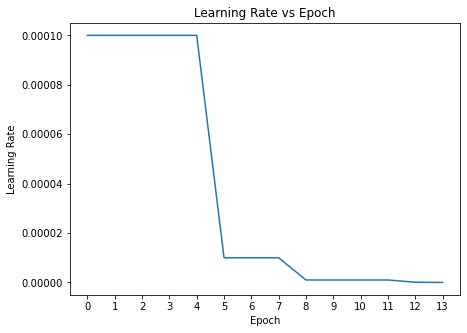

In [18]:
plot_learning_rate(history_dict)

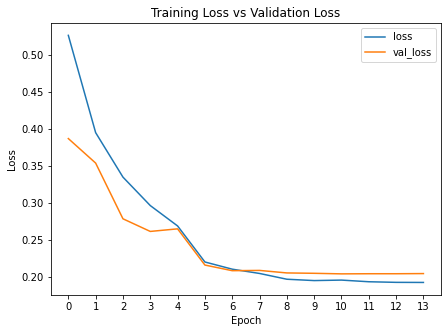

In [19]:
plot_metric(history_dict, 'loss')

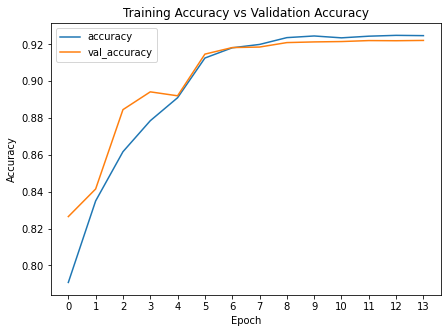

In [20]:
plot_metric(history_dict, 'accuracy')

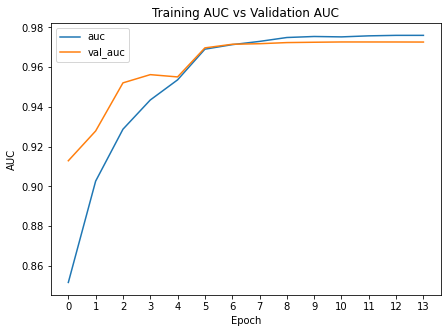

In [21]:
plot_metric(history_dict, 'auc')

---

## Calculate Performance on Test Set

In [22]:
test_metrics = model.evaluate(test_ds, verbose=1)
test_metrics = map_to_metrics(model.metrics_names, test_metrics)

  1/258 [..............................] - ETA: 21s - loss: 0.1435 - accuracy: 0.9375 - auc: 0.9844

 15/258 [>.............................] - ETA: 0s - loss: 0.1948 - accuracy: 0.9229 - auc: 0.9766 

 29/258 [==>...........................] - ETA: 0s - loss: 0.2141 - accuracy: 0.9213 - auc: 0.9703

 43/258 [====>.........................] - ETA: 0s - loss: 0.2082 - accuracy: 0.9237 - auc: 0.9719

 57/258 [=====>........................] - ETA: 0s - loss: 0.2087 - accuracy: 0.9216 - auc: 0.9724

 72/258 [=======>......................] - ETA: 0s - loss: 0.2068 - accuracy: 0.9206 - auc: 0.9730

 87/258 [=========>....................] - ETA: 0s - loss: 0.2077 - accuracy: 0.9203 - auc: 0.9728

101/258 [==========>...................] - ETA: 0s - loss: 0.2088 - accuracy: 0.9180 - auc: 0.9725

115/258 [============>.................] - ETA: 0s - loss: 0.2101 - accuracy: 0.9177 - auc: 0.9718

129/258 [==============>...............] - ETA: 0s - loss: 0.2096 - accuracy: 0.9167 - auc: 0.9720

143/258 [===============>..............] - ETA: 0s - loss: 0.2075 - accuracy: 0.9176 - auc: 0.9727

157/258 [=================>............] - ETA: 0s - loss: 0.2052 - accuracy: 0.9180 - auc: 0.9733

171/258 [==================>...........] - ETA: 0s - loss: 0.2057 - accuracy: 0.9170 - auc: 0.9730

185/258 [====================>.........] - ETA: 0s - loss: 0.2059 - accuracy: 0.9172 - auc: 0.9729

200/258 [======================>.......] - ETA: 0s - loss: 0.2112 - accuracy: 0.9152 - auc: 0.9712

214/258 [=======================>......] - ETA: 0s - loss: 0.2100 - accuracy: 0.9168 - auc: 0.9715

228/258 [=========================>....] - ETA: 0s - loss: 0.2105 - accuracy: 0.9164 - auc: 0.9715

242/258 [===========================>..] - ETA: 0s - loss: 0.2107 - accuracy: 0.9163 - auc: 0.9715

256/258 [============================>.] - ETA: 0s - loss: 0.2103 - accuracy: 0.9166 - auc: 0.9716

258/258 [==============================] - 1s 4ms/step - loss: 0.2104 - accuracy: 0.9165 - auc: 0.9716


In [23]:
# Save test metrics
json.dump(test_metrics, open(f"{model_output_dir}/{MODEL_NAME}/test_metrics.json", 'w'))

---